In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [12]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False, save_record = True):
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    
    print(f"Data shape: {proc_data.shape}")

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, np.zeros_like(proc_data), num_iteration = iteration, use_epochs = True)

    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)
    
    labels_map_1 = som.labels_map(proc_data, proc_err, [0] * len(proc_data))
    labels_map_2 = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]
    
    for i in labels_map_2.keys():
        properties = np.array(list(labels_map_2[i].keys()))
        means = np.mean(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = means[1]
        z_std[int(list(i)[0]), int(list(i)[1])] = stds[1]

    print([dim, sigma, rate])
    print(np.sum(density_map))
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Average redshift std: {np.nanmean(z_std)}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/3rd_exploration/diagram/{data_type}_{len(proc_data[0])}_{dim}_{sigma}_{rate}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()

    if save_record:
    
        map_record = {}
        map_record["dim"] = dim
        map_record["sigma"] = sigma
        map_record["rate"] = rate
        map_record["band_cut"] = len(proc_data[0])
        map_record["mag_cut"] = len(proc_data)
        map_record["preproc"] = preproc
        map_record["som"] = som
        map_record["topo_err"] = som.topographic_error(proc_data)
        map_record["quan_err"] = som.quantization_error(proc_data)
        map_record["density"] = density_map
        map_record["magnitude"] = magnitude_map
        map_record["z"] = z_map
        map_record["type"] = data_type
        map_record["distance"] = distance
        map_record["iter"] = iteration
        map_record["b_scale"] = b_scale
        map_record["prop_map"] = labels_map_2
        map_record["mean_std"] = np.nanmean(z_std)
        
        try:
            with open(f"D:/SPHEREx_SOM/record/3rd_exploration/SOM/{data_type}_{dim}_{sigma}_{rate}_{iteration}.pkl",'wb') as handle:
                pickle.dump(map_record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    
    return som

In [13]:
data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
err = data_all[0, 1::2]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\836707857.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]


In [ ]:
for i in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6, 10 ** 7, 10 ** 8, 10 ** 9, 10 ** 10]:
    som = basic_som(data = data, data_type = "noisy_lup_deep", err = err, info_data = info, dim = 30, preproc = "default", iteration = 2, sigma = 0.6, rate = 0.2, b_scale  = i, save = True, distance = "euclidean")

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 1, 0.1]
29683.0
Topological error: 0.4782872351177442
Quantization error: 6.098636141176825
Average redshift std: 0.26523330814955975


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


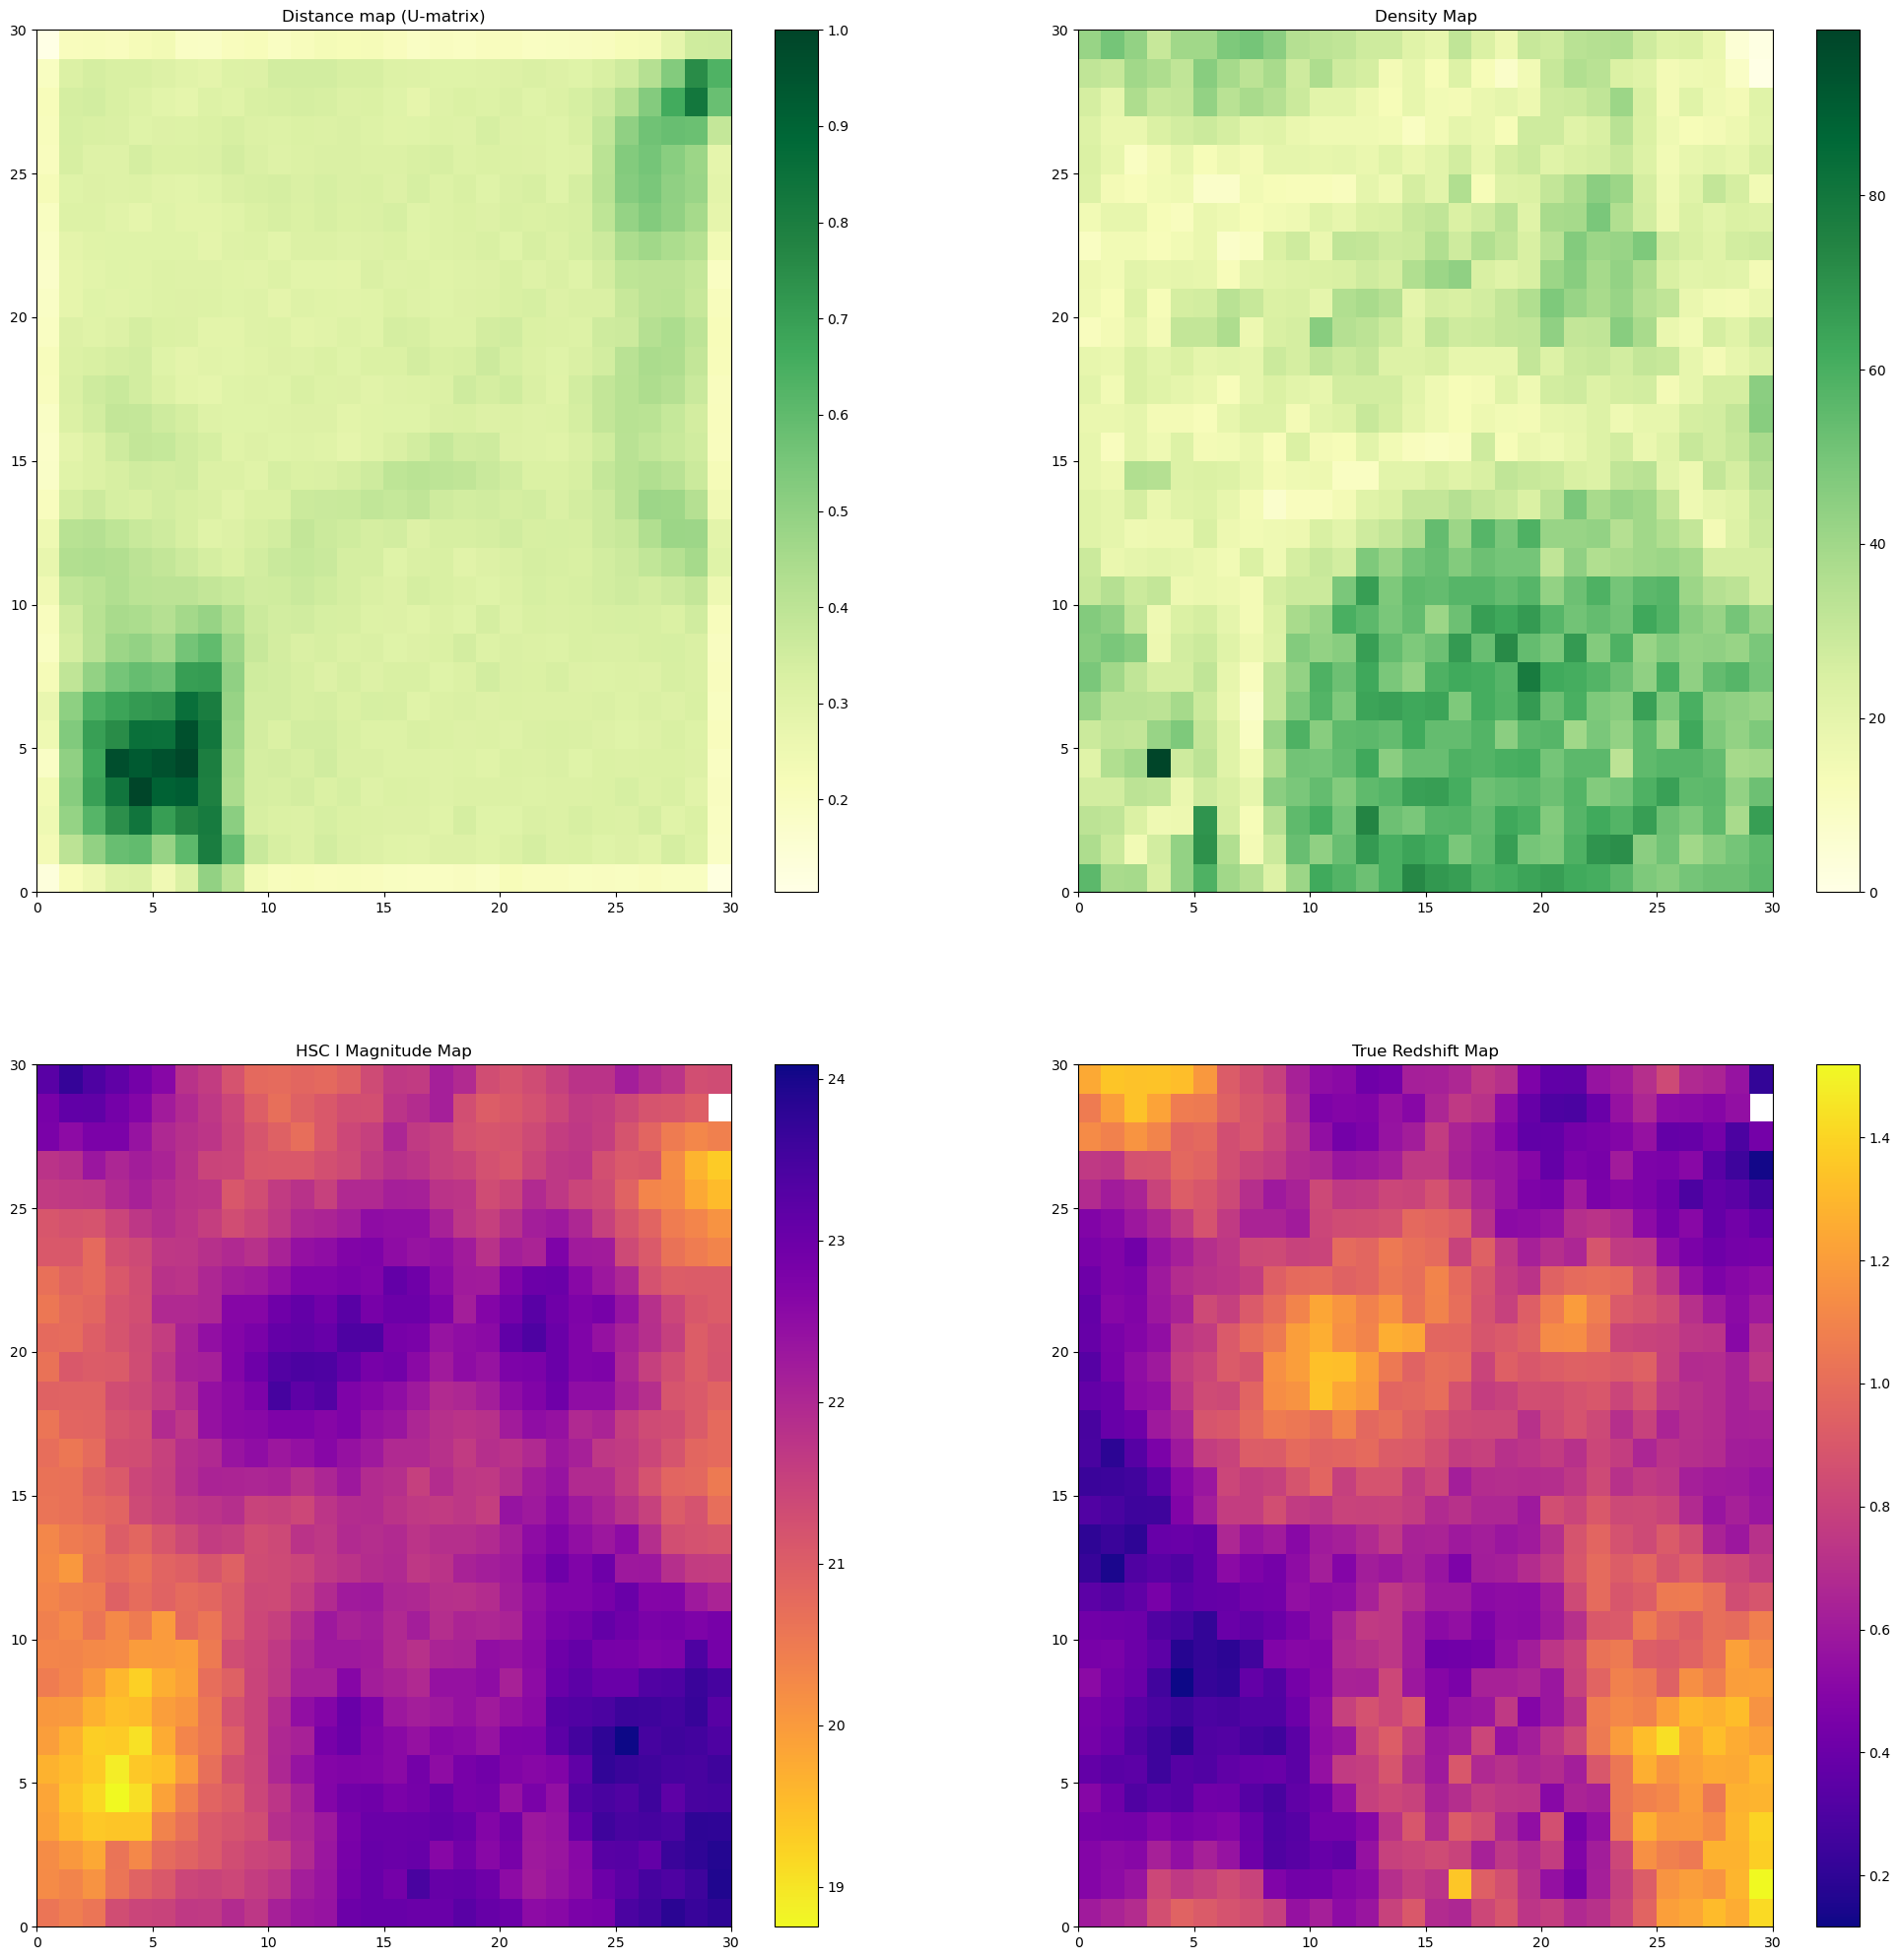

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.9, 0.1]
29683.0
Topological error: 0.573122662803625
Quantization error: 6.0798940102830095
Average redshift std: 0.26747160793495456


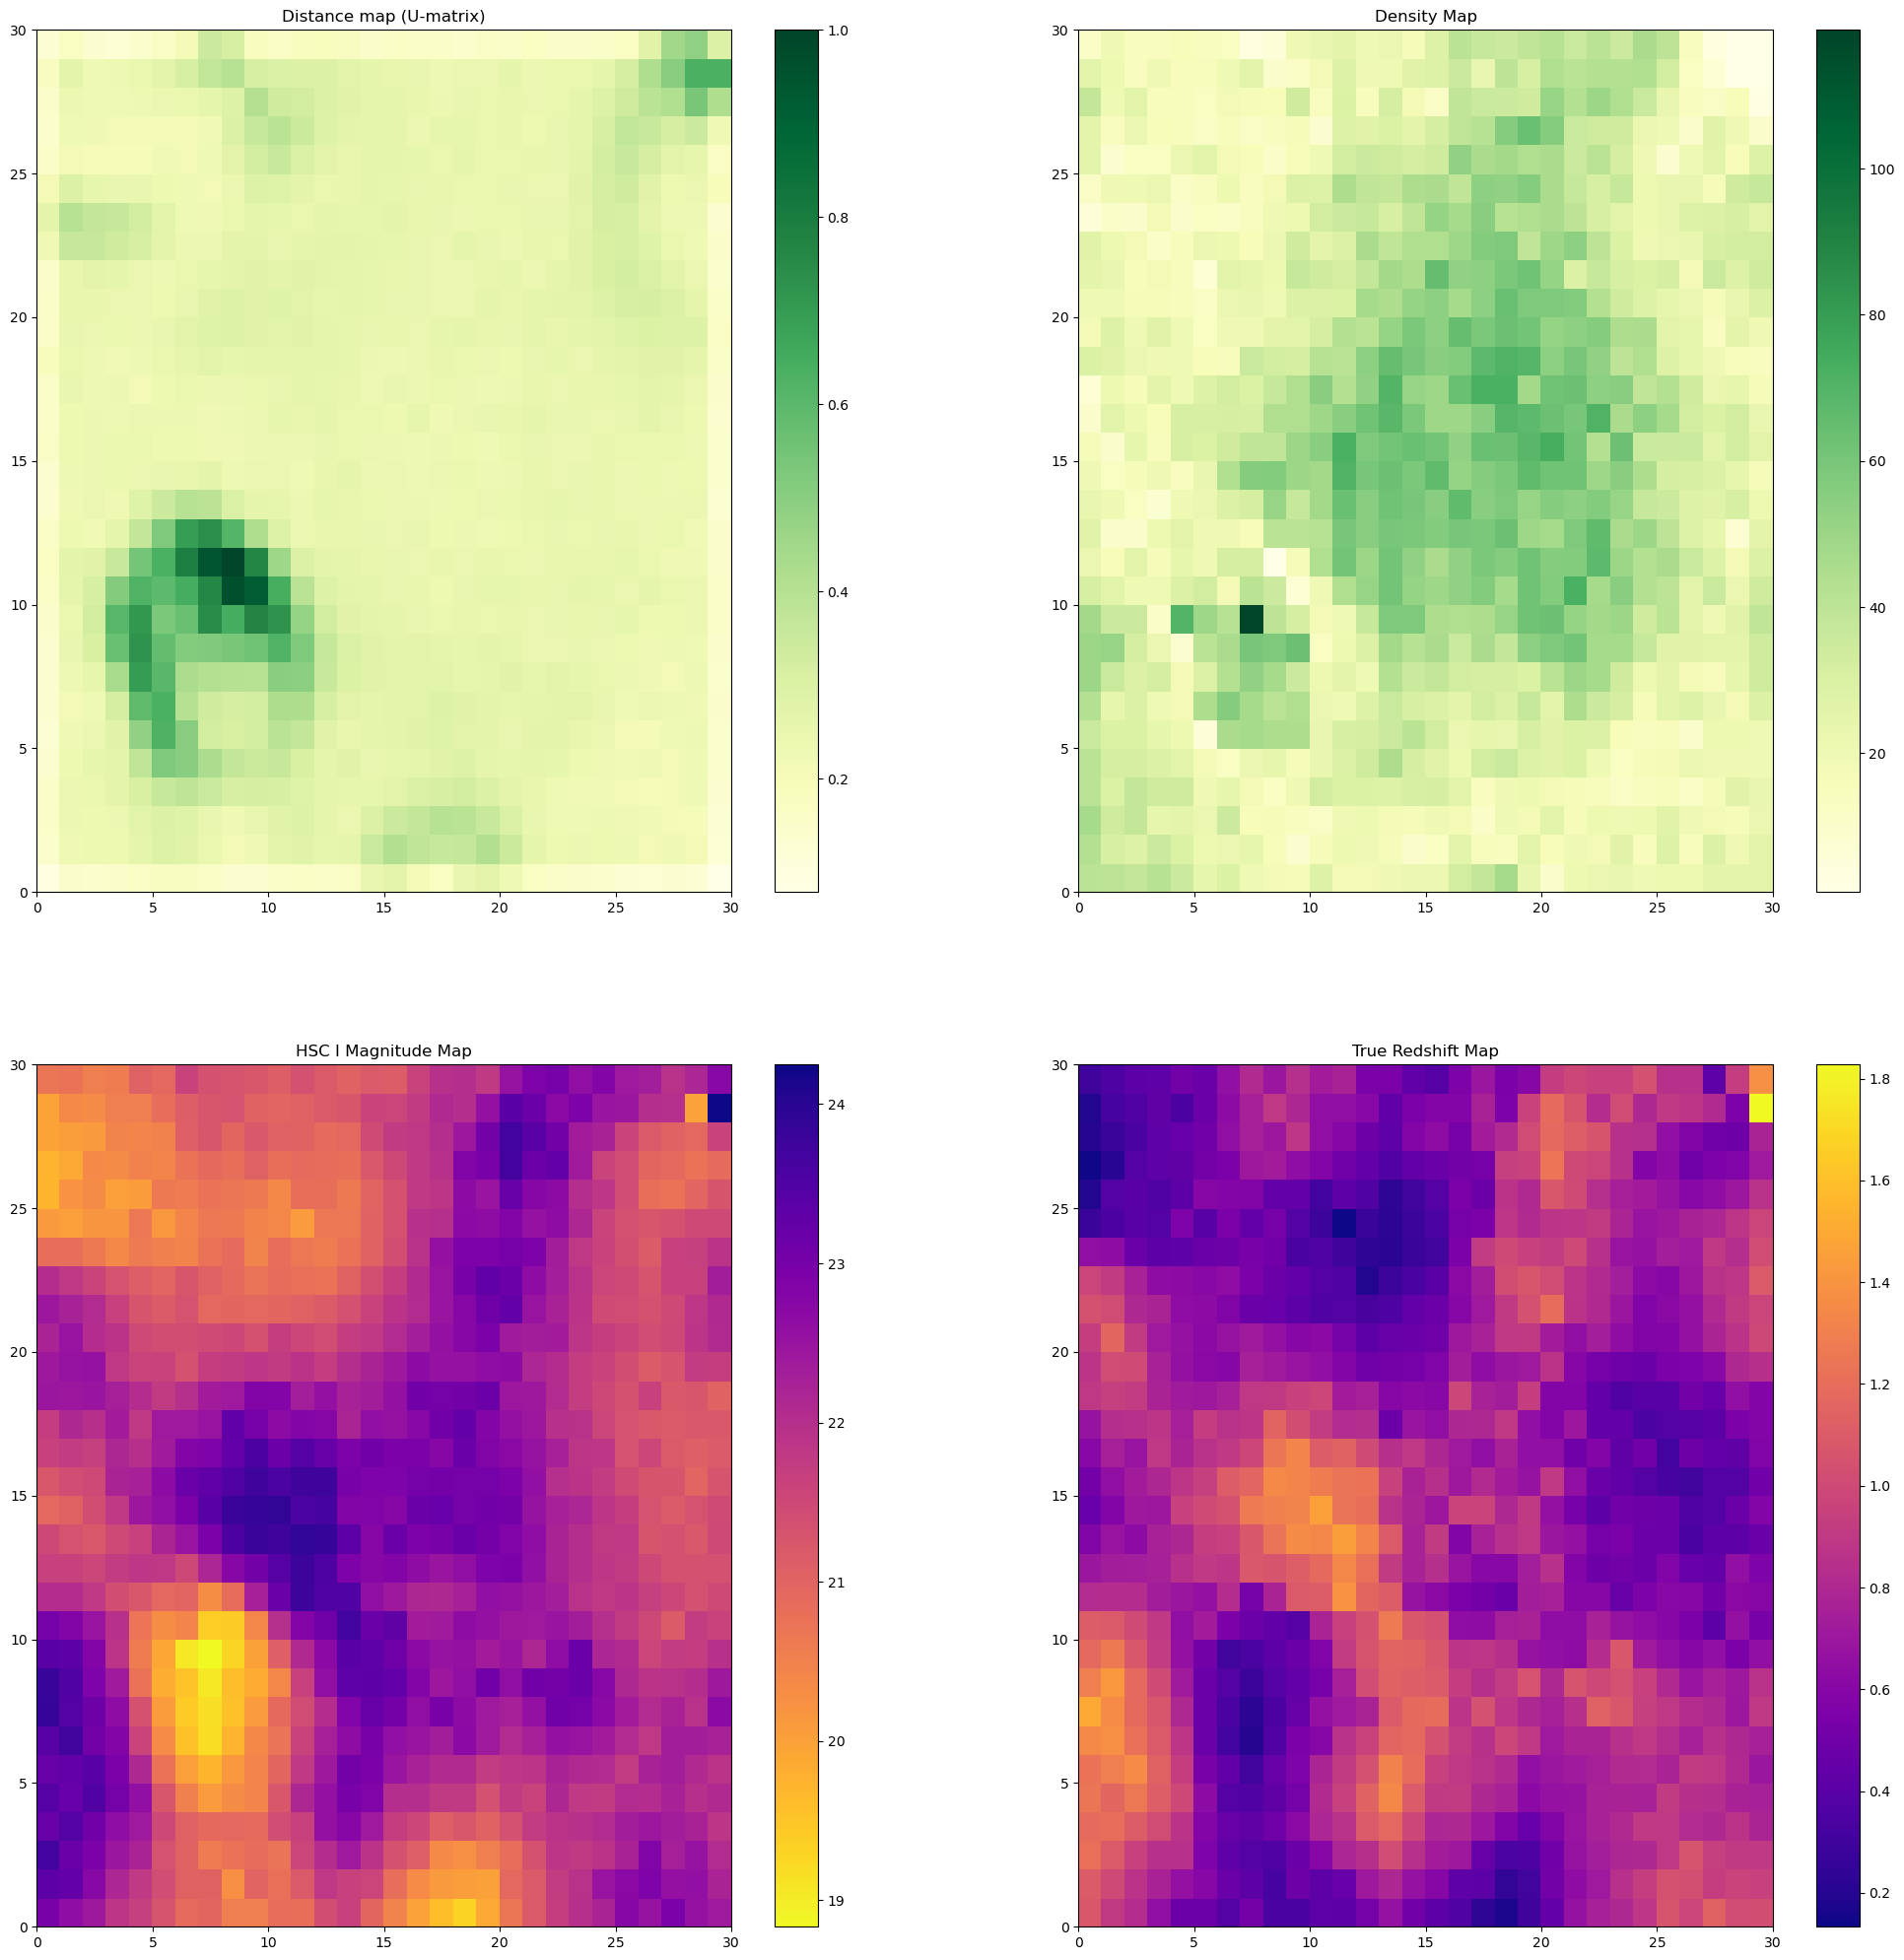

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.8, 0.1]
29683.0
Topological error: 0.6560320722298959
Quantization error: 6.080675488267419
Average redshift std: 0.255017195141948


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


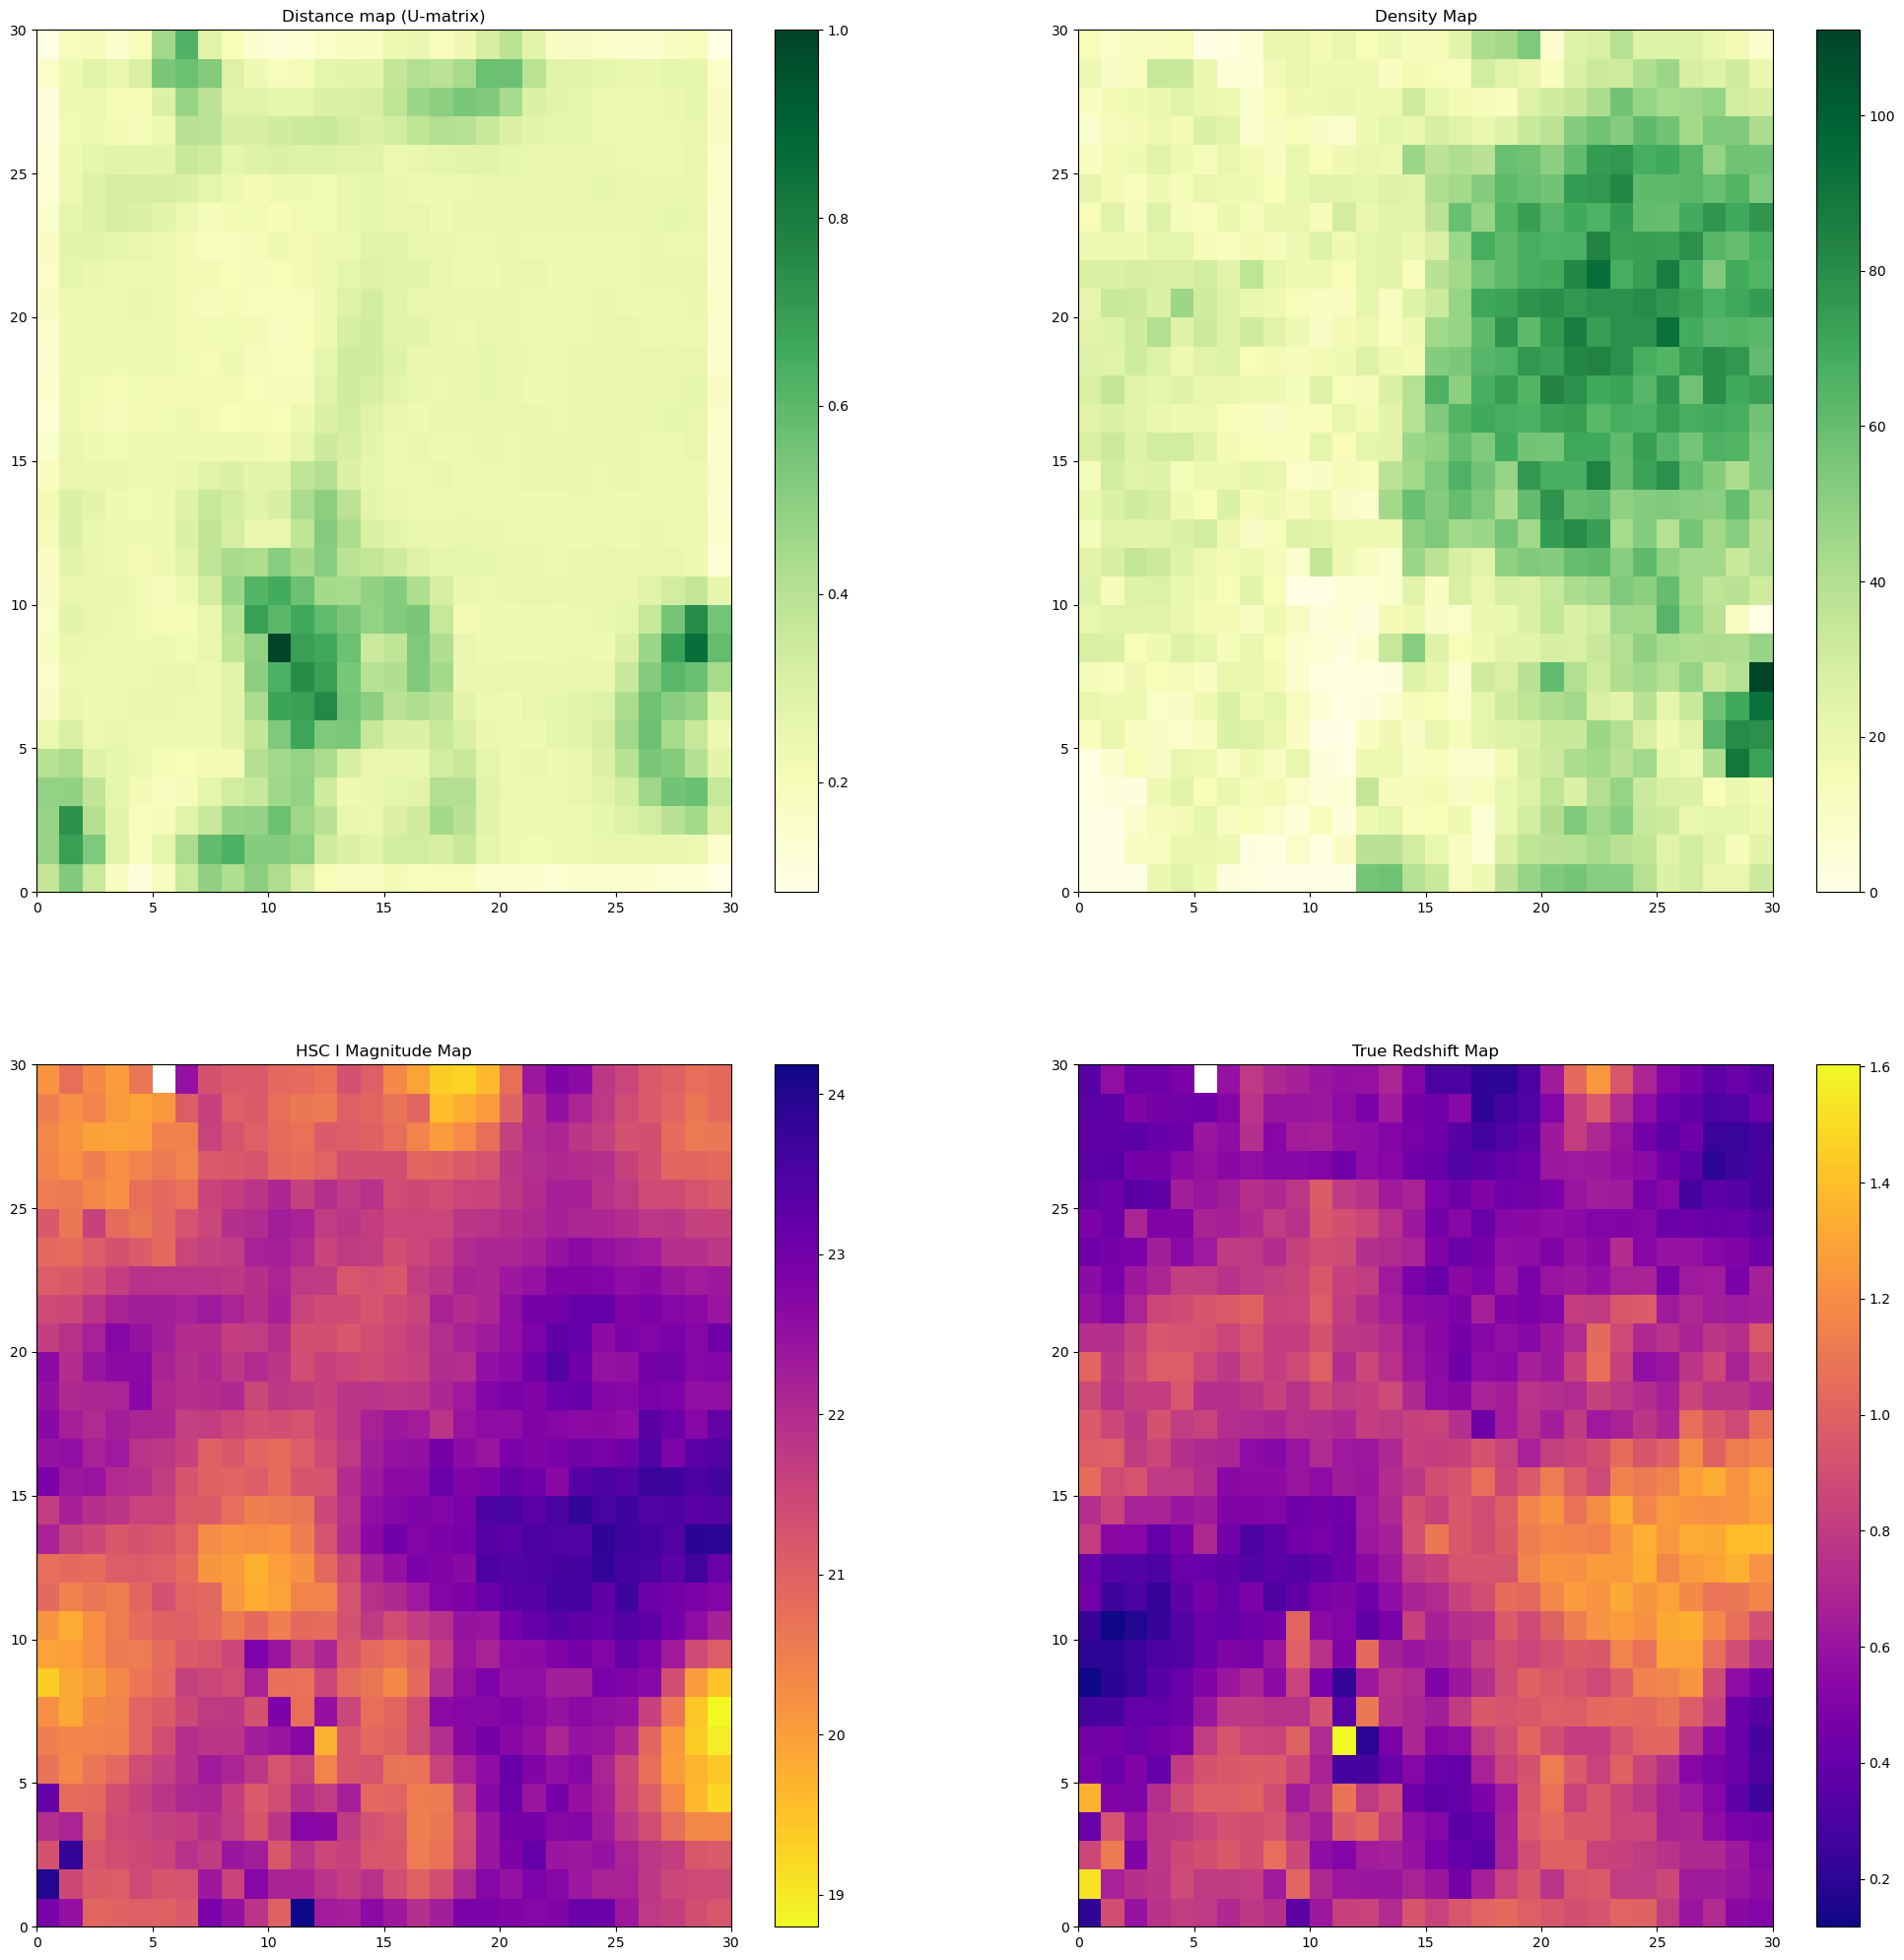

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.7, 0.1]
29683.0
Topological error: 0.7242529393929185
Quantization error: 6.085445947536553
Average redshift std: 0.2575338634029149


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


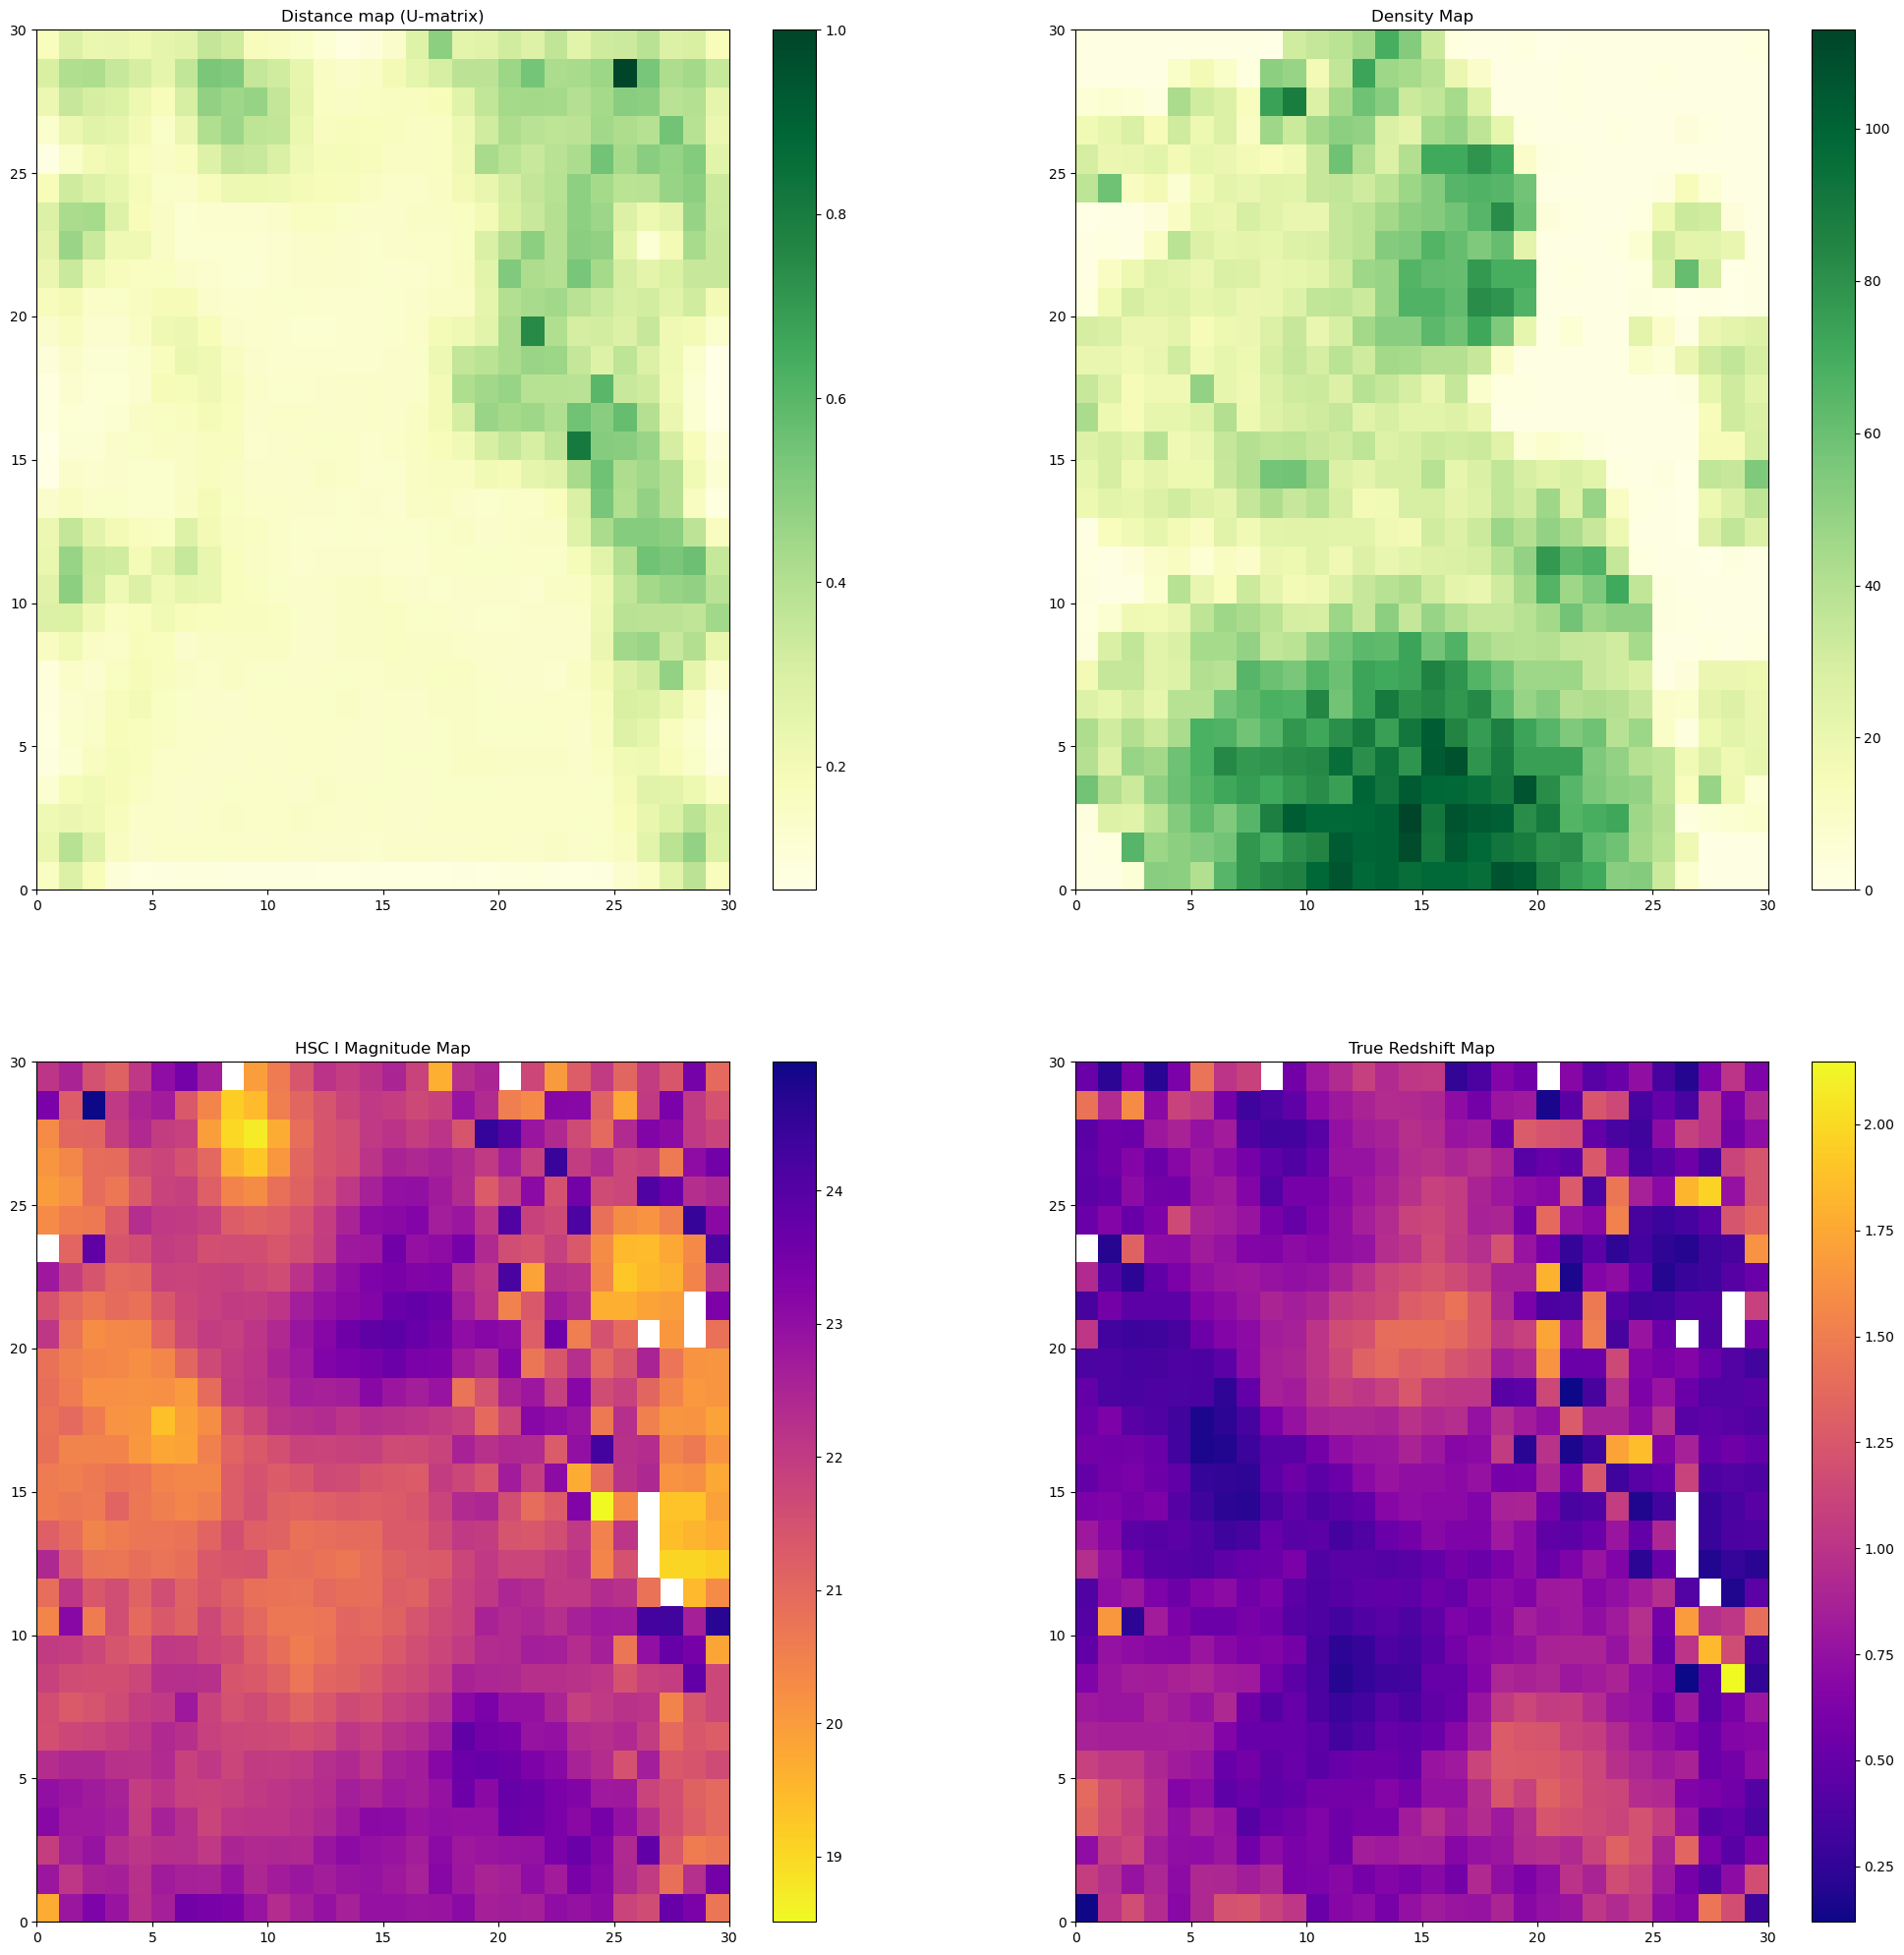

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 0.1]
29683.0
Topological error: 0.7778189536098103
Quantization error: 6.096654928367336
Average redshift std: 0.25819482516098247


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


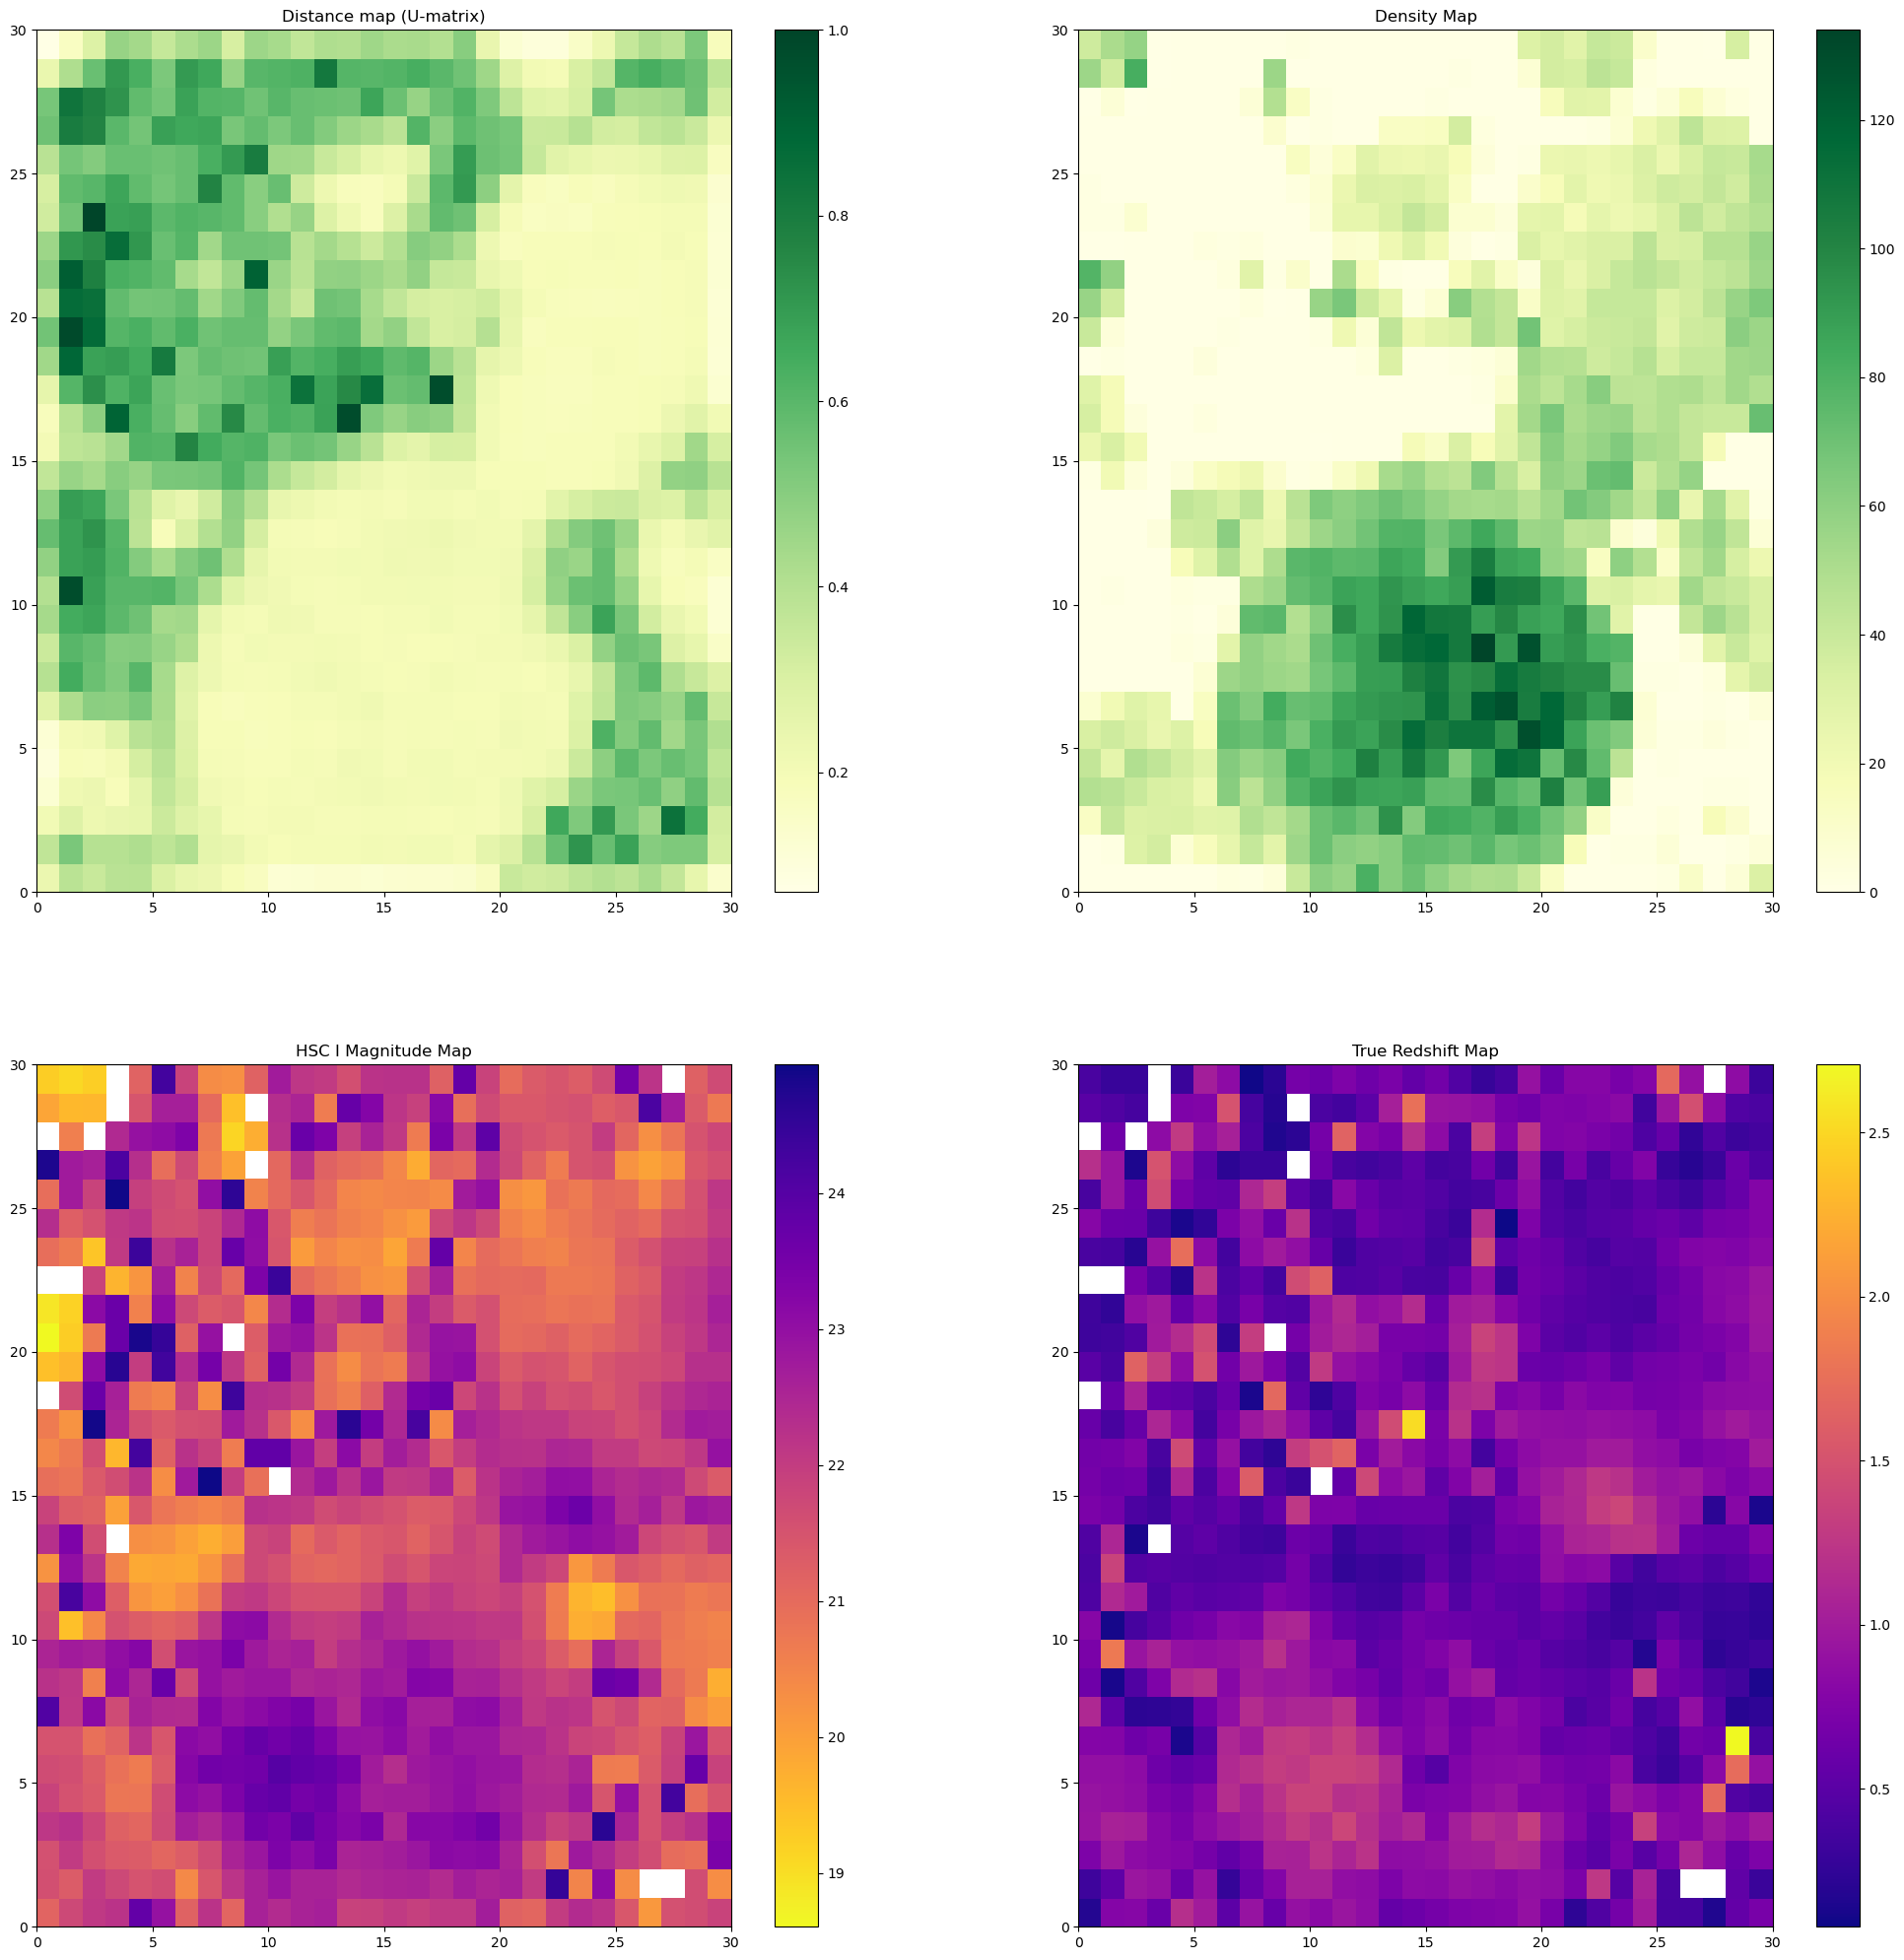

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.1]
29683.0
Topological error: 0.8380217632988579
Quantization error: 6.121375355749807
Average redshift std: 0.25740998638074036


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


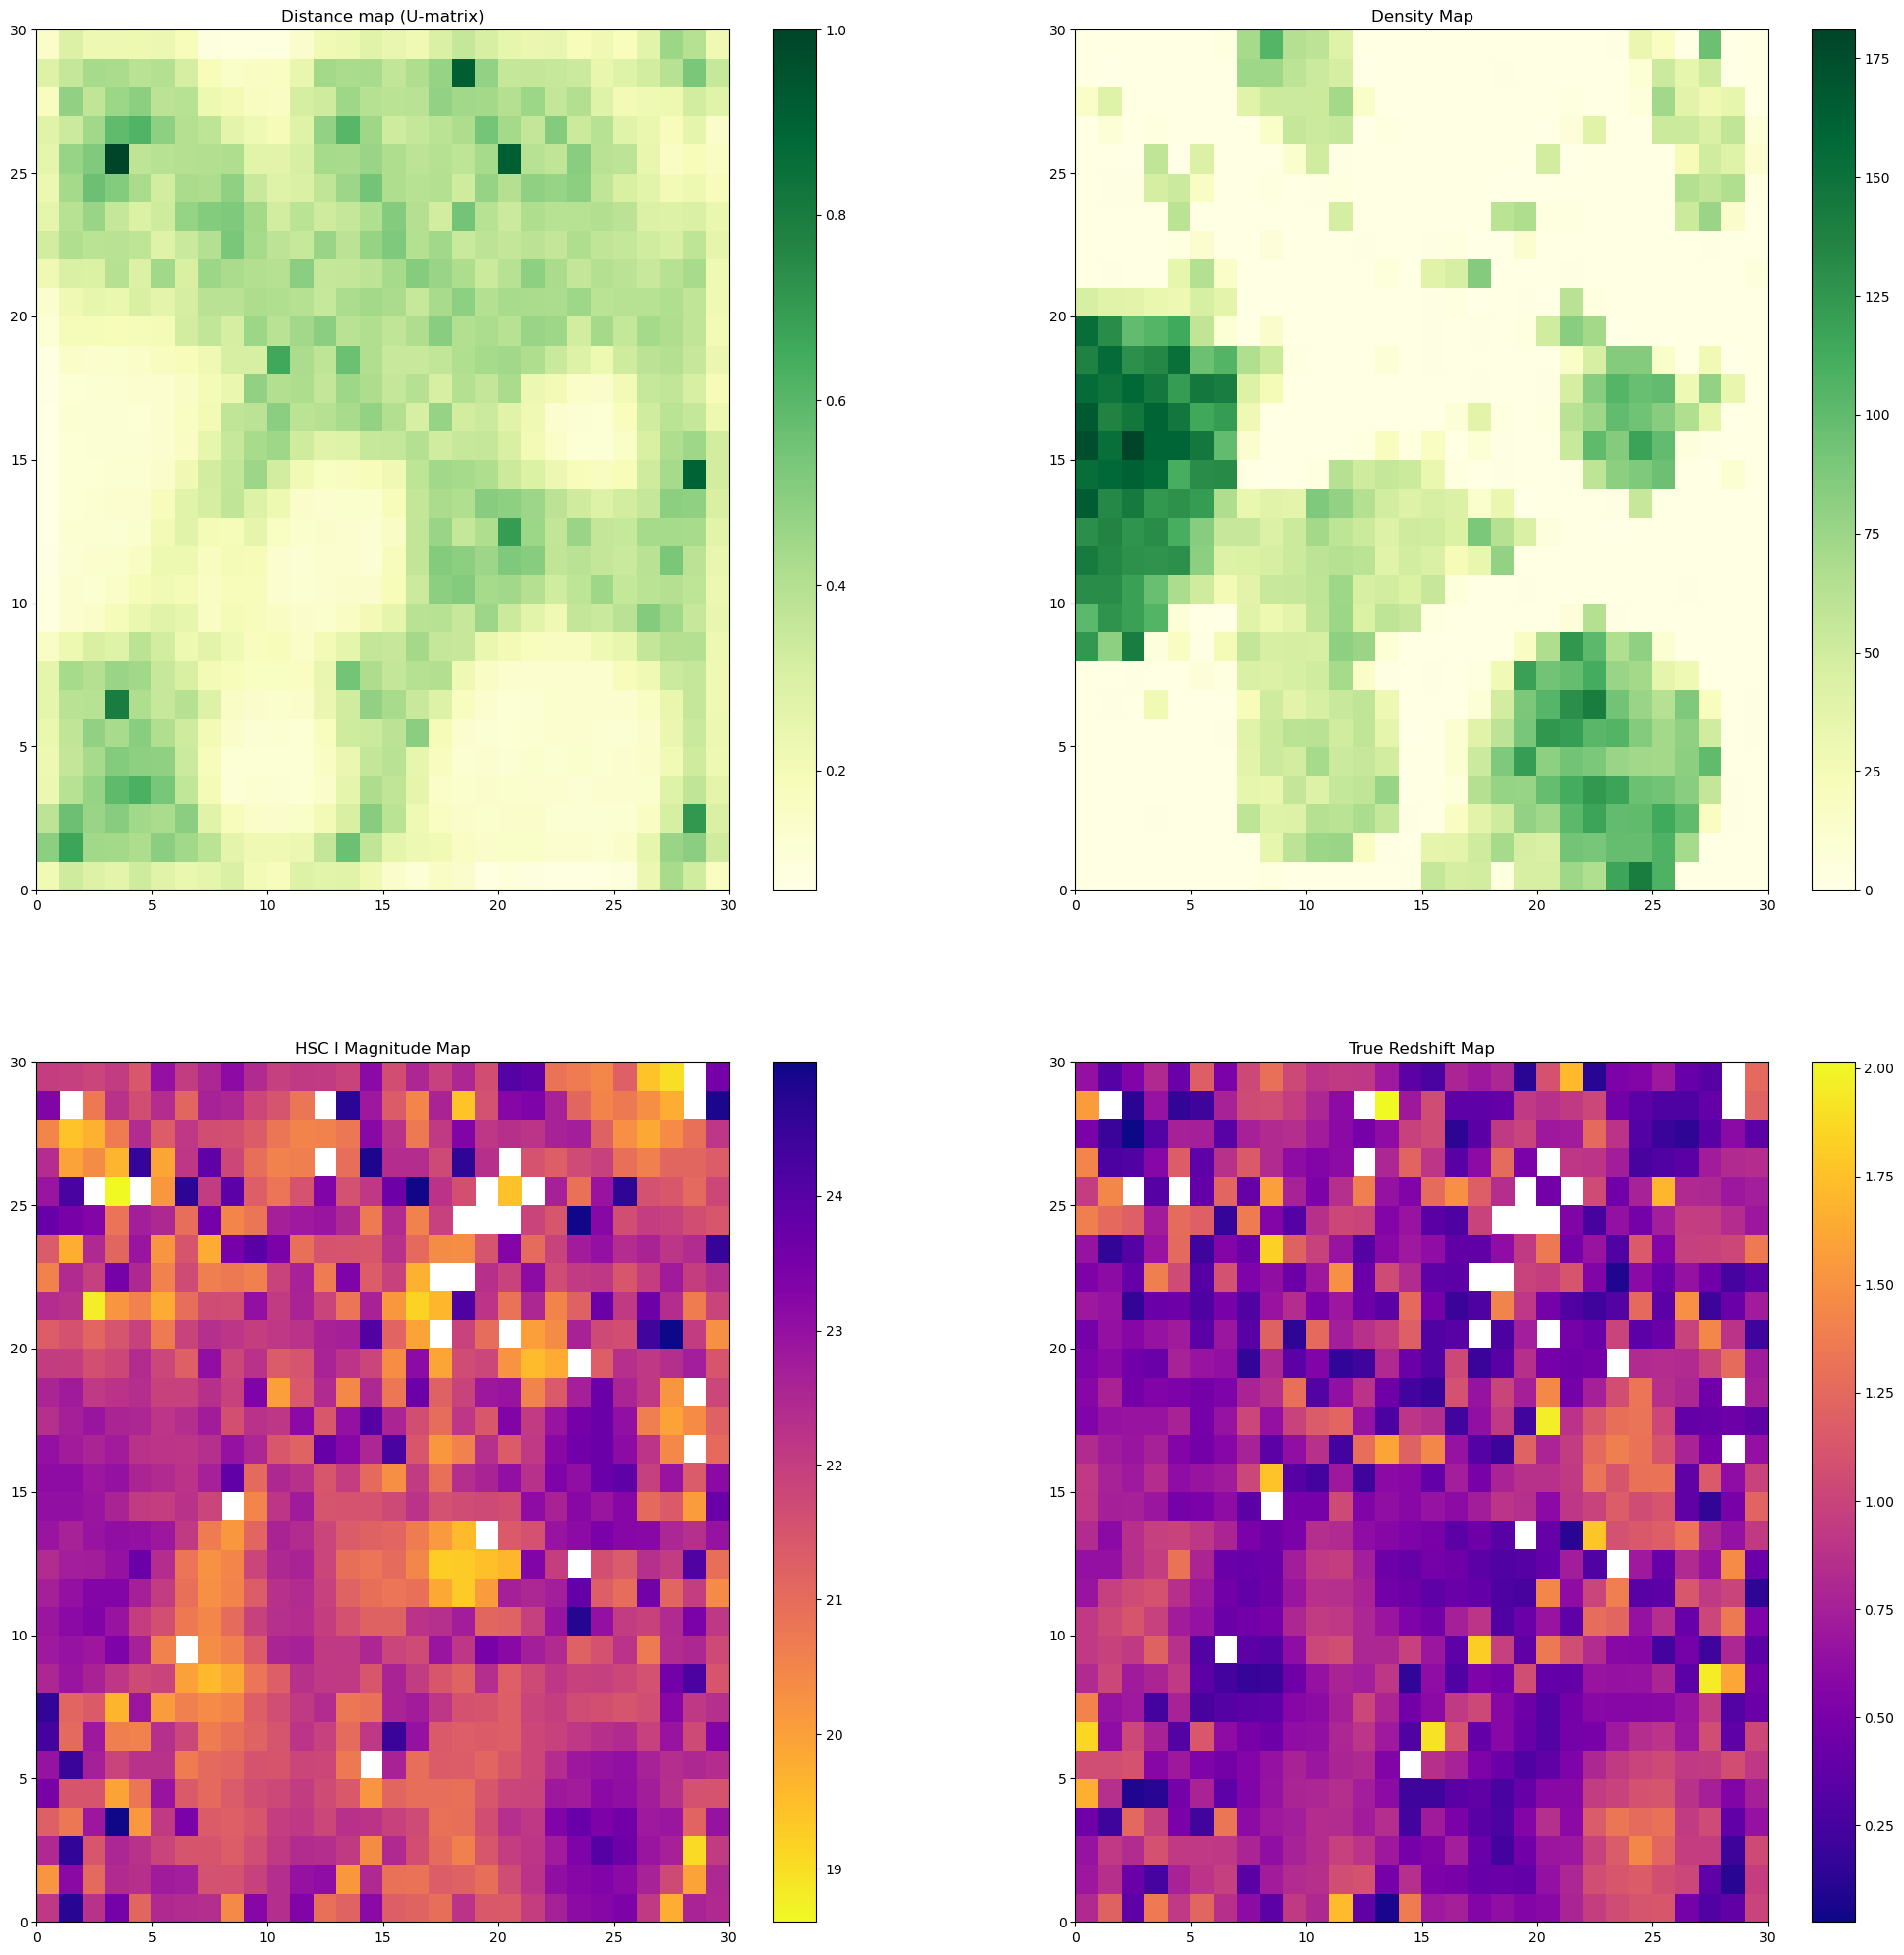

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.1]
29683.0
Topological error: 0.8908803018562814
Quantization error: 6.153860536543928
Average redshift std: 0.2683532581626179


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


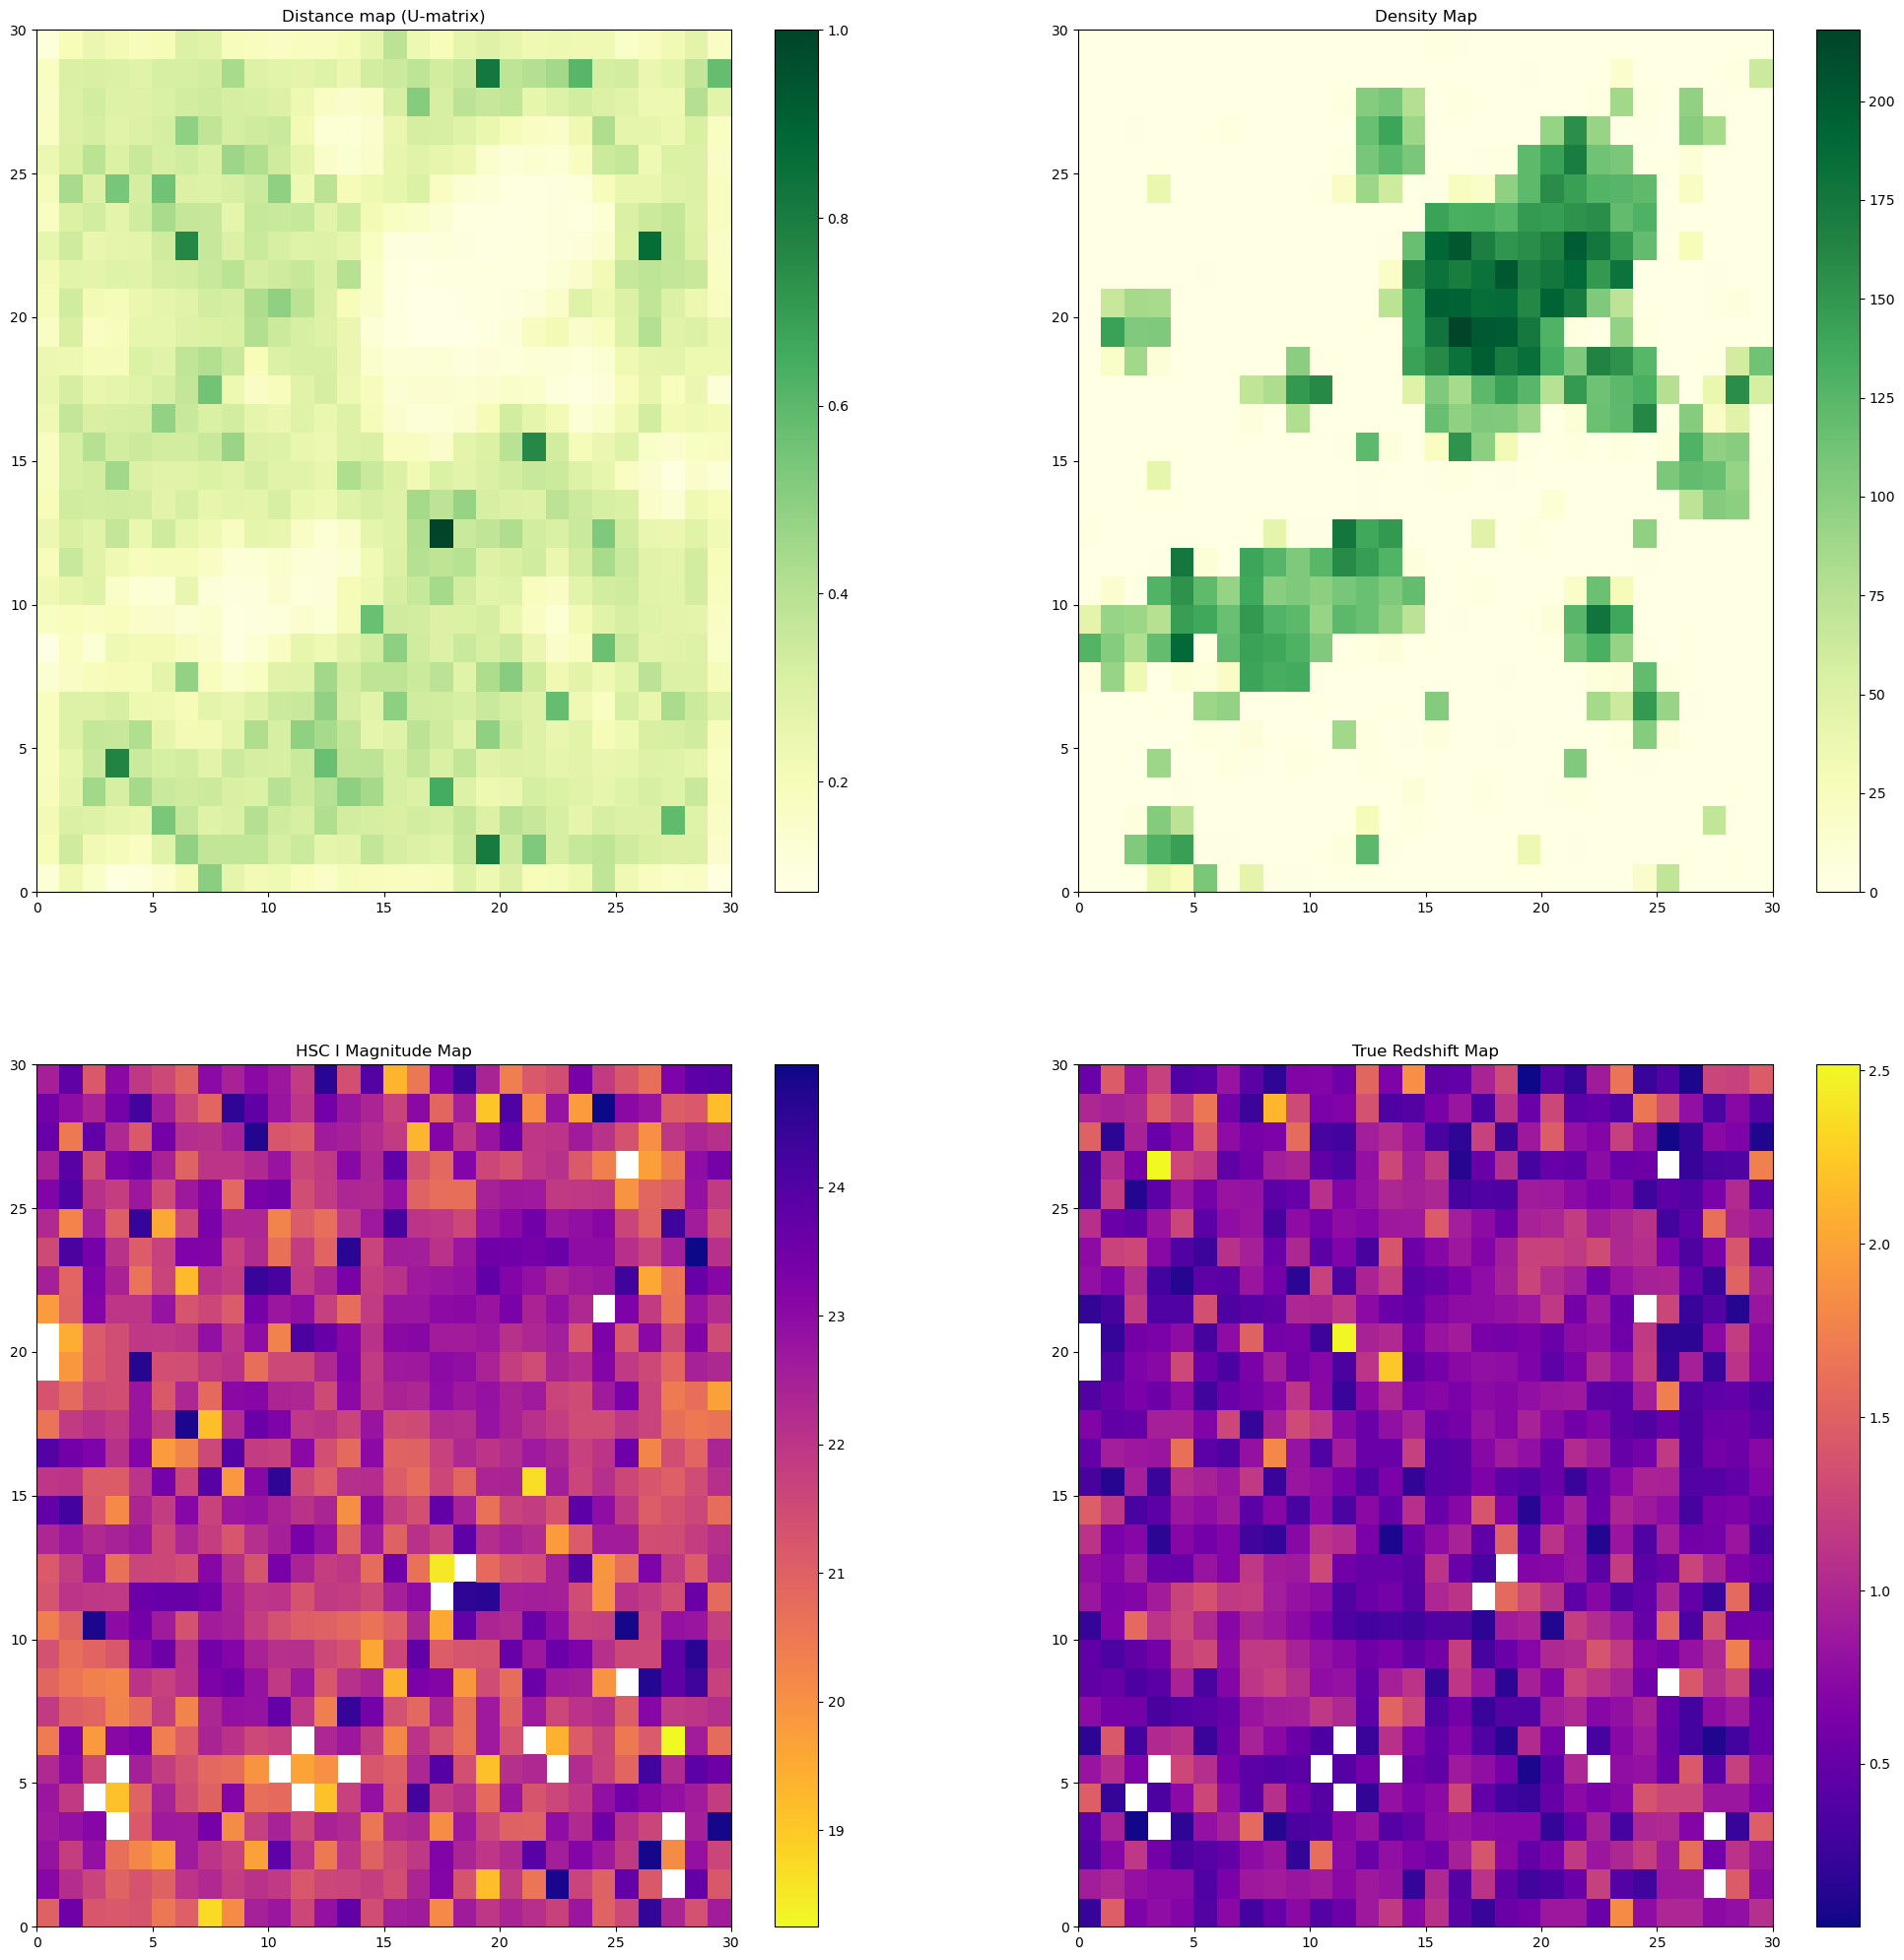

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.2]
29683.0
Topological error: 0.5840380015497086
Quantization error: 6.102617198686933
Average redshift std: 0.29565071058831294


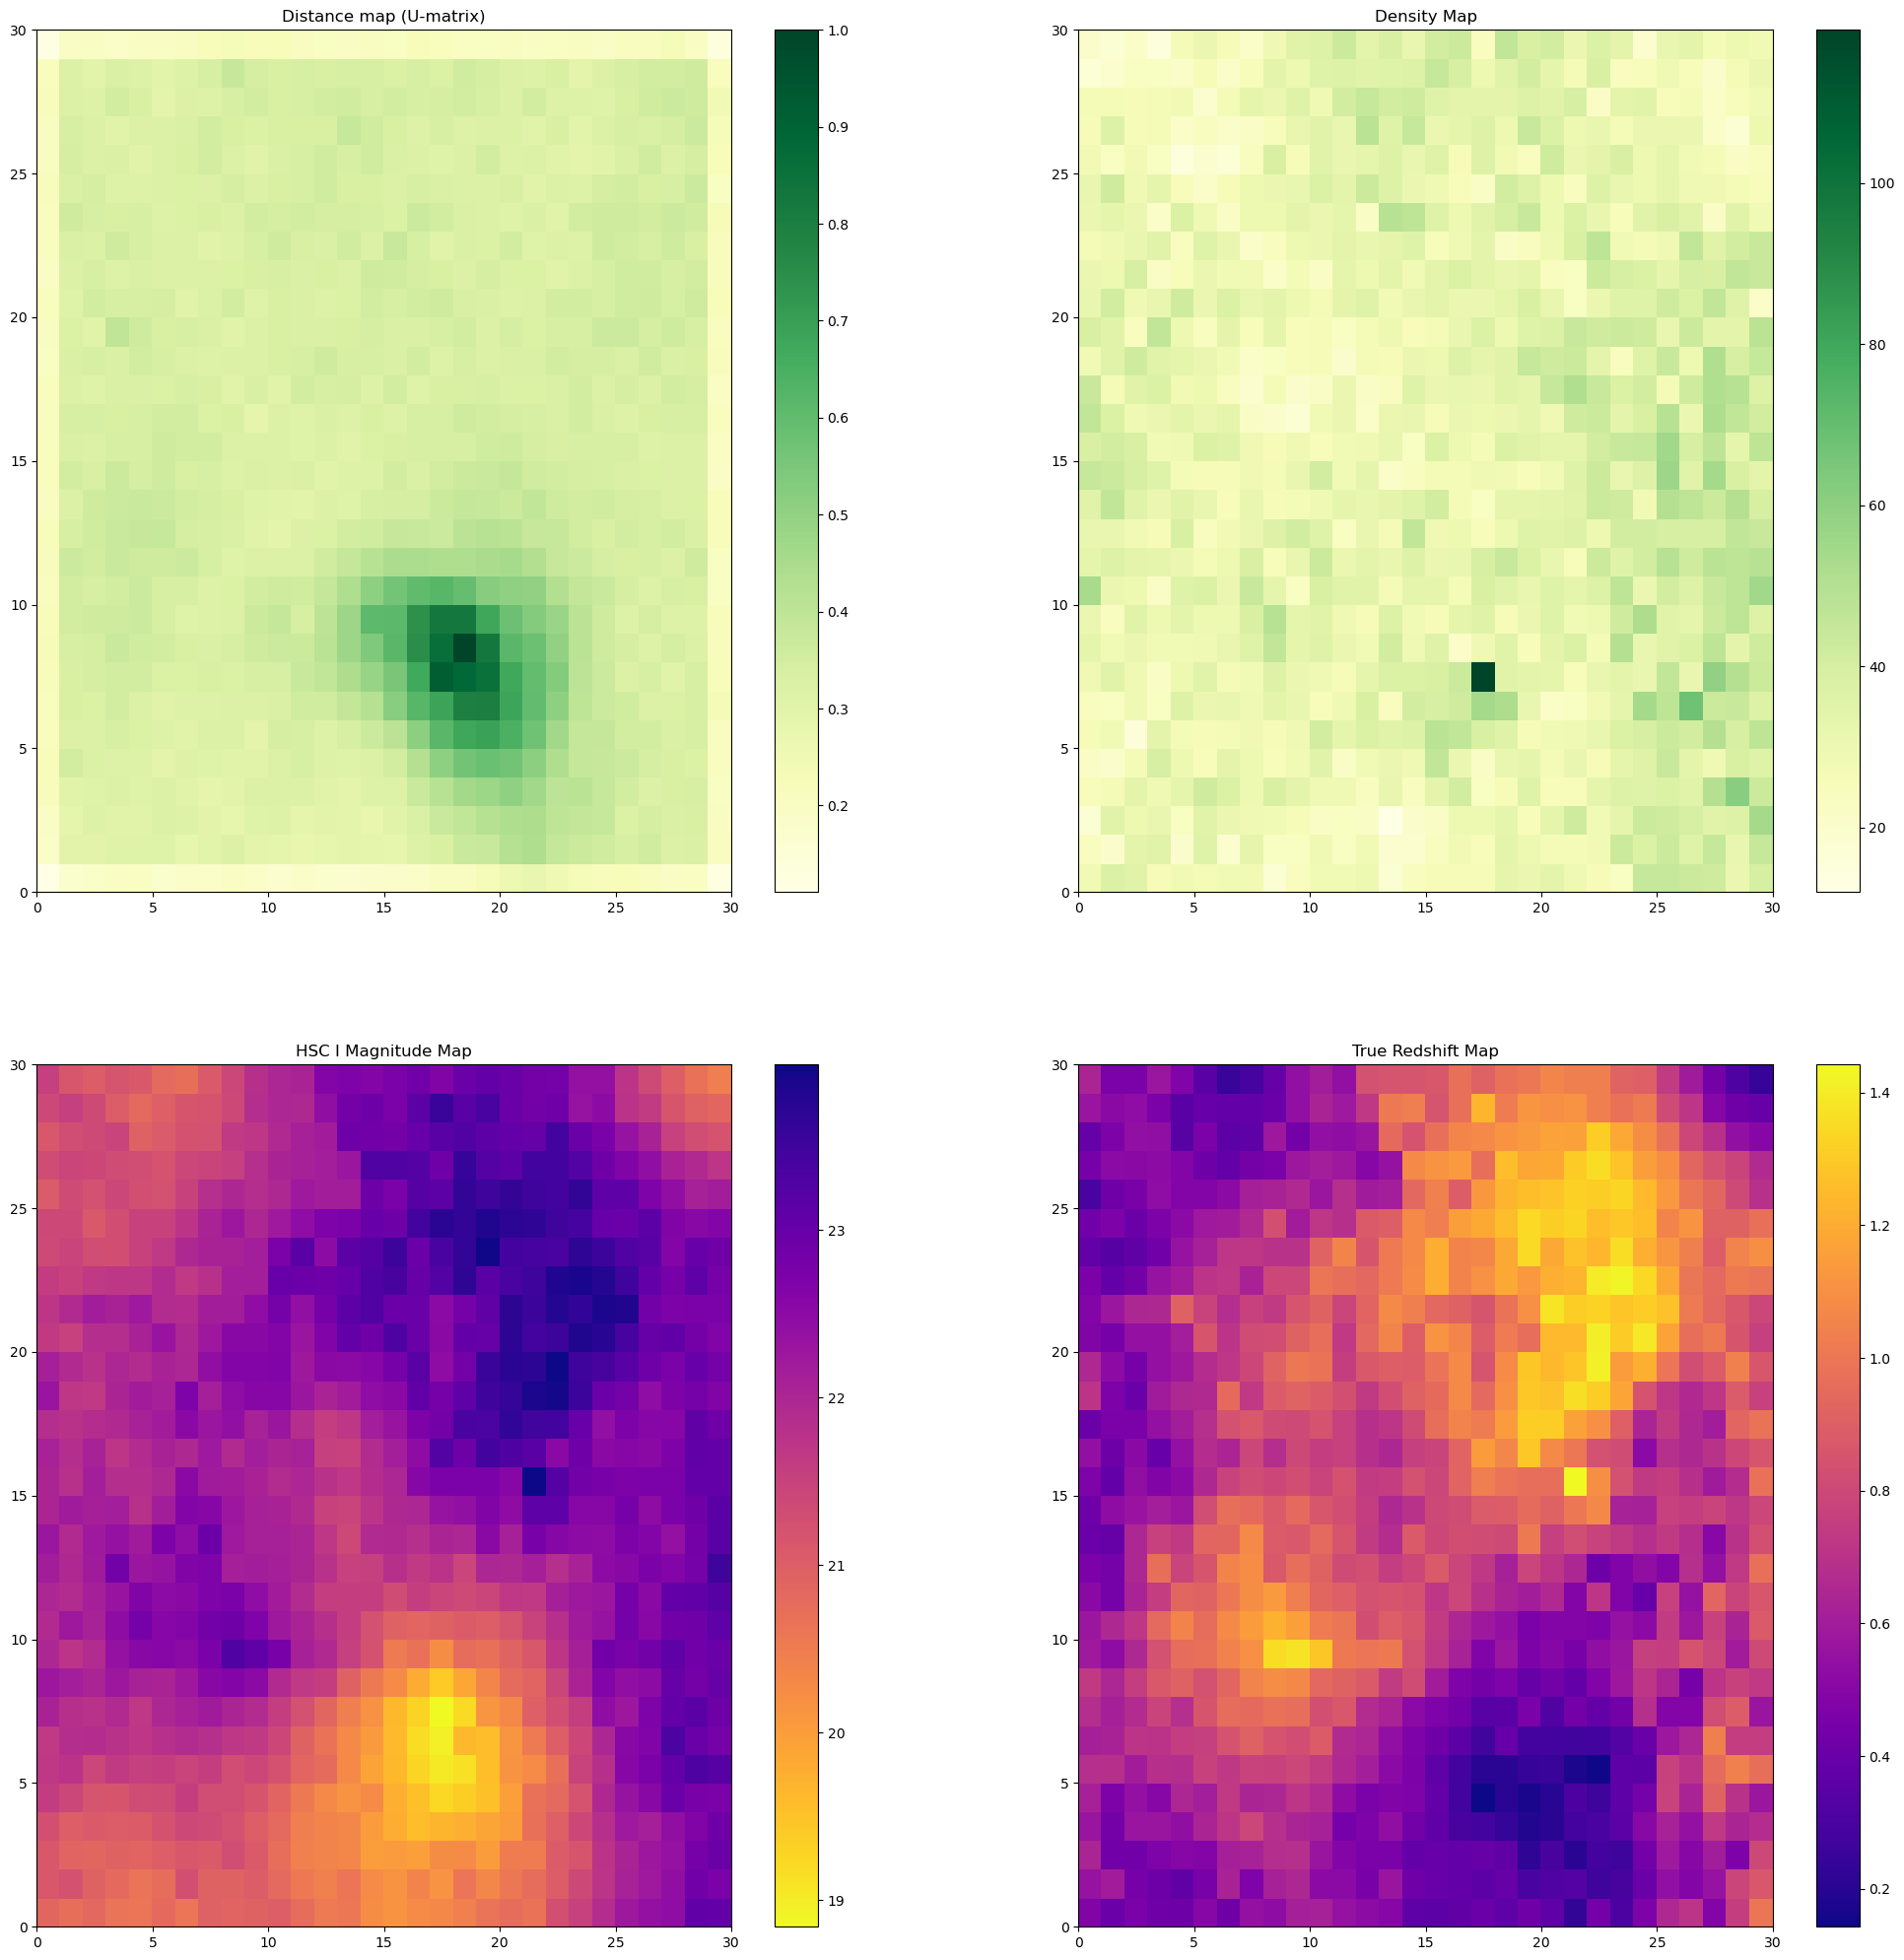

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.2]
29683.0
Topological error: 0.6747970218643669
Quantization error: 6.08136315551084
Average redshift std: 0.2941046731447974


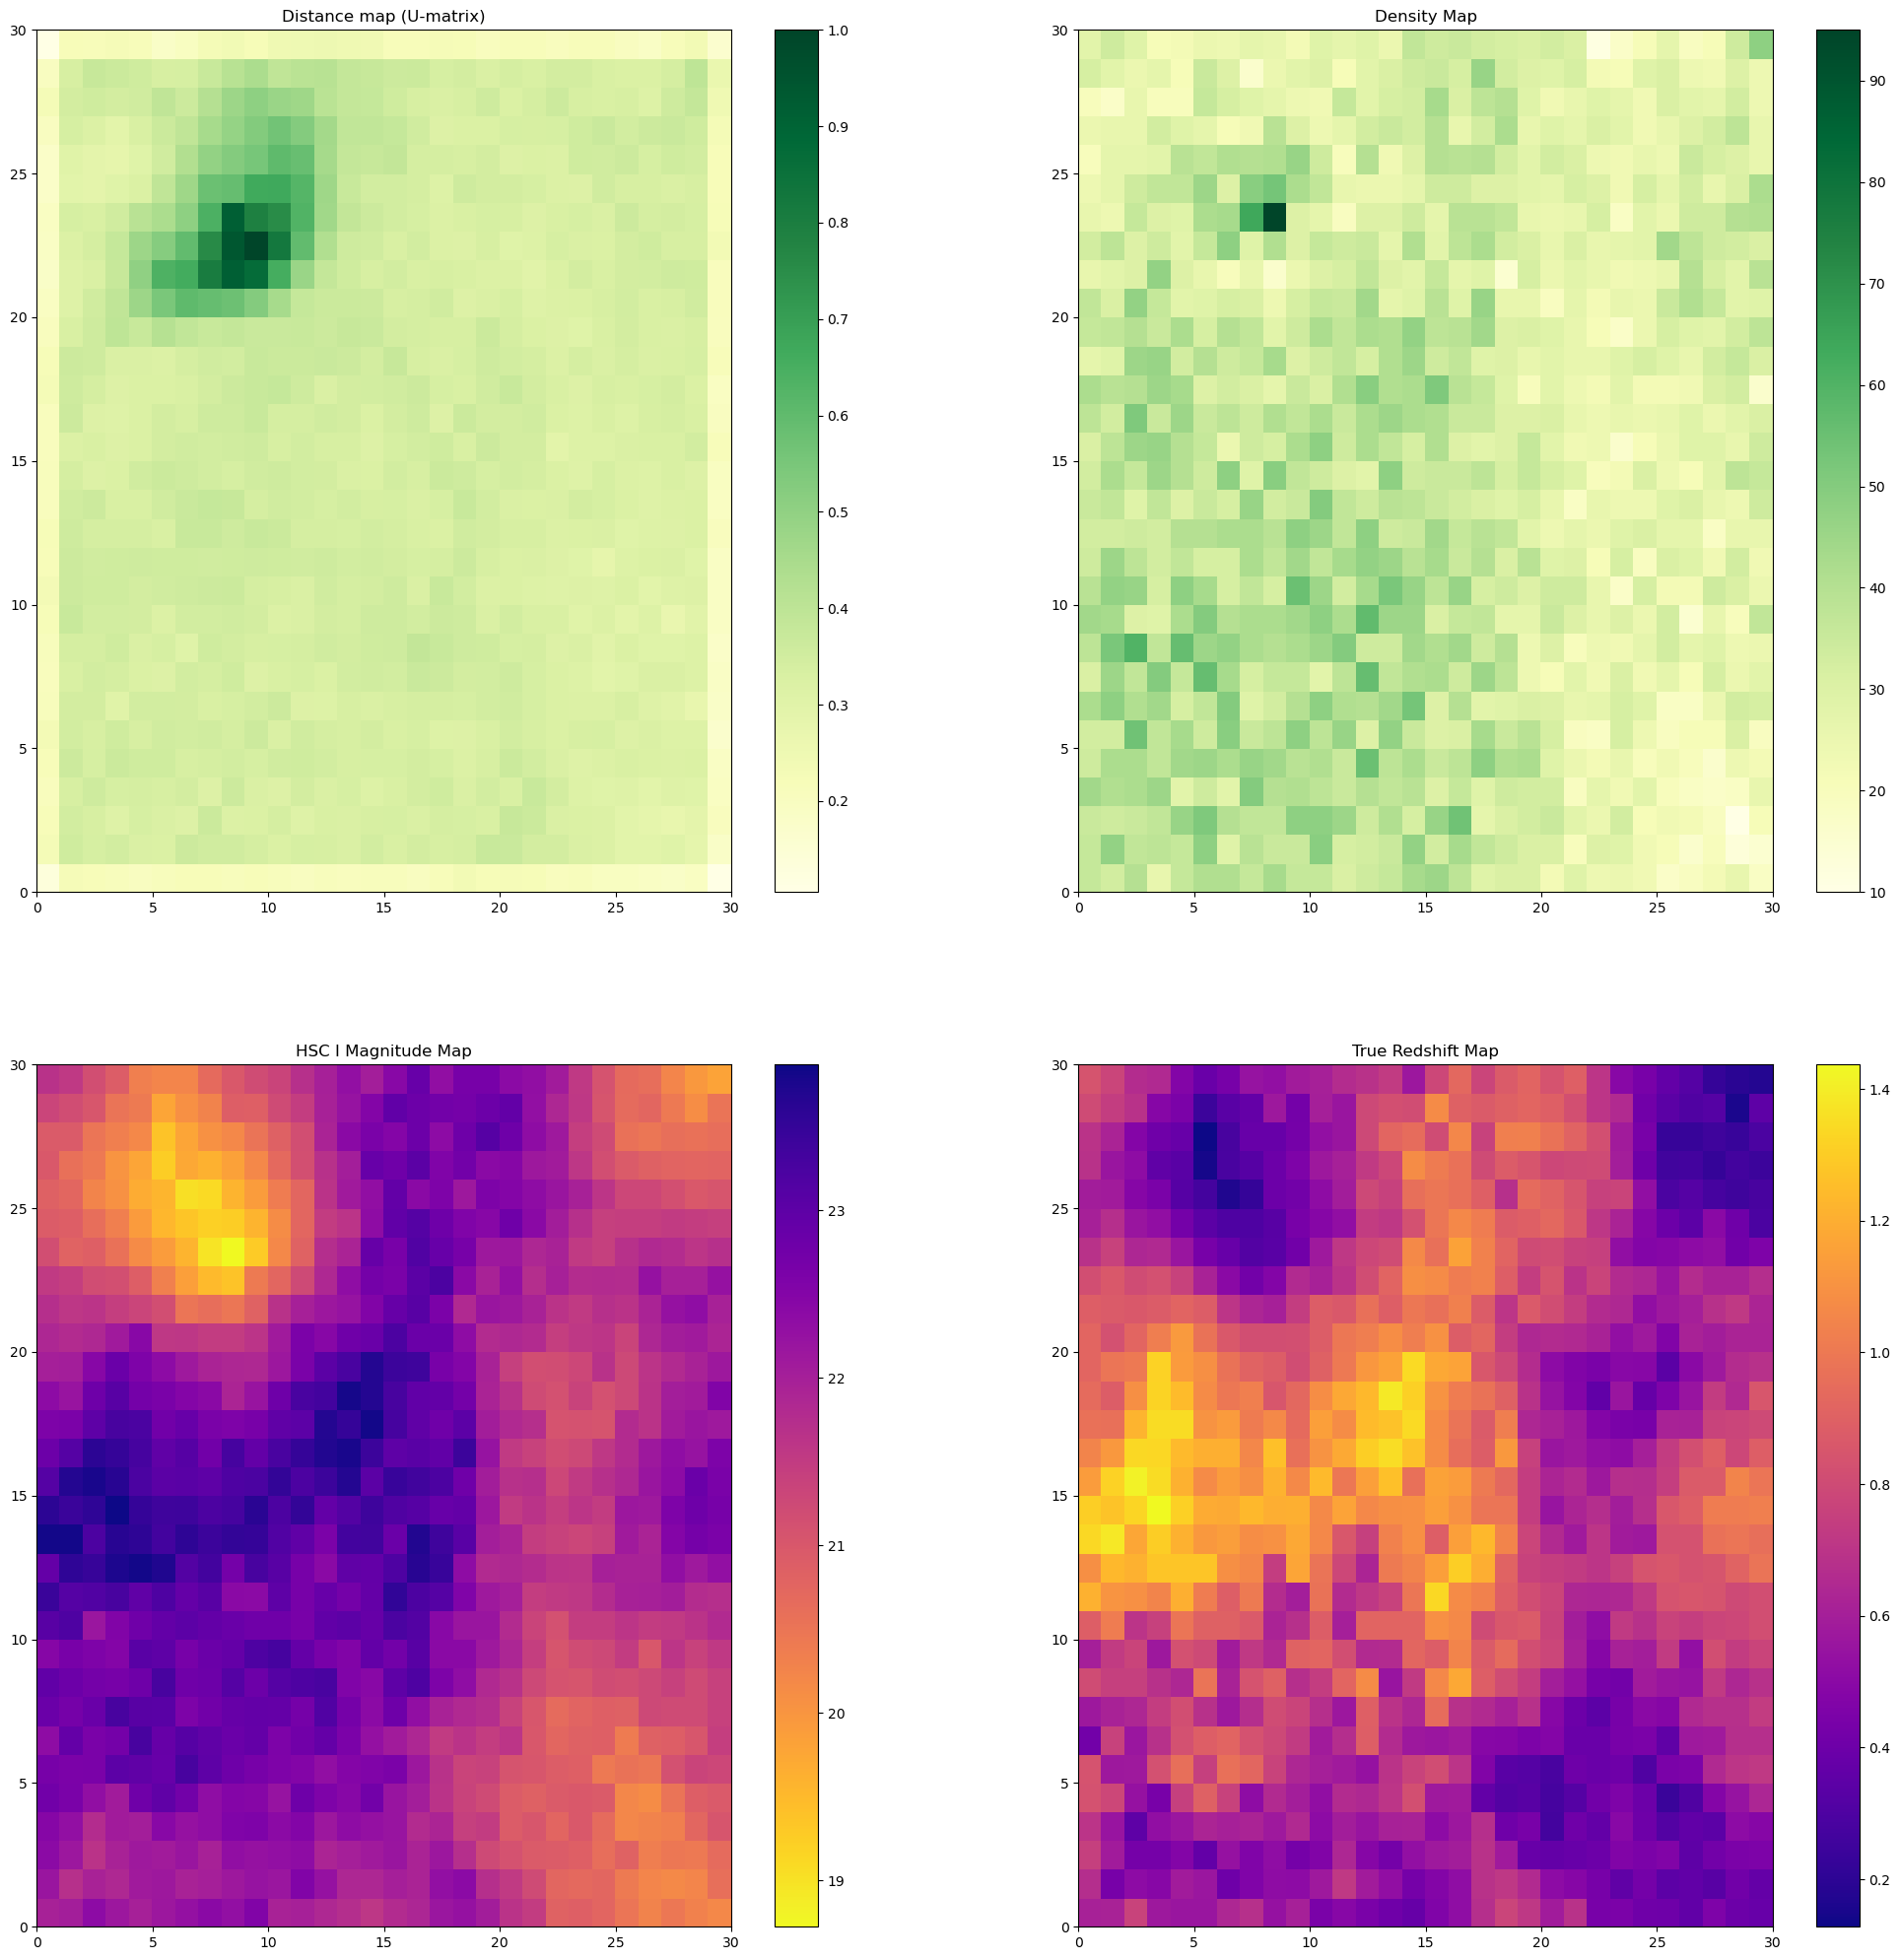

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.2]
29683.0
Topological error: 0.7502610922076609
Quantization error: 6.063662802146249
Average redshift std: 0.2973980729787814


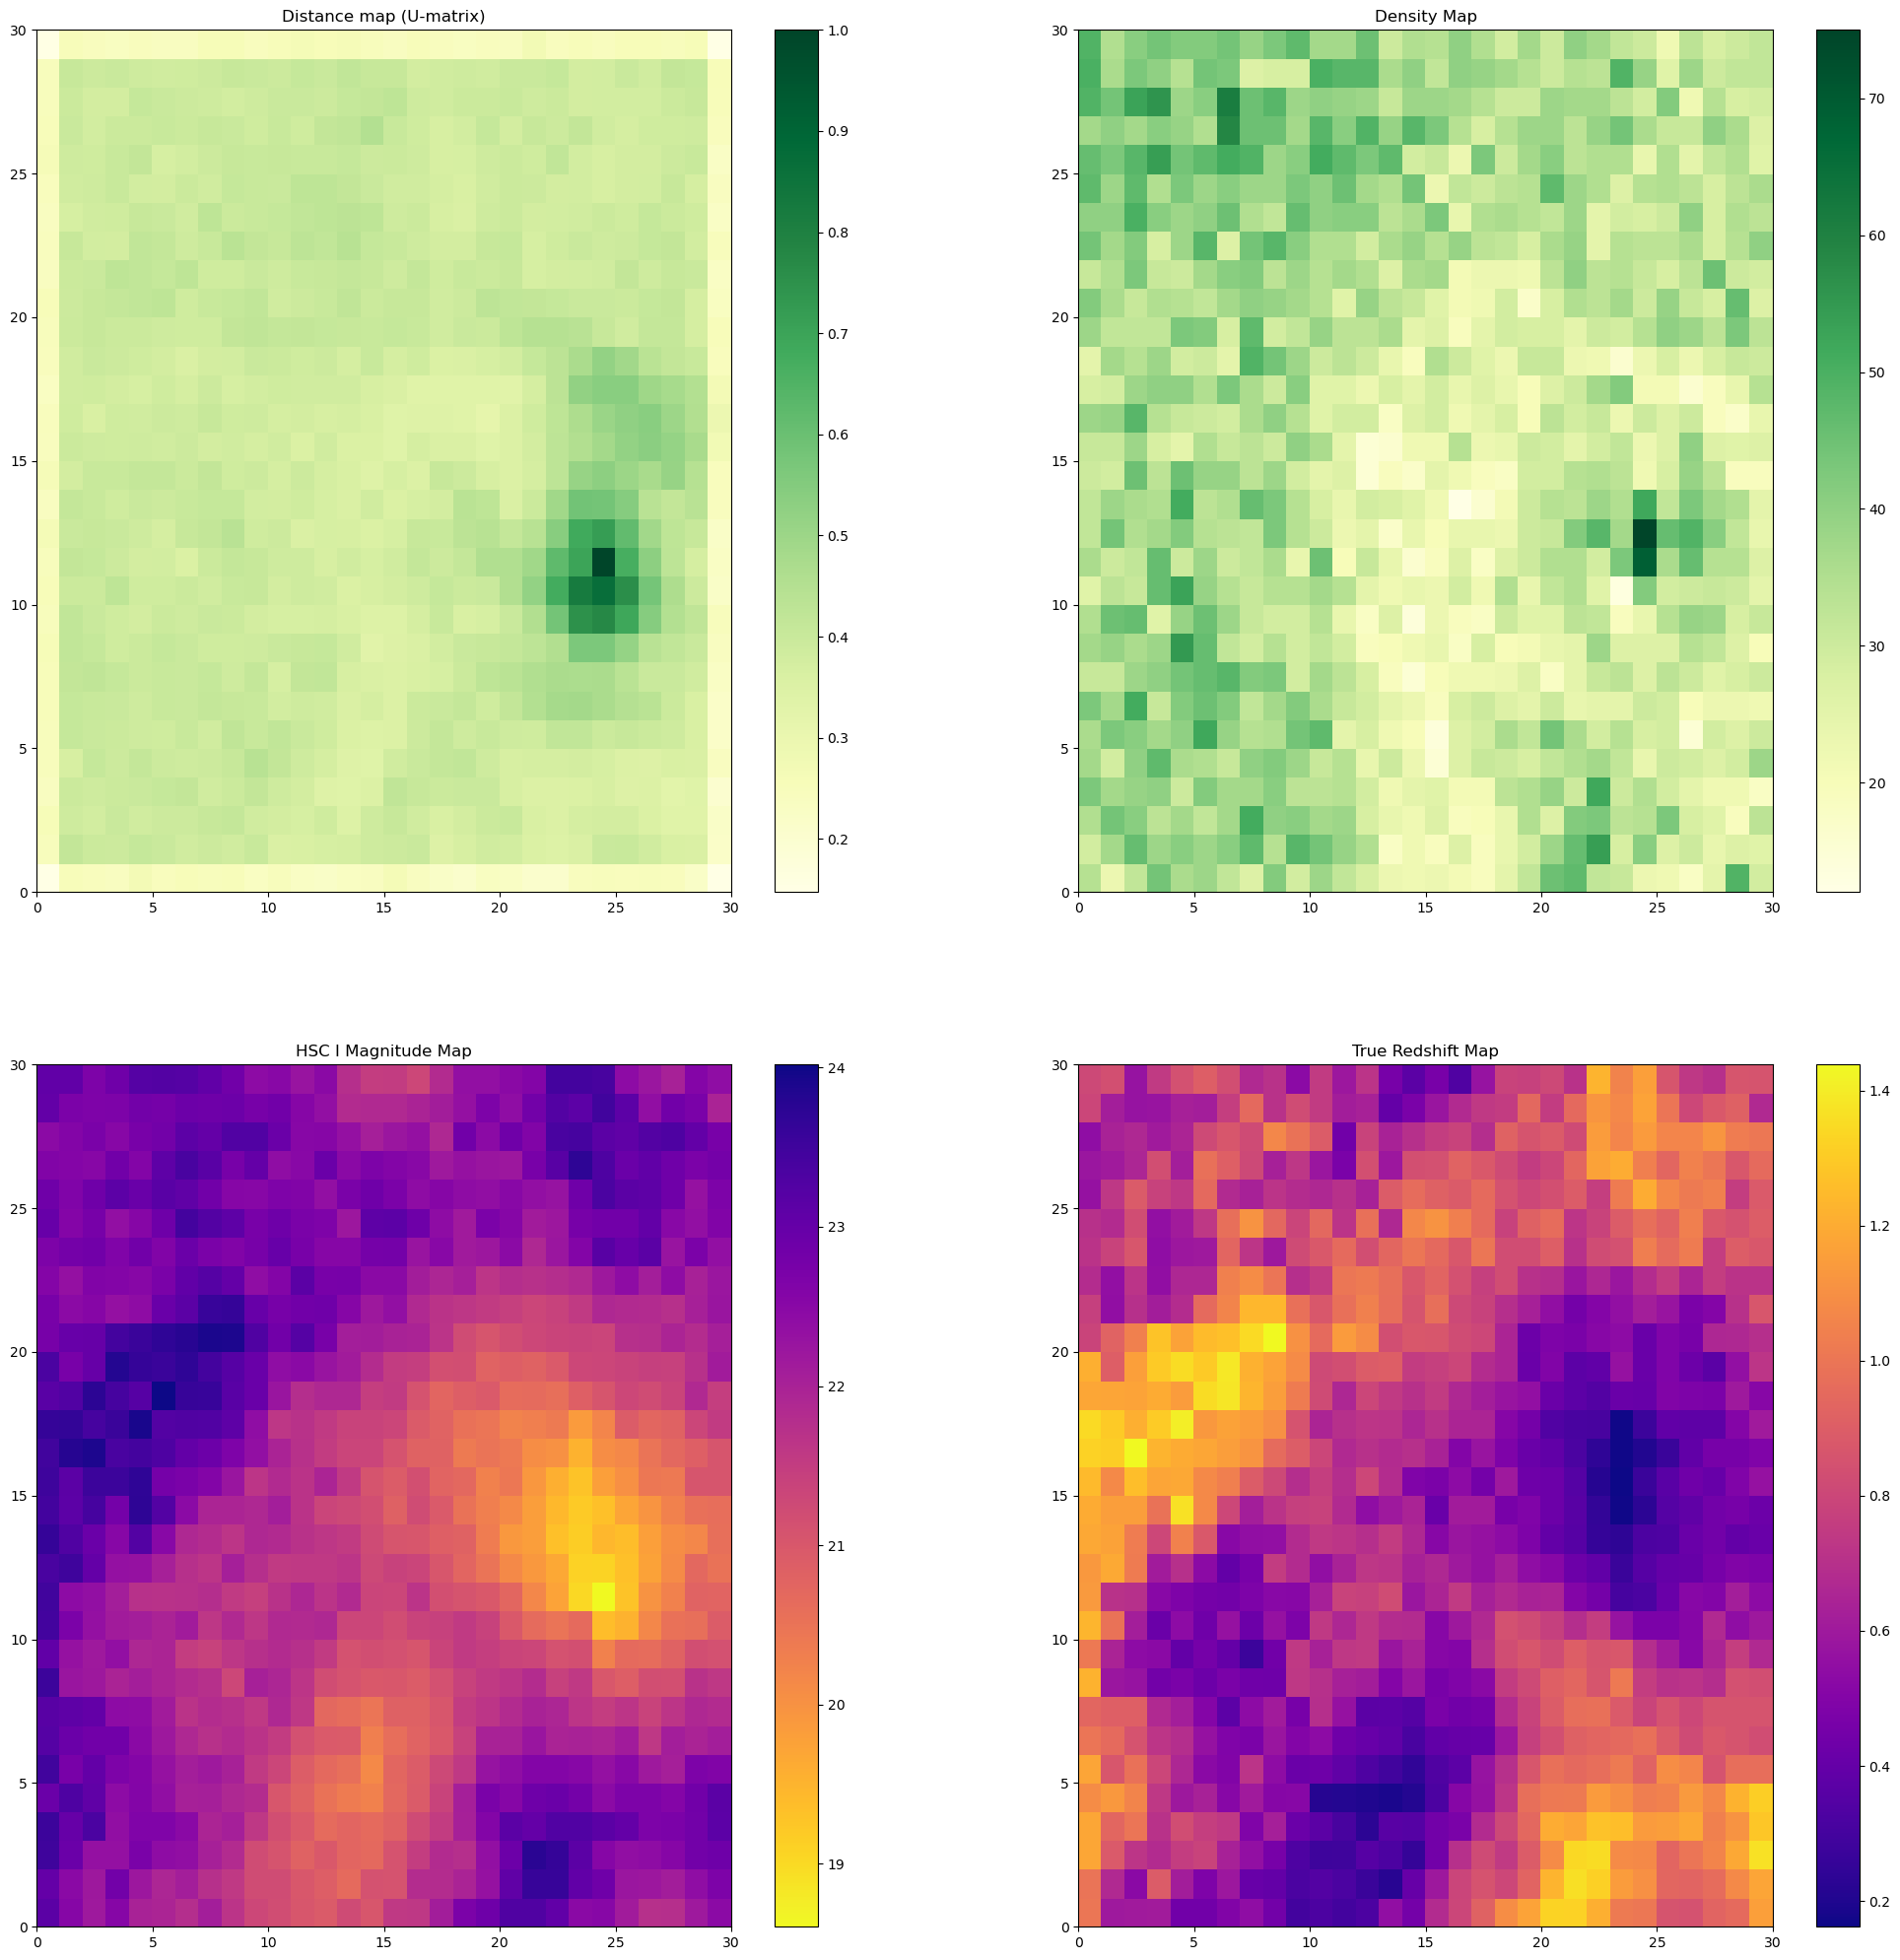

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.7, 0.2]
29683.0
Topological error: 0.8129906006805242
Quantization error: 6.068639813790447
Average redshift std: 0.2775982148381844


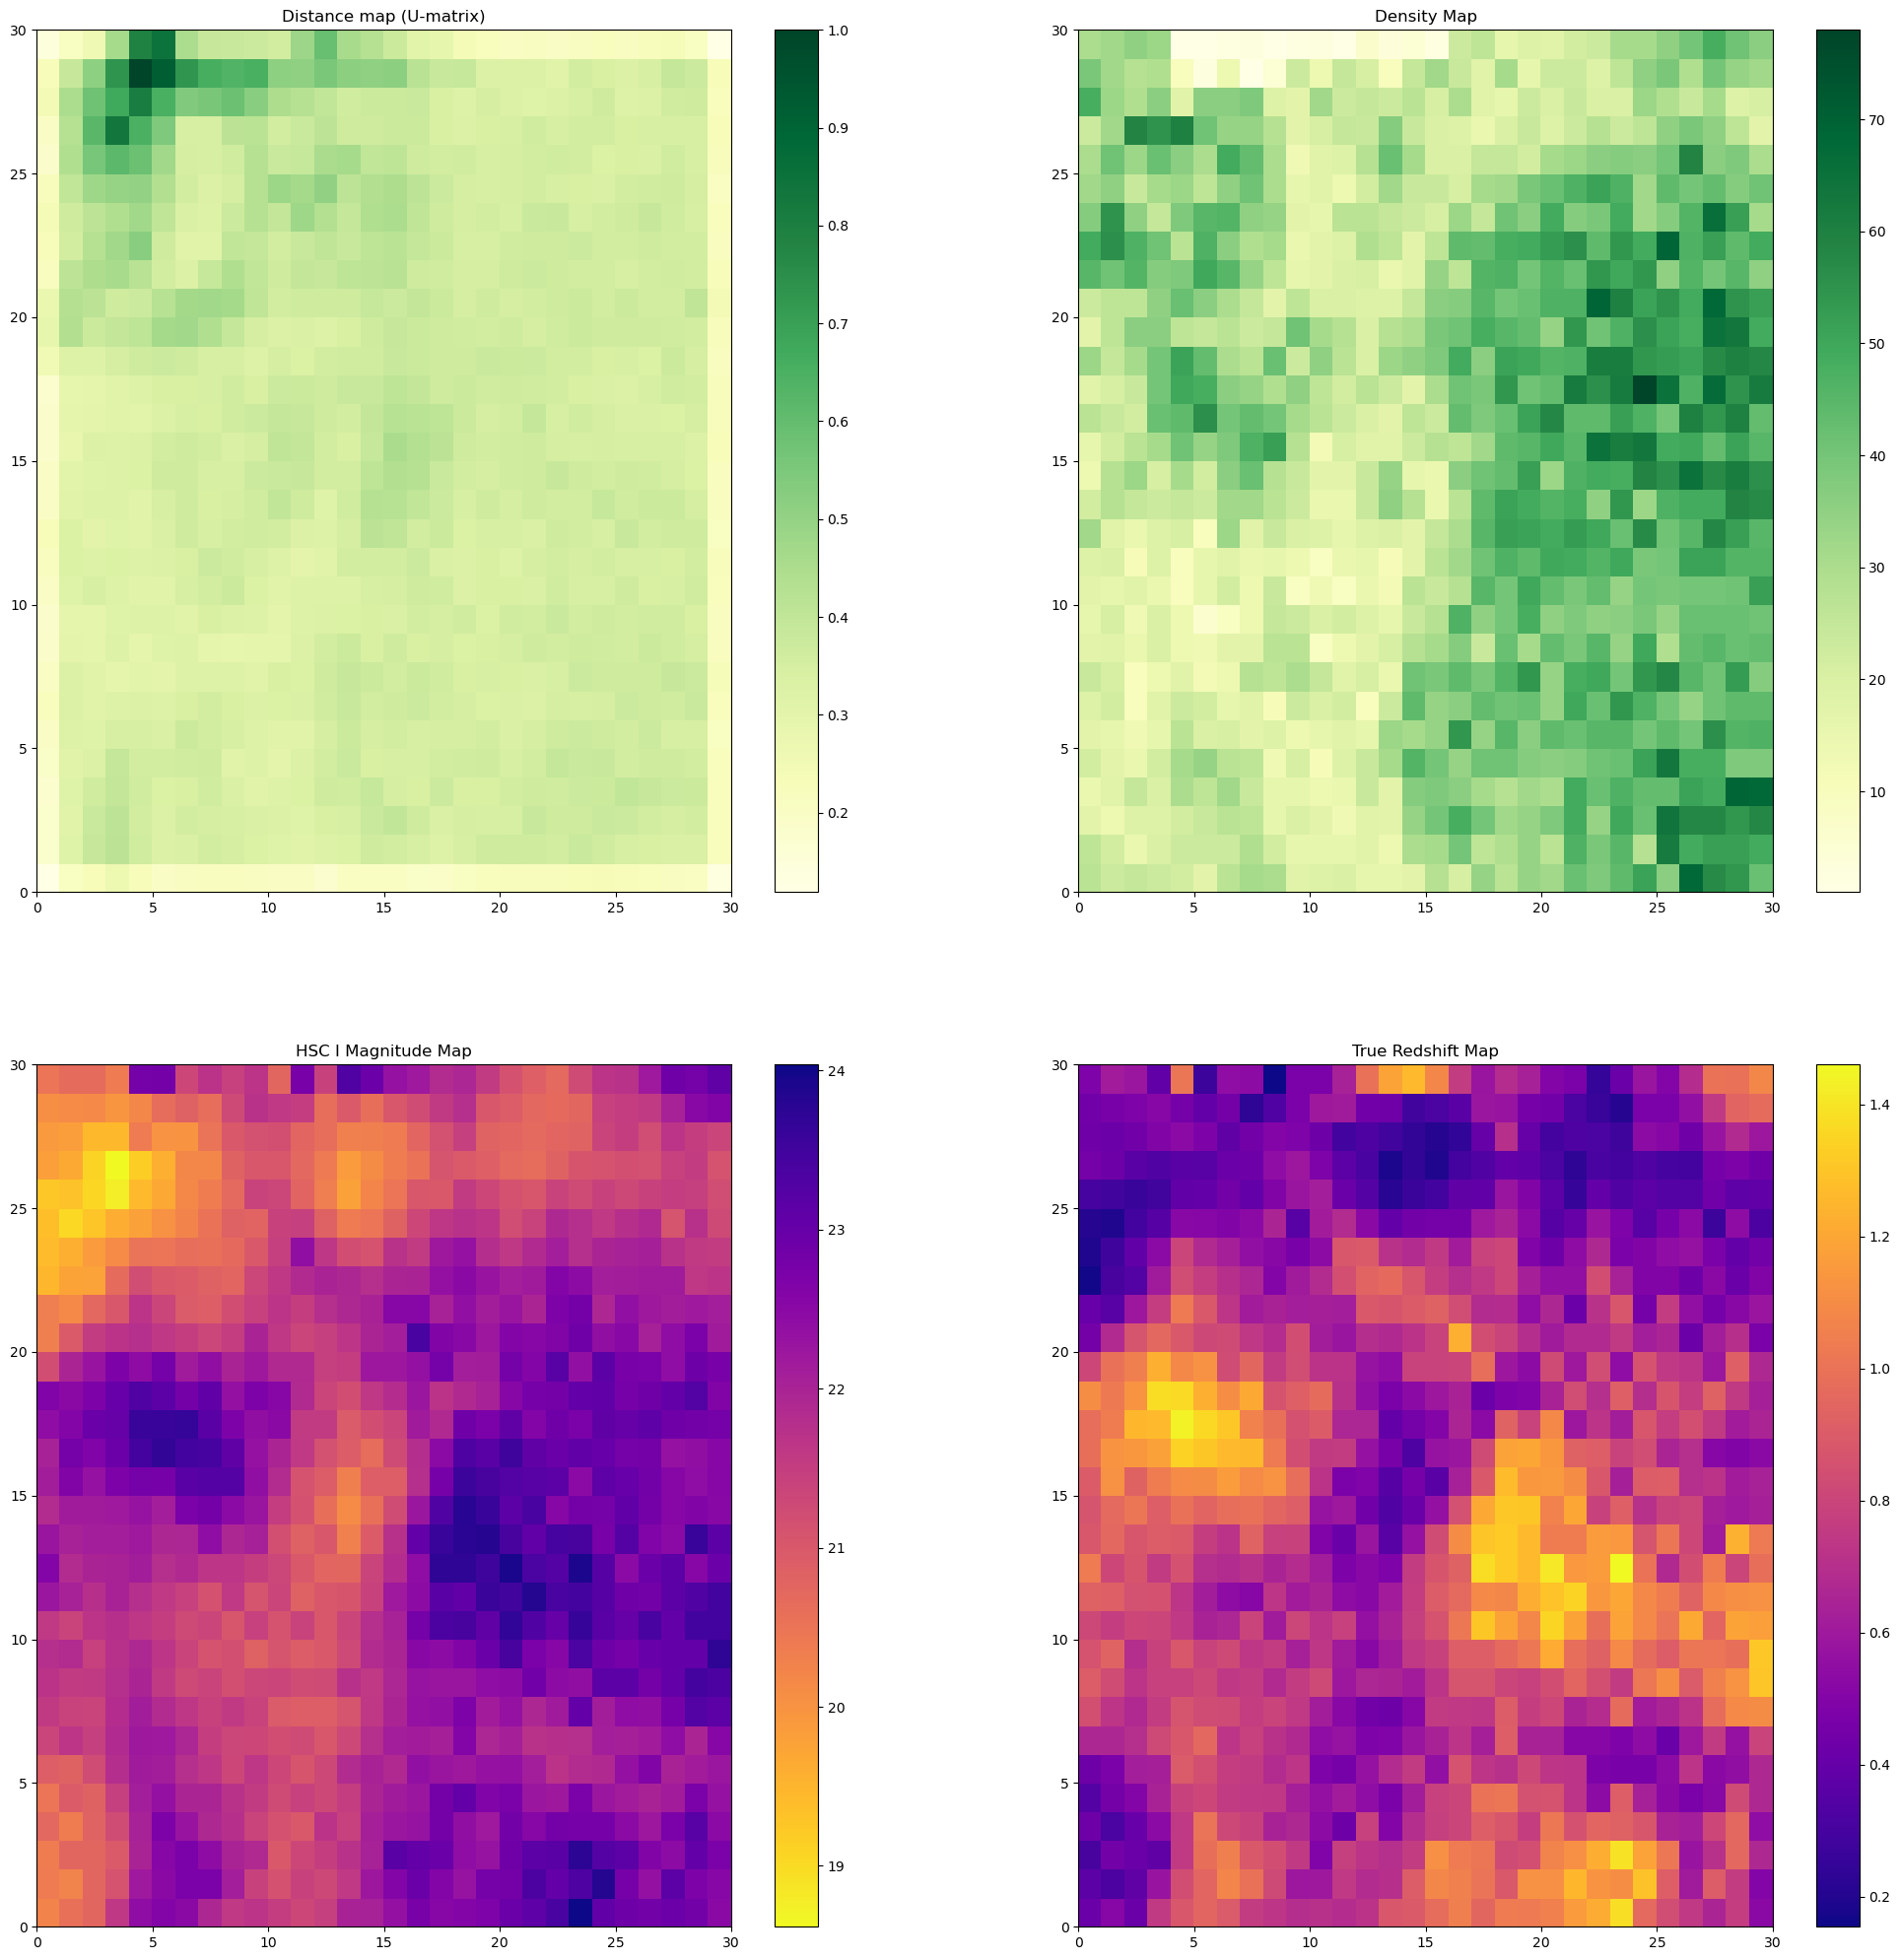

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 0.2]
29683.0
Topological error: 0.8581679749351481
Quantization error: 6.086342400899937
Average redshift std: 0.27270604454129715


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


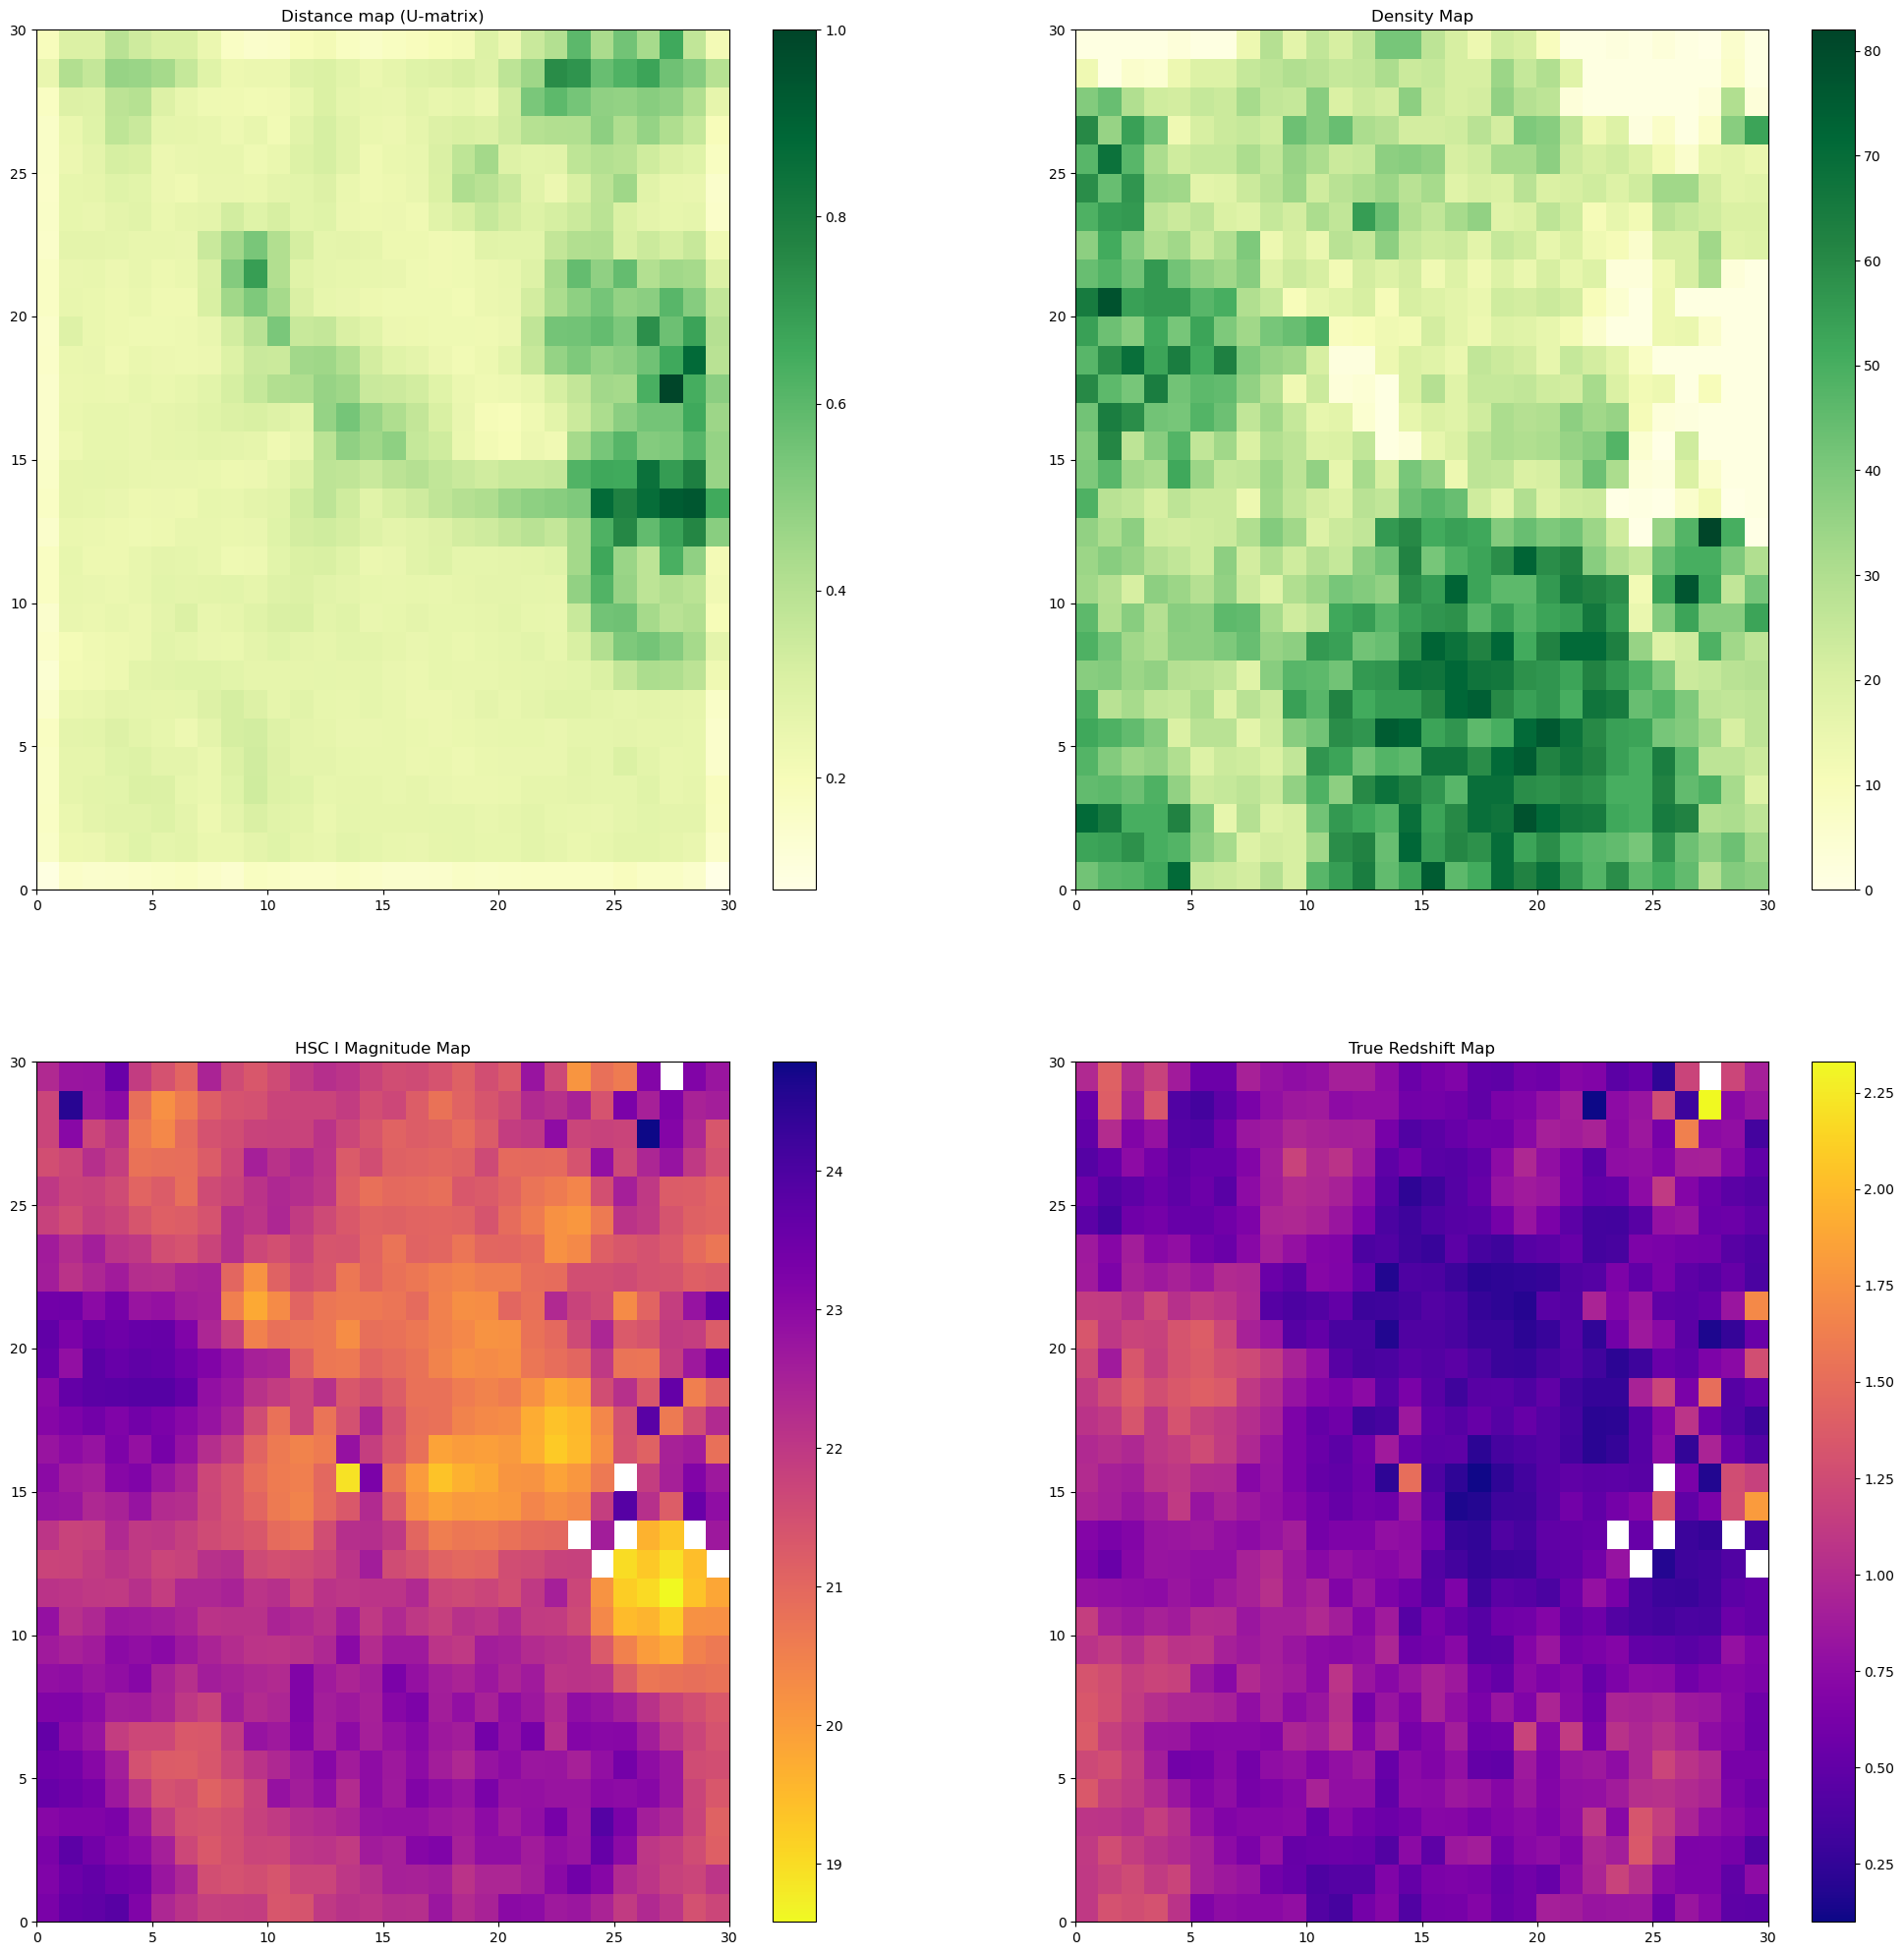

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.2]
29683.0
Topological error: 0.9066132129501735
Quantization error: 6.111346285227273
Average redshift std: 0.2731038003295821


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


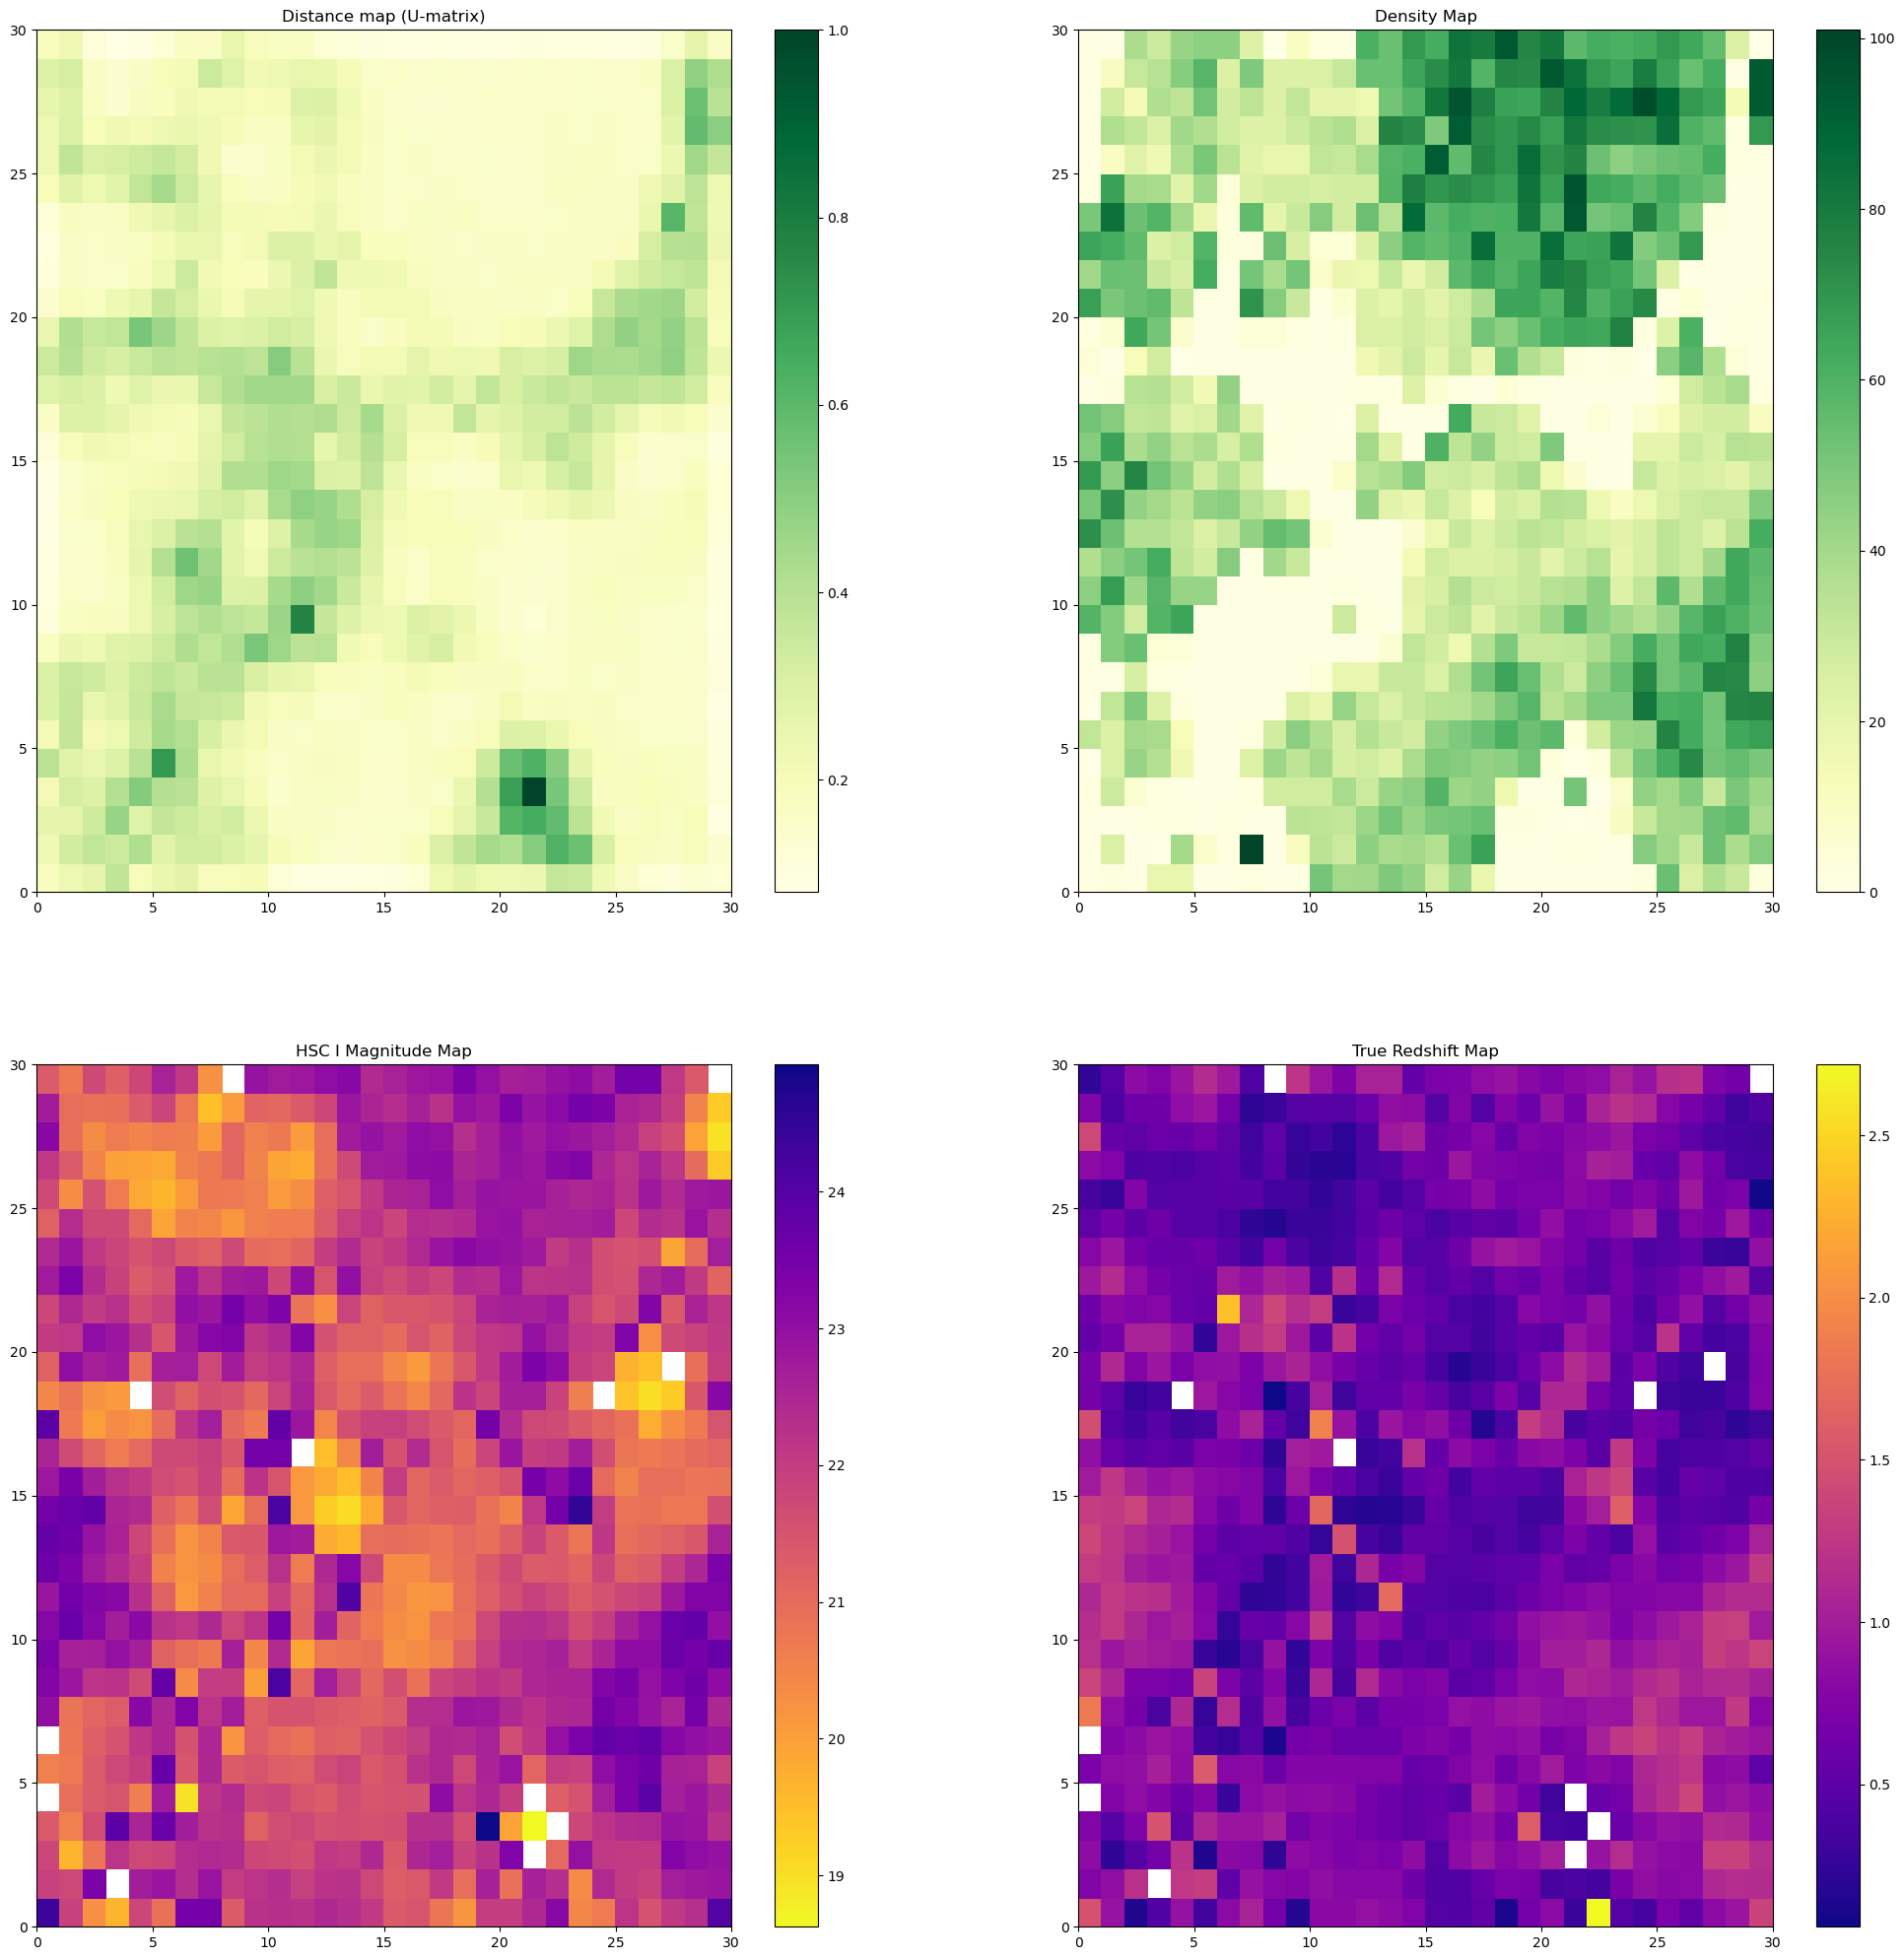

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.2]
29683.0
Topological error: 0.9436377724623521
Quantization error: 6.141689681787089
Average redshift std: 0.2904241907037324


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12148\4279944397.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


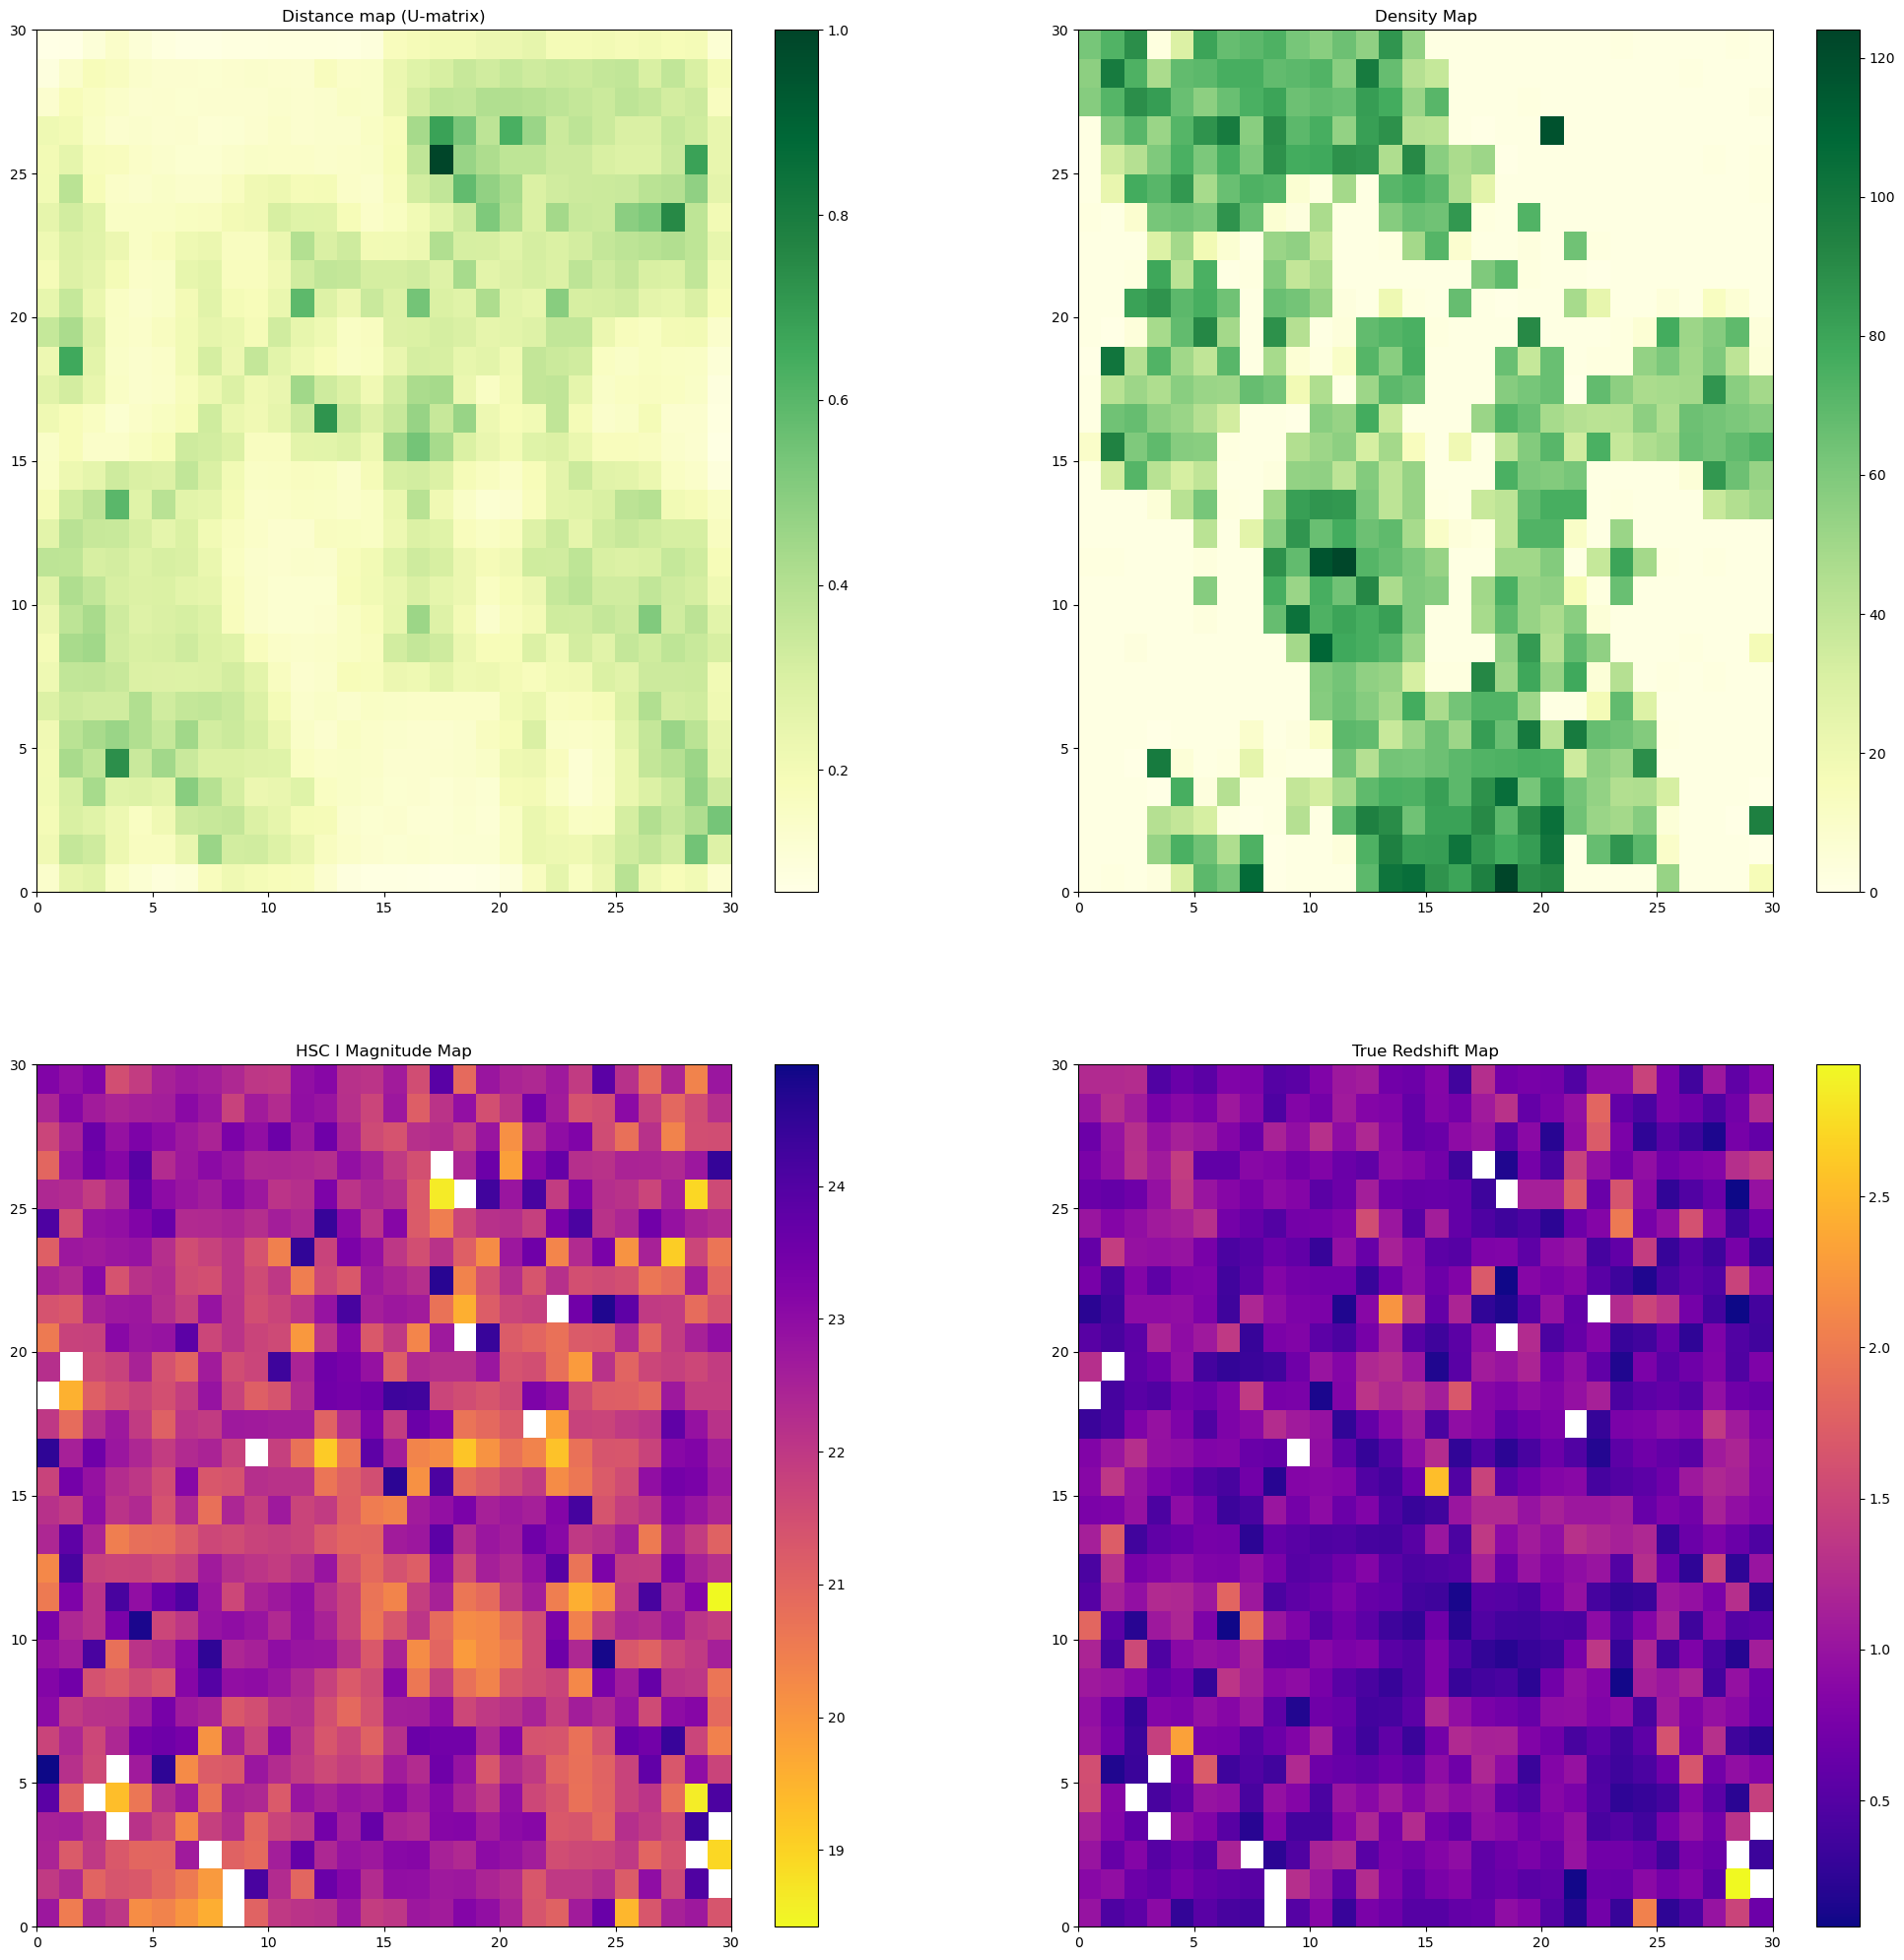

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.3]
29683.0
Topological error: 0.6591314894047098
Quantization error: 6.128126356942289
Average redshift std: 0.3100670194680568


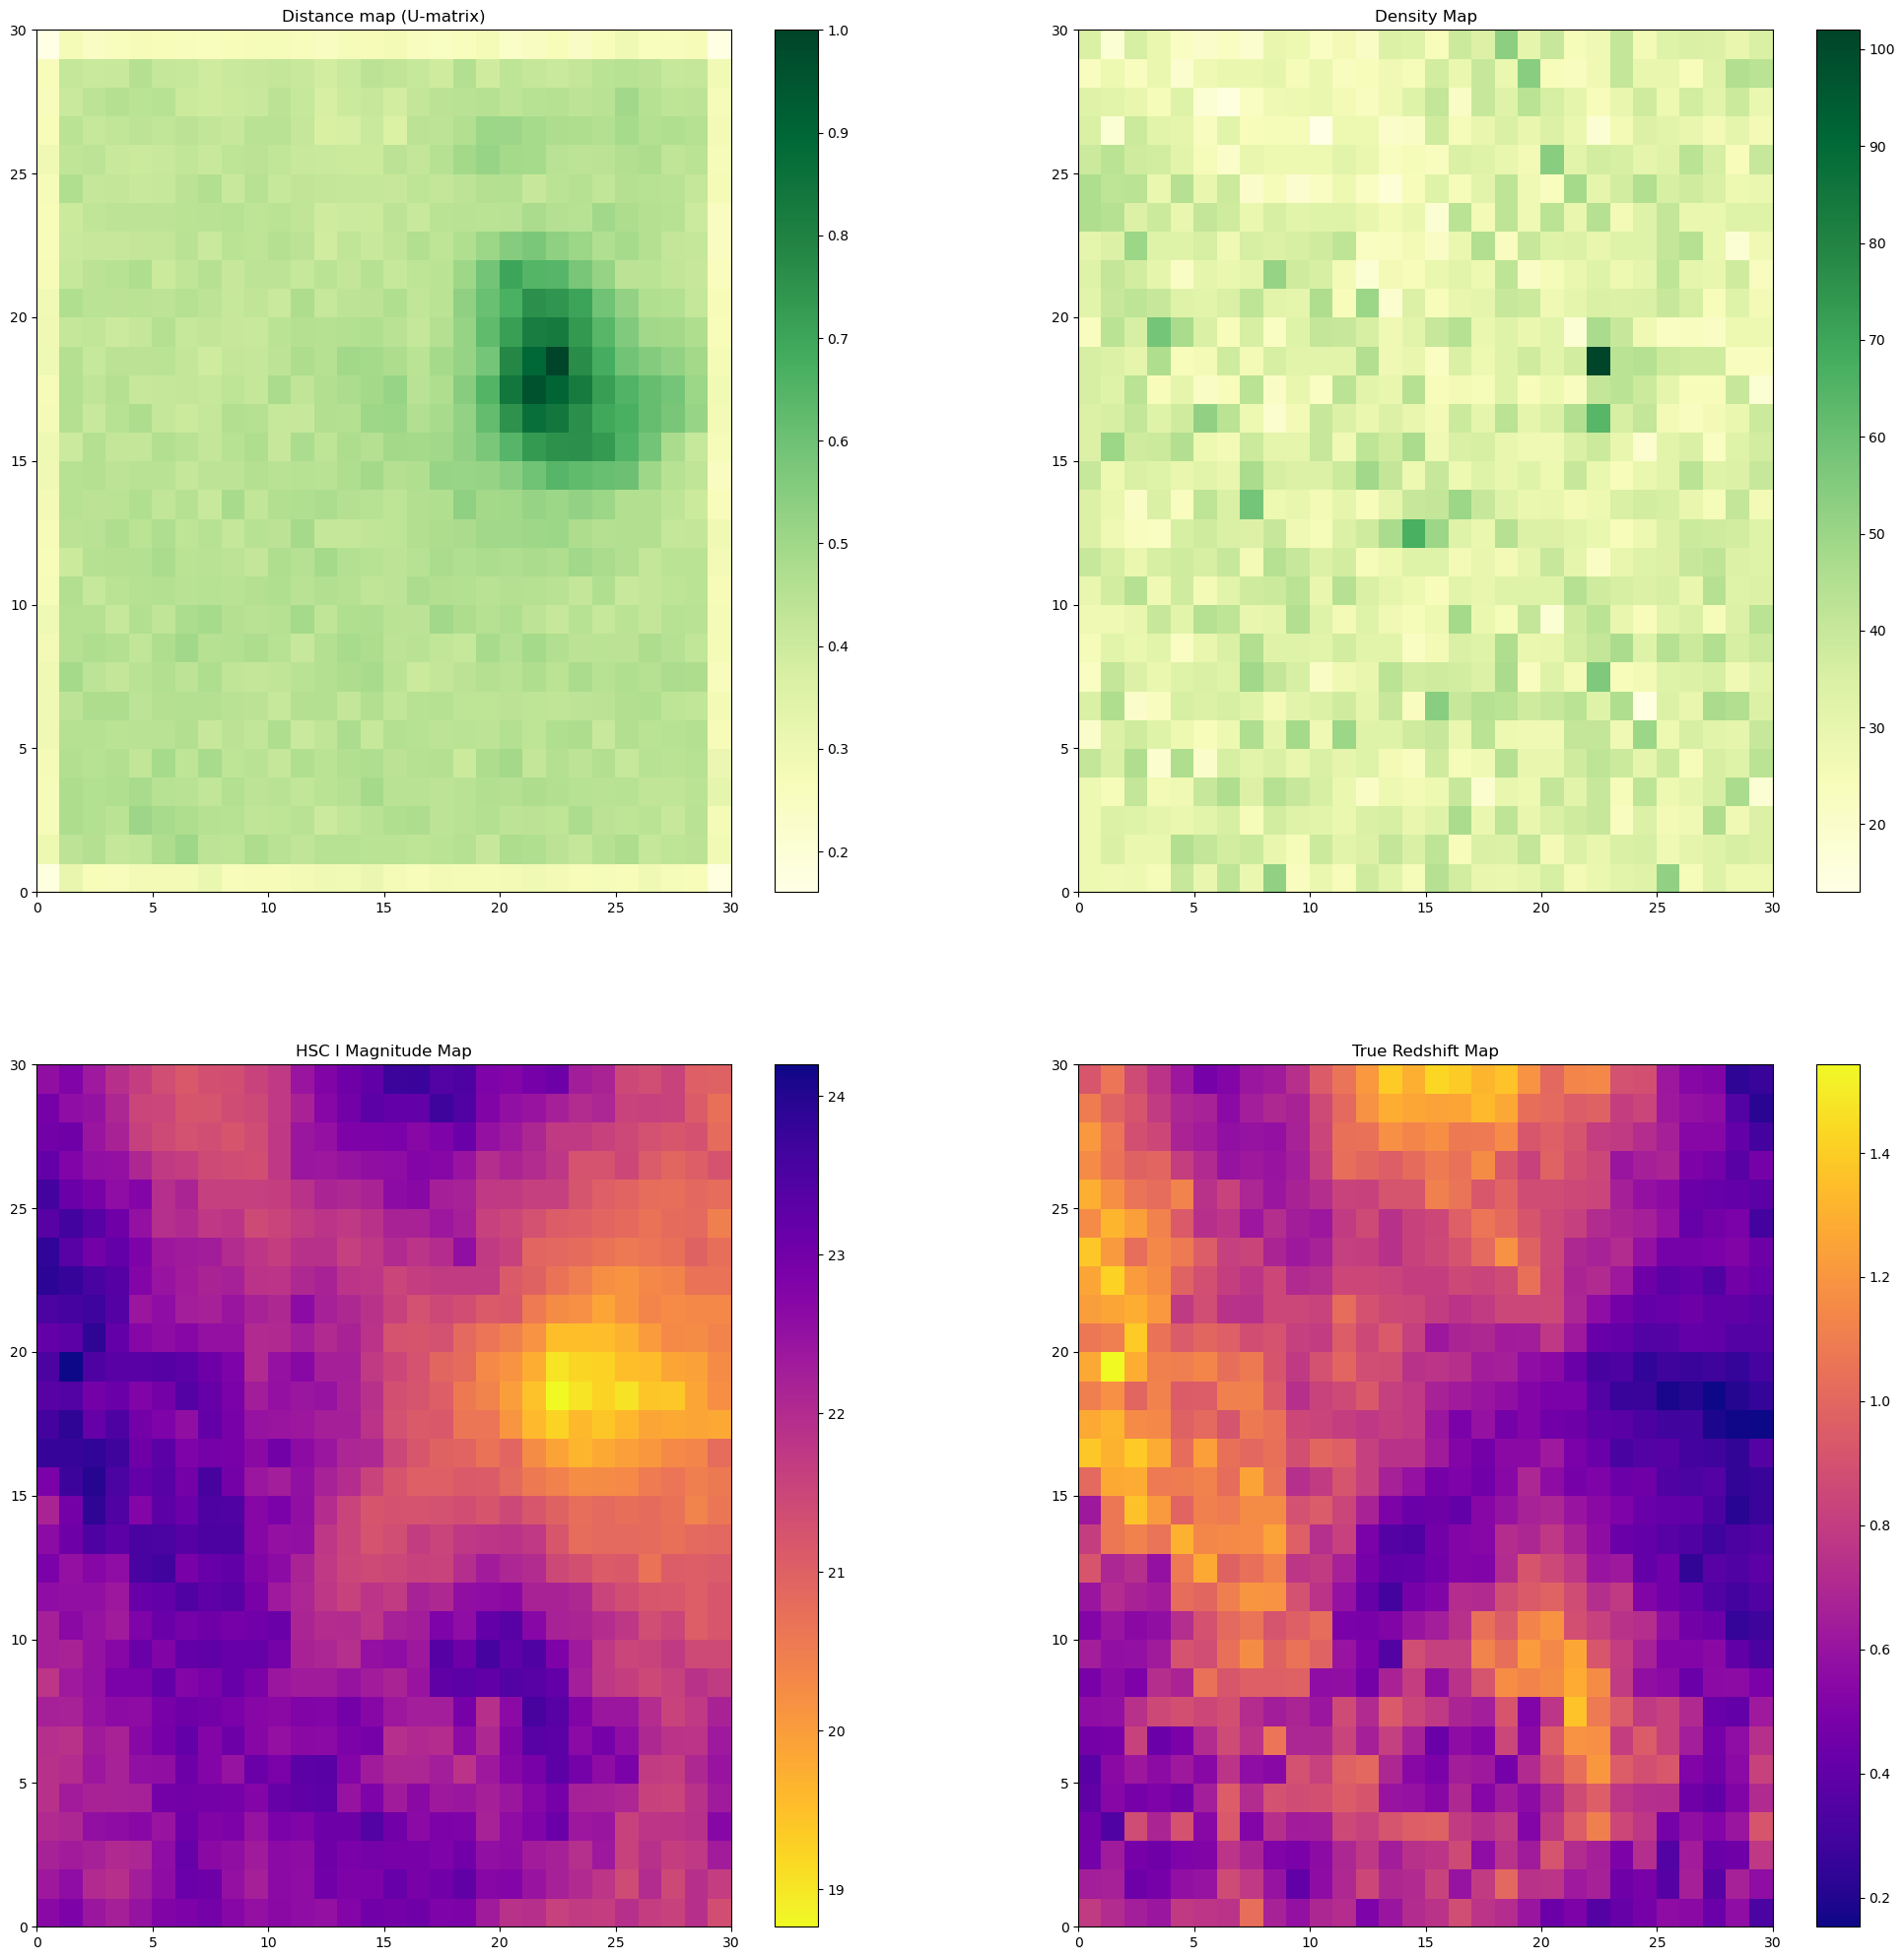

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.3]
29683.0
Topological error: 0.7180204157261733
Quantization error: 6.111807647614379
Average redshift std: 0.3187573500012444


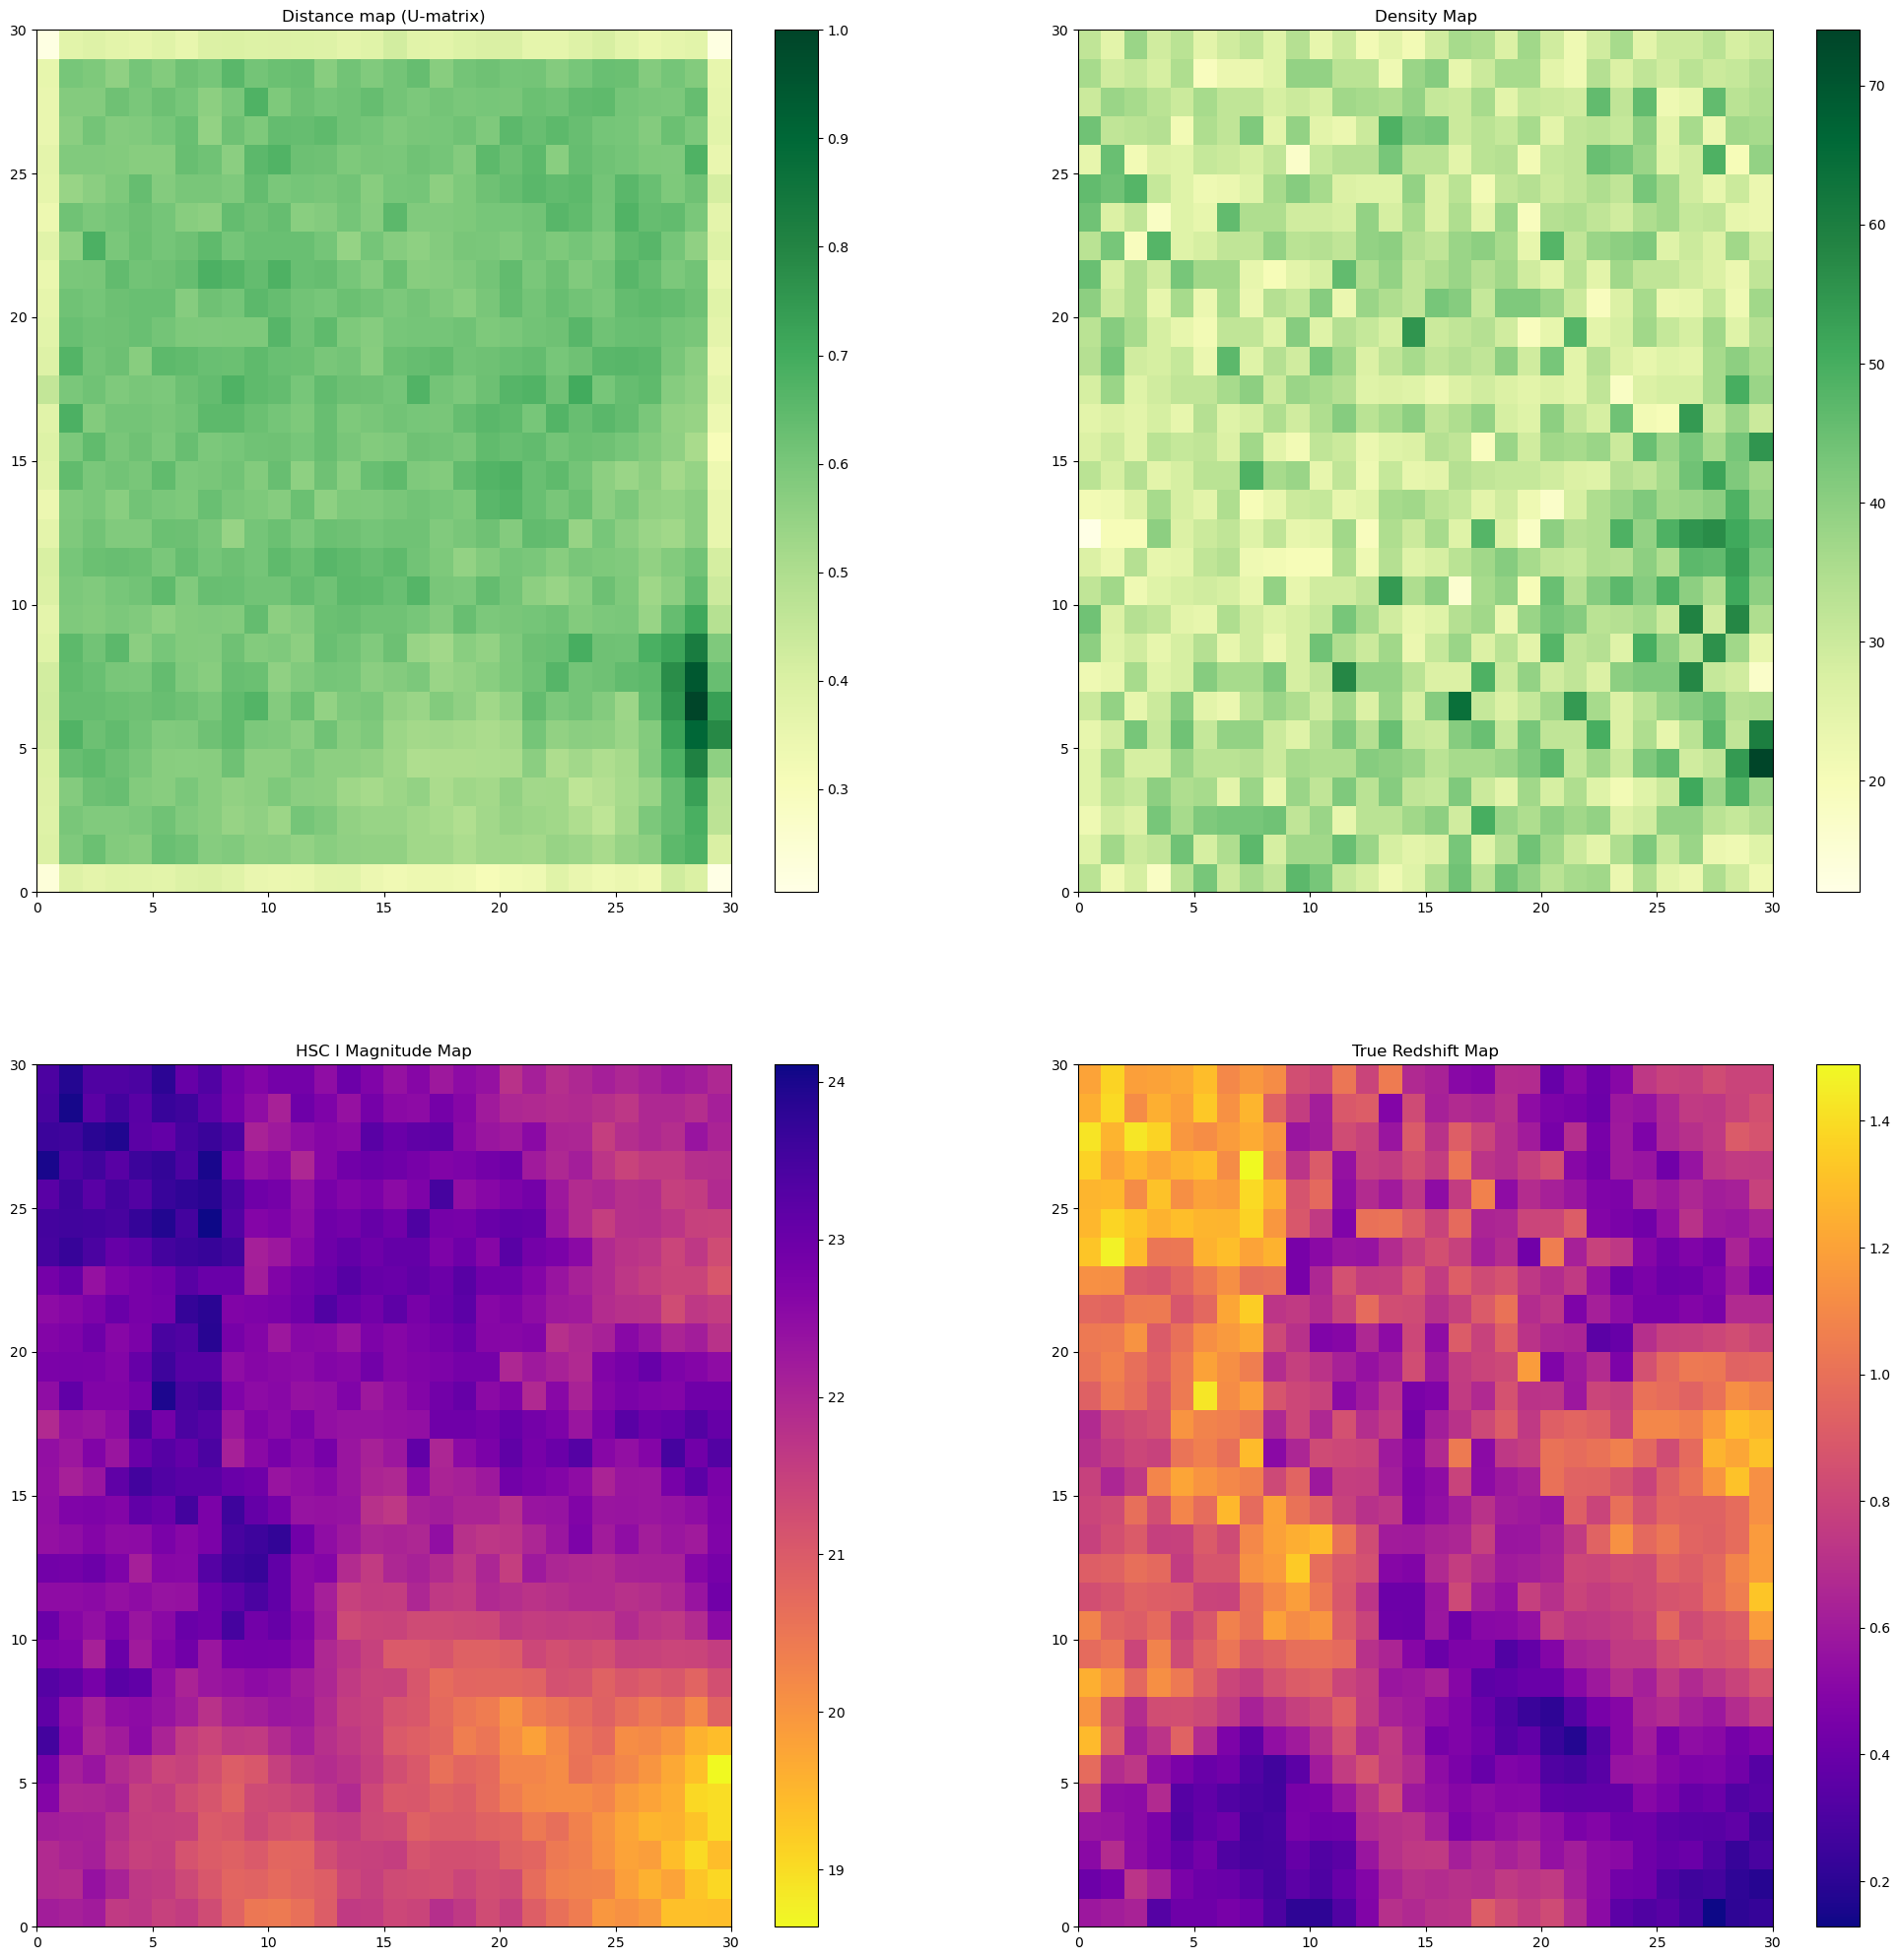

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.3]
29683.0
Topological error: 0.7890038068928343
Quantization error: 6.106695972806719
Average redshift std: 0.3179504481522722


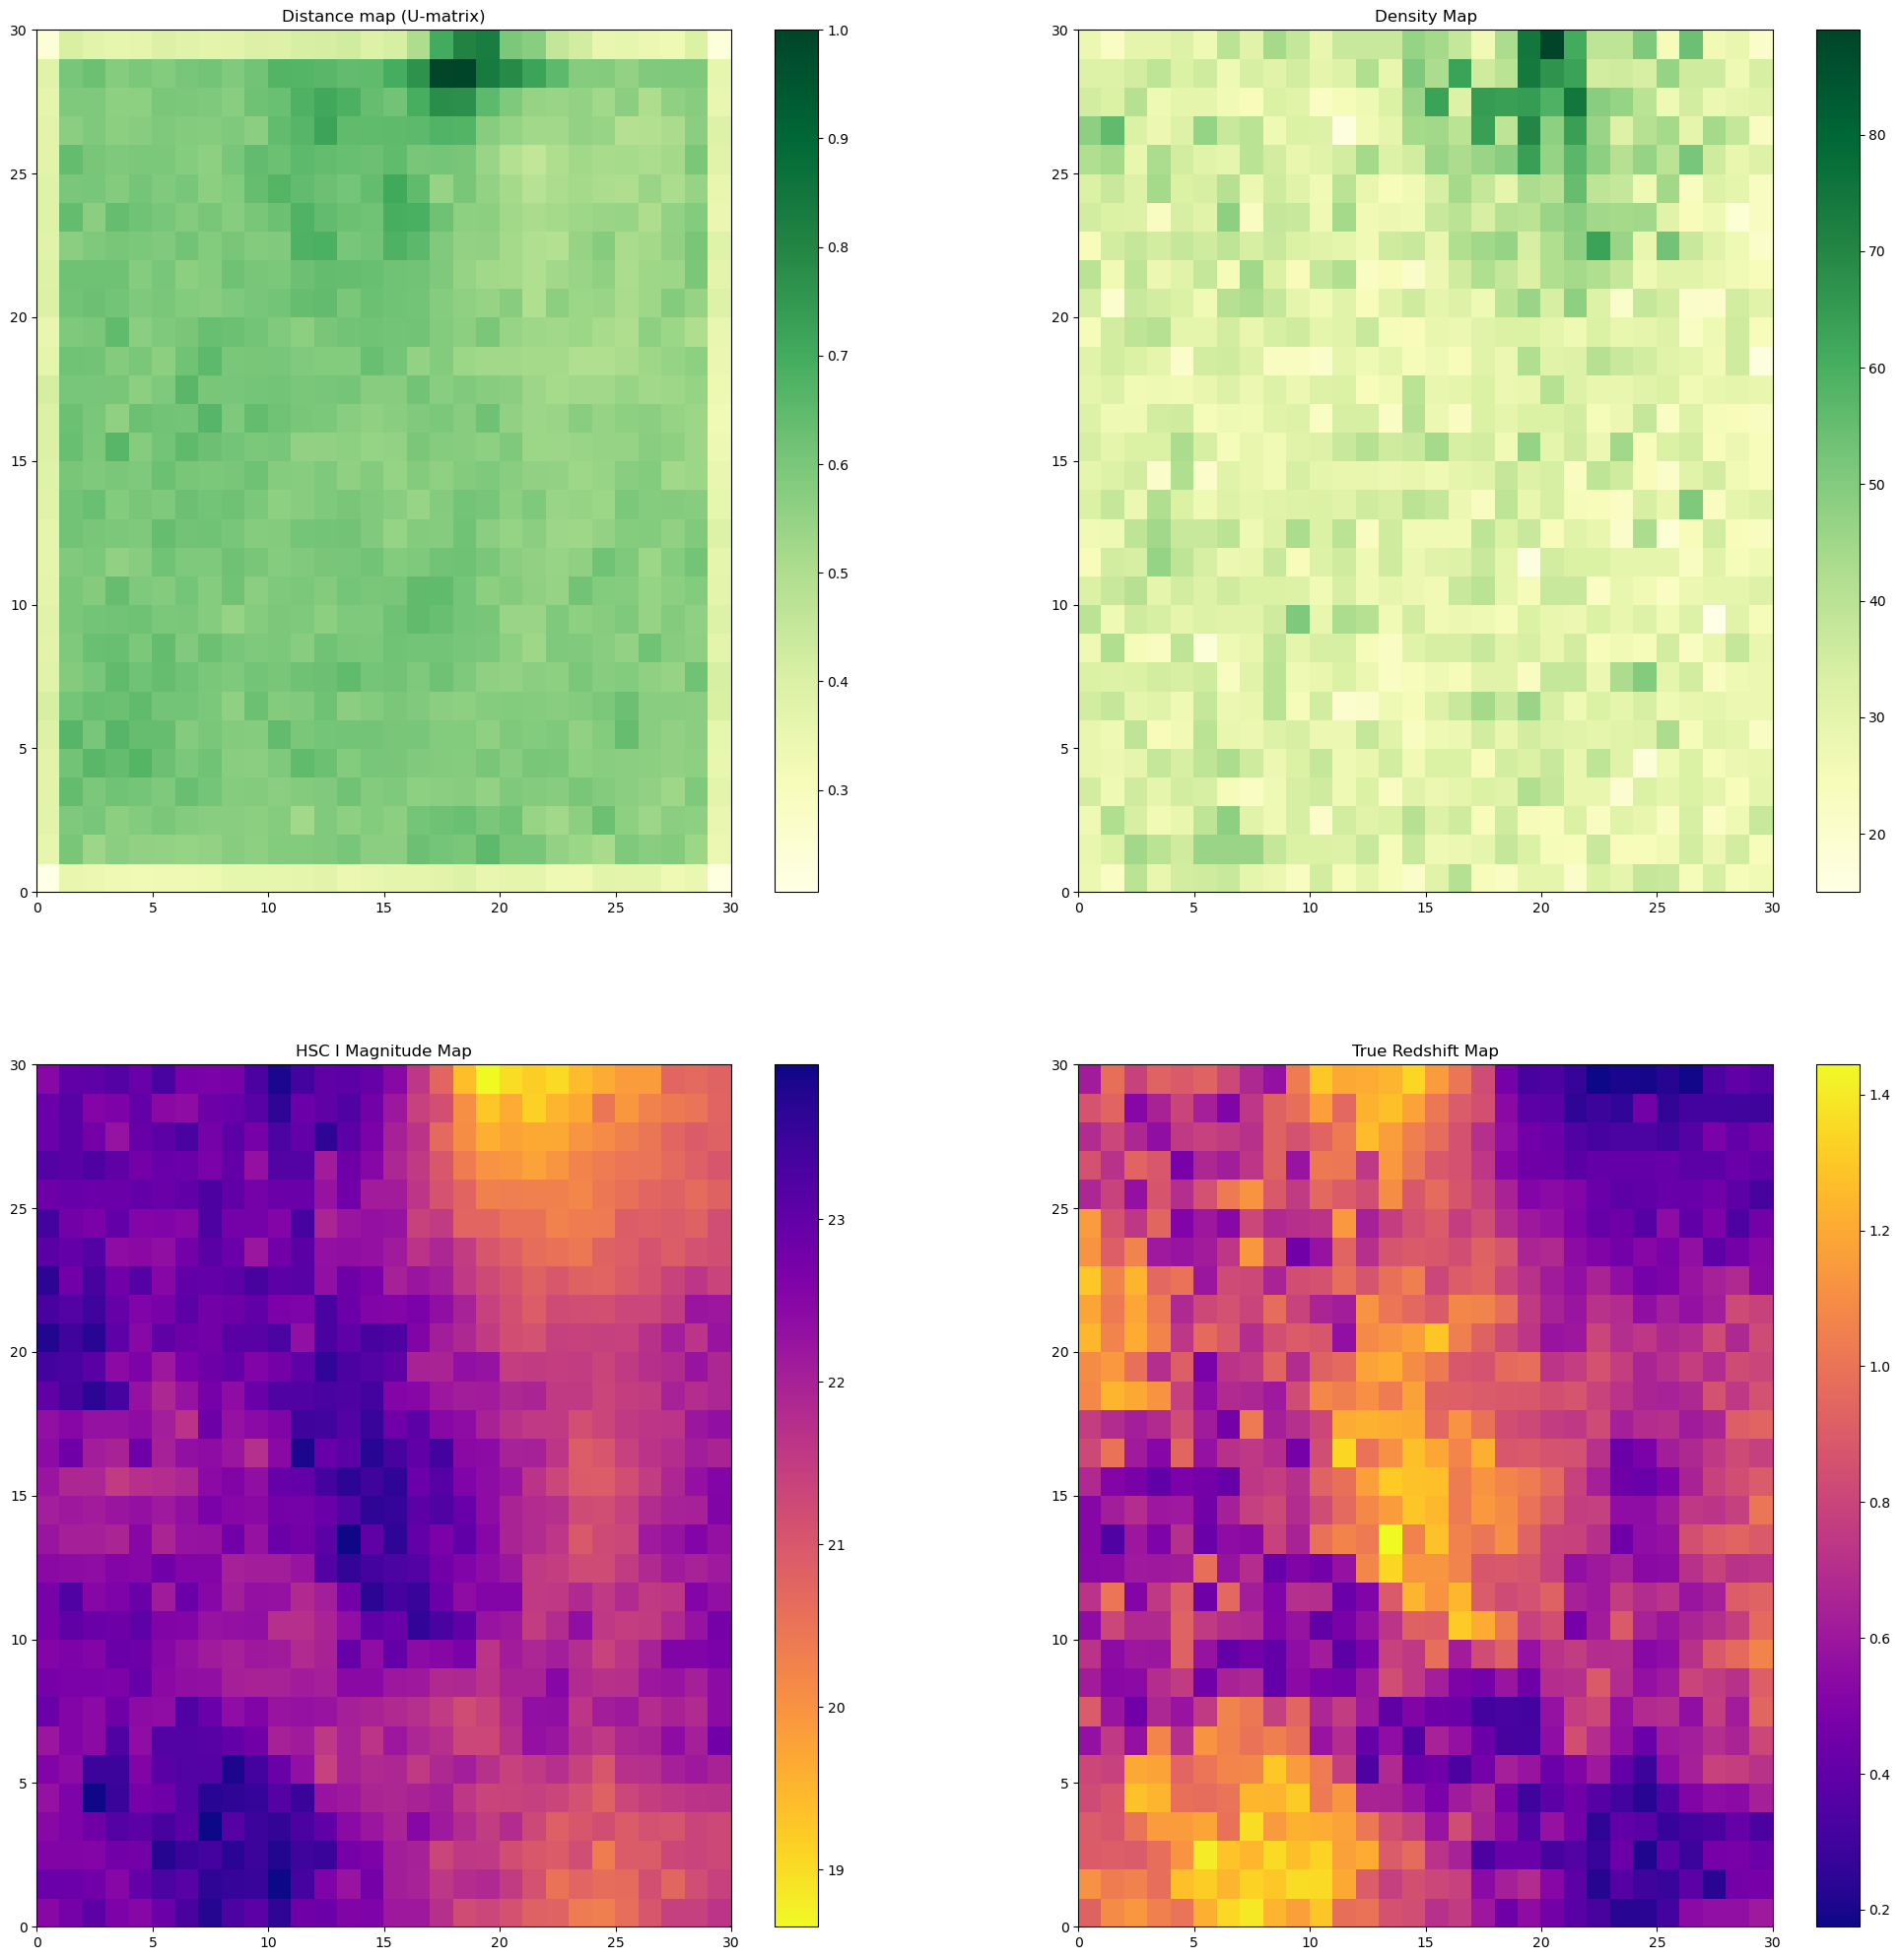

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.3]
29683.0
Topological error: 0.8703635077316982
Quantization error: 6.11182600907604
Average redshift std: 0.3010077976302141


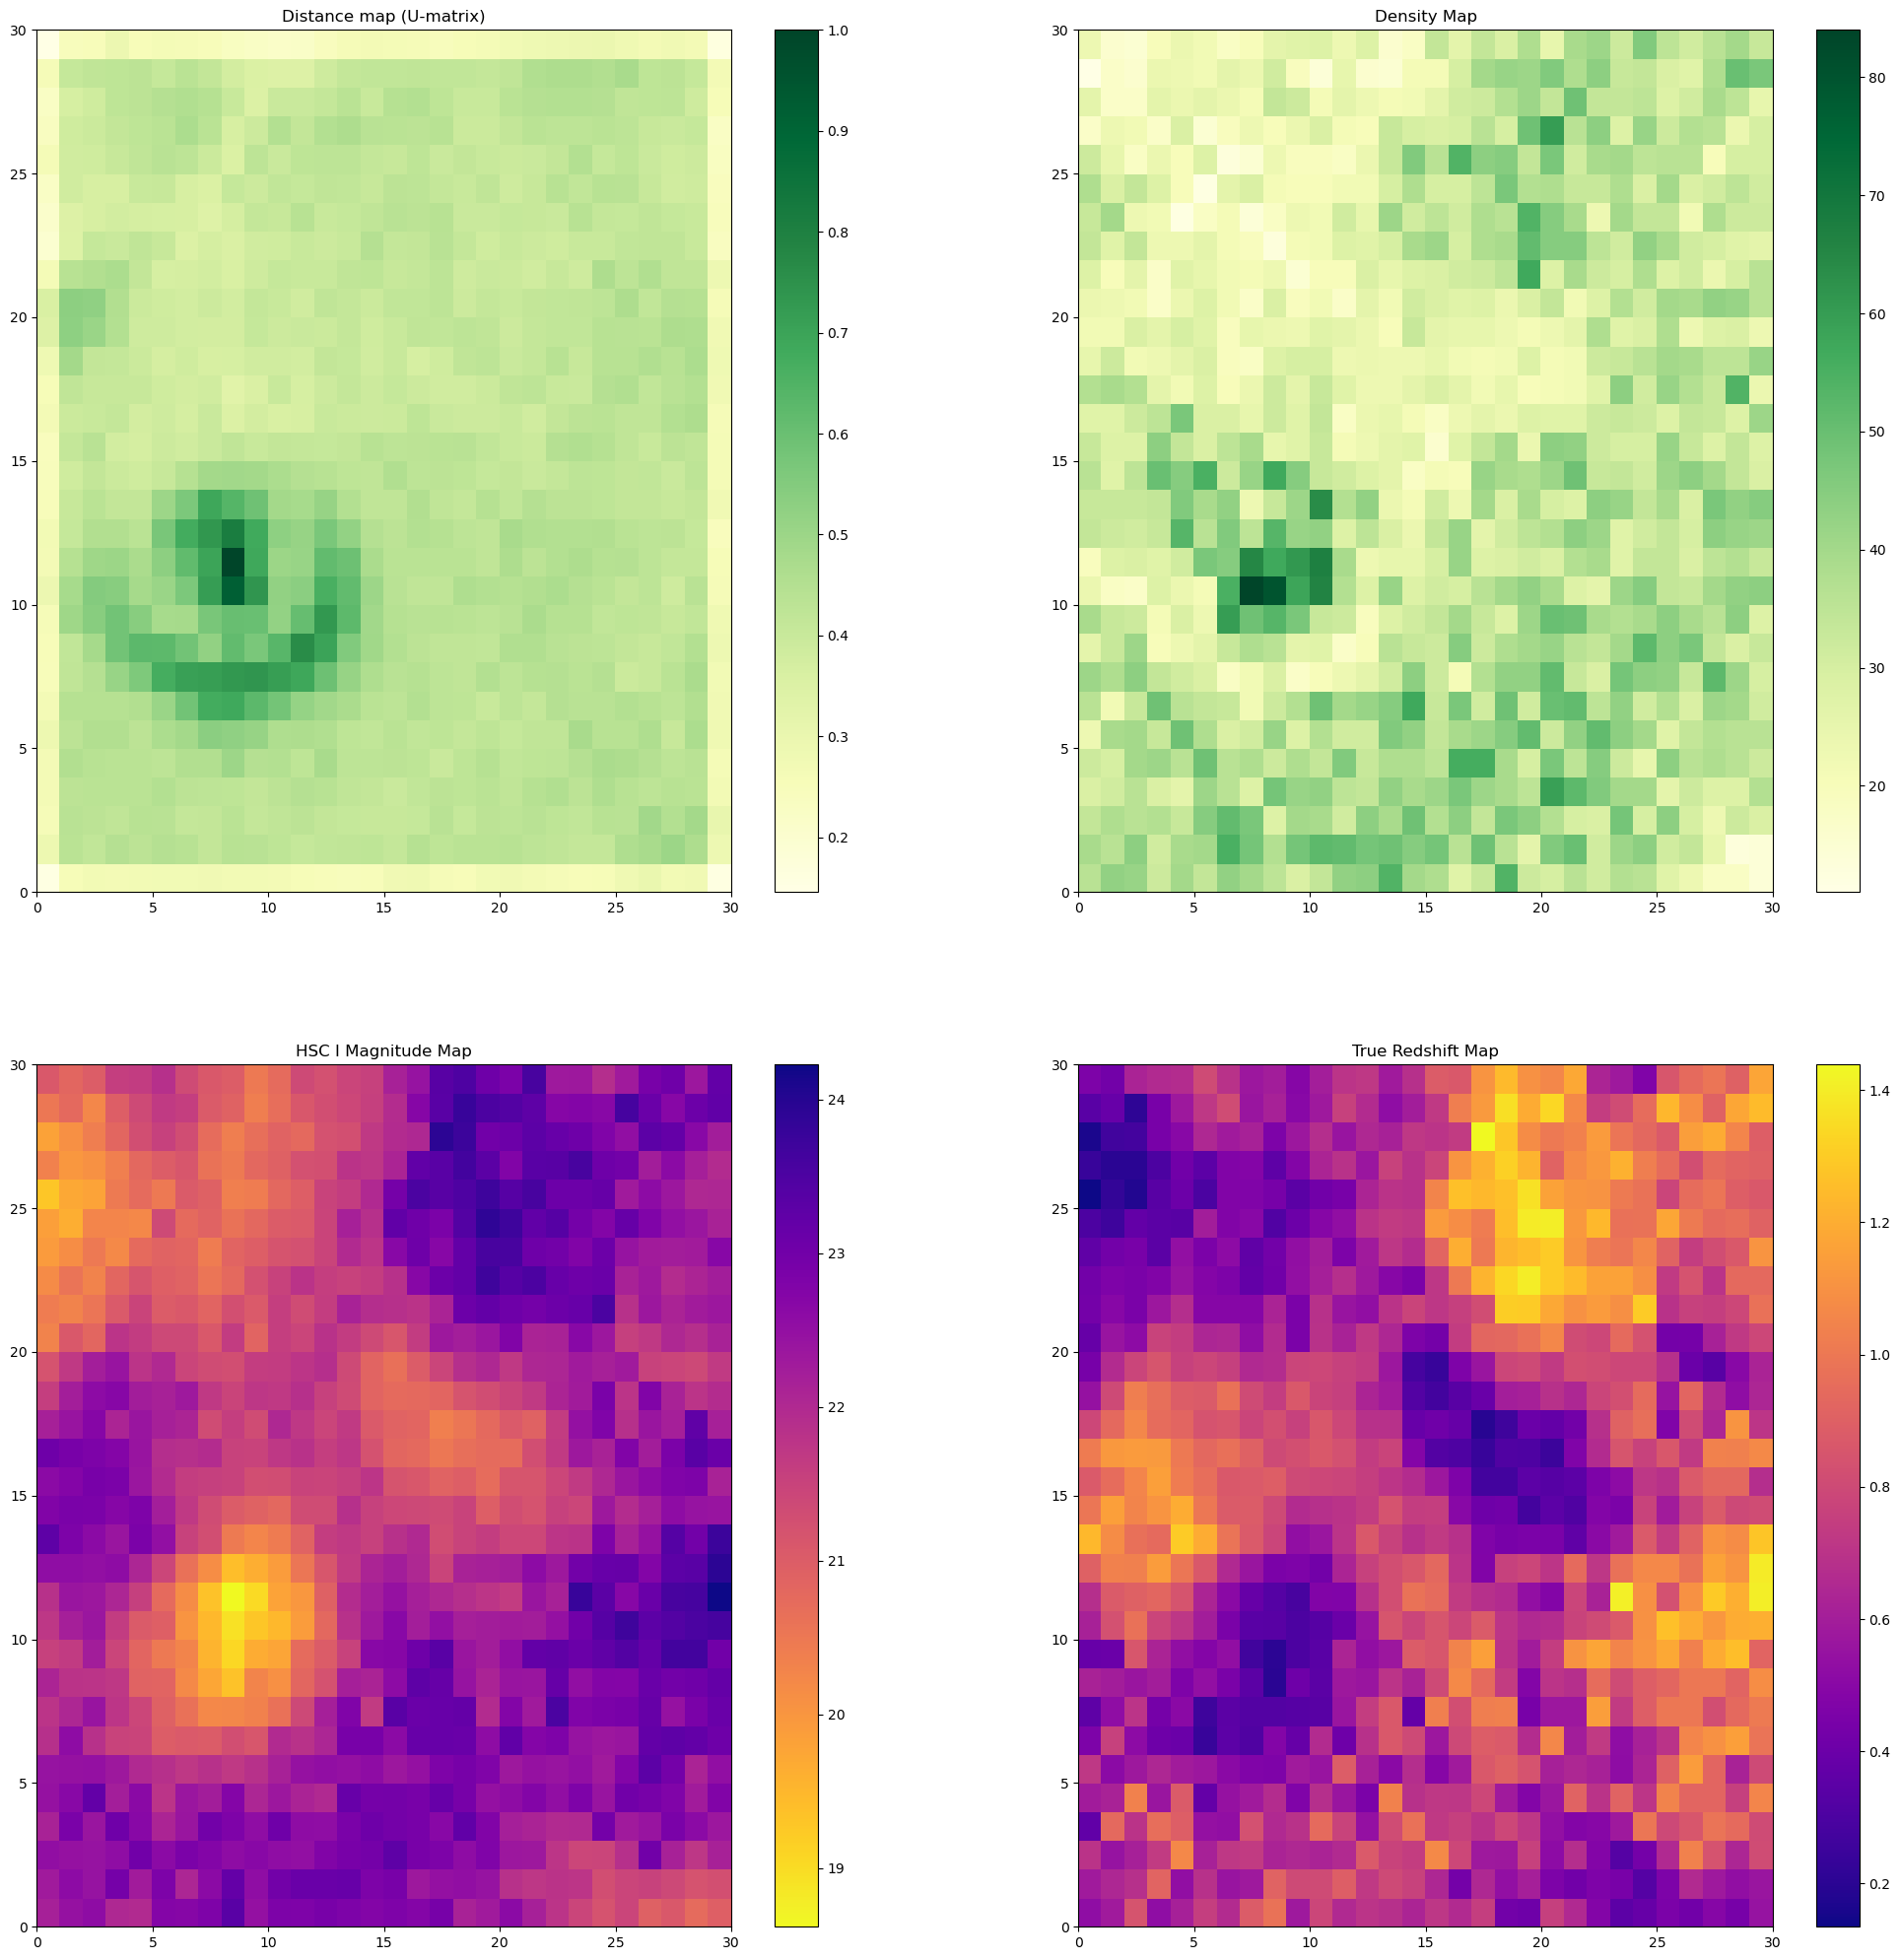

Data shape: (29683, 102)
Start making diagrams...
[30, 0.6, 0.3]
29683.0
Topological error: 0.889364282585992
Quantization error: 6.115517819518713
Average redshift std: 0.2999394016056523


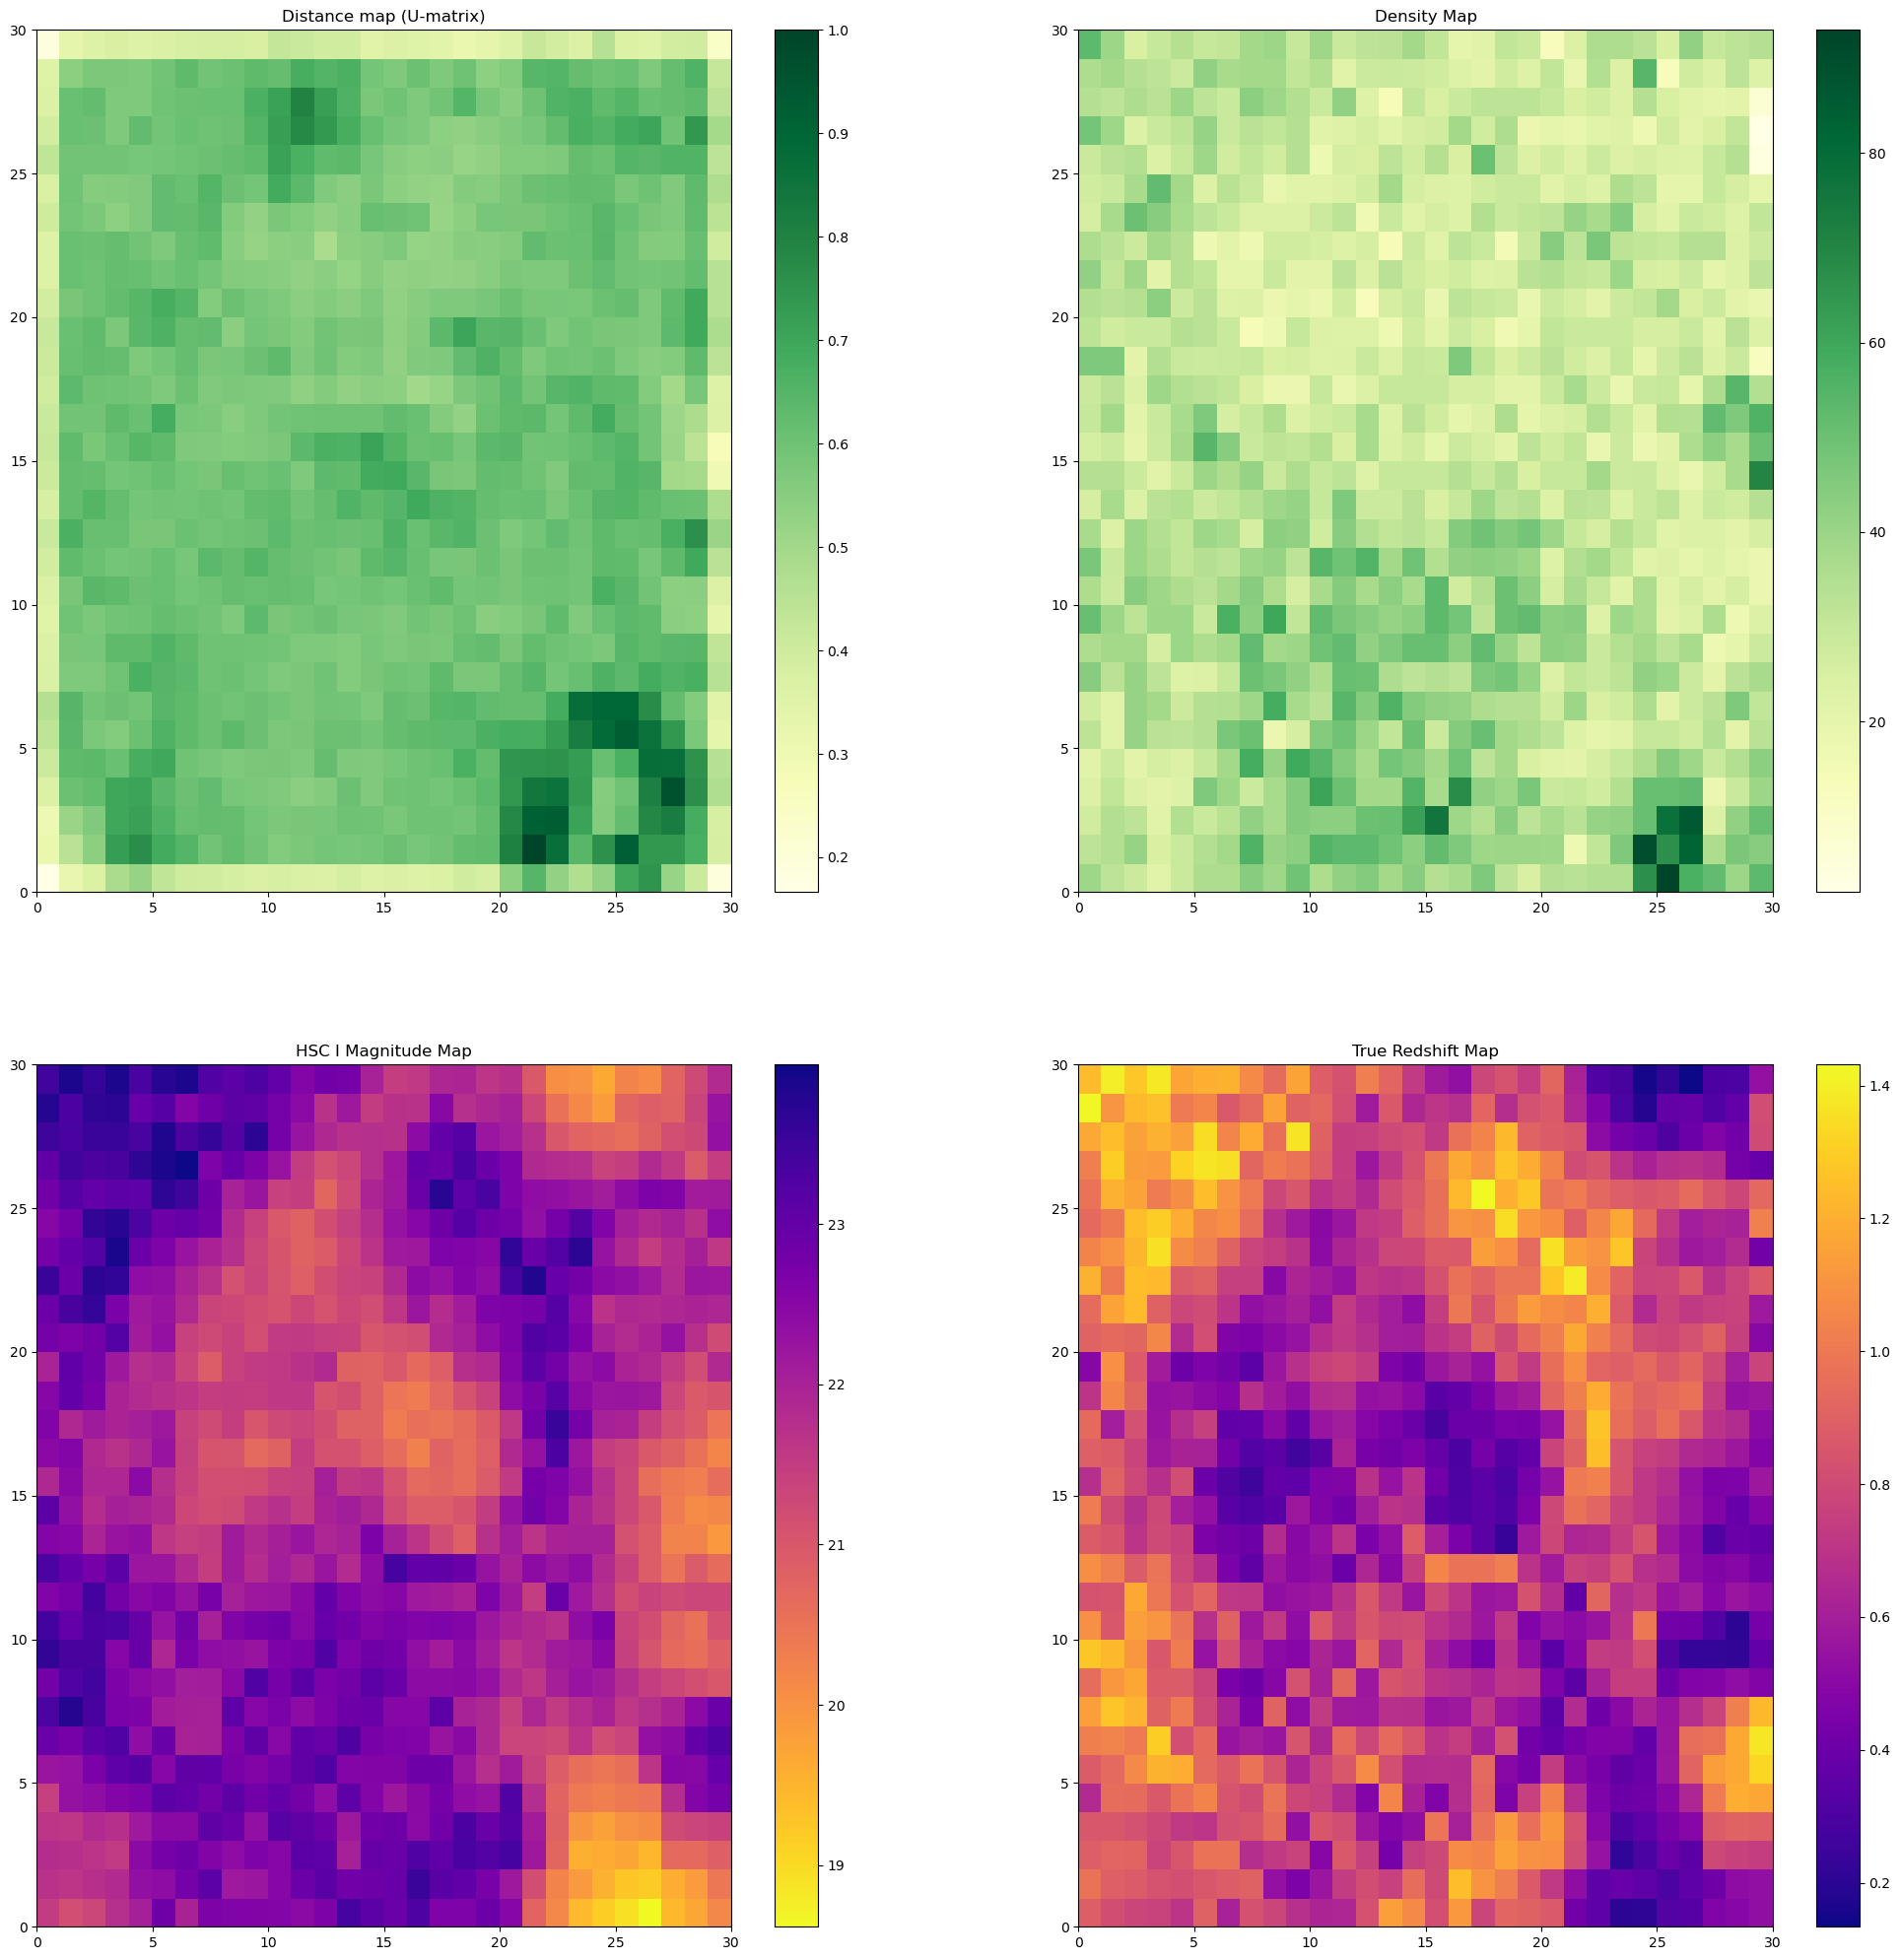

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.3]
29683.0
Topological error: 0.9276353468315197
Quantization error: 6.129222223904498
Average redshift std: 0.2984944544578374


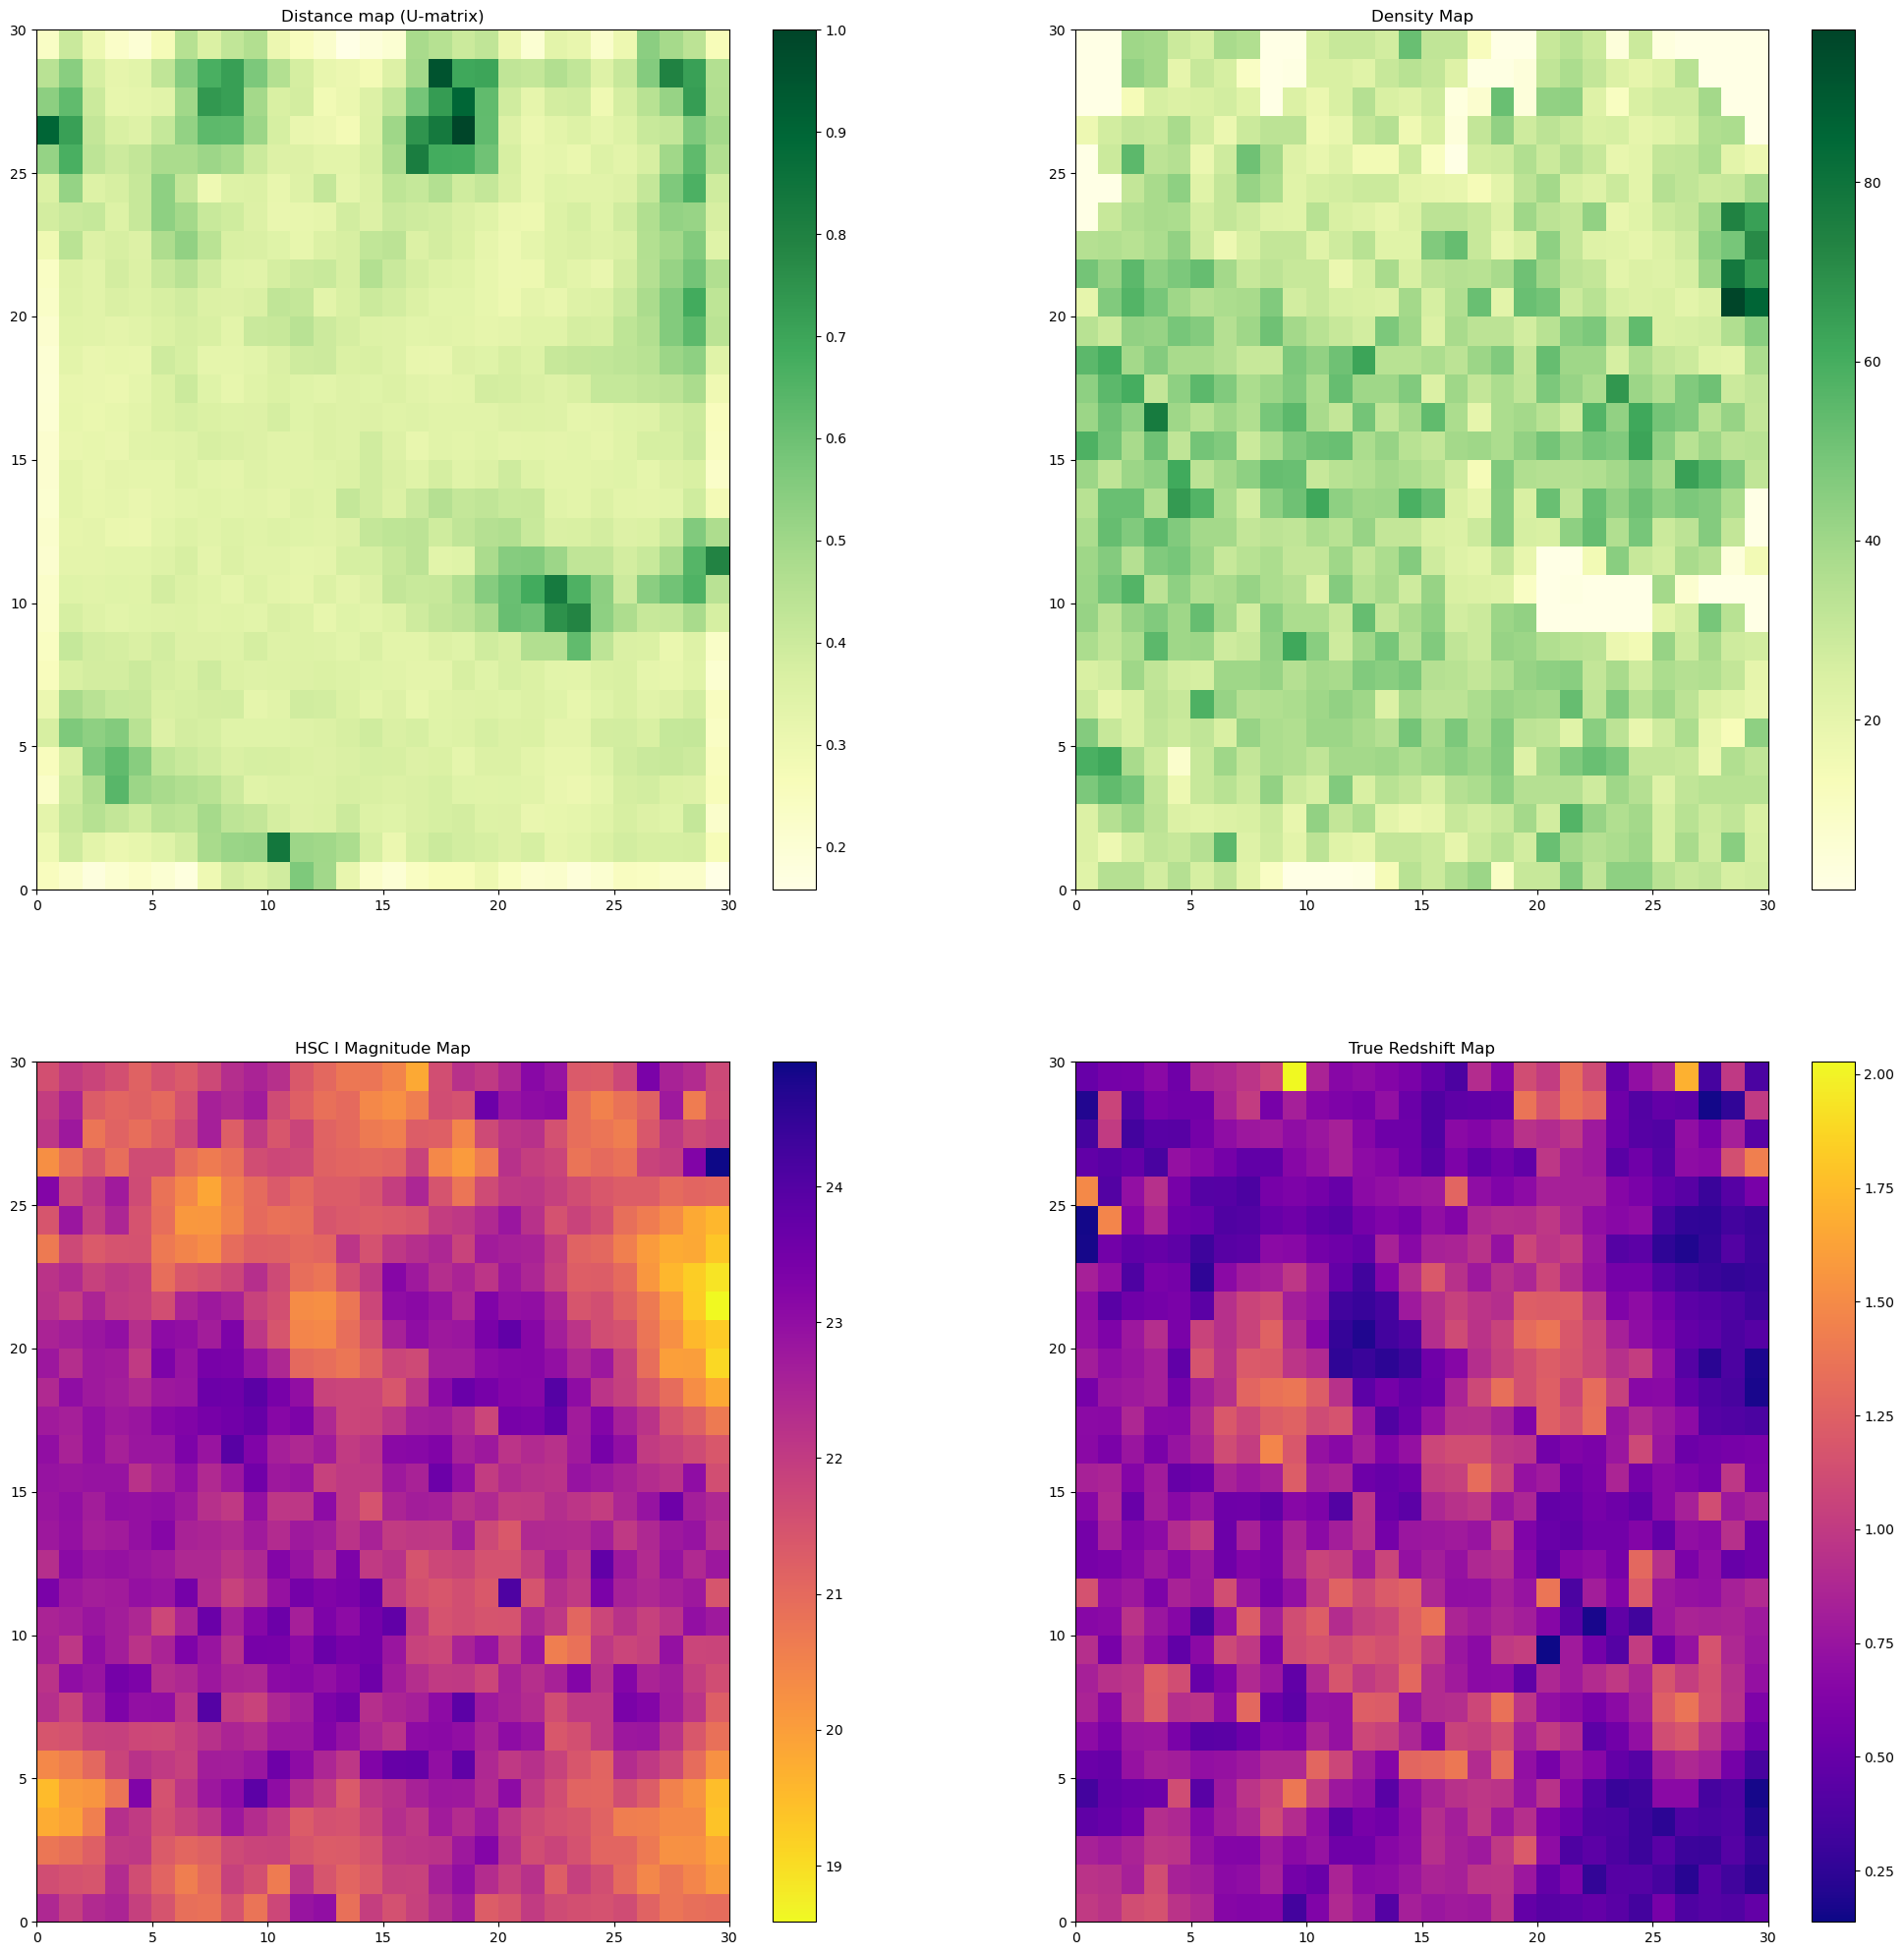

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.3]
29683.0
Topological error: 0.9586968972138935
Quantization error: 6.172402063026495
Average redshift std: 0.30997860018961065


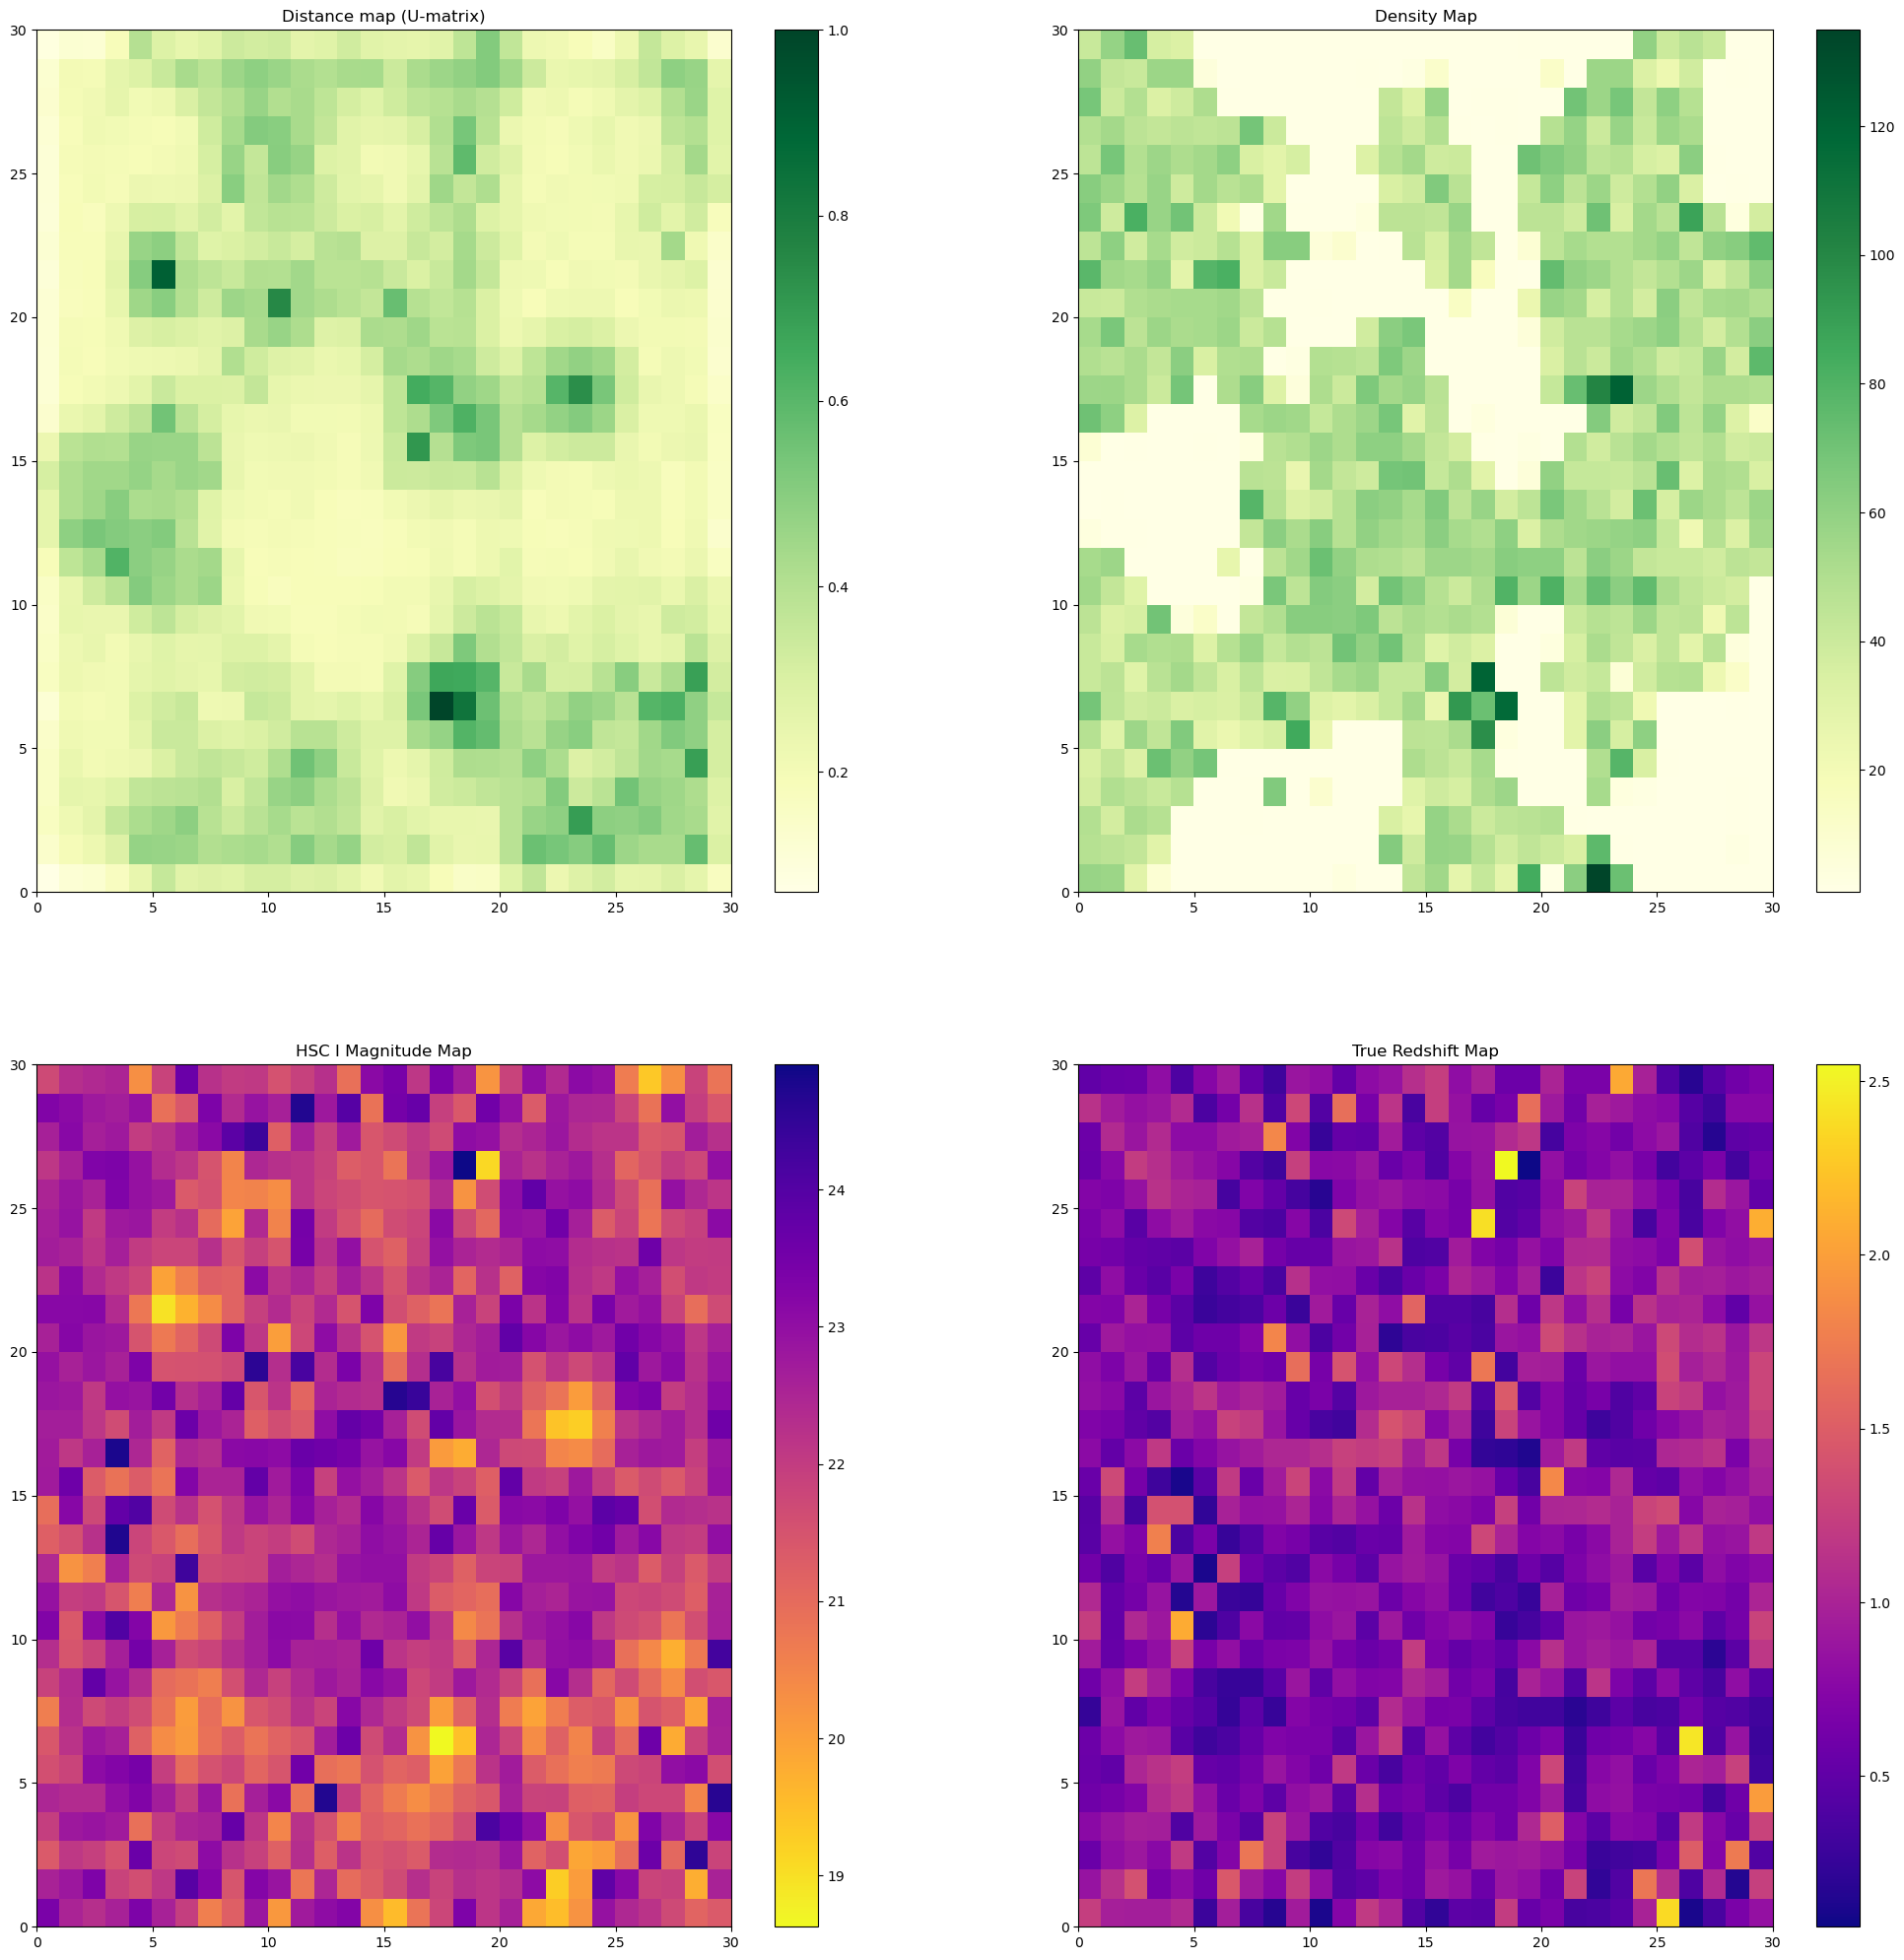

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.4]
29683.0
Topological error: 0.6830845938752822
Quantization error: 6.155850696059233
Average redshift std: 0.32212640664428854


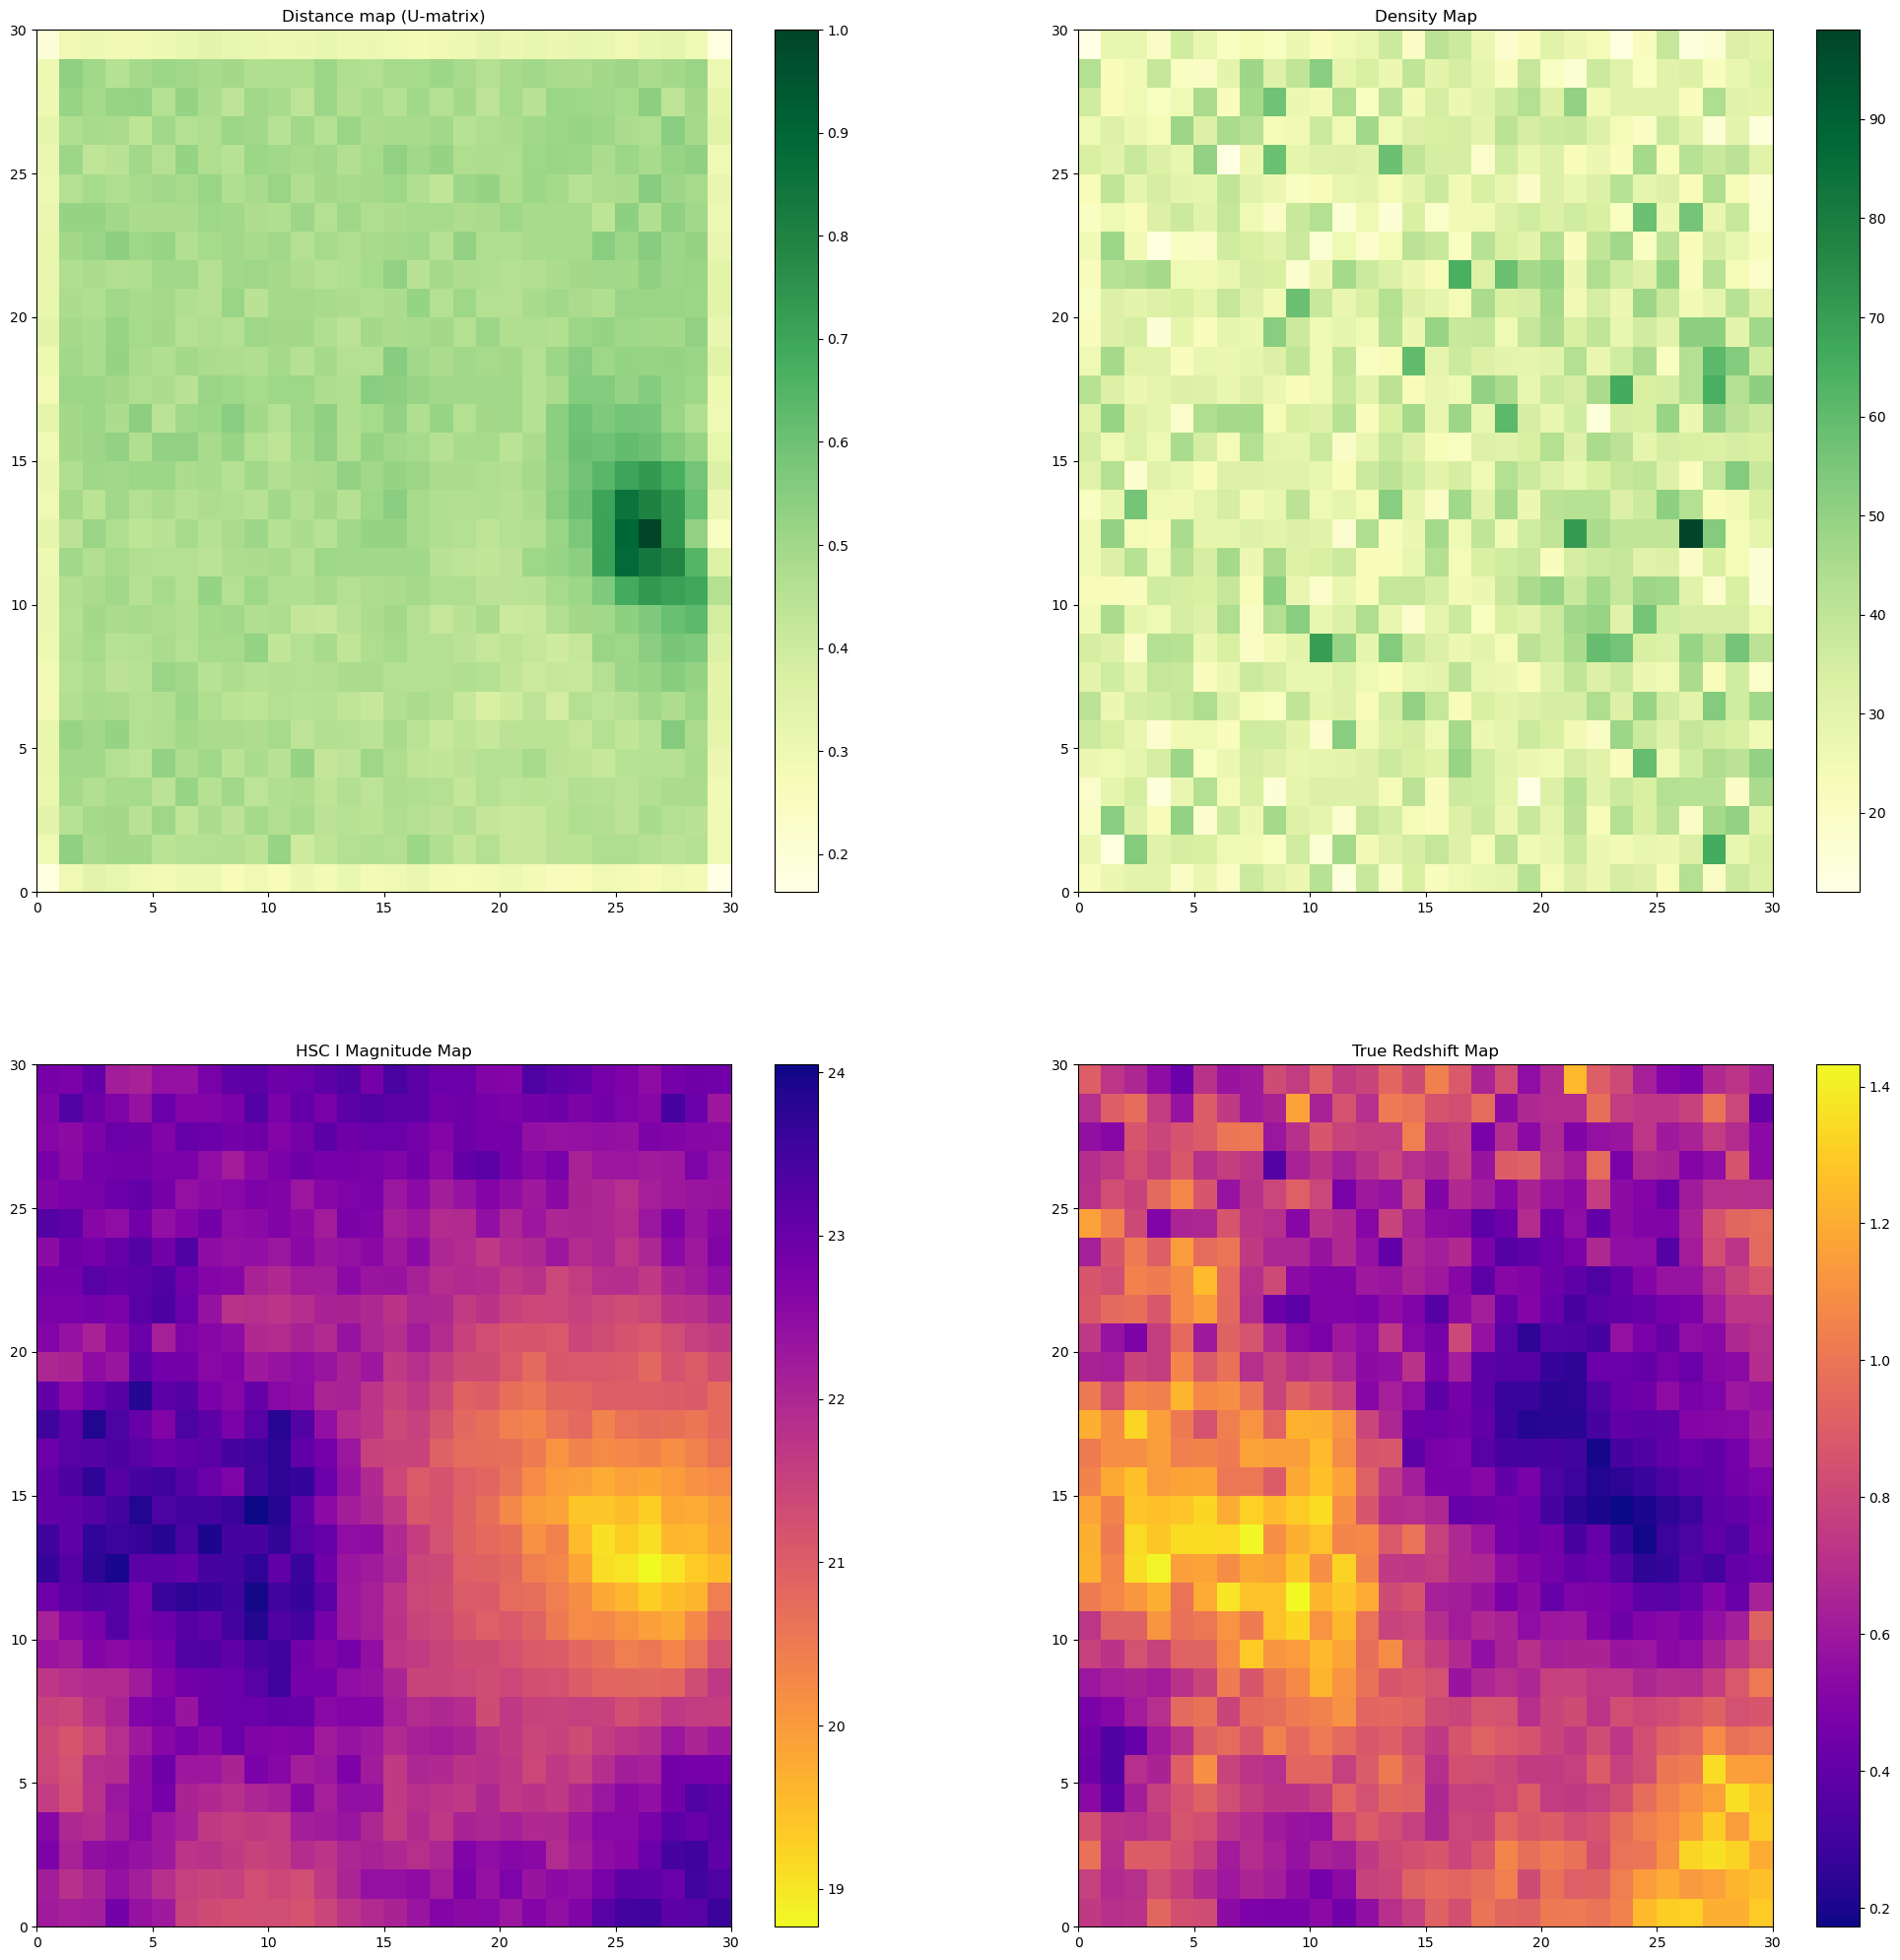

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.4]
29683.0
Topological error: 0.7655897314961426
Quantization error: 6.148906736438941
Average redshift std: 0.32842739722807135


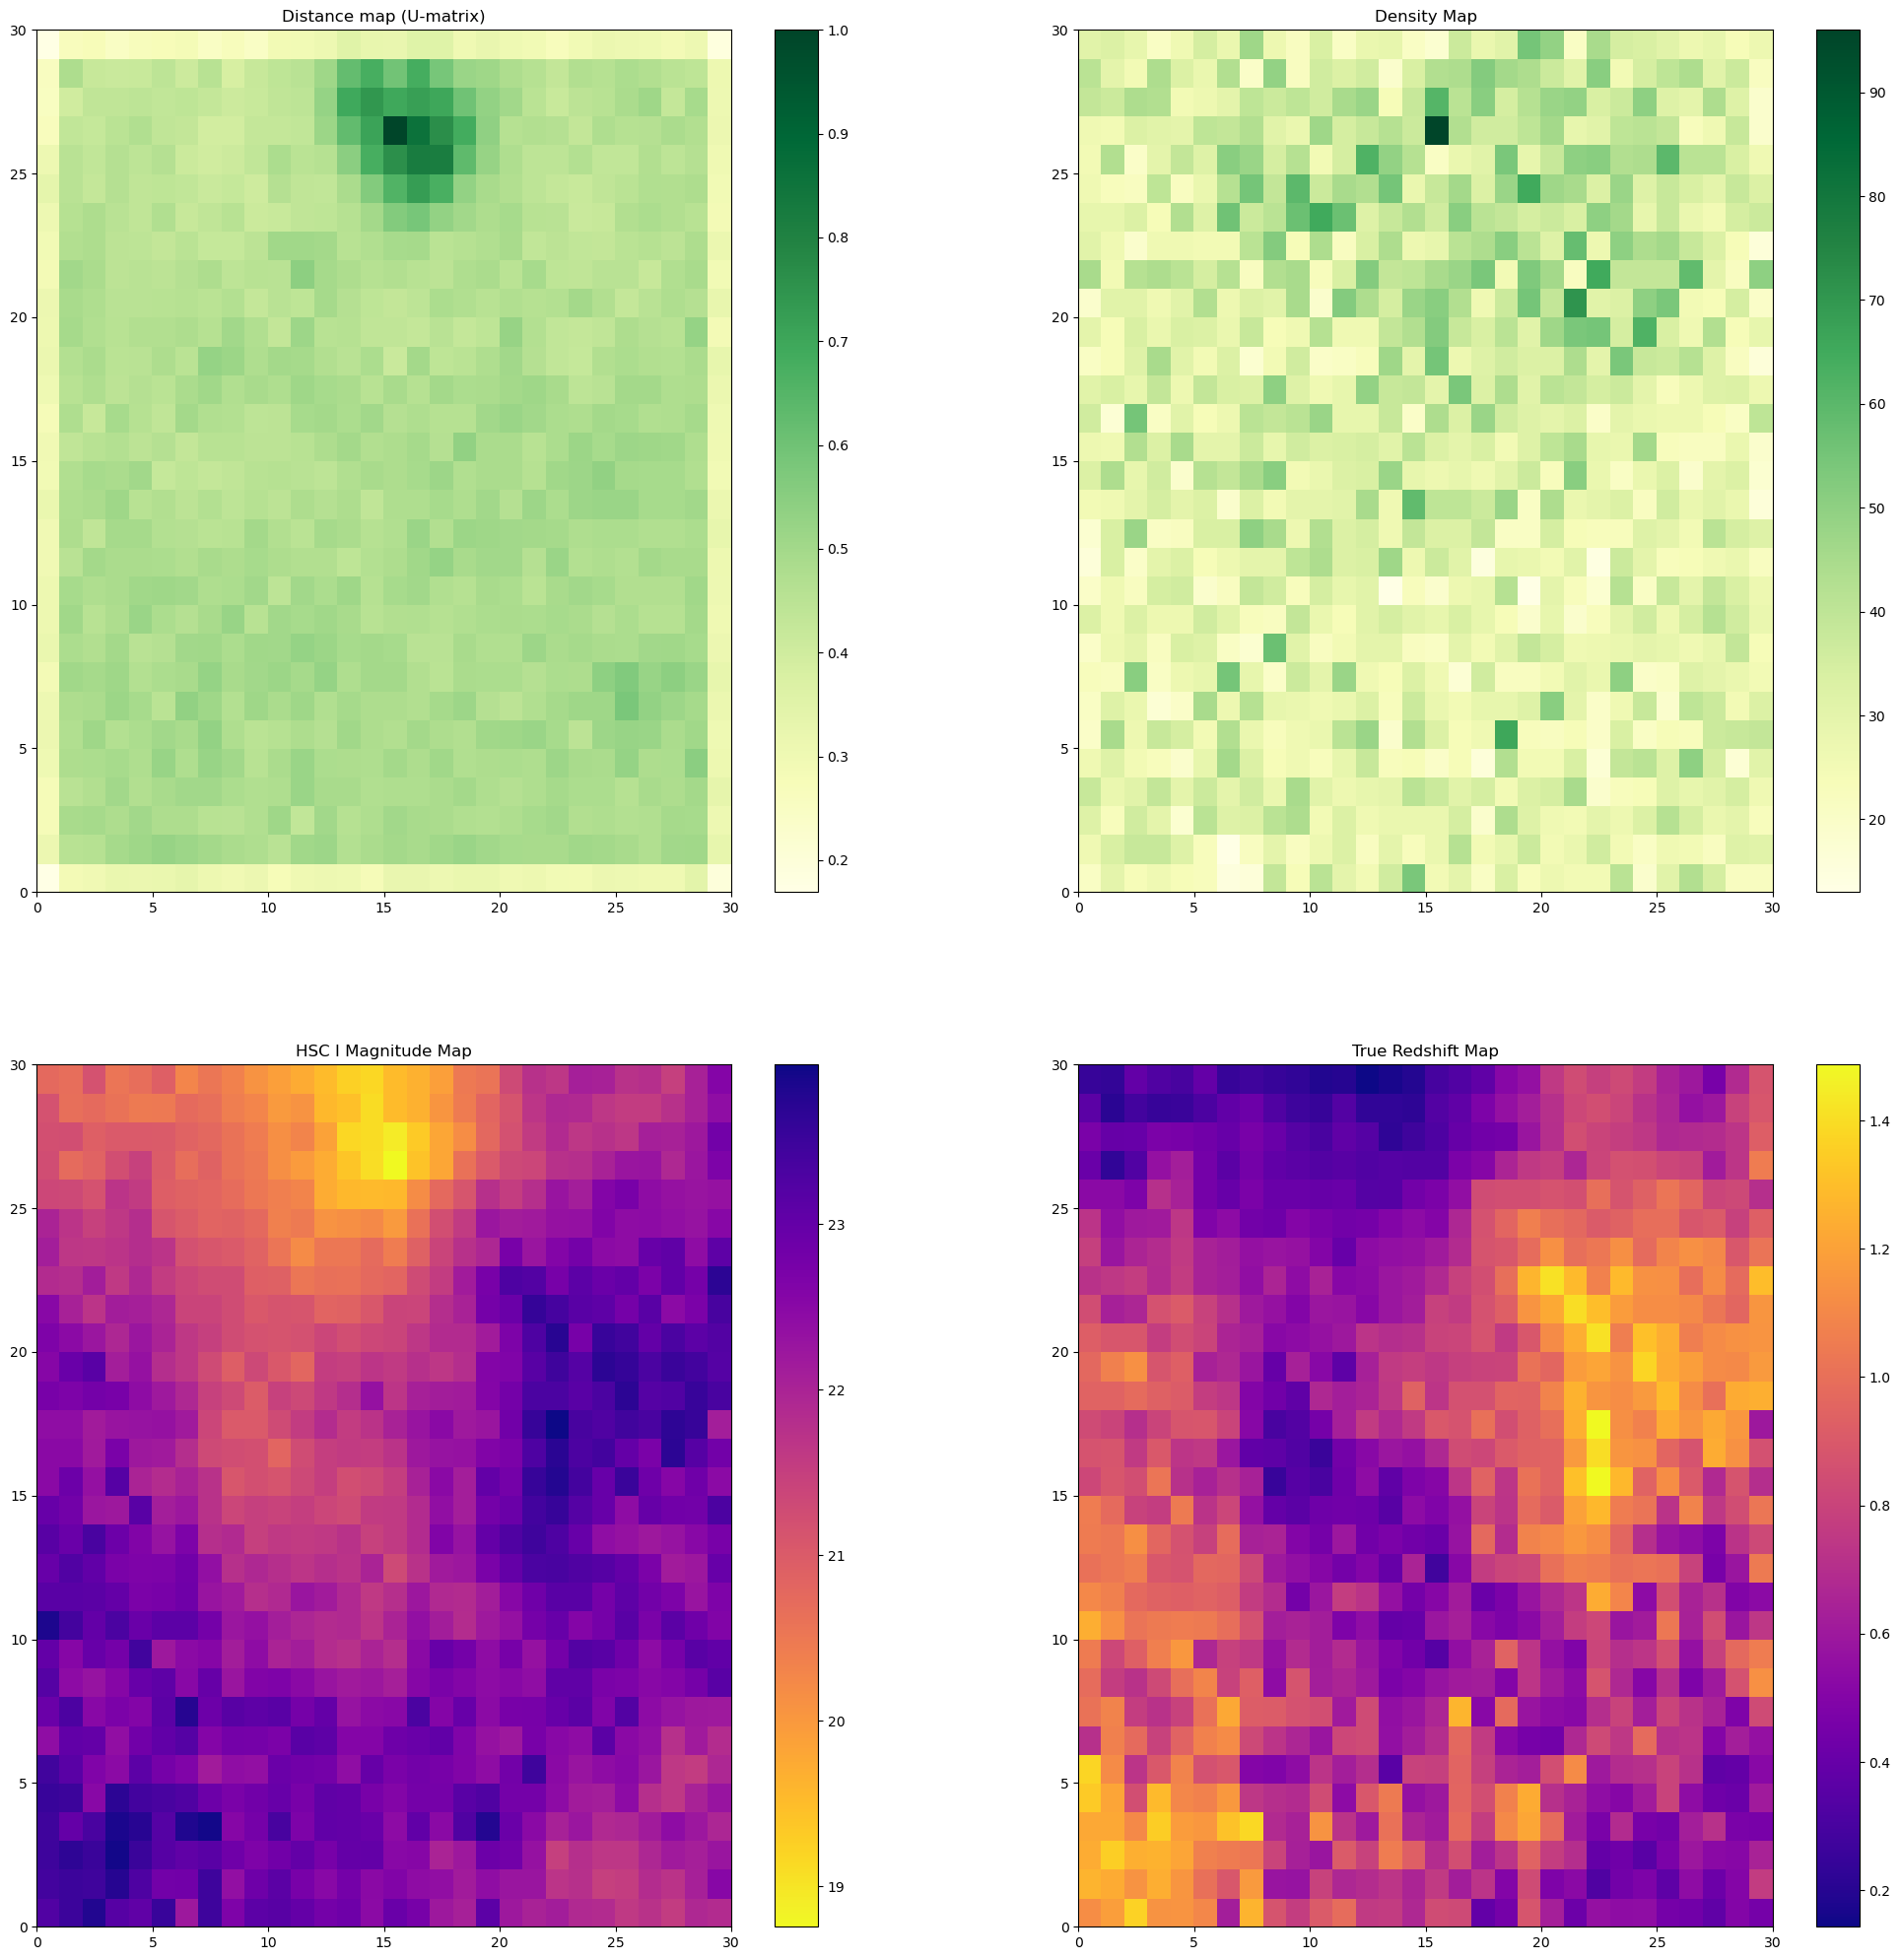

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.4]
29683.0
Topological error: 0.8219856483509079
Quantization error: 6.153673781202665
Average redshift std: 0.3289394233479248


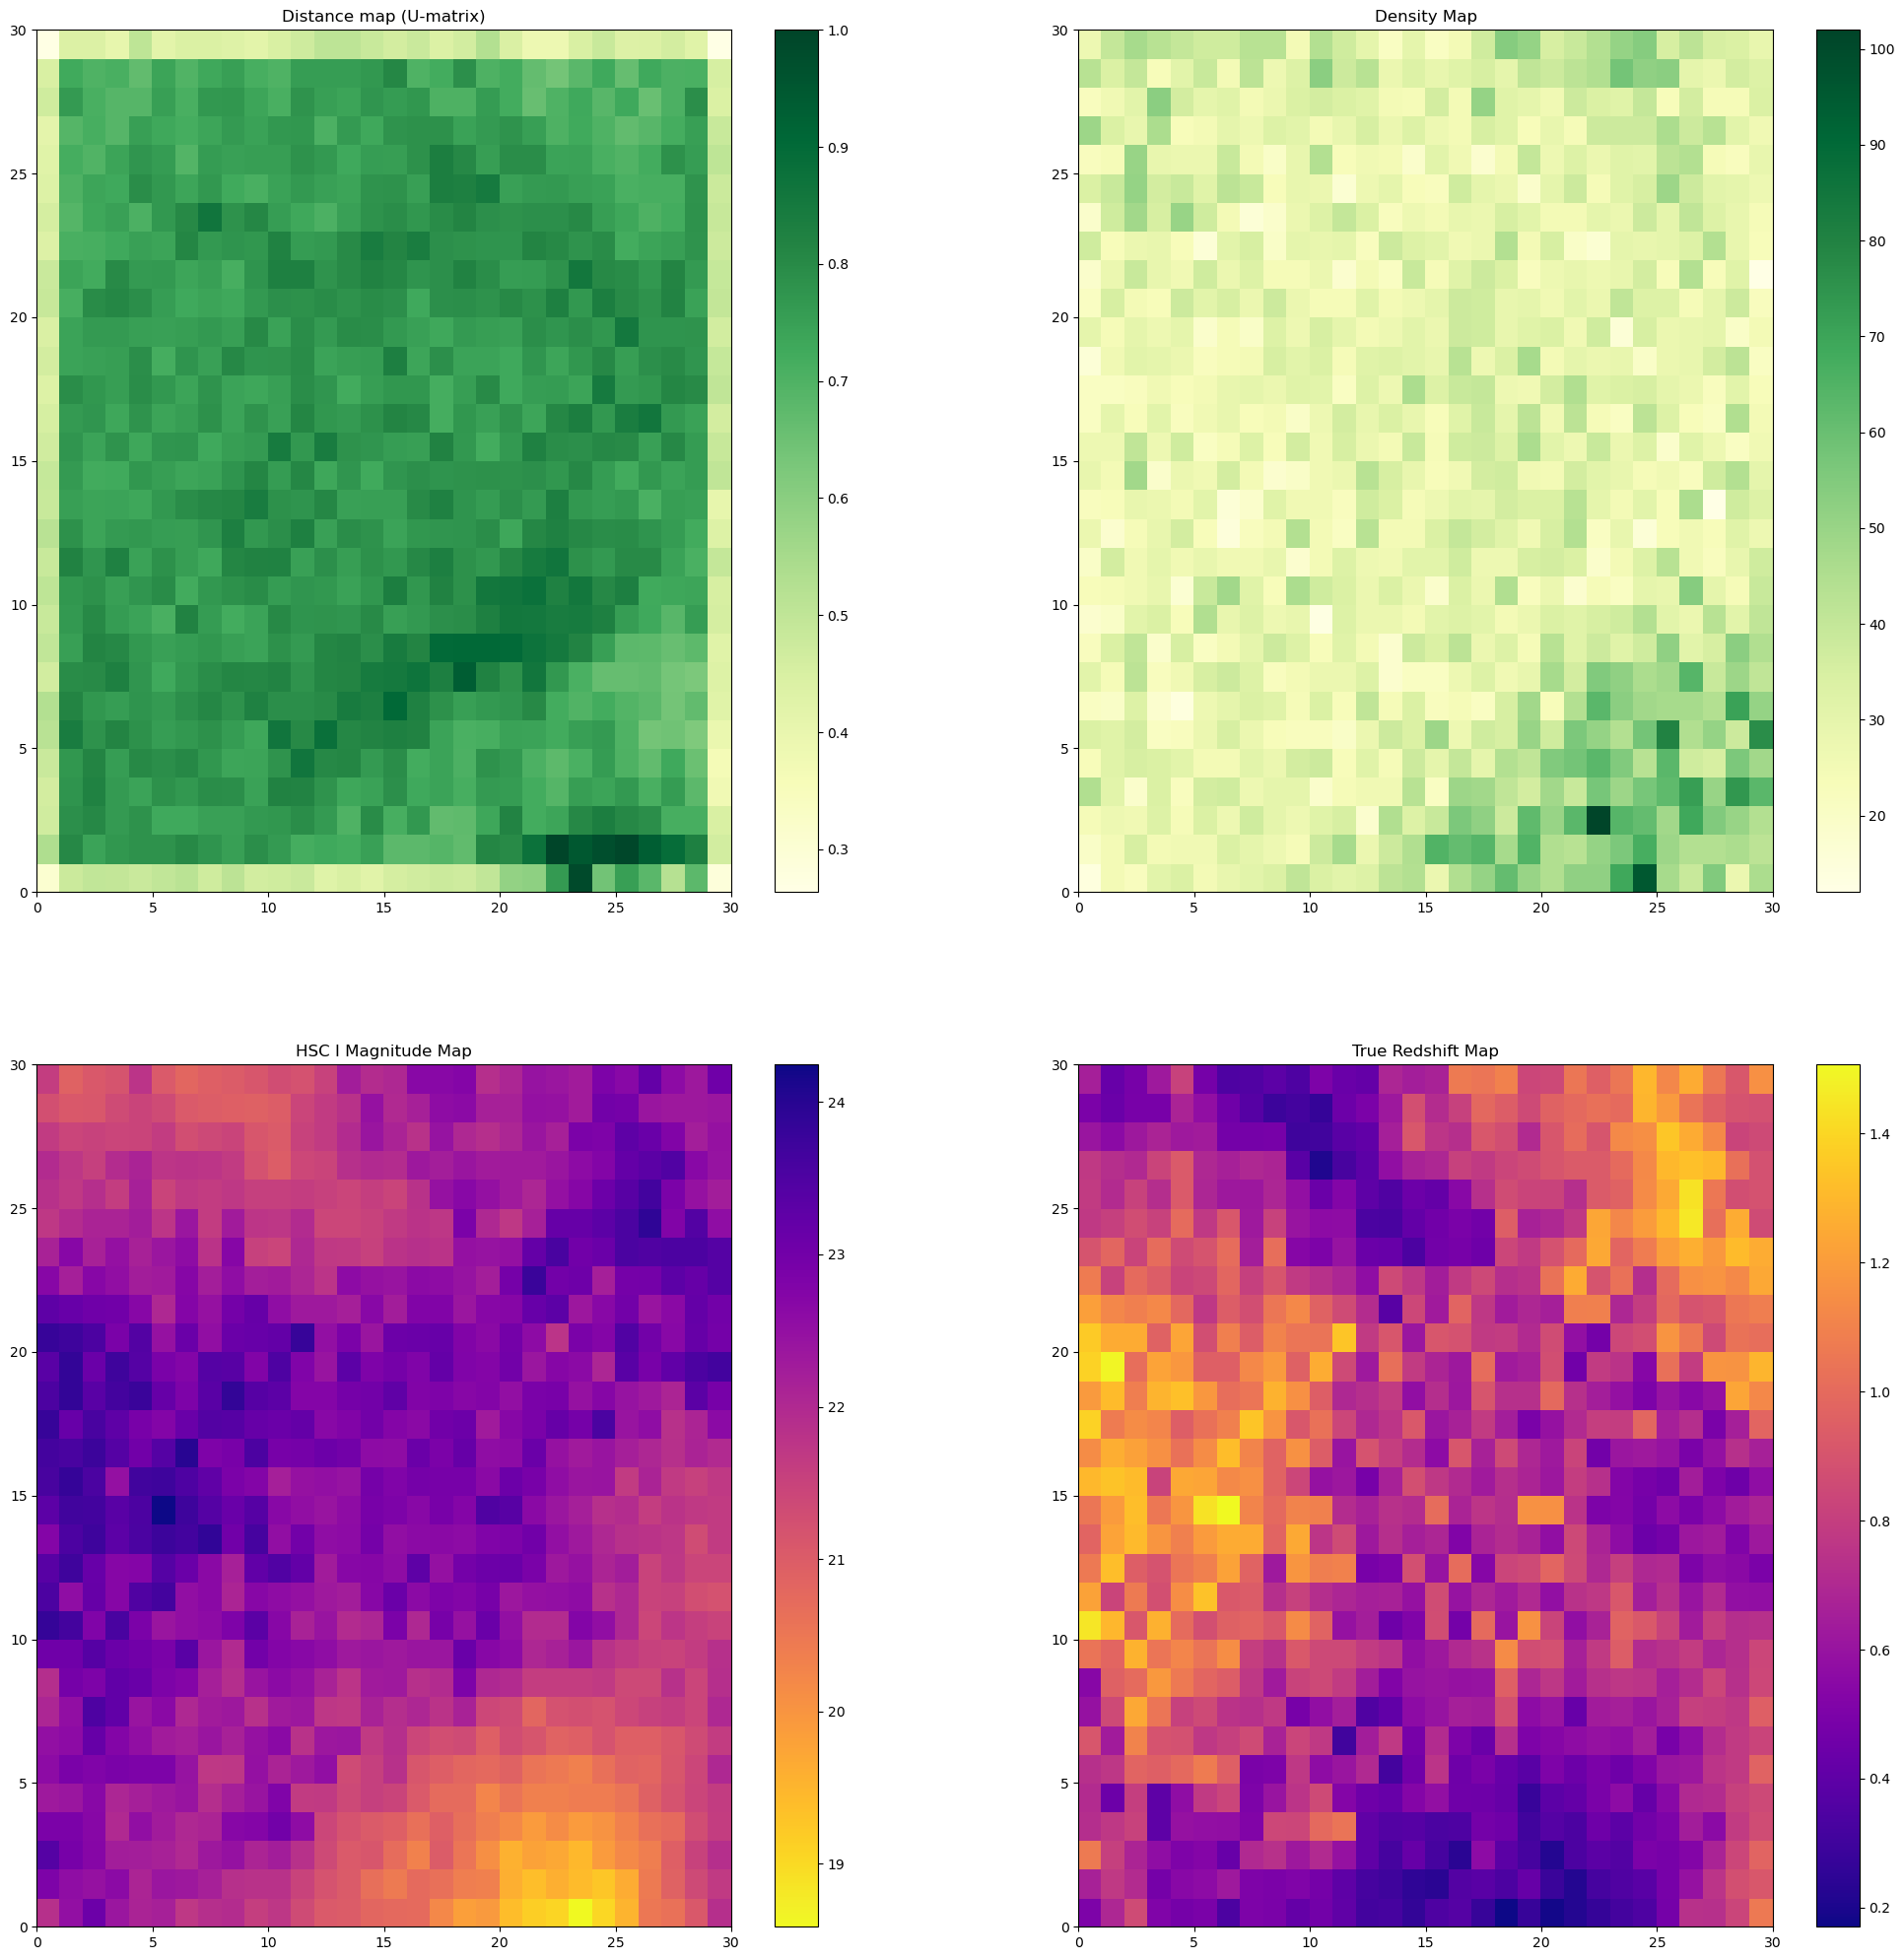

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.4]
29683.0
Topological error: 0.8886904962436412
Quantization error: 6.162150657213407
Average redshift std: 0.31243036195070684


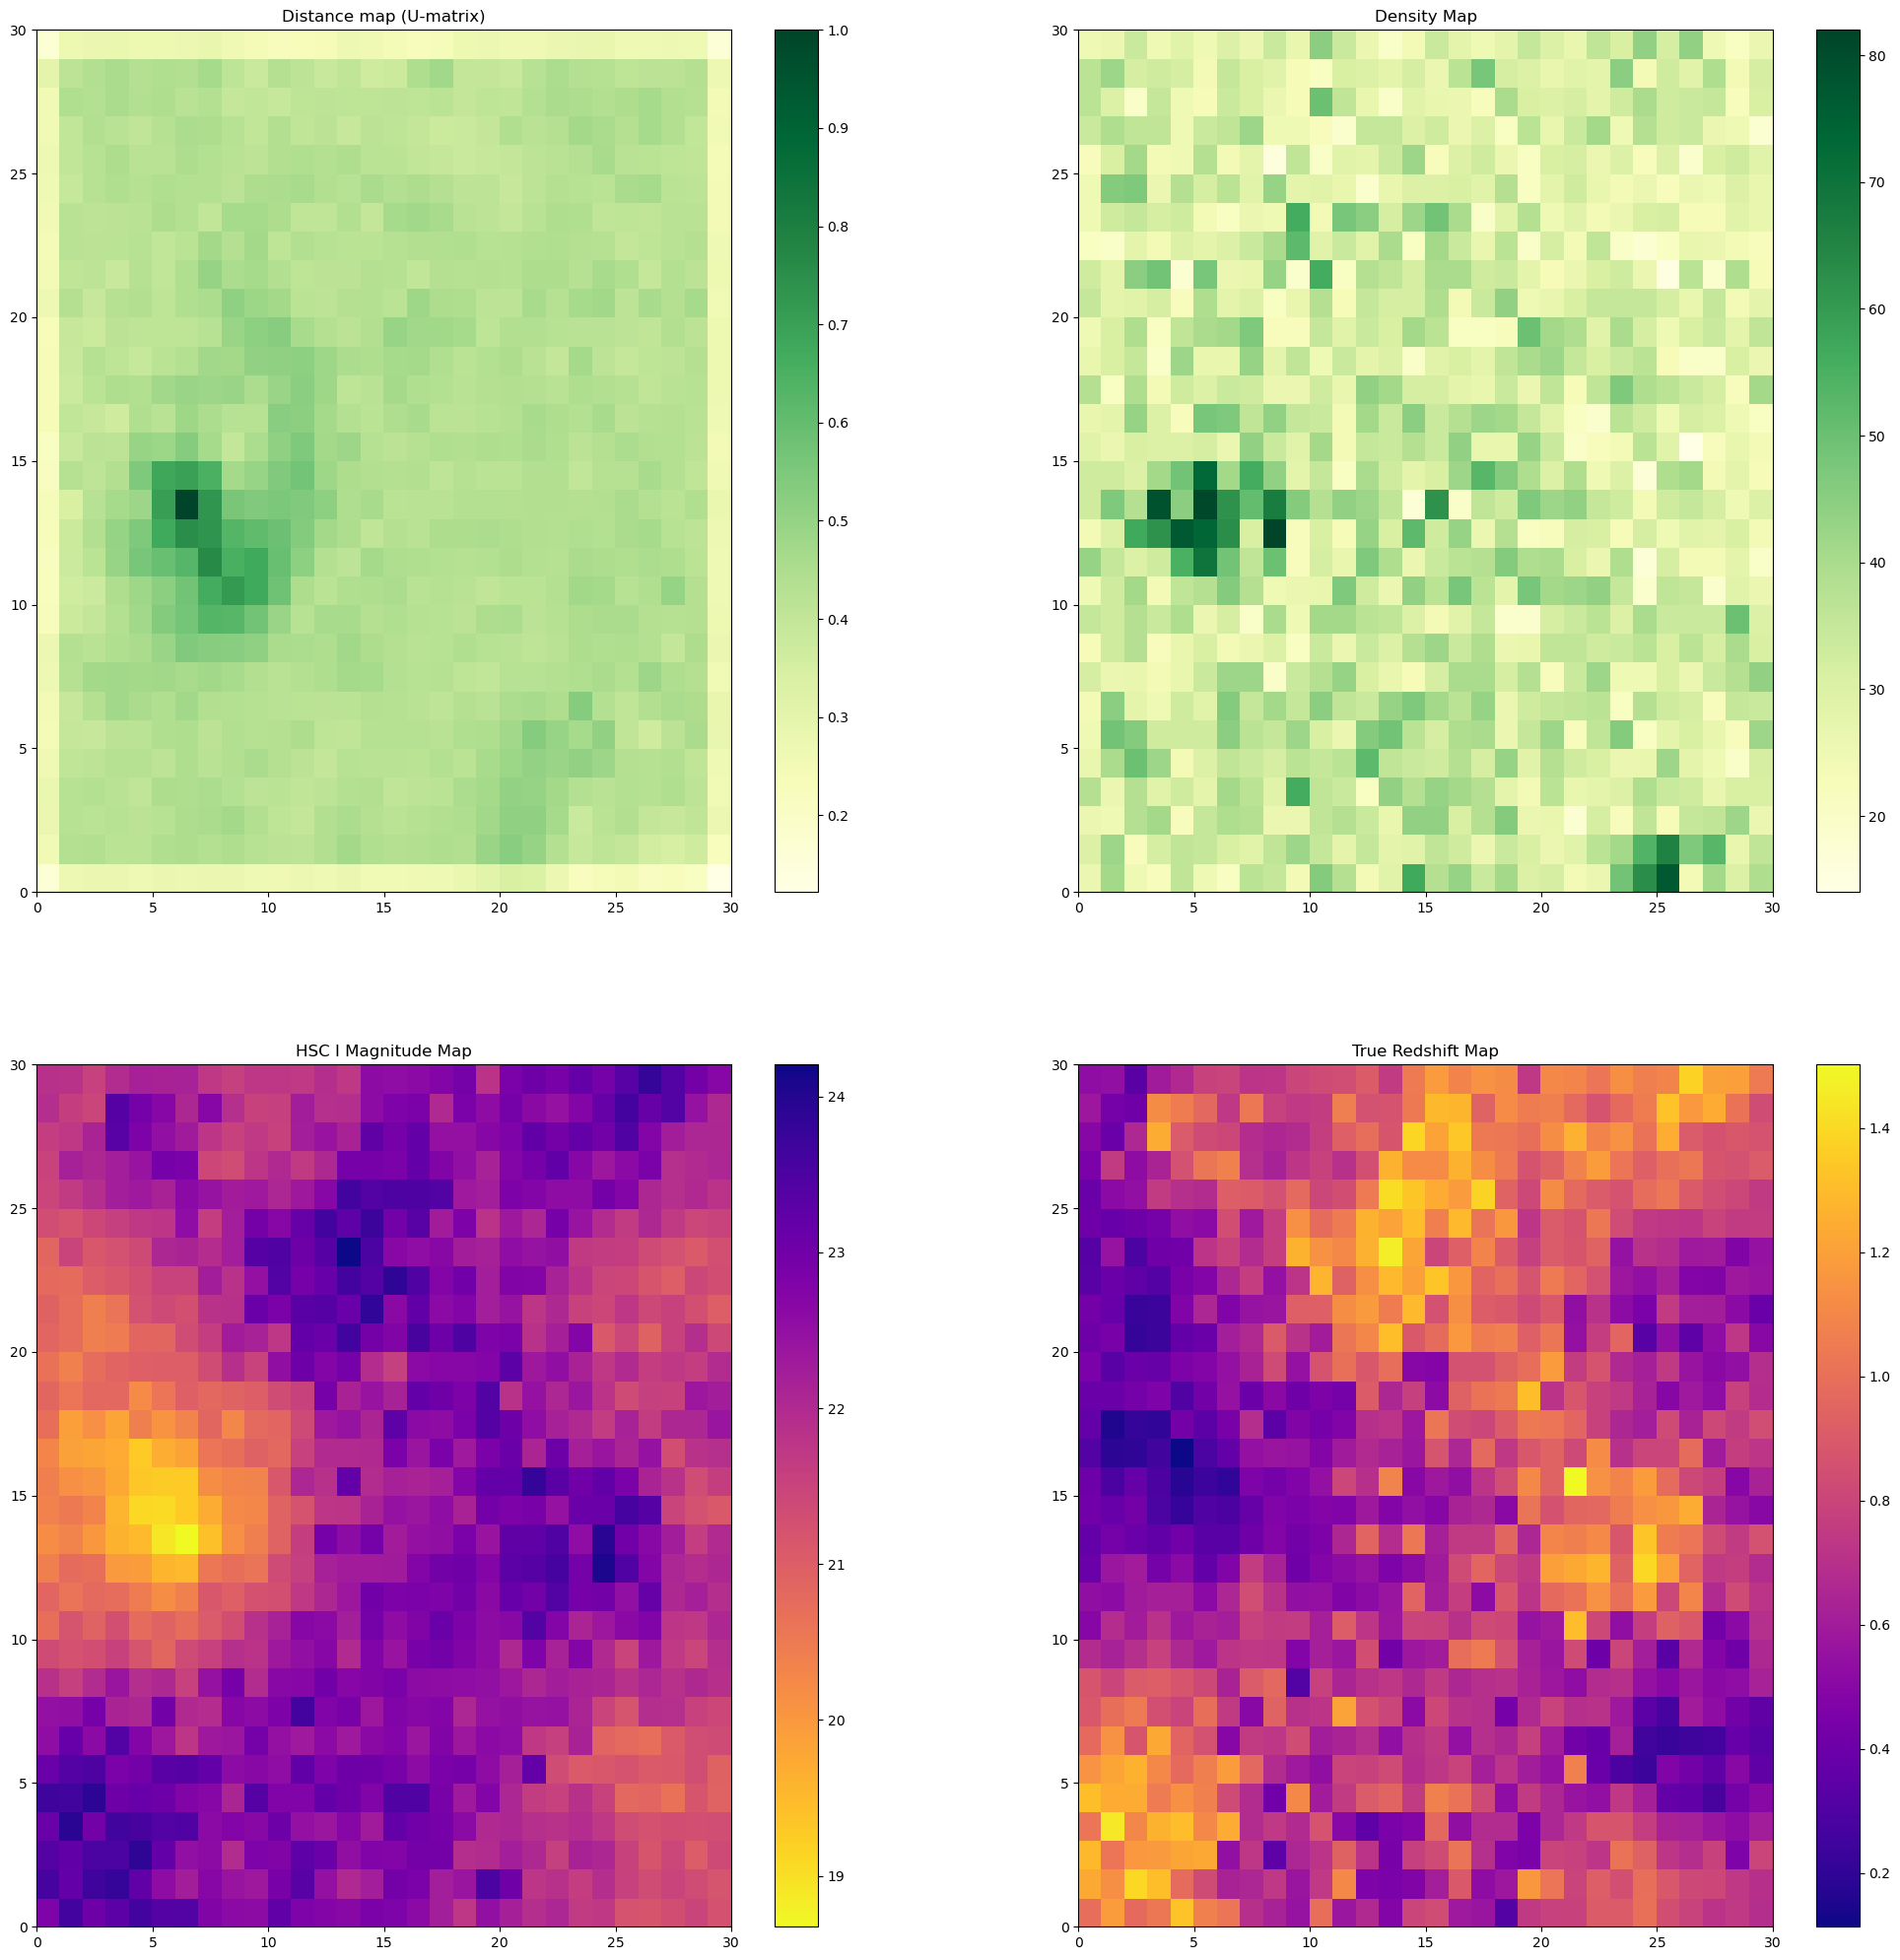

Data shape: (29683, 102)
Start making diagrams...
[30, 0.6, 0.4]
29683.0
Topological error: 0.9103527271502206
Quantization error: 6.1723097599603385
Average redshift std: 0.3108409995575653


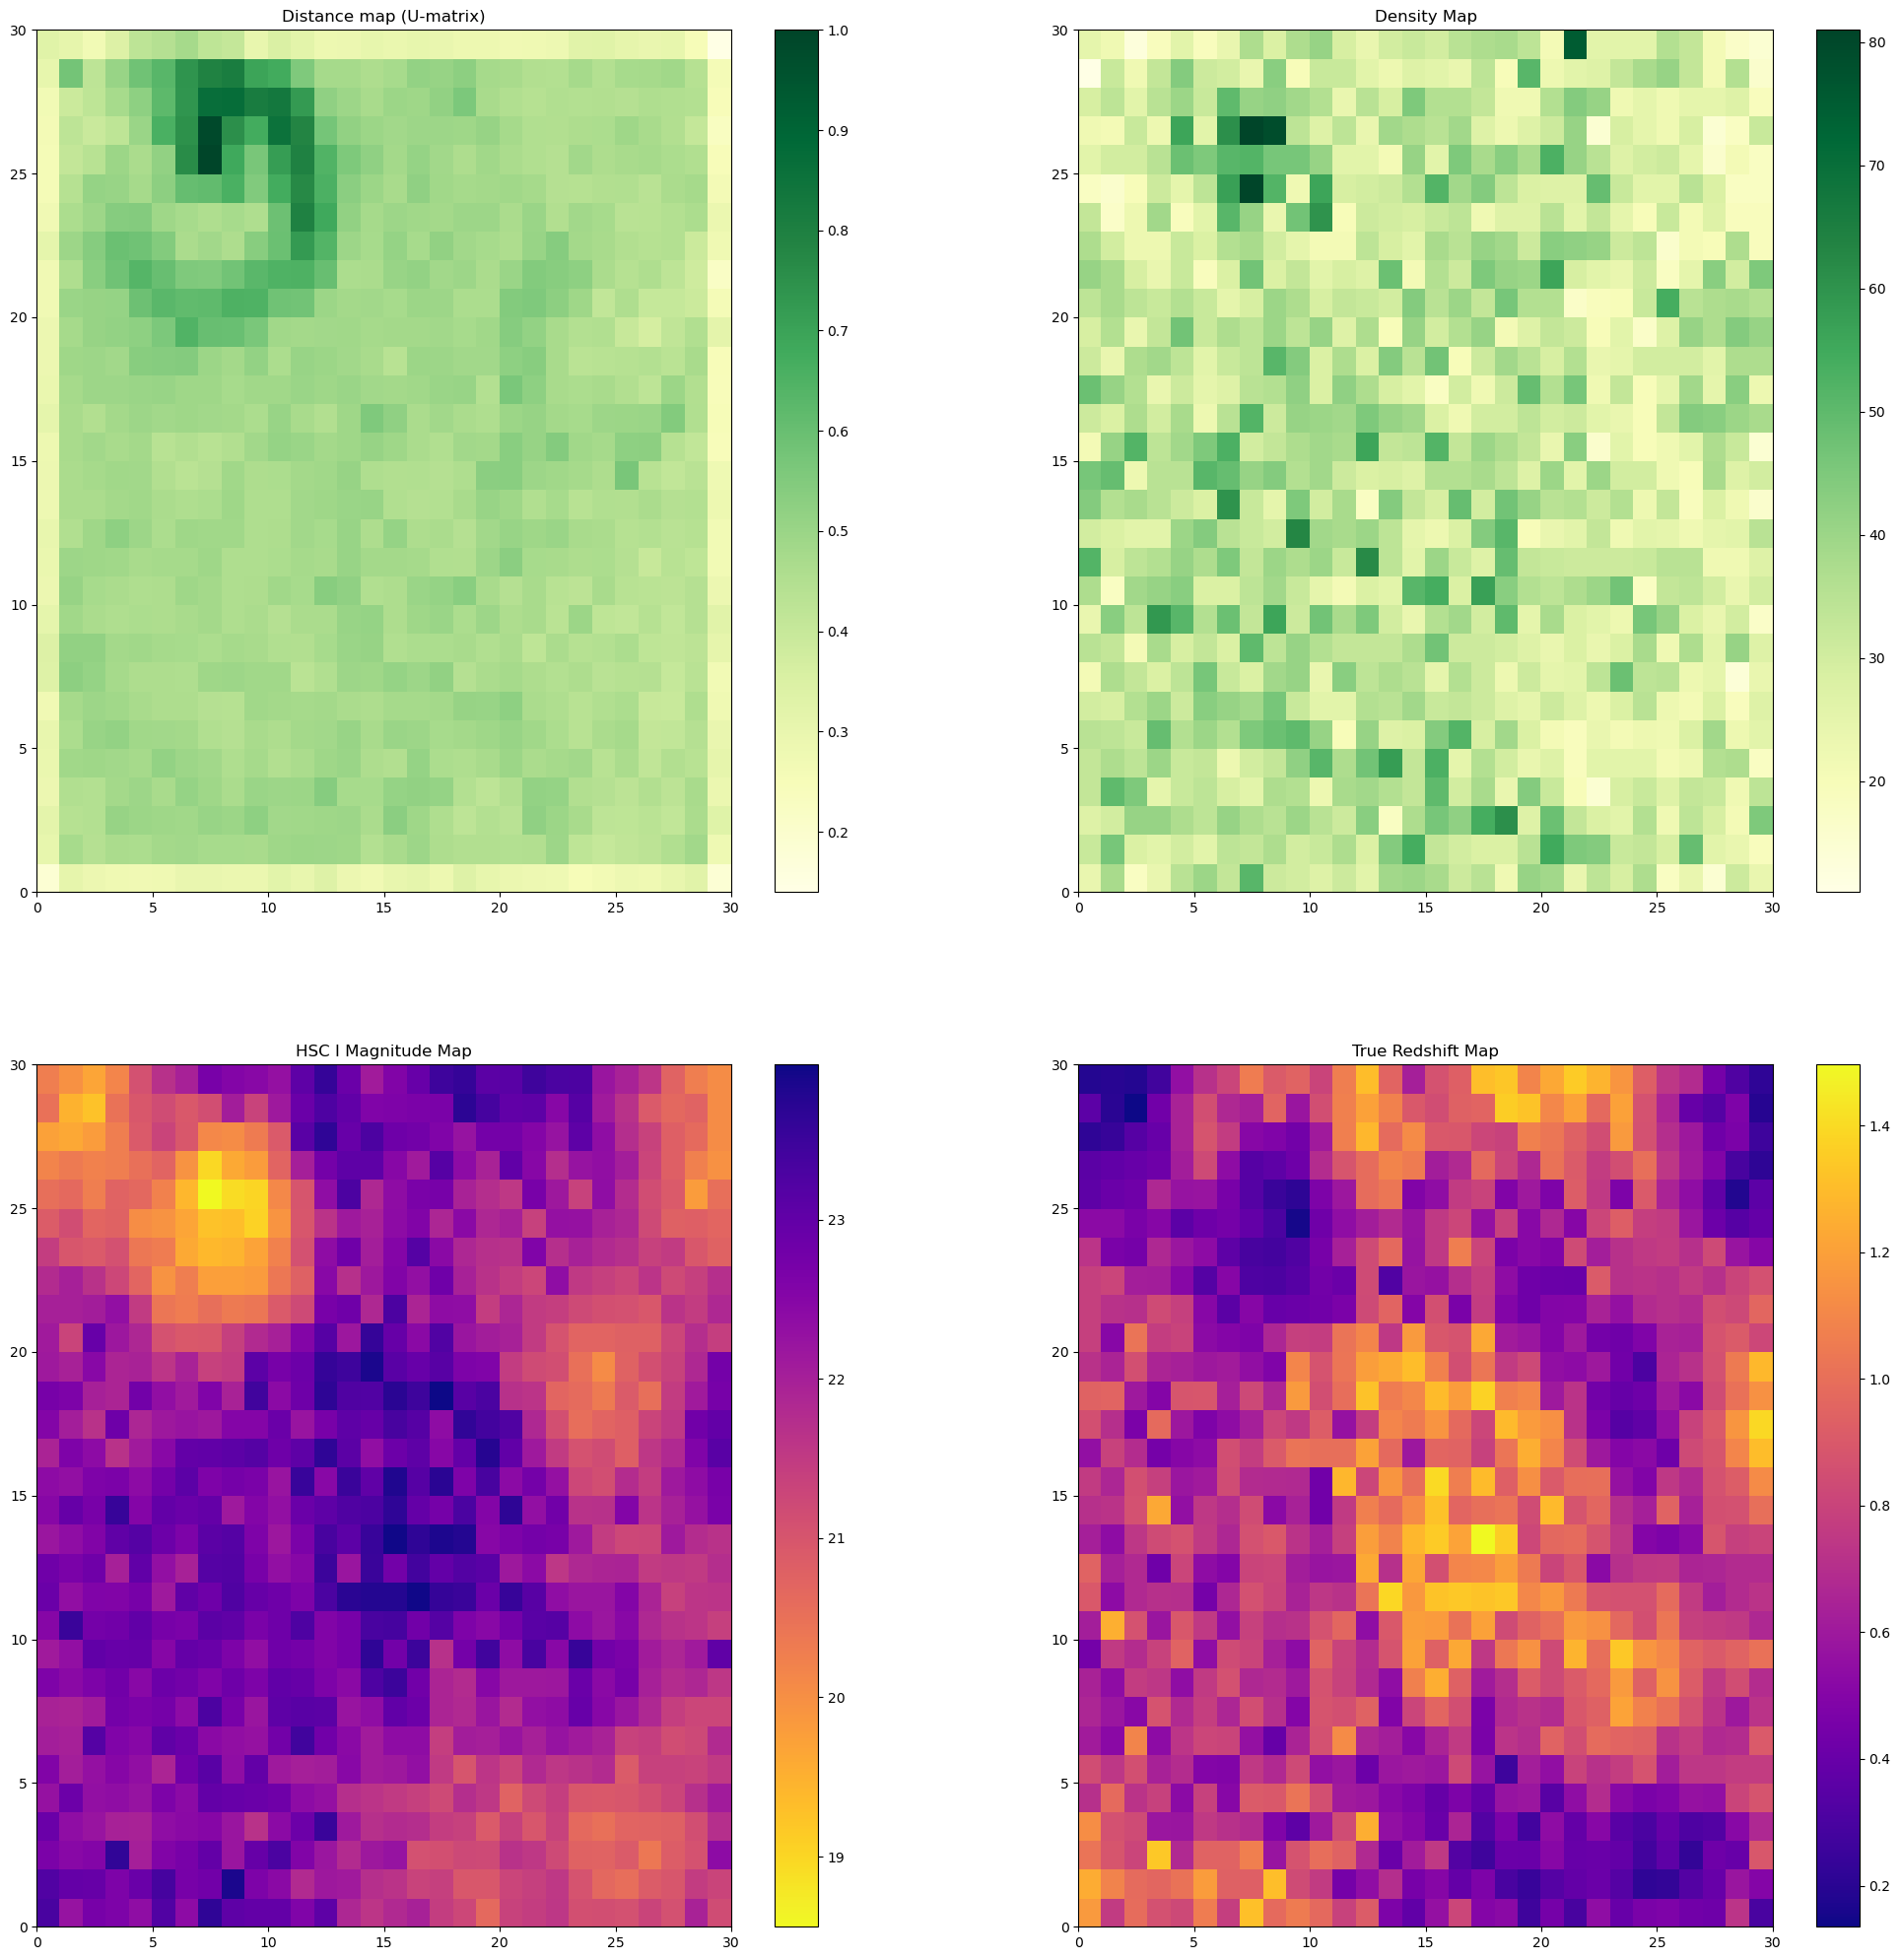

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.4]
29683.0
Topological error: 0.9345079675234983
Quantization error: 6.180662947393987
Average redshift std: 0.309069325928694


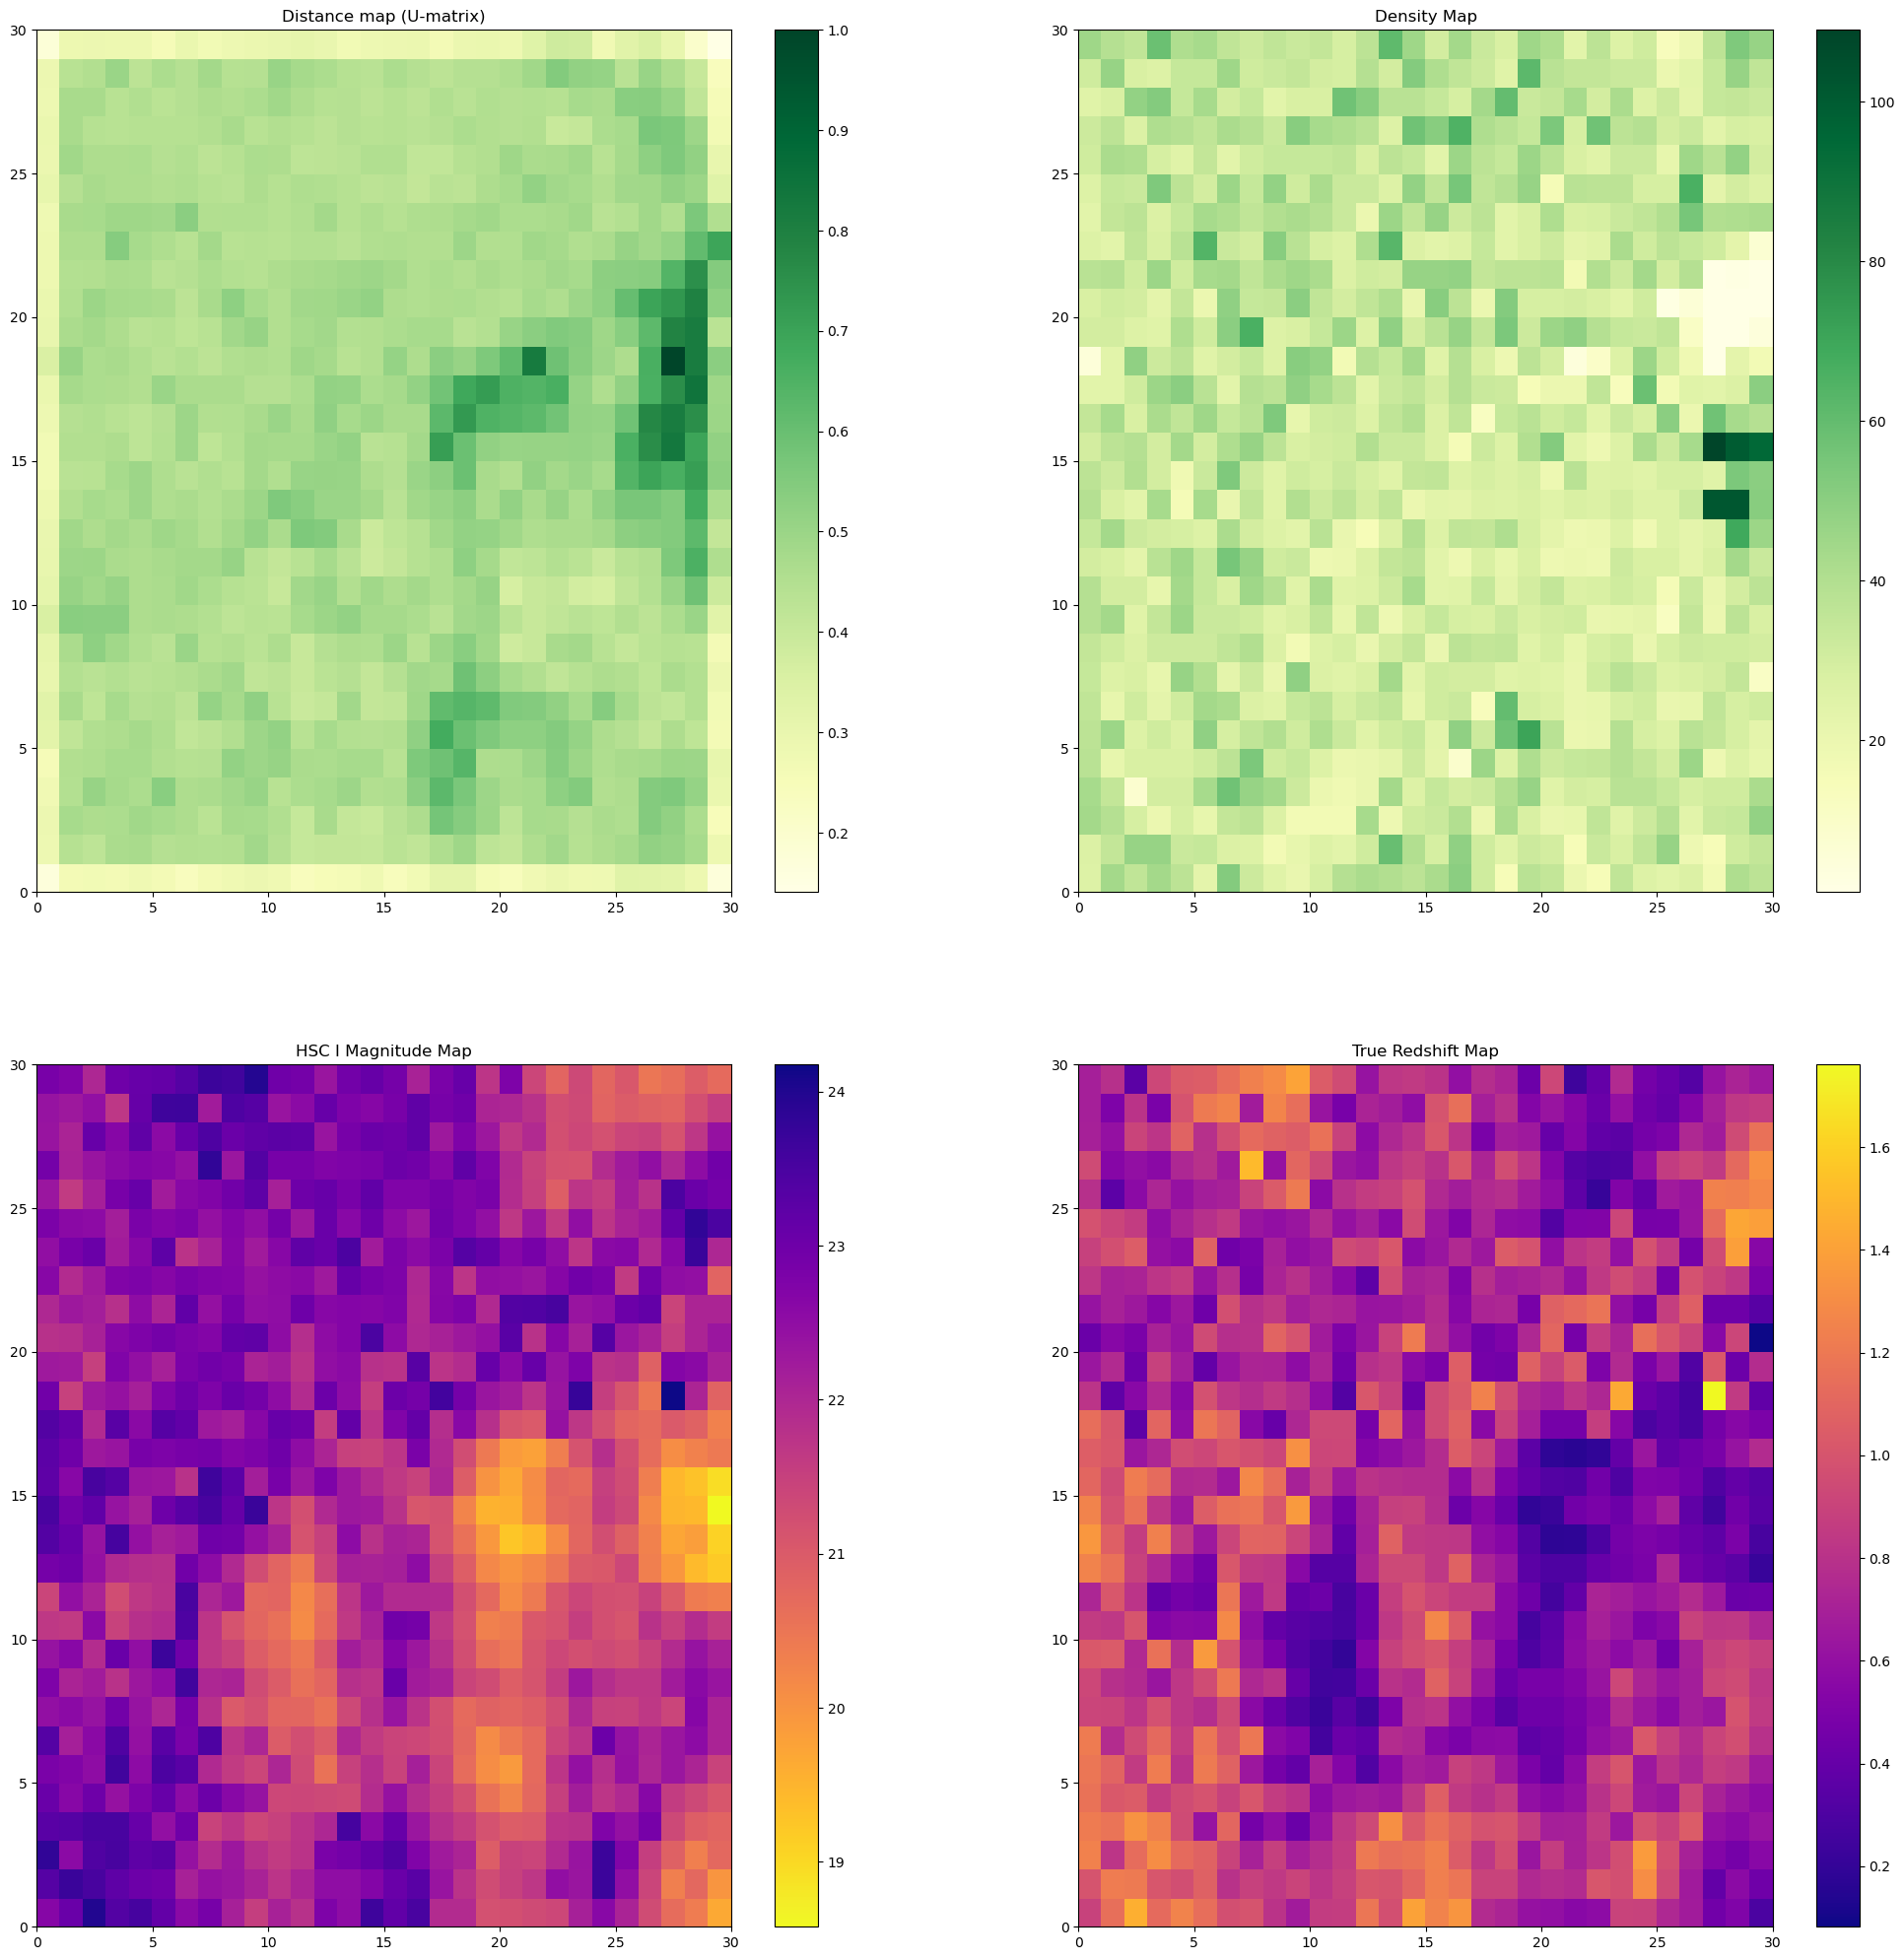

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.4]
29683.0
Topological error: 0.9586295185796584
Quantization error: 6.194667875241878
Average redshift std: 0.31906918987790006


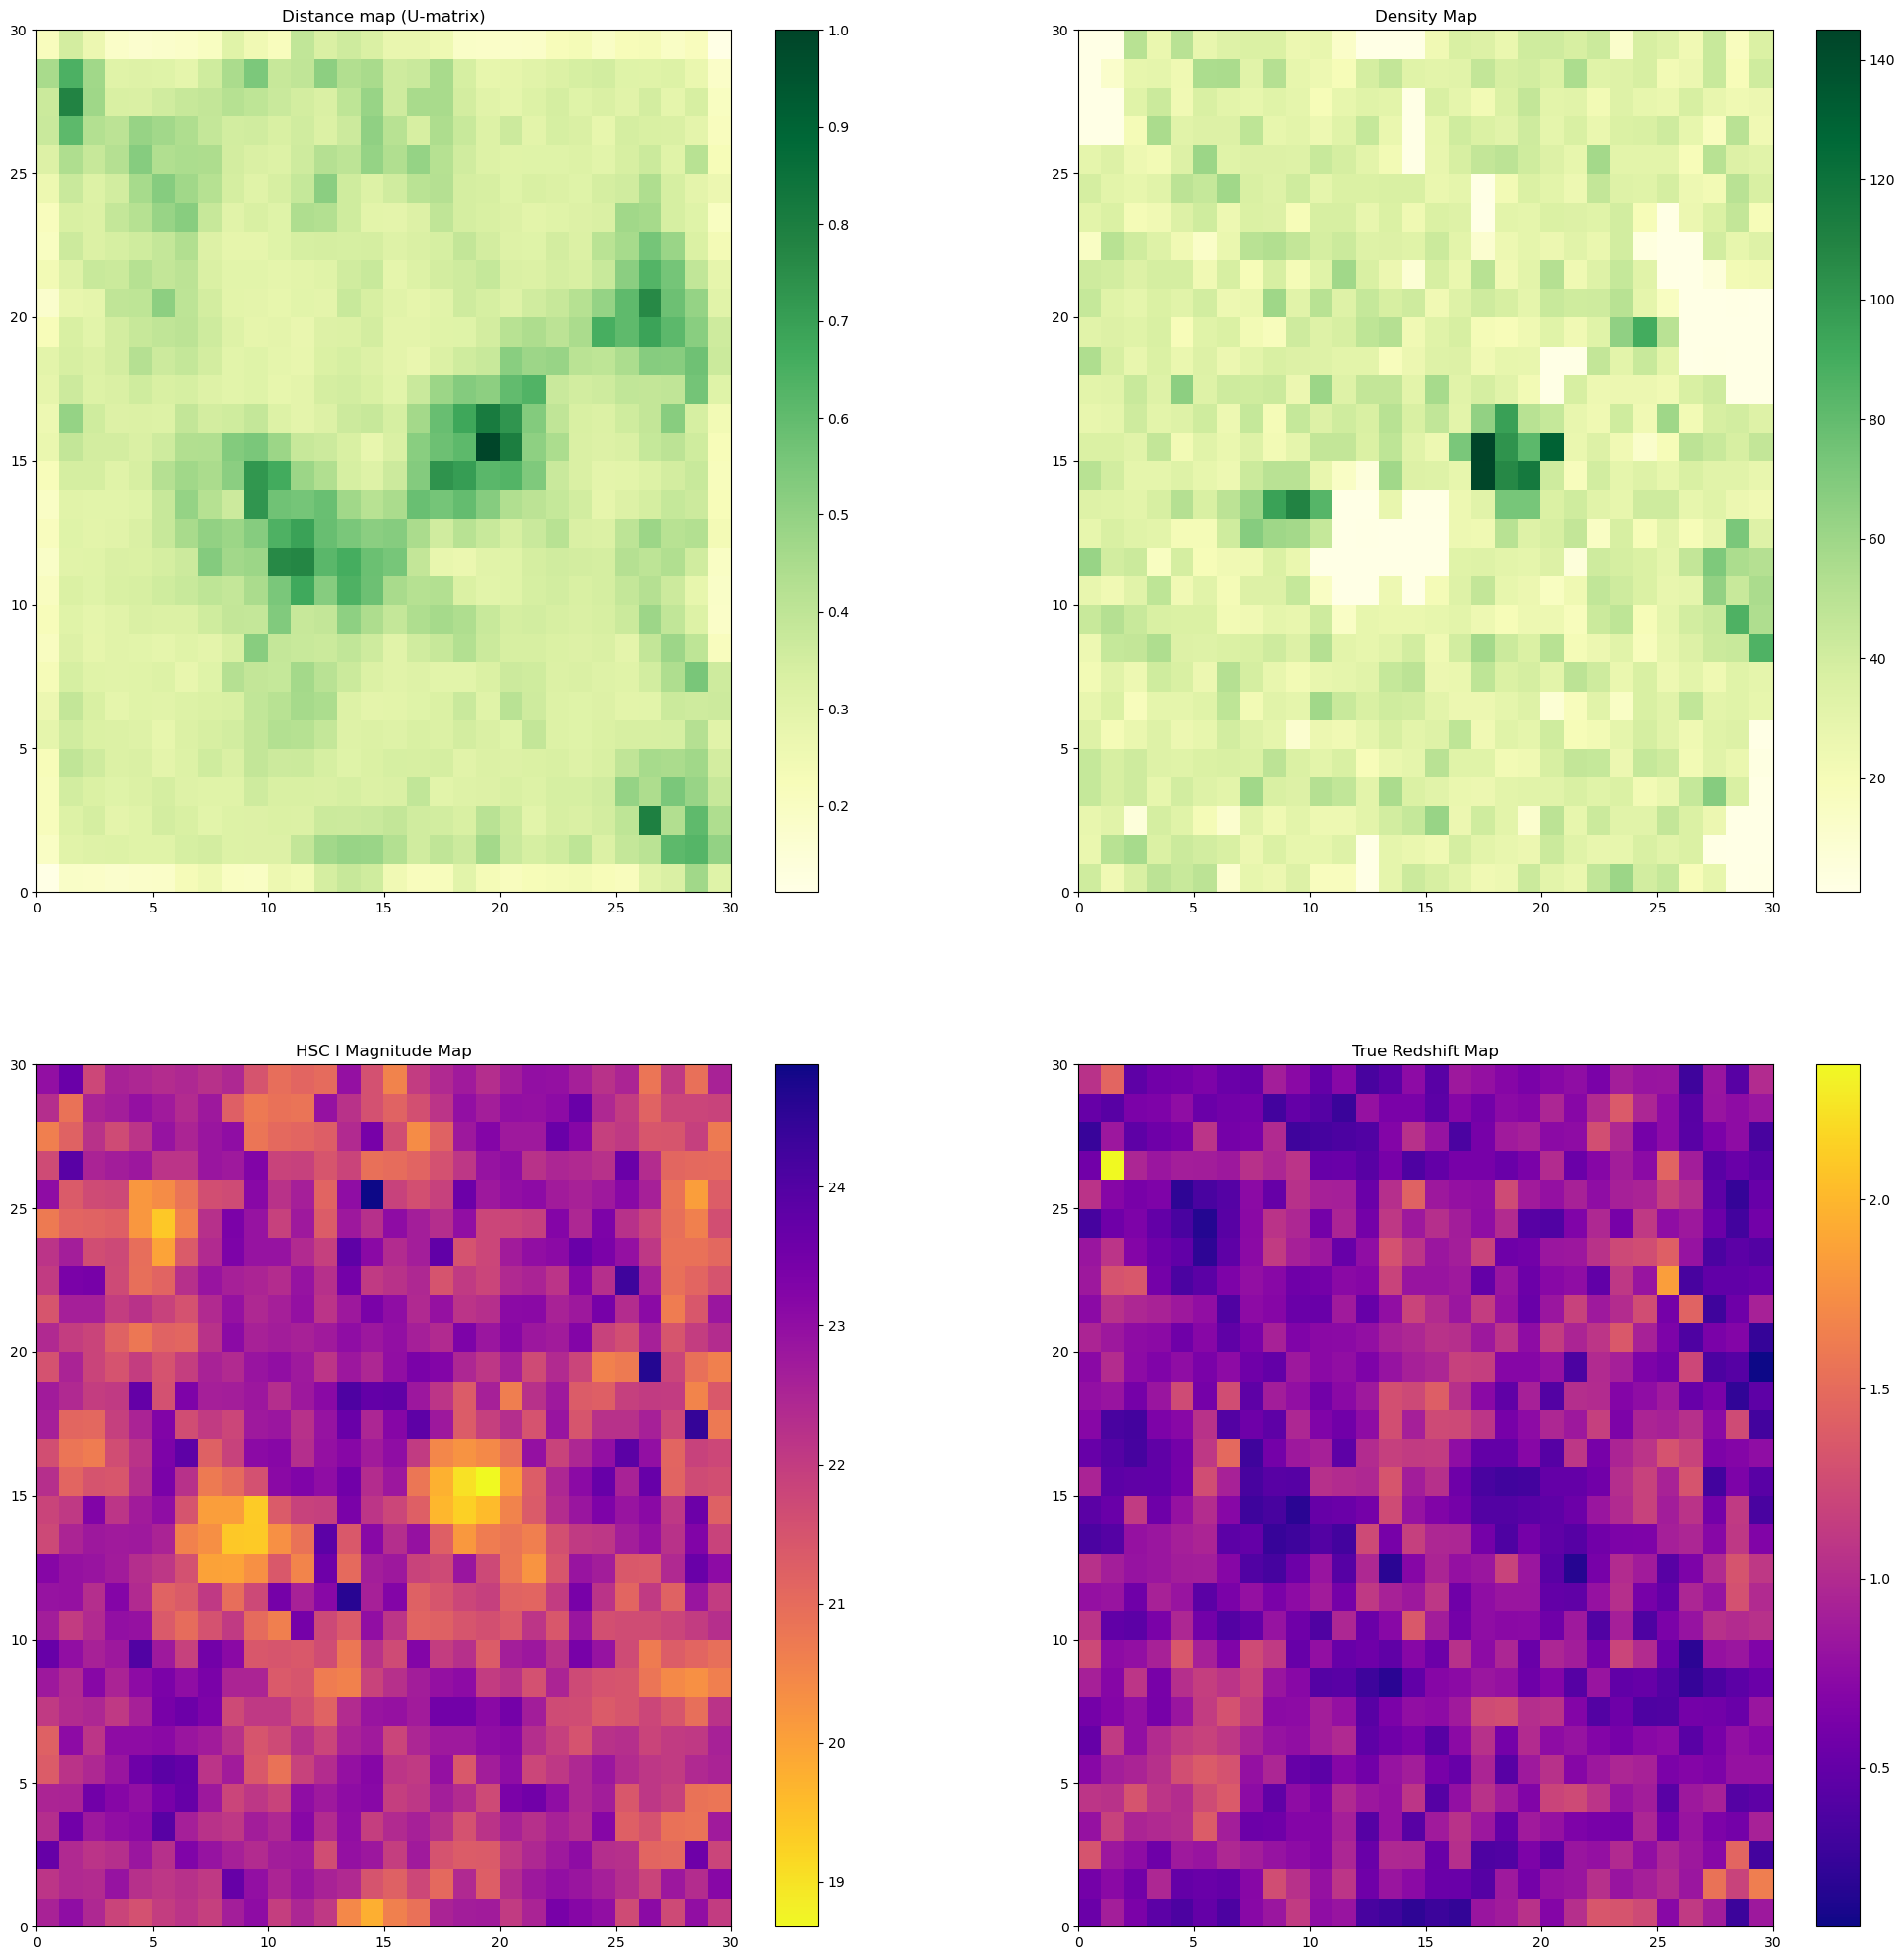

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.5]
29683.0
Topological error: 0.694134689889836
Quantization error: 6.187015854365155
Average redshift std: 0.34044961383190203


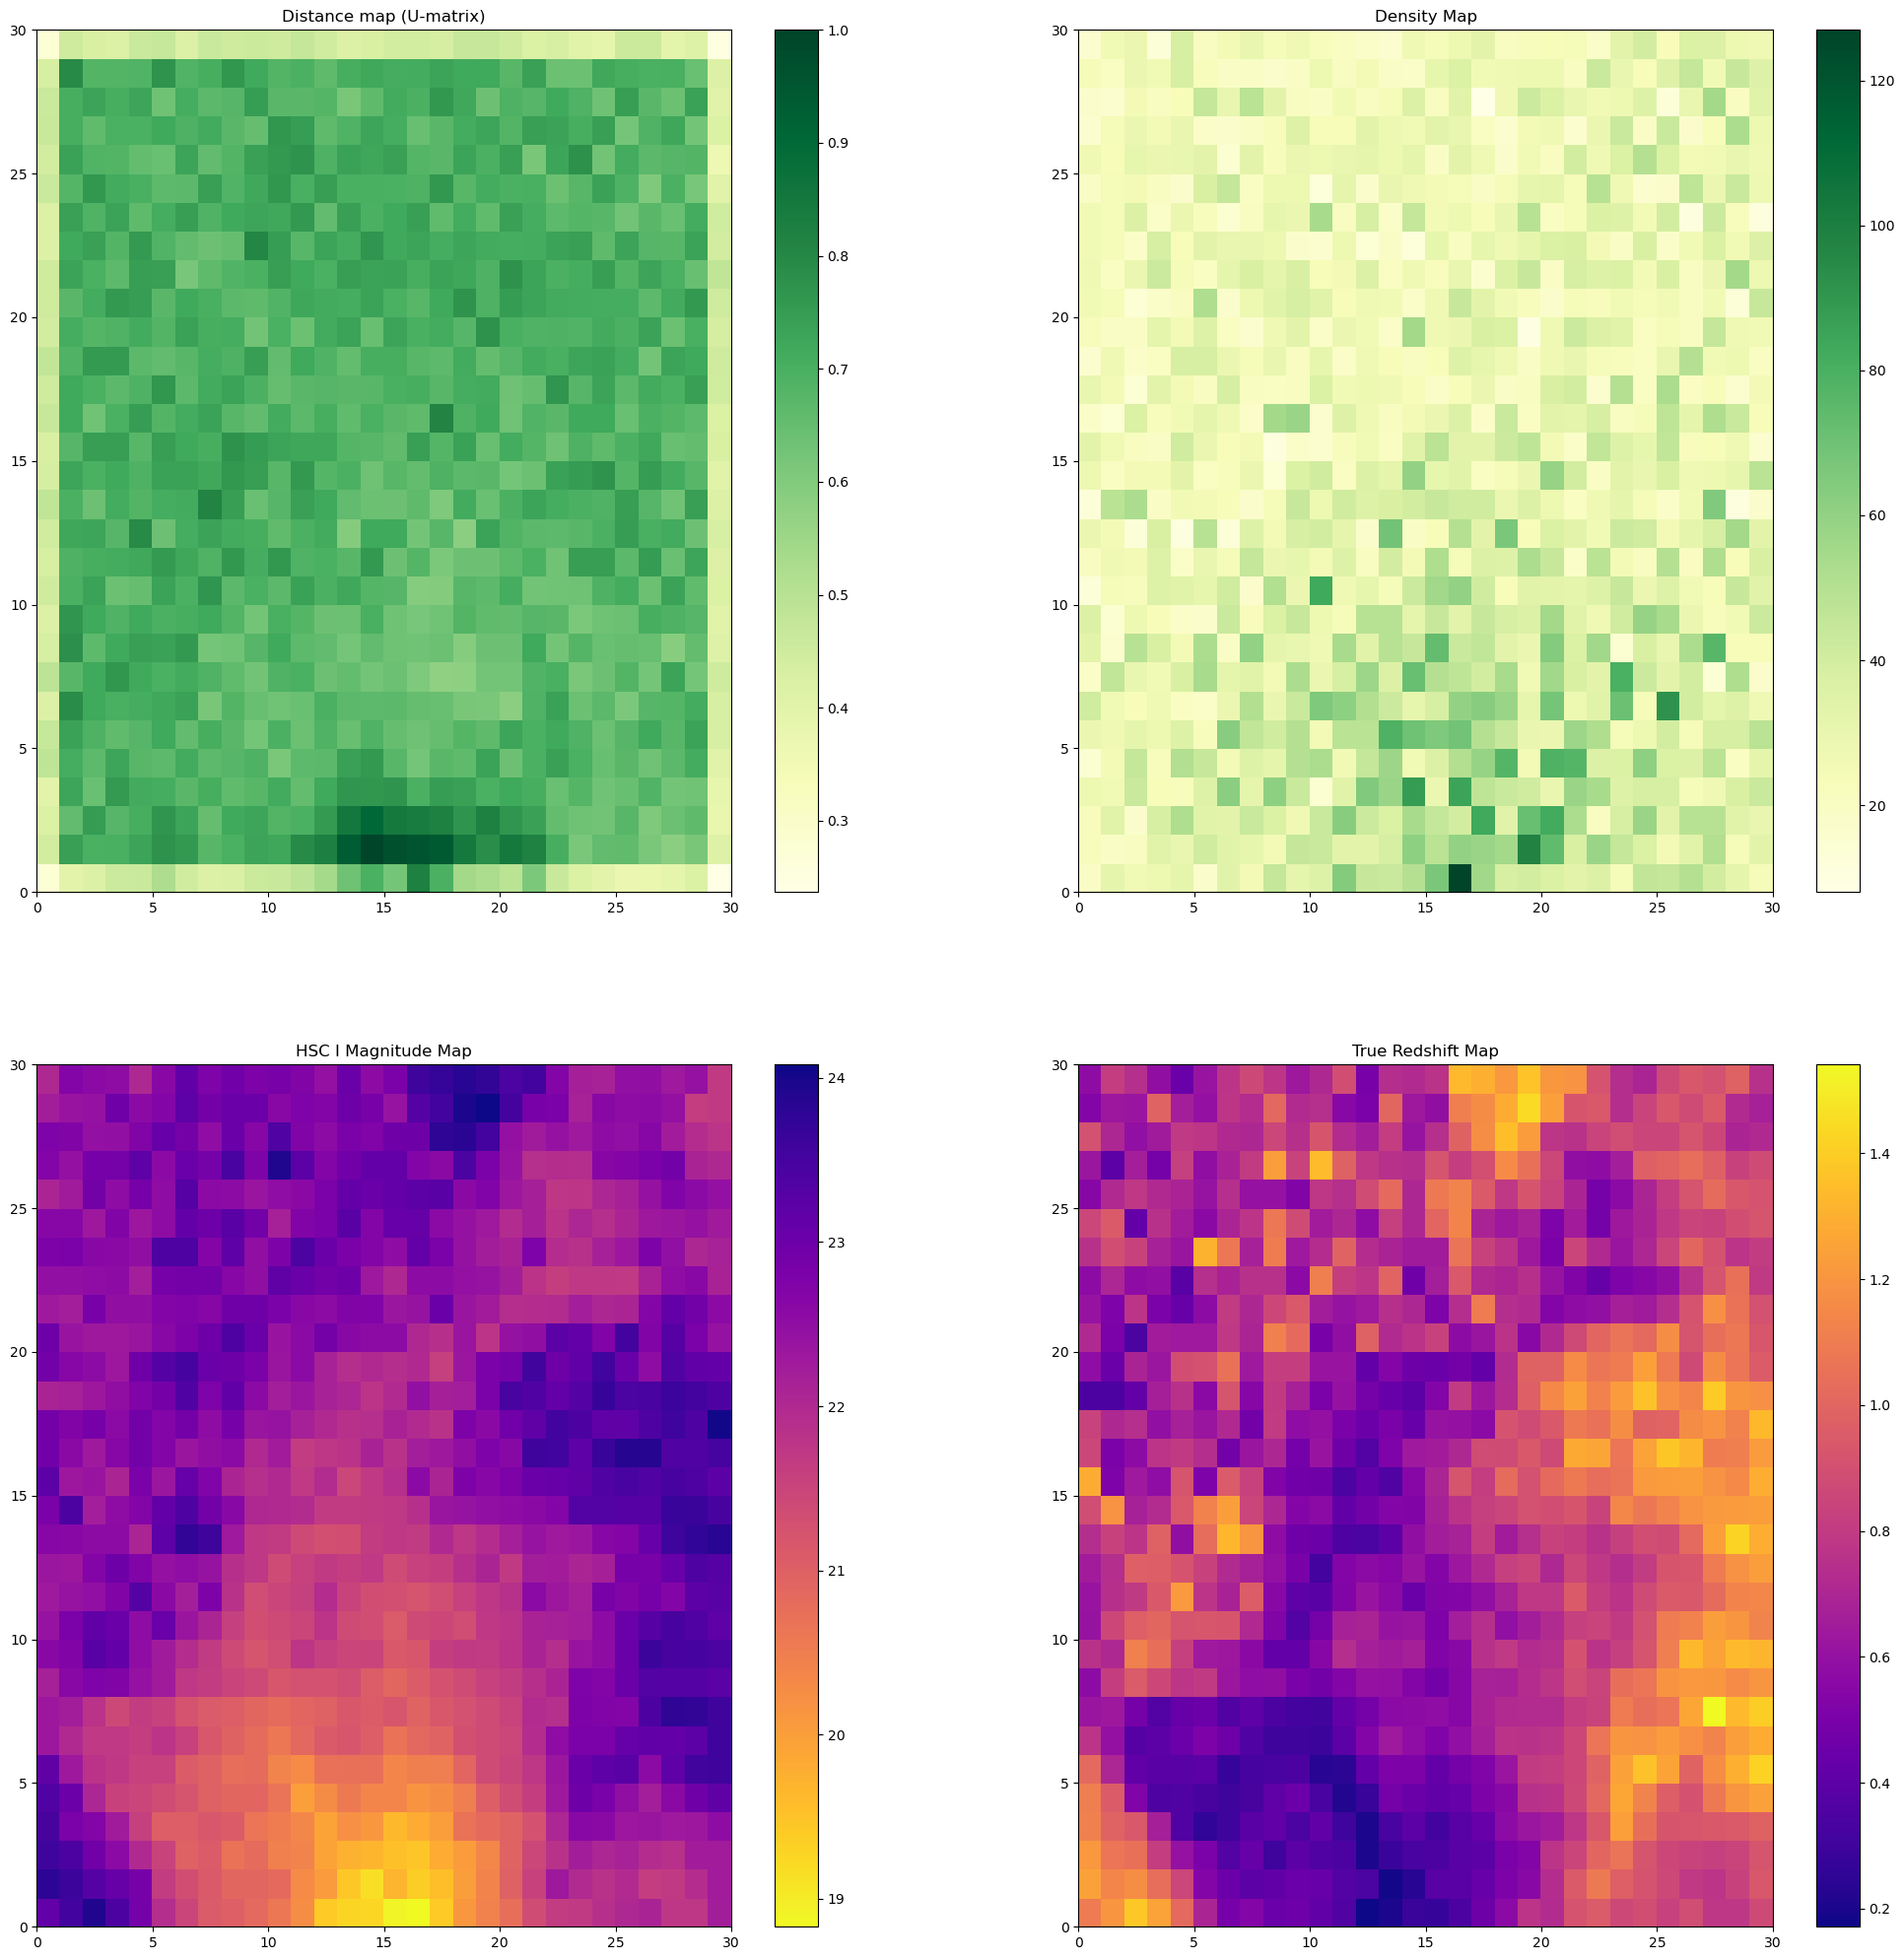

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.5]
29683.0
Topological error: 0.7427820638075666
Quantization error: 6.191225716448817
Average redshift std: 0.348456715241336


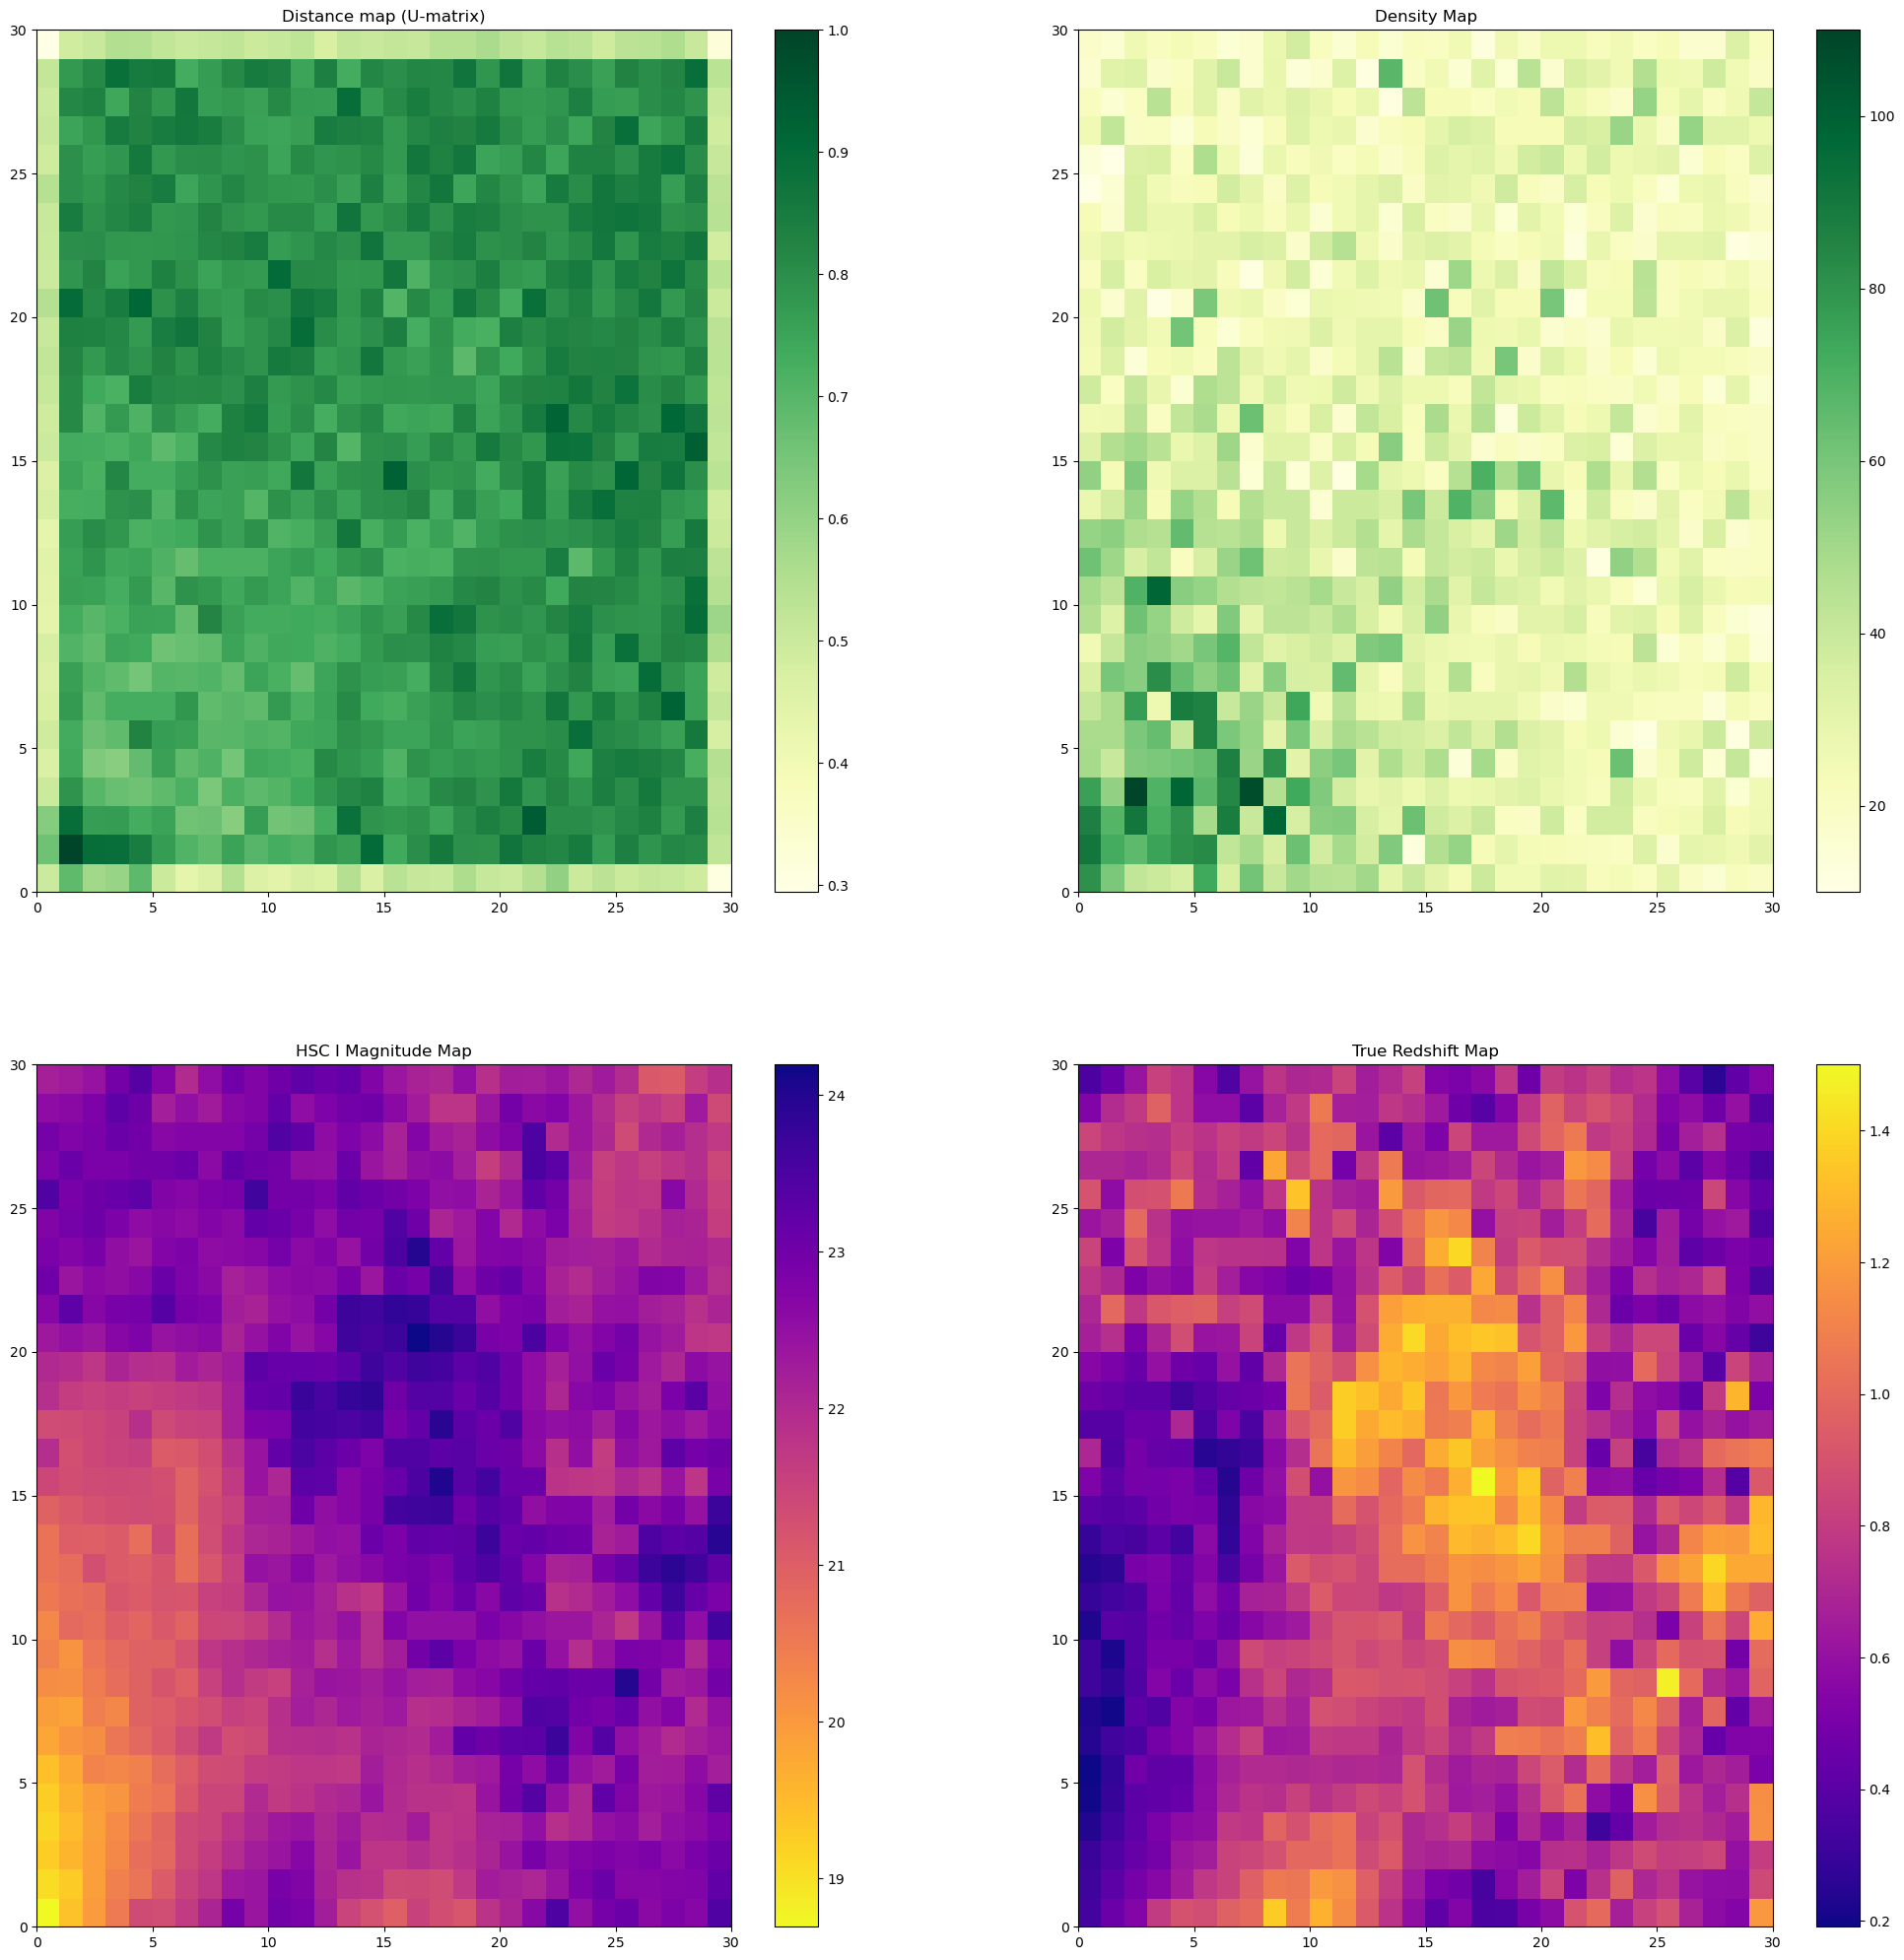

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.5]
29683.0
Topological error: 0.8616042852811373
Quantization error: 6.198915755578645
Average redshift std: 0.3342767527044813


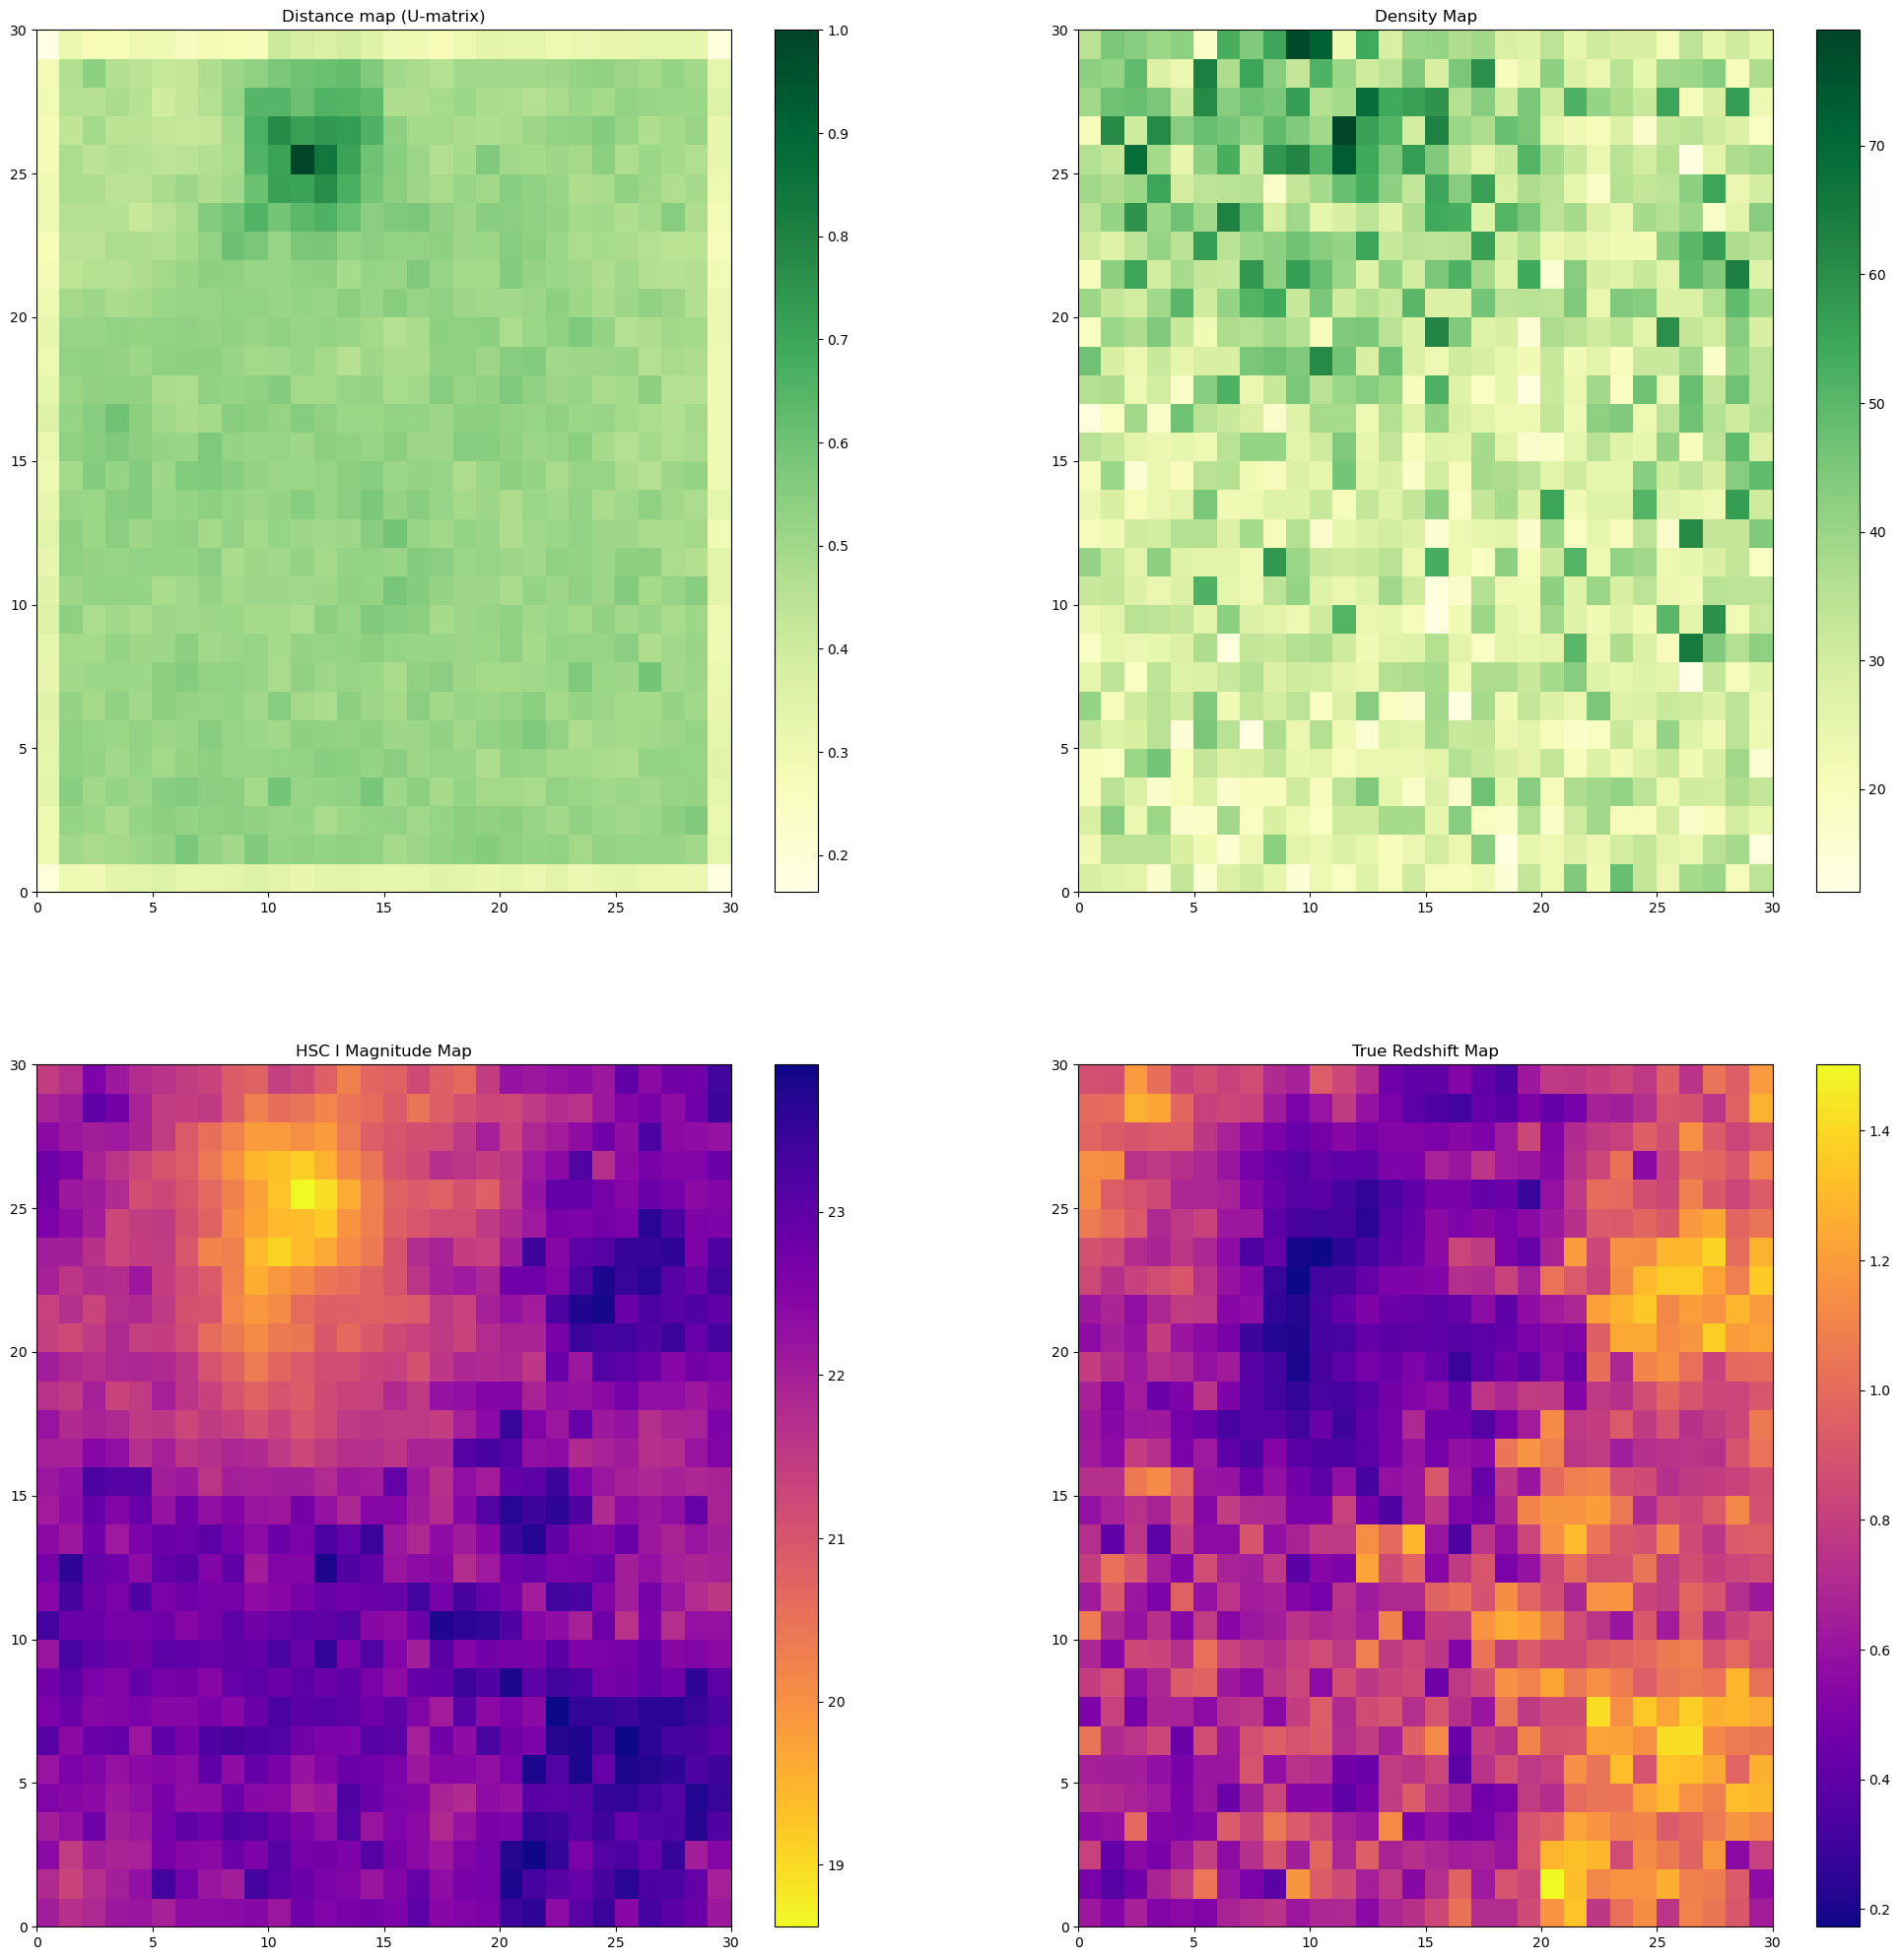

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.5]
29683.0
Topological error: 0.900987096991544
Quantization error: 6.216906004641758
Average redshift std: 0.33031378812353446


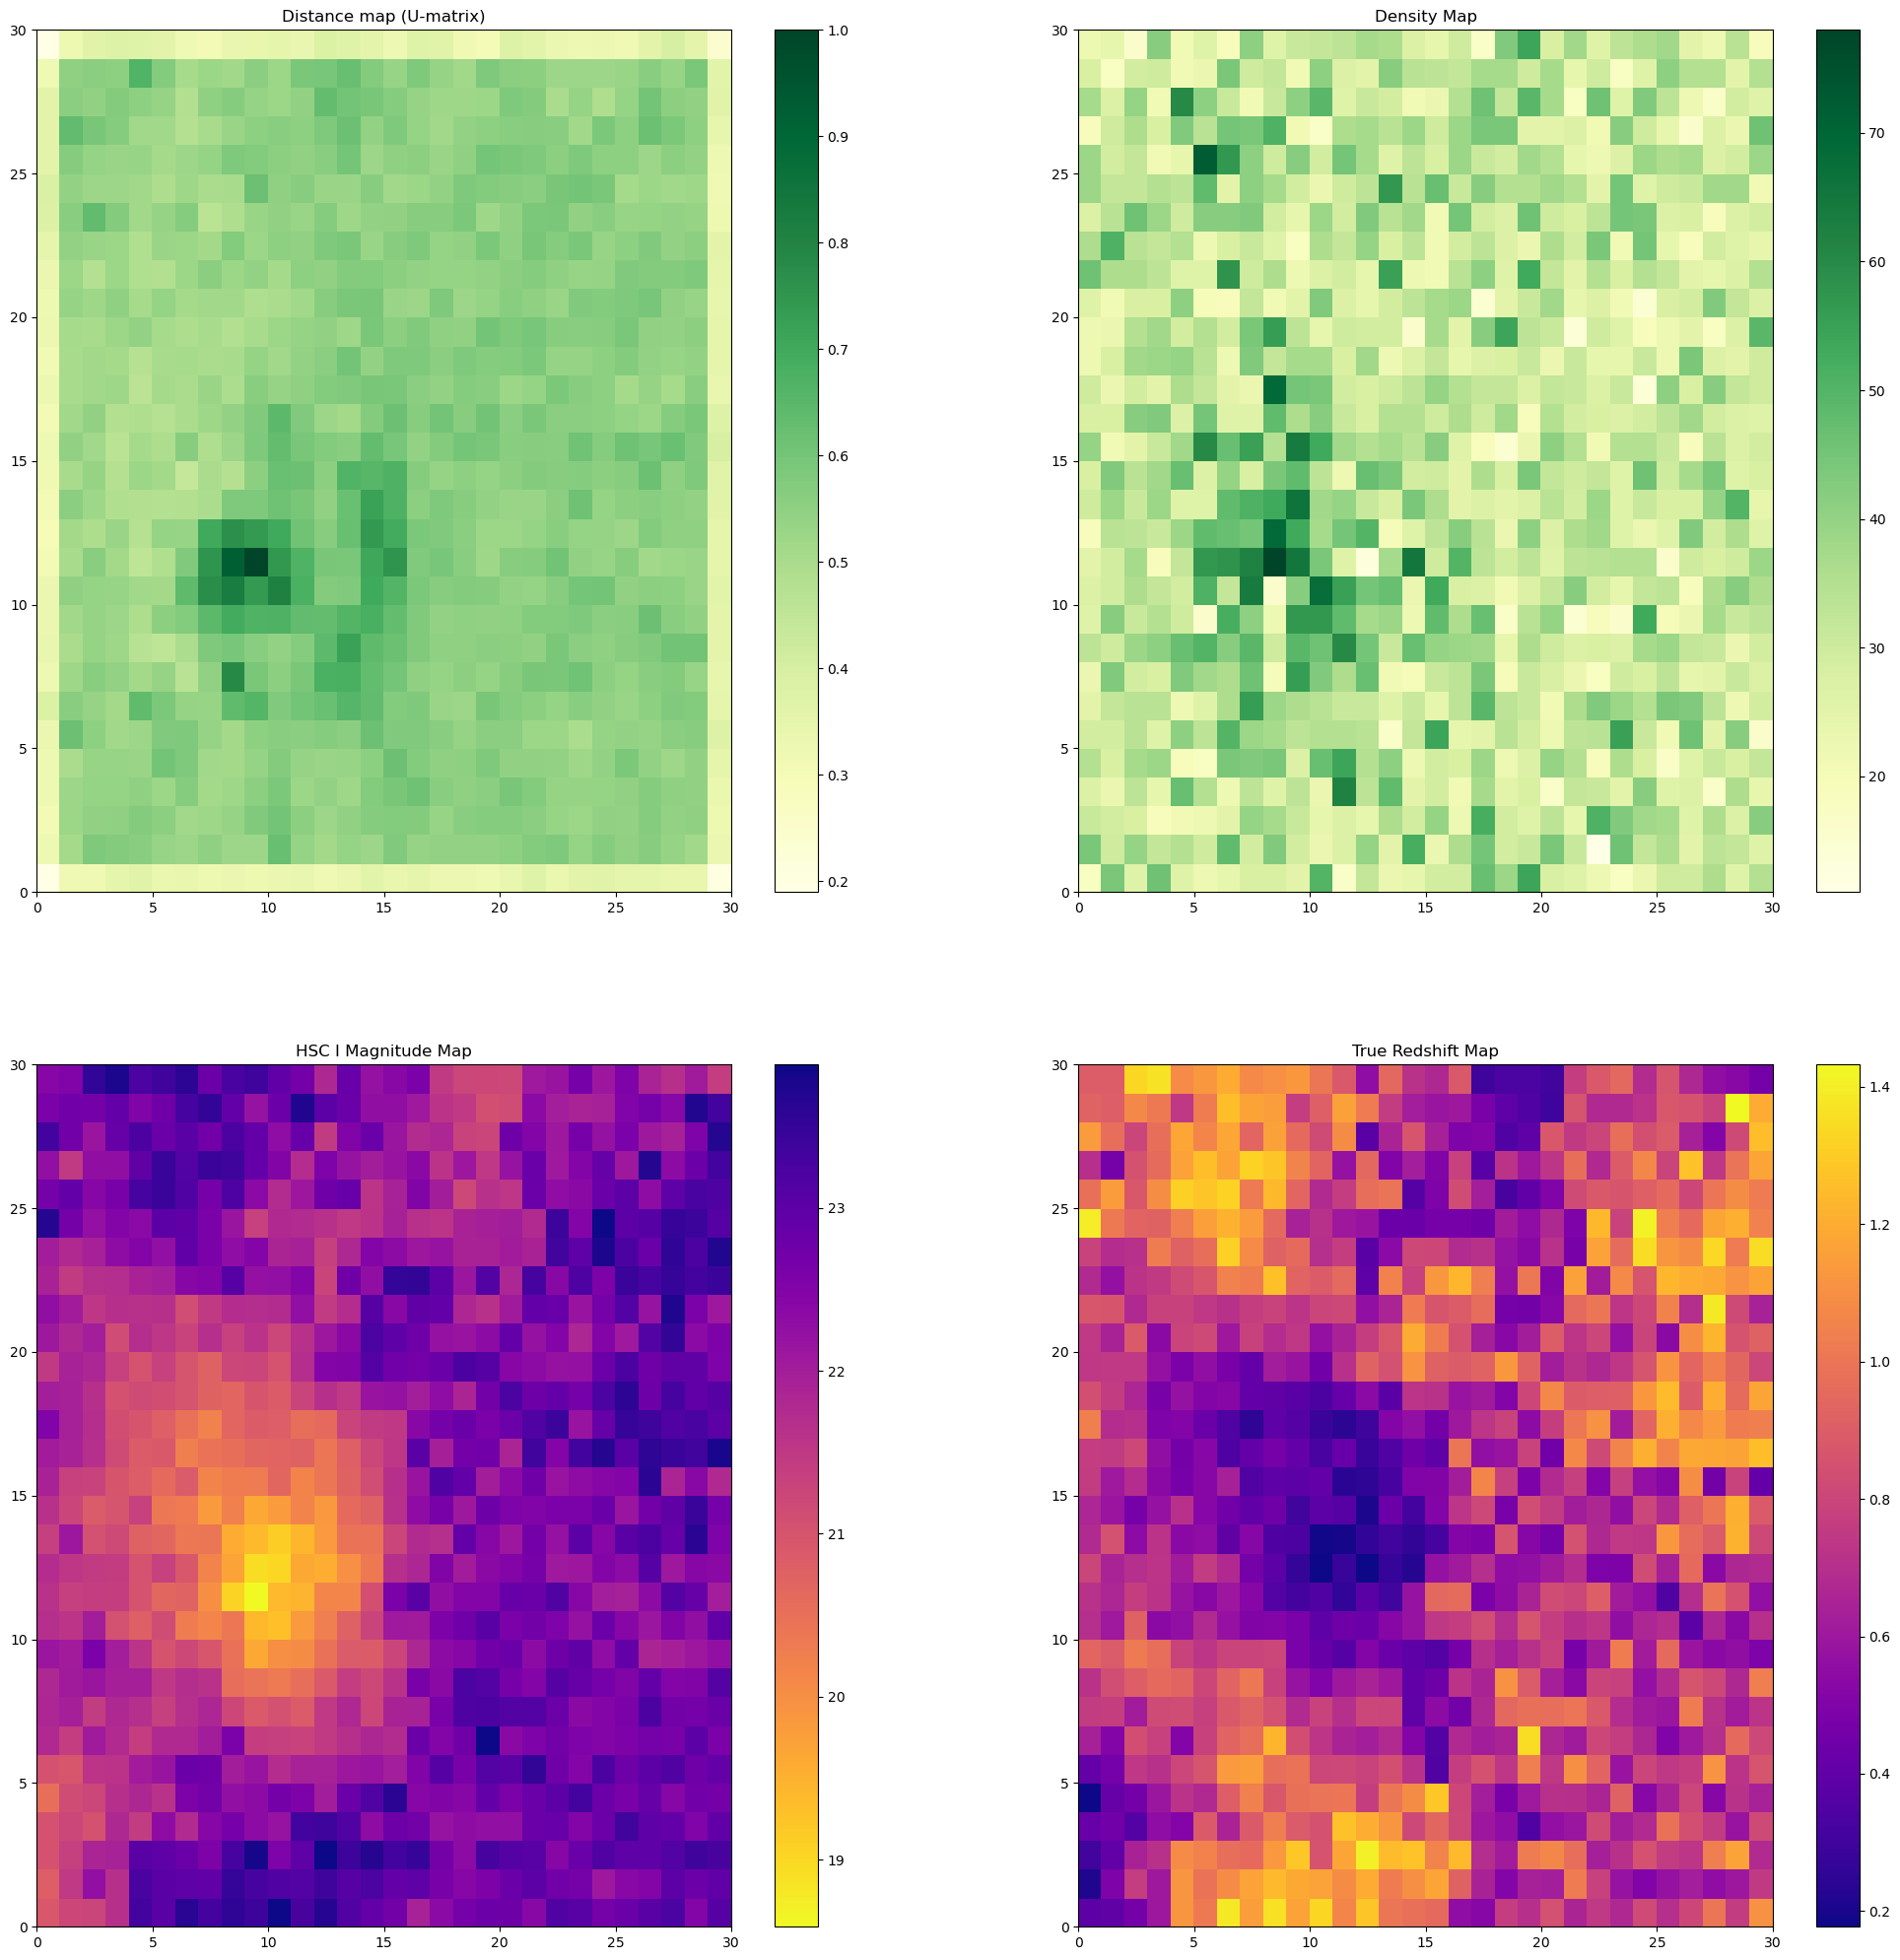

Data shape: (29683, 102)
Start making diagrams...
[30, 0.6, 0.5]
29683.0
Topological error: 0.9261867061954654
Quantization error: 6.236788189088814
Average redshift std: 0.33161272365614153


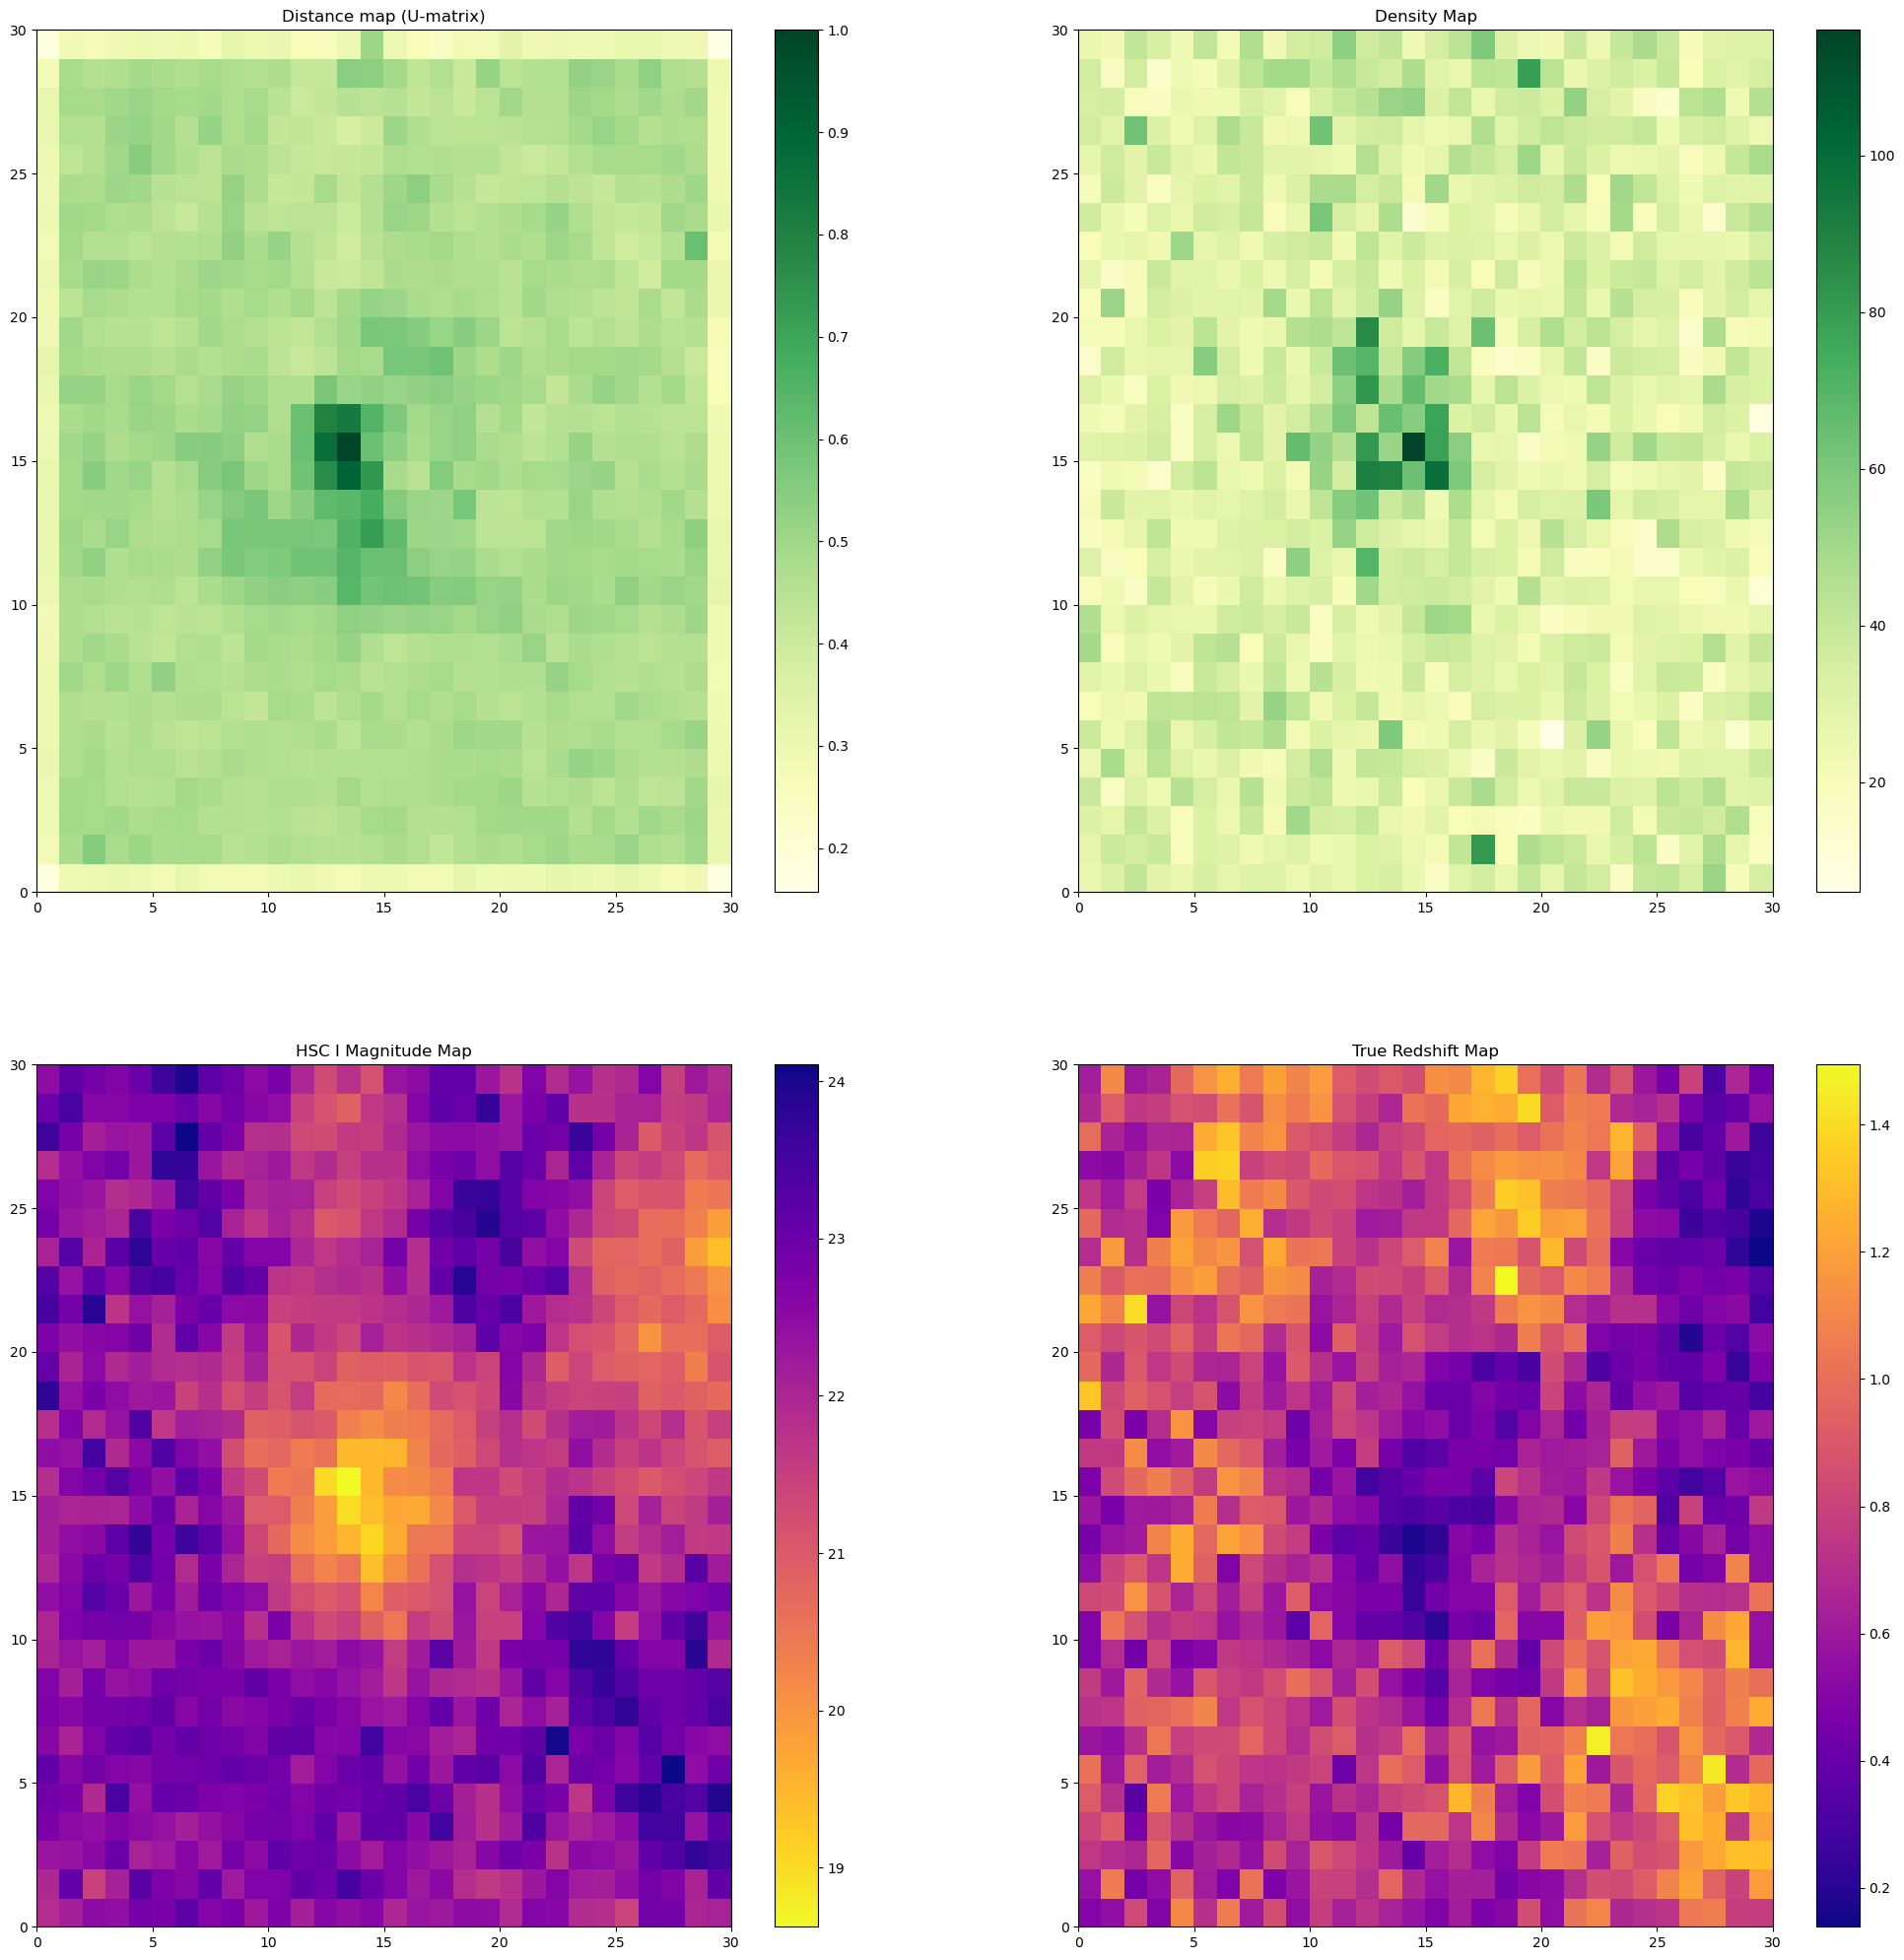

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.5]
29683.0
Topological error: 0.9332951521072668
Quantization error: 6.244632837951483
Average redshift std: 0.3274962808712366


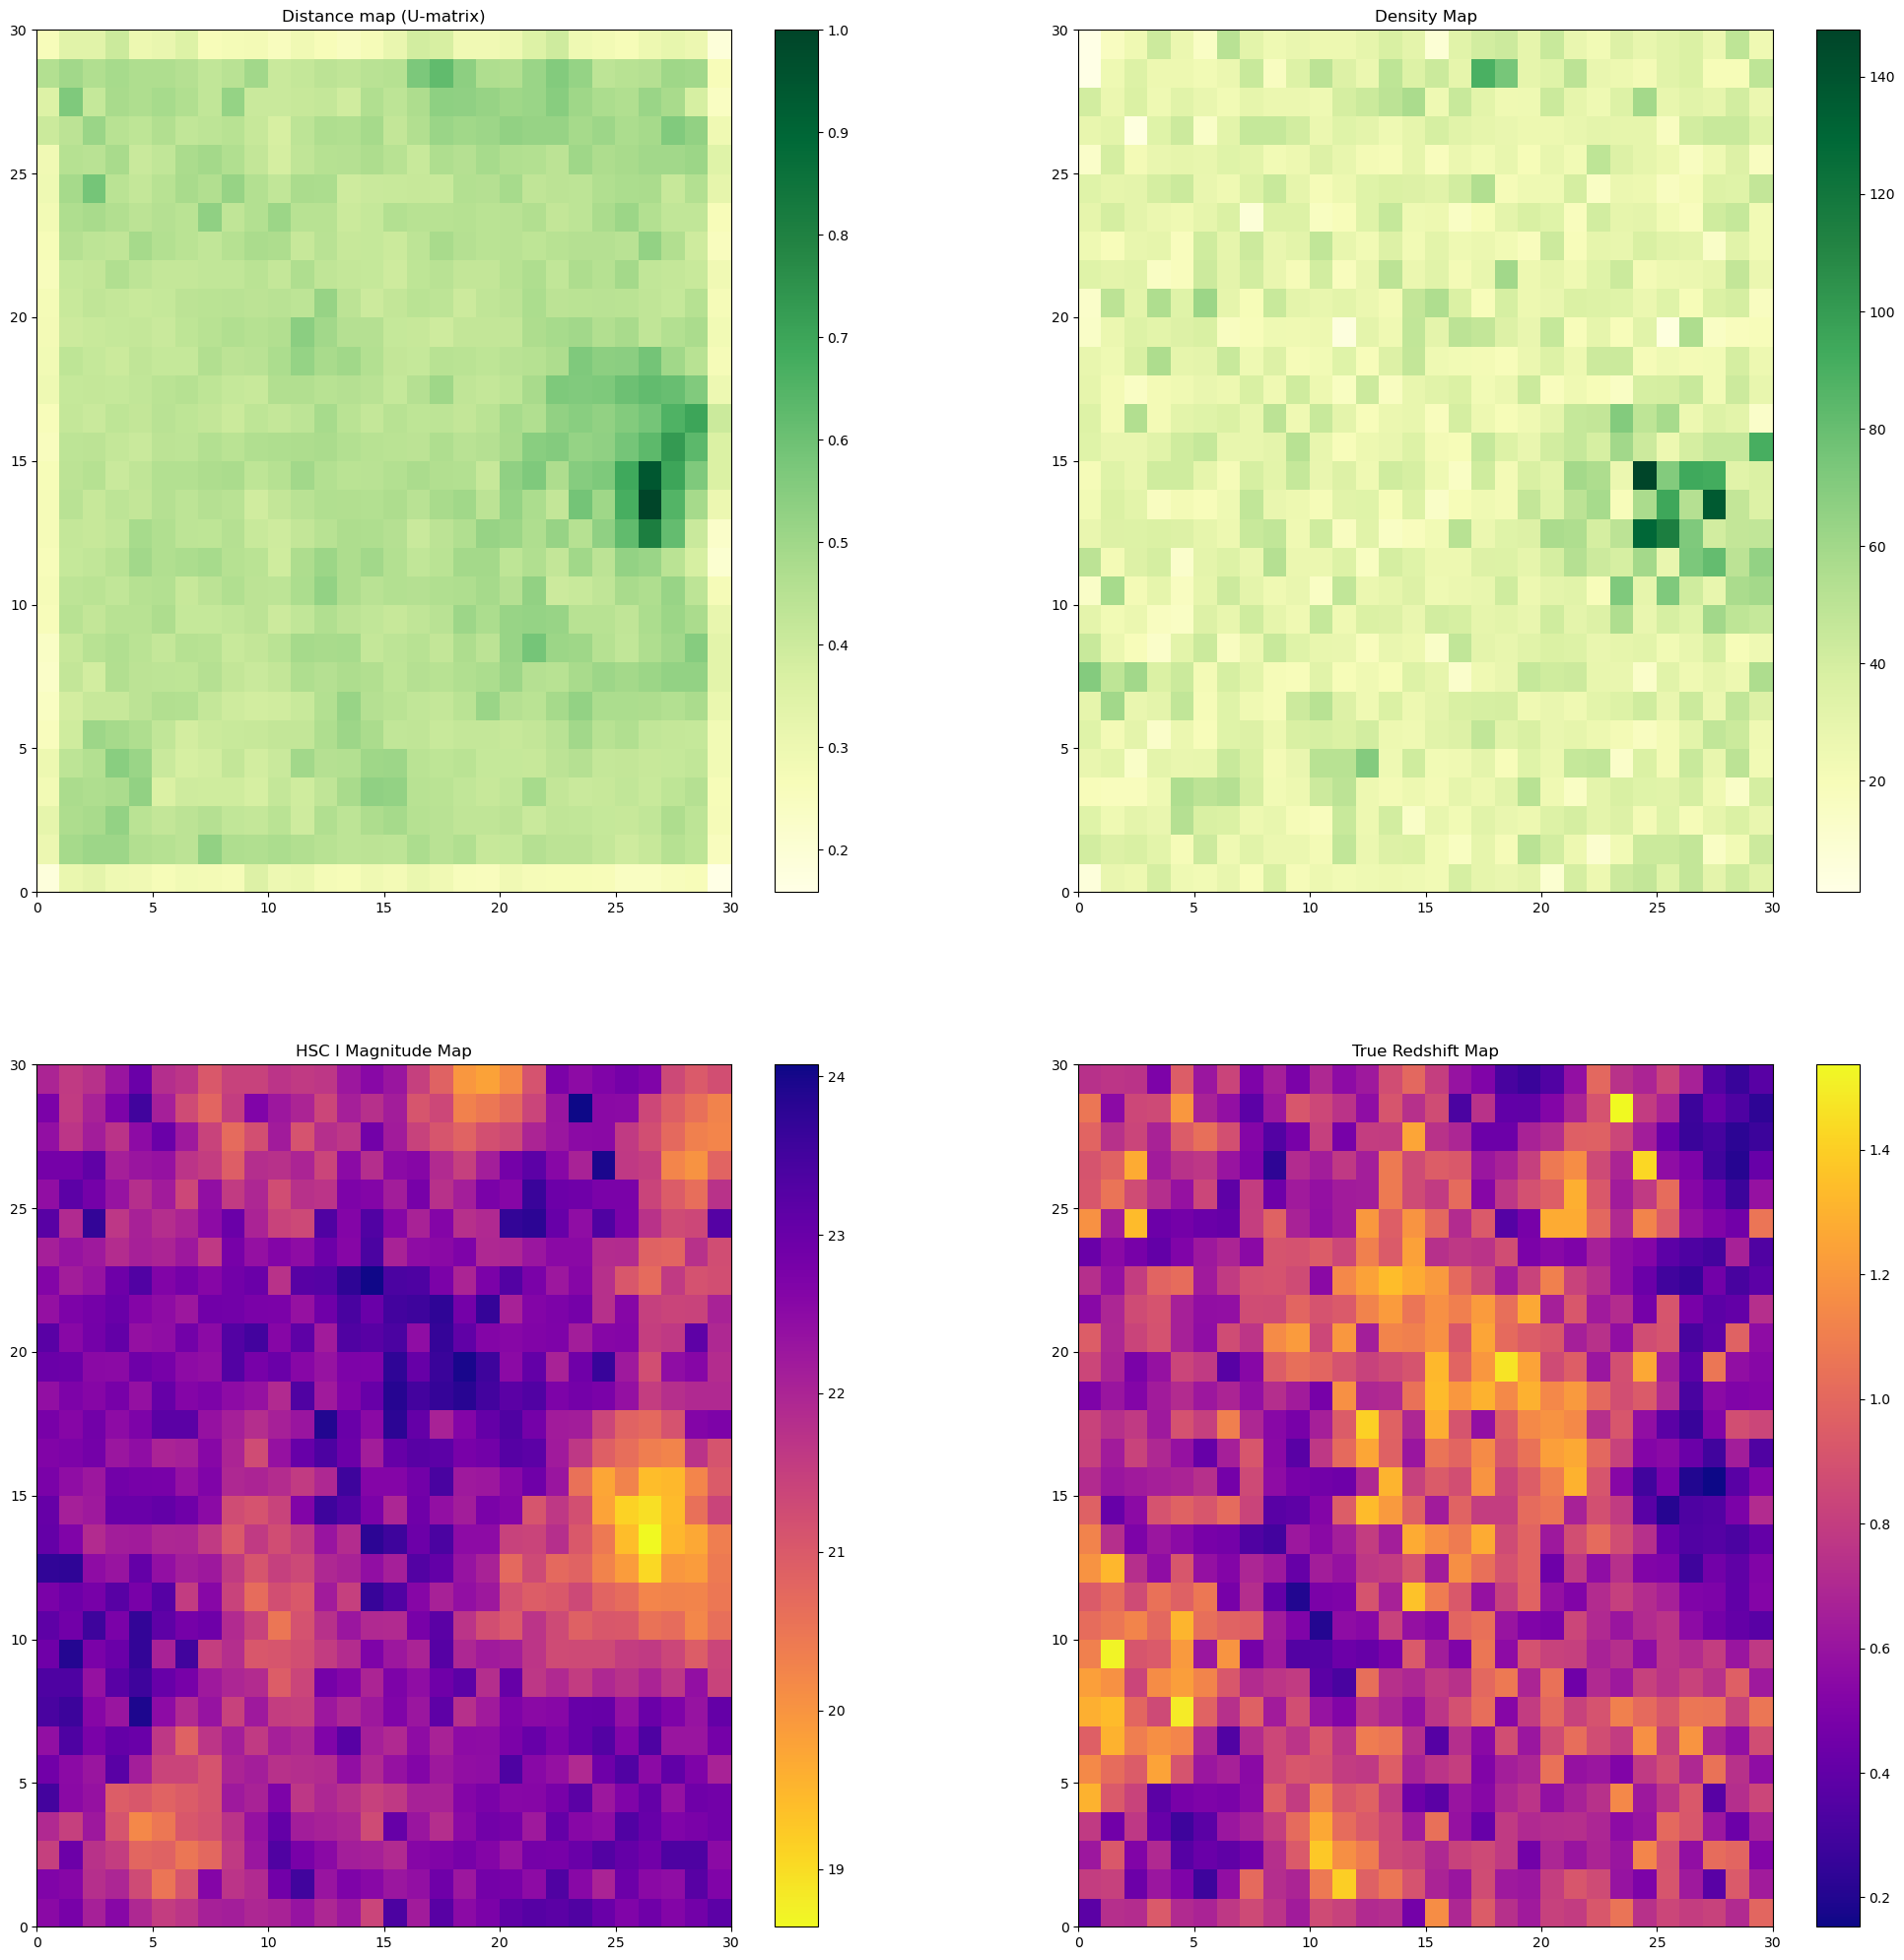

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.5]
29683.0
Topological error: 0.946669811002931
Quantization error: 6.257238870498319
Average redshift std: 0.3385112577087049


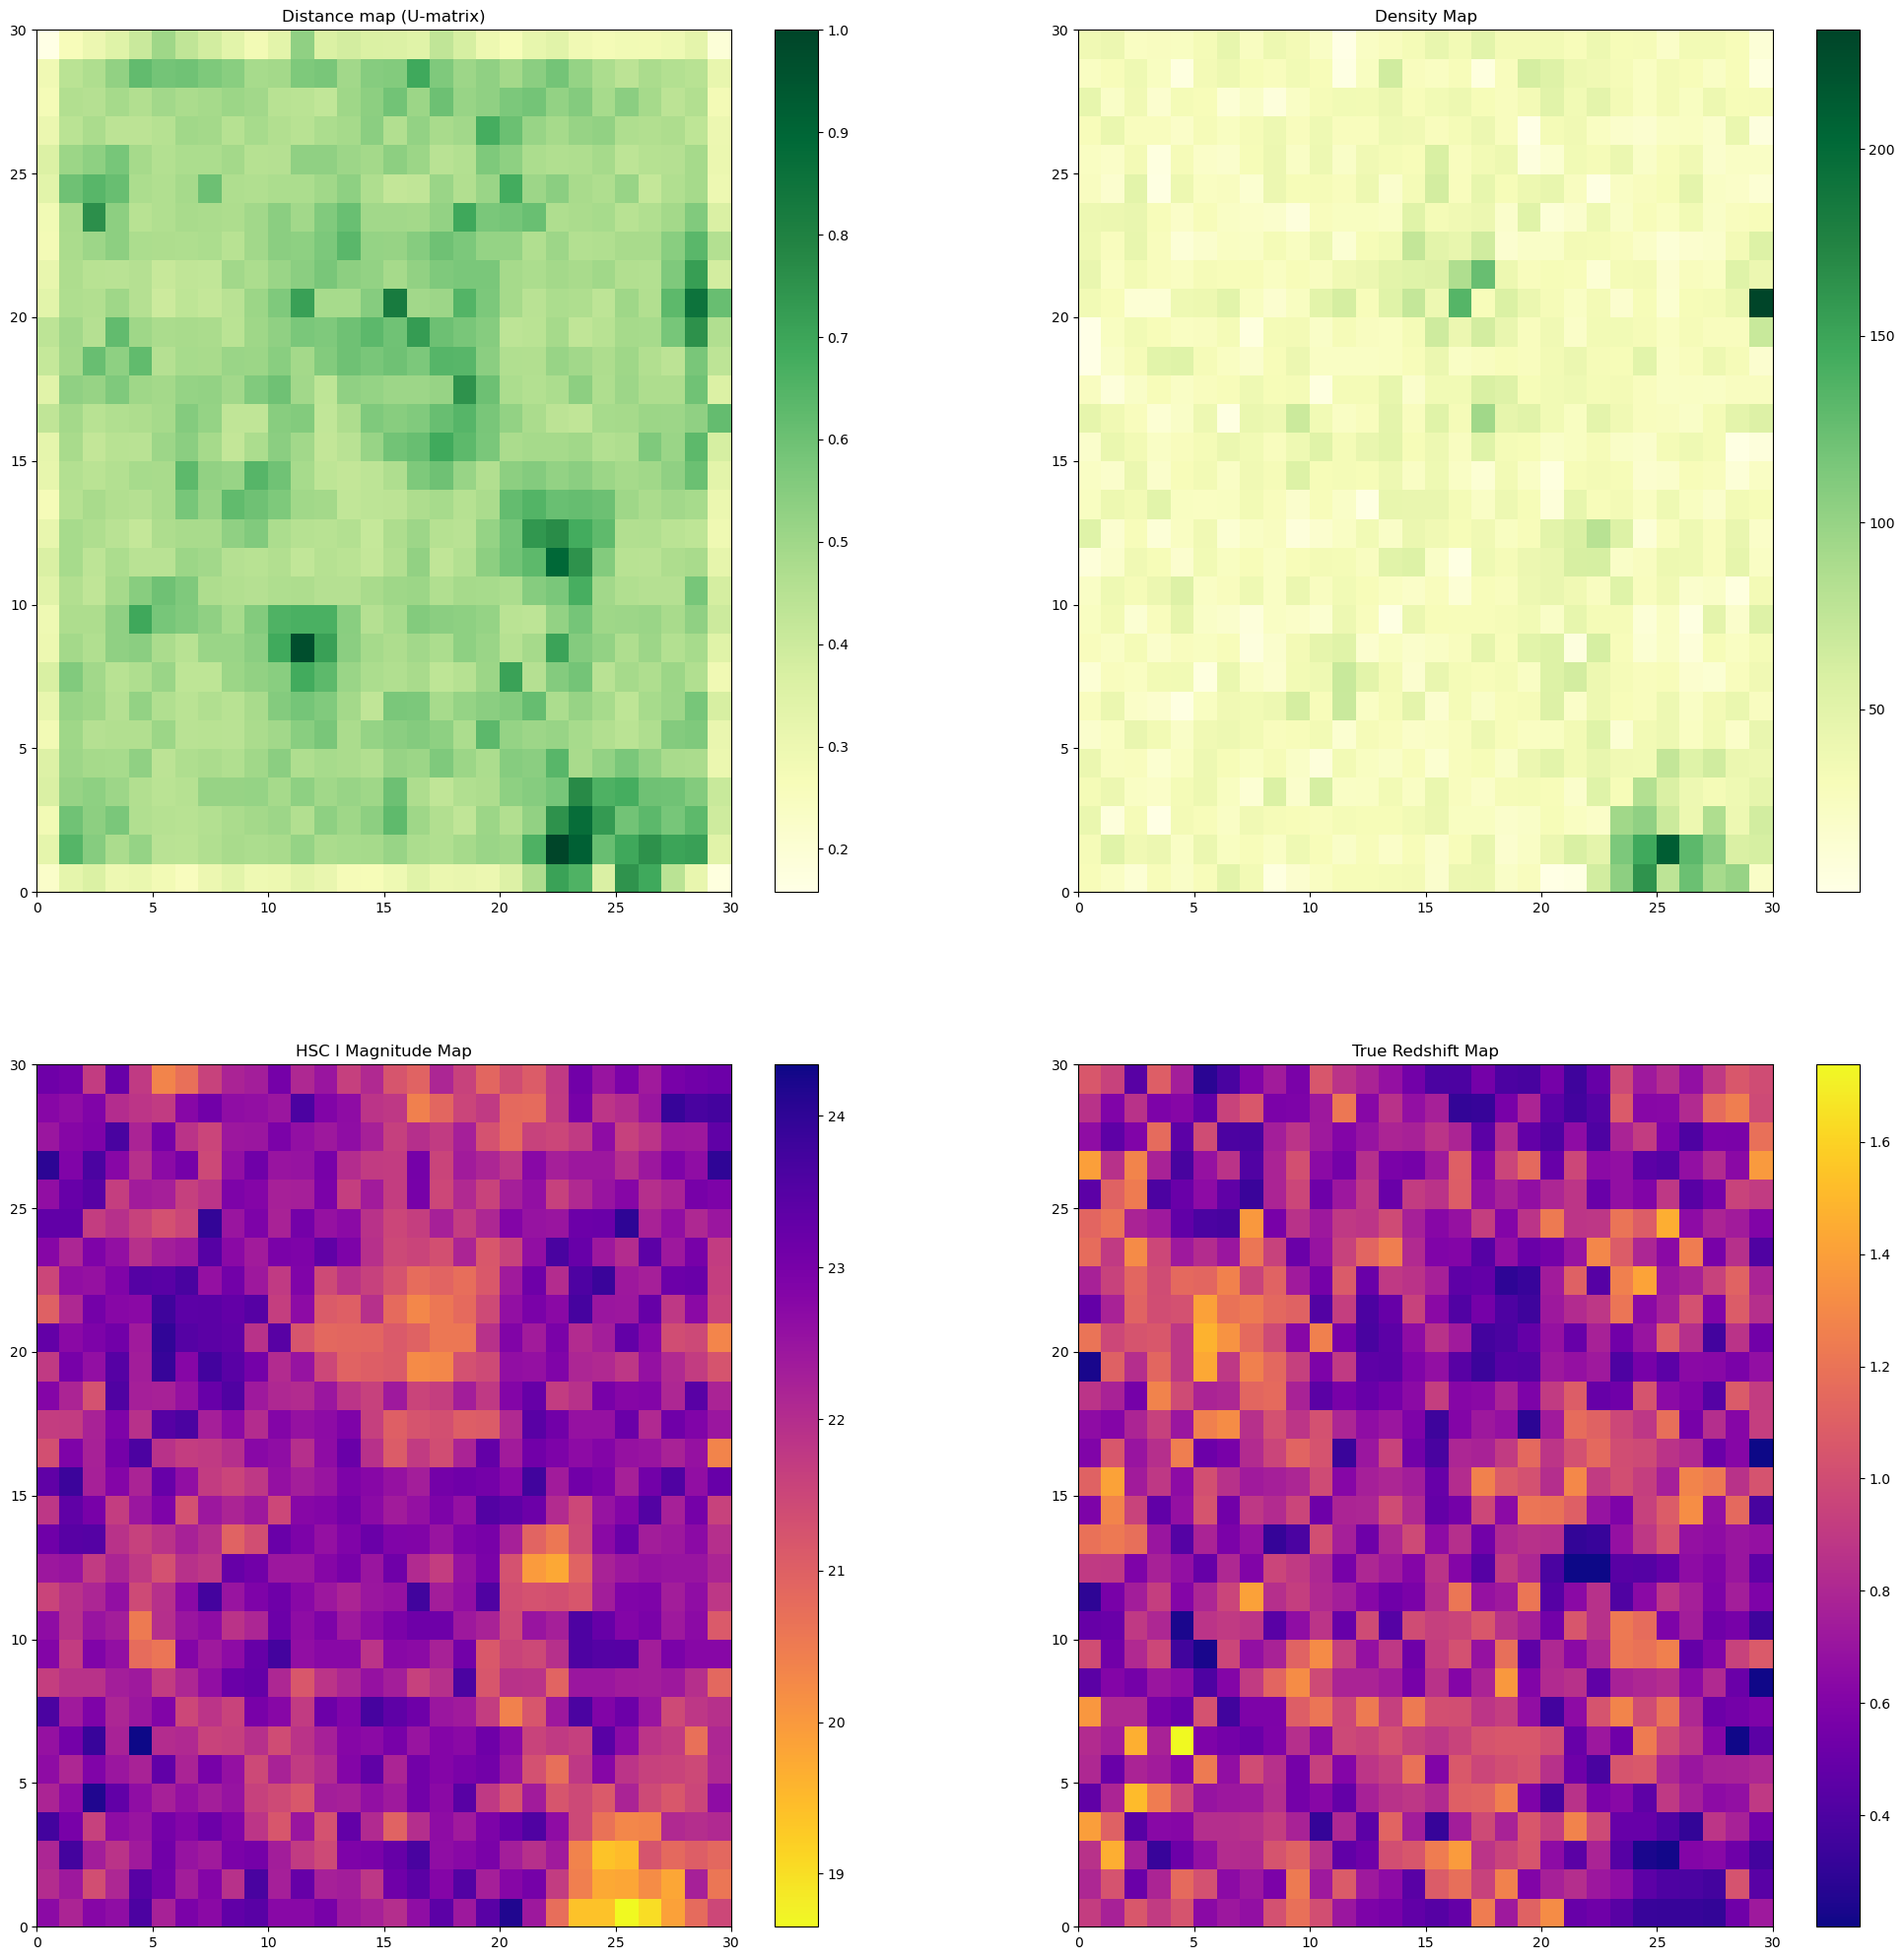

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.6]
29683.0
Topological error: 0.6726409055688441
Quantization error: 6.219686850164294
Average redshift std: 0.35281733818286526


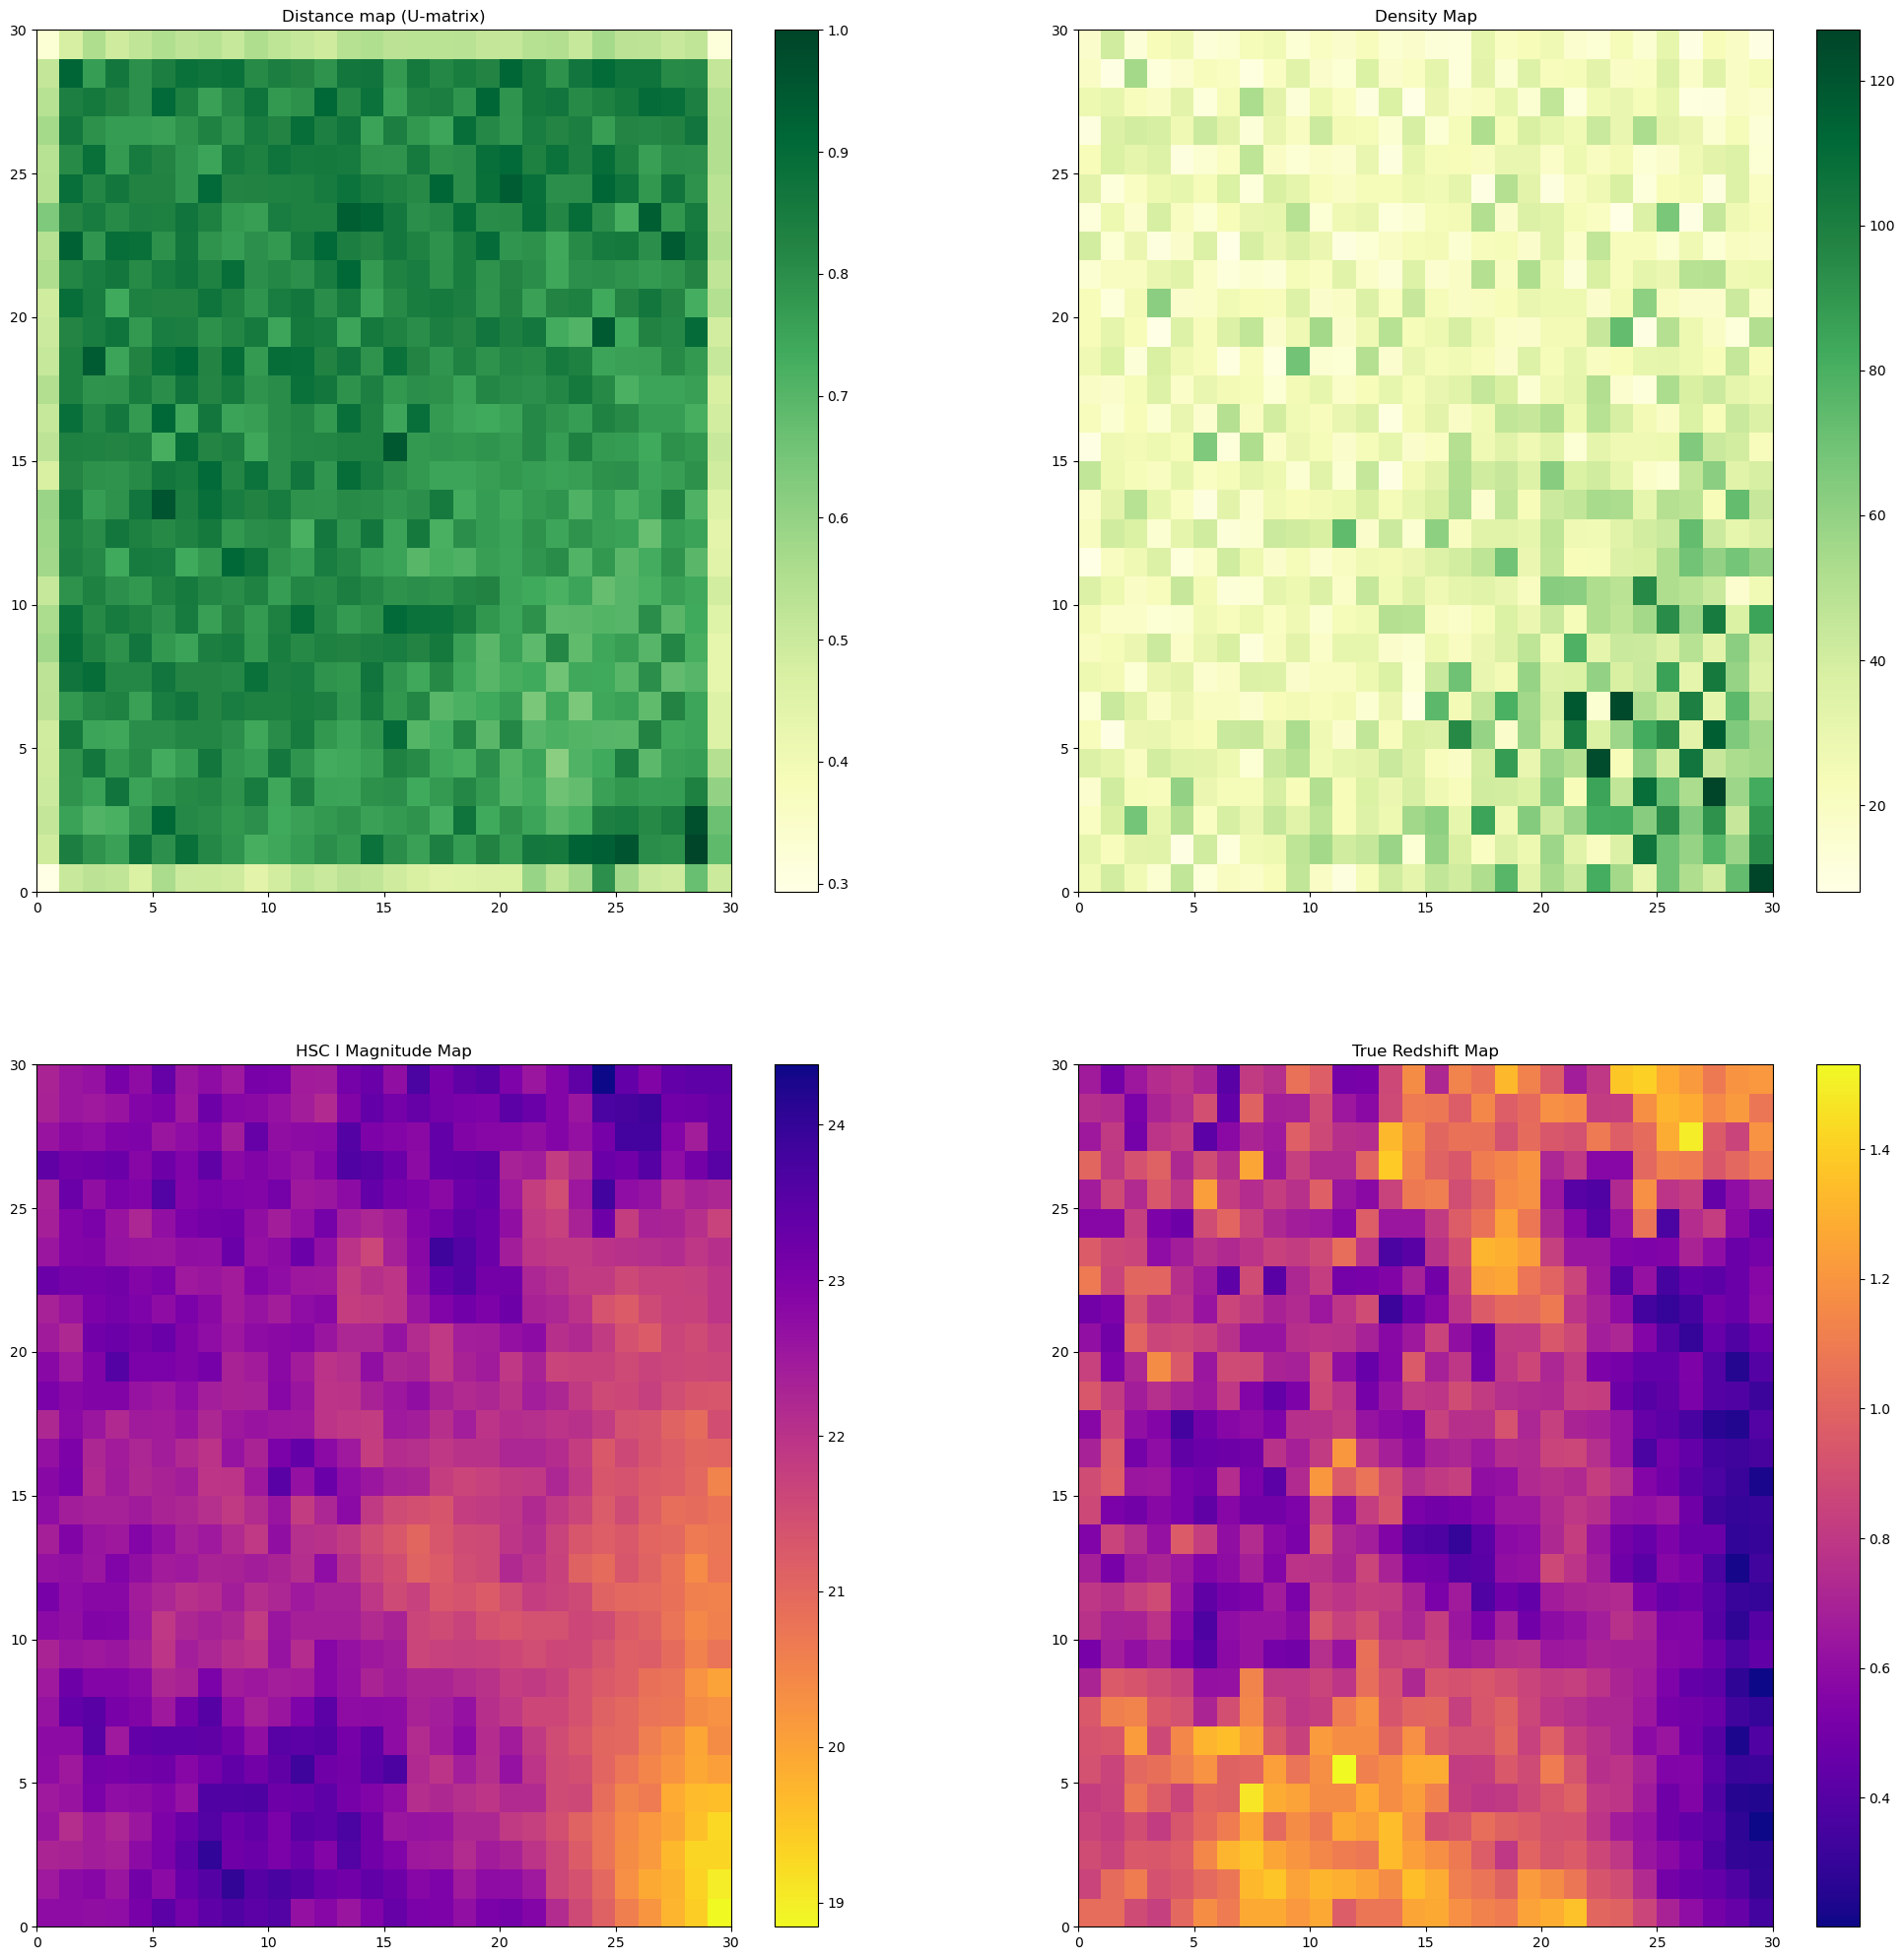

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.6]
29683.0
Topological error: 0.7671394400835495
Quantization error: 6.230195989372865
Average redshift std: 0.35484774429873706


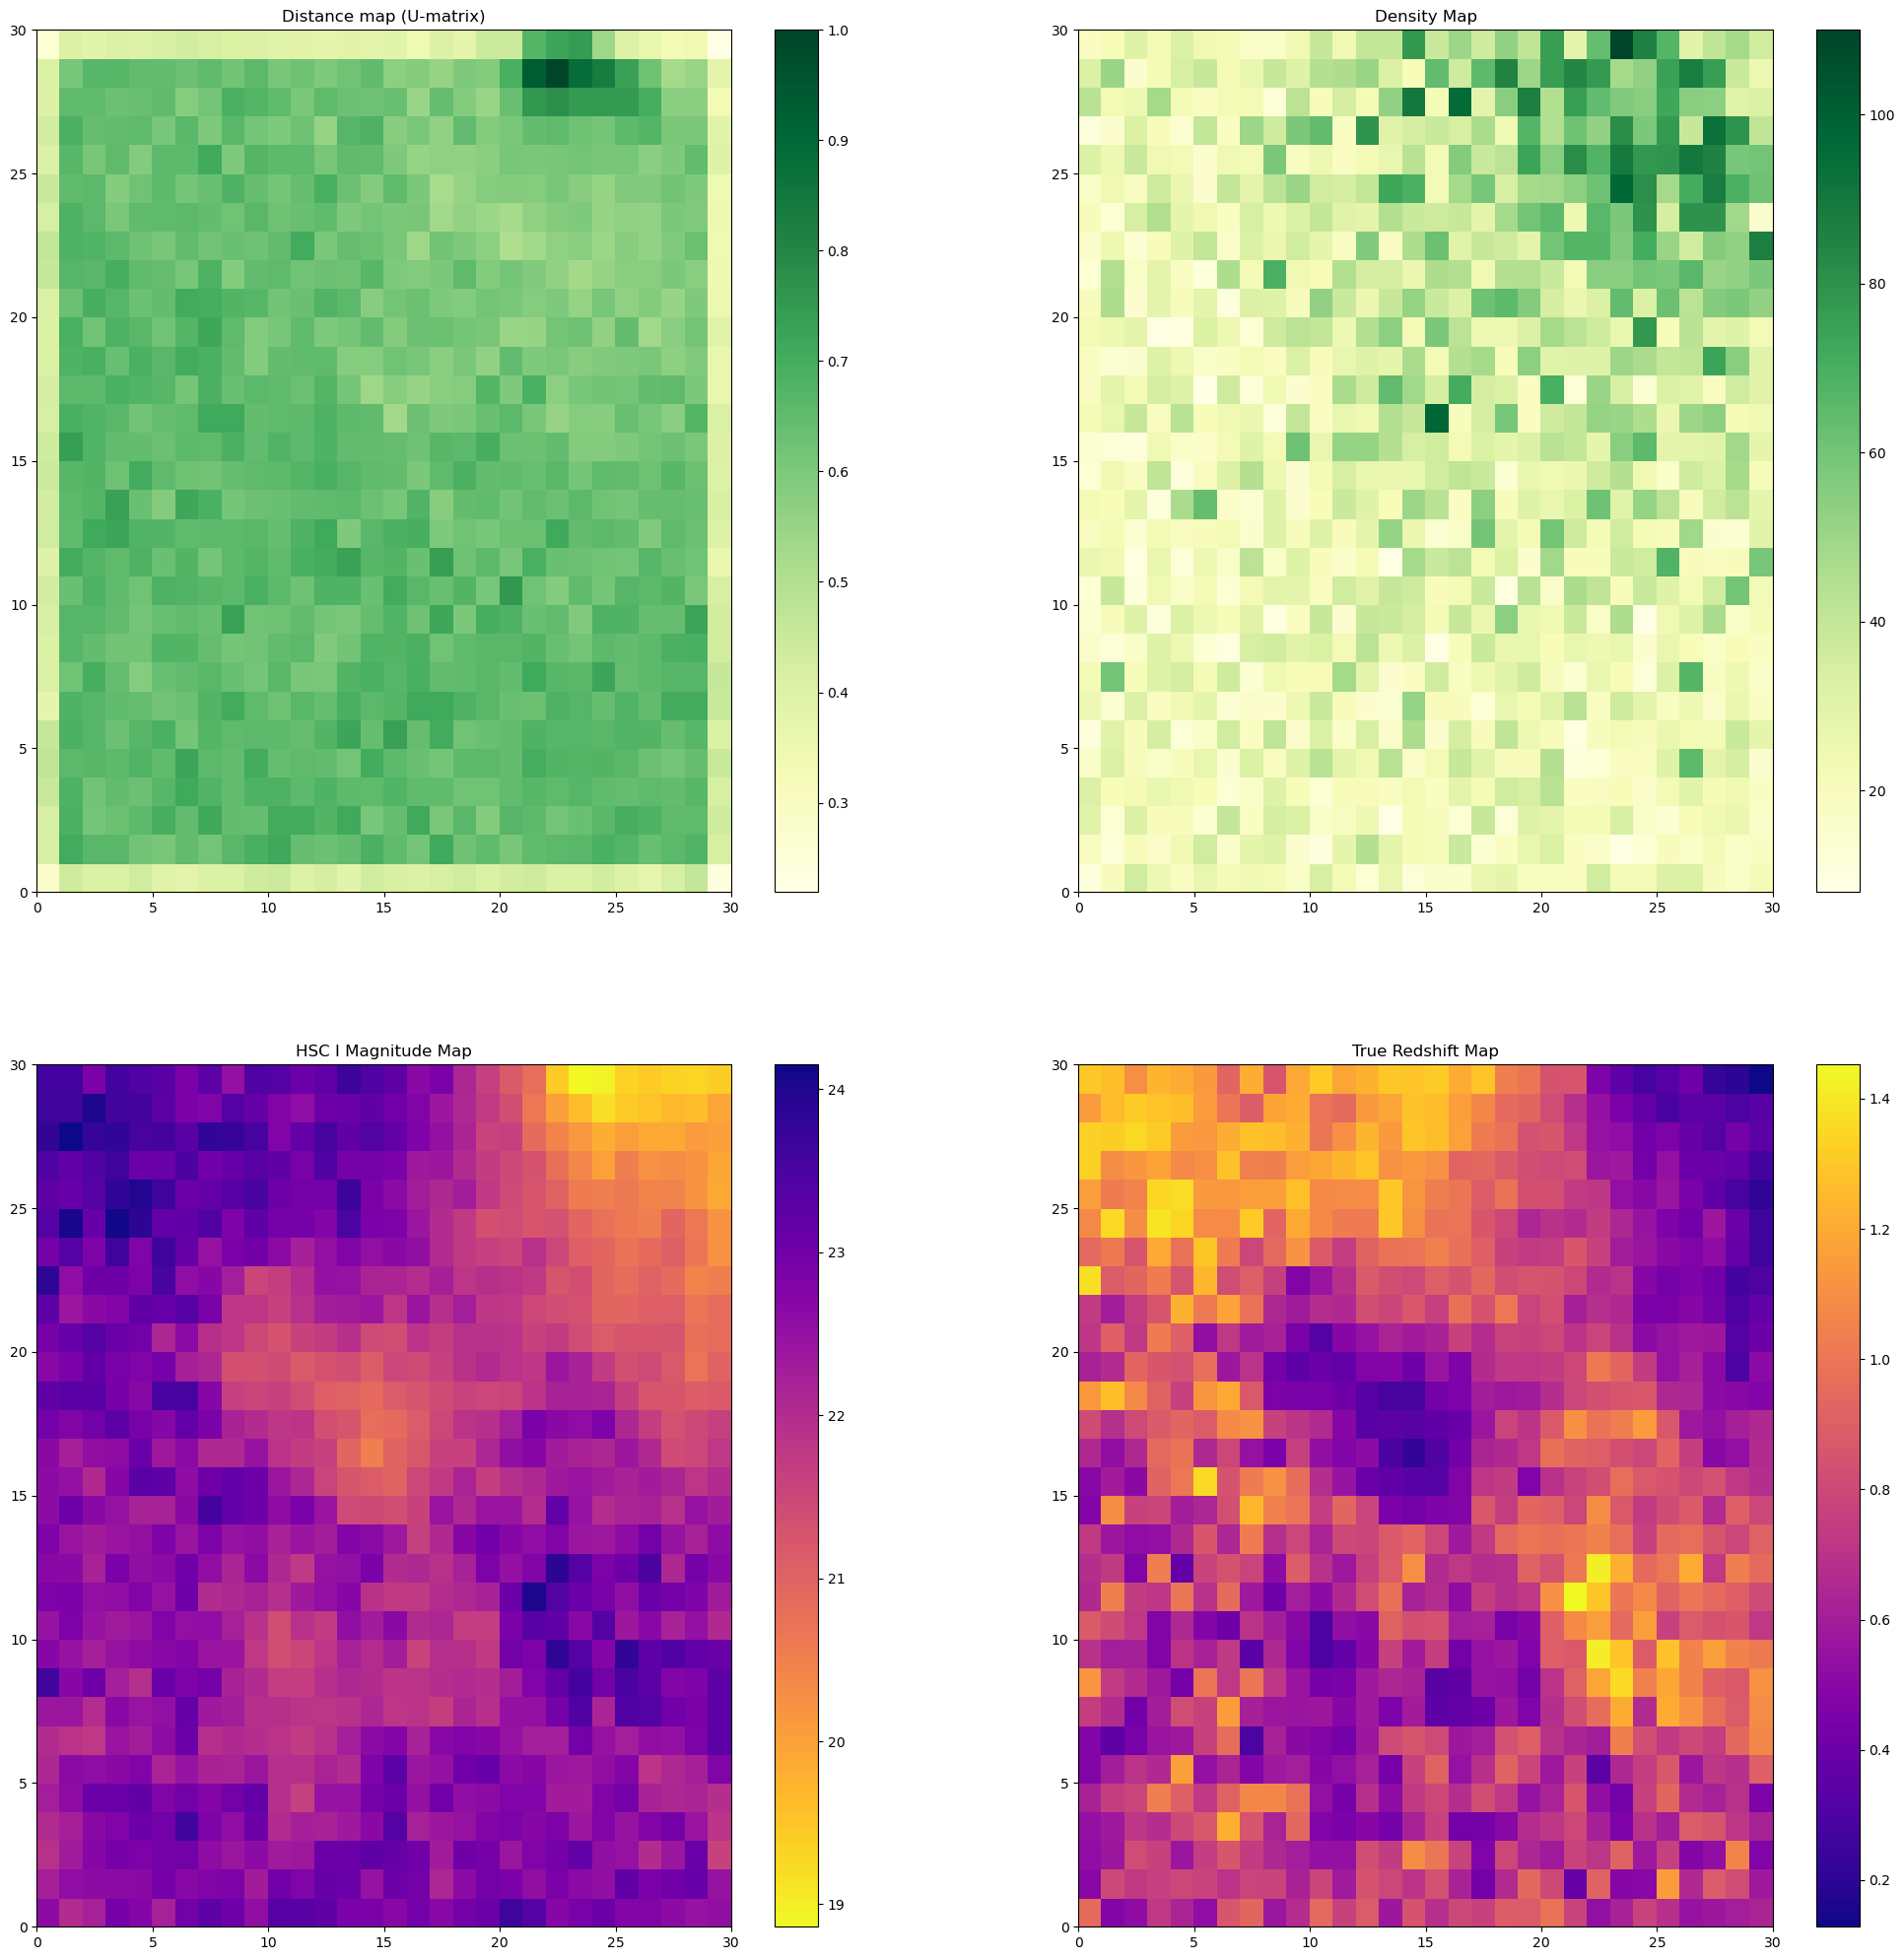

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.6]
29683.0
Topological error: 0.8804029242327258
Quantization error: 6.247615024756066
Average redshift std: 0.33501963945010177


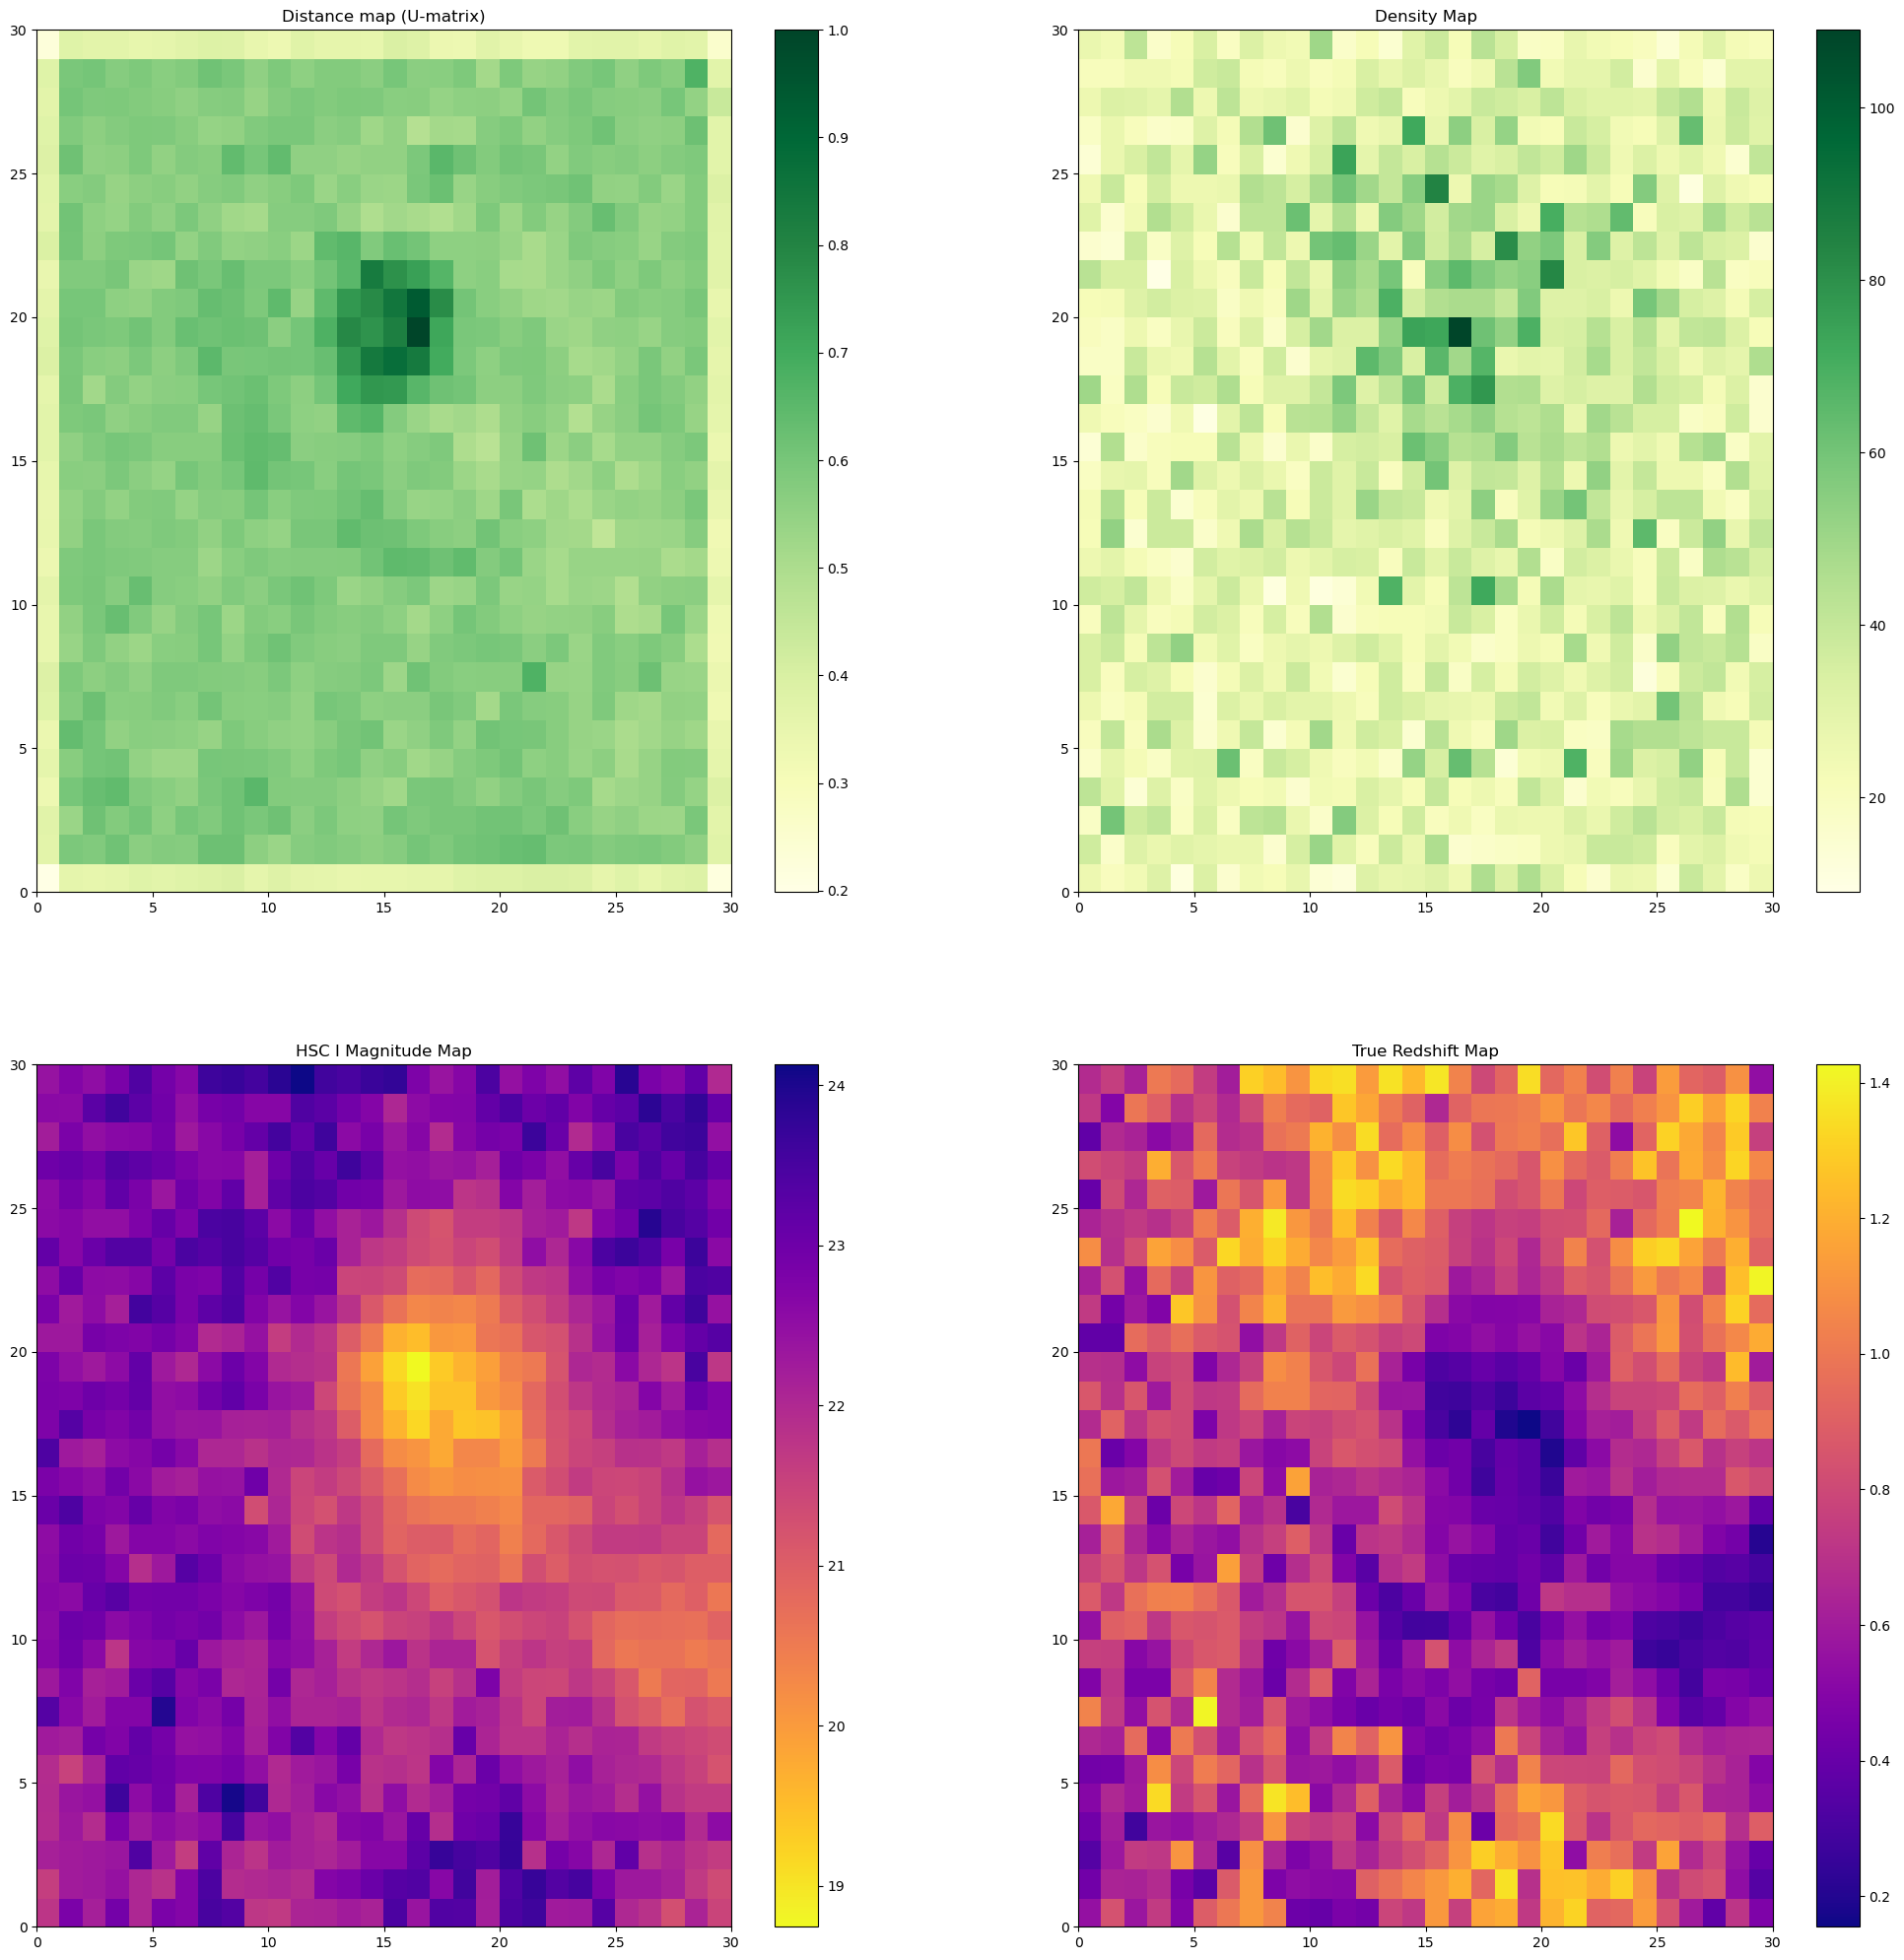

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.6]
29683.0
Topological error: 0.893036418151804
Quantization error: 6.285987731047575
Average redshift std: 0.35114865684215163


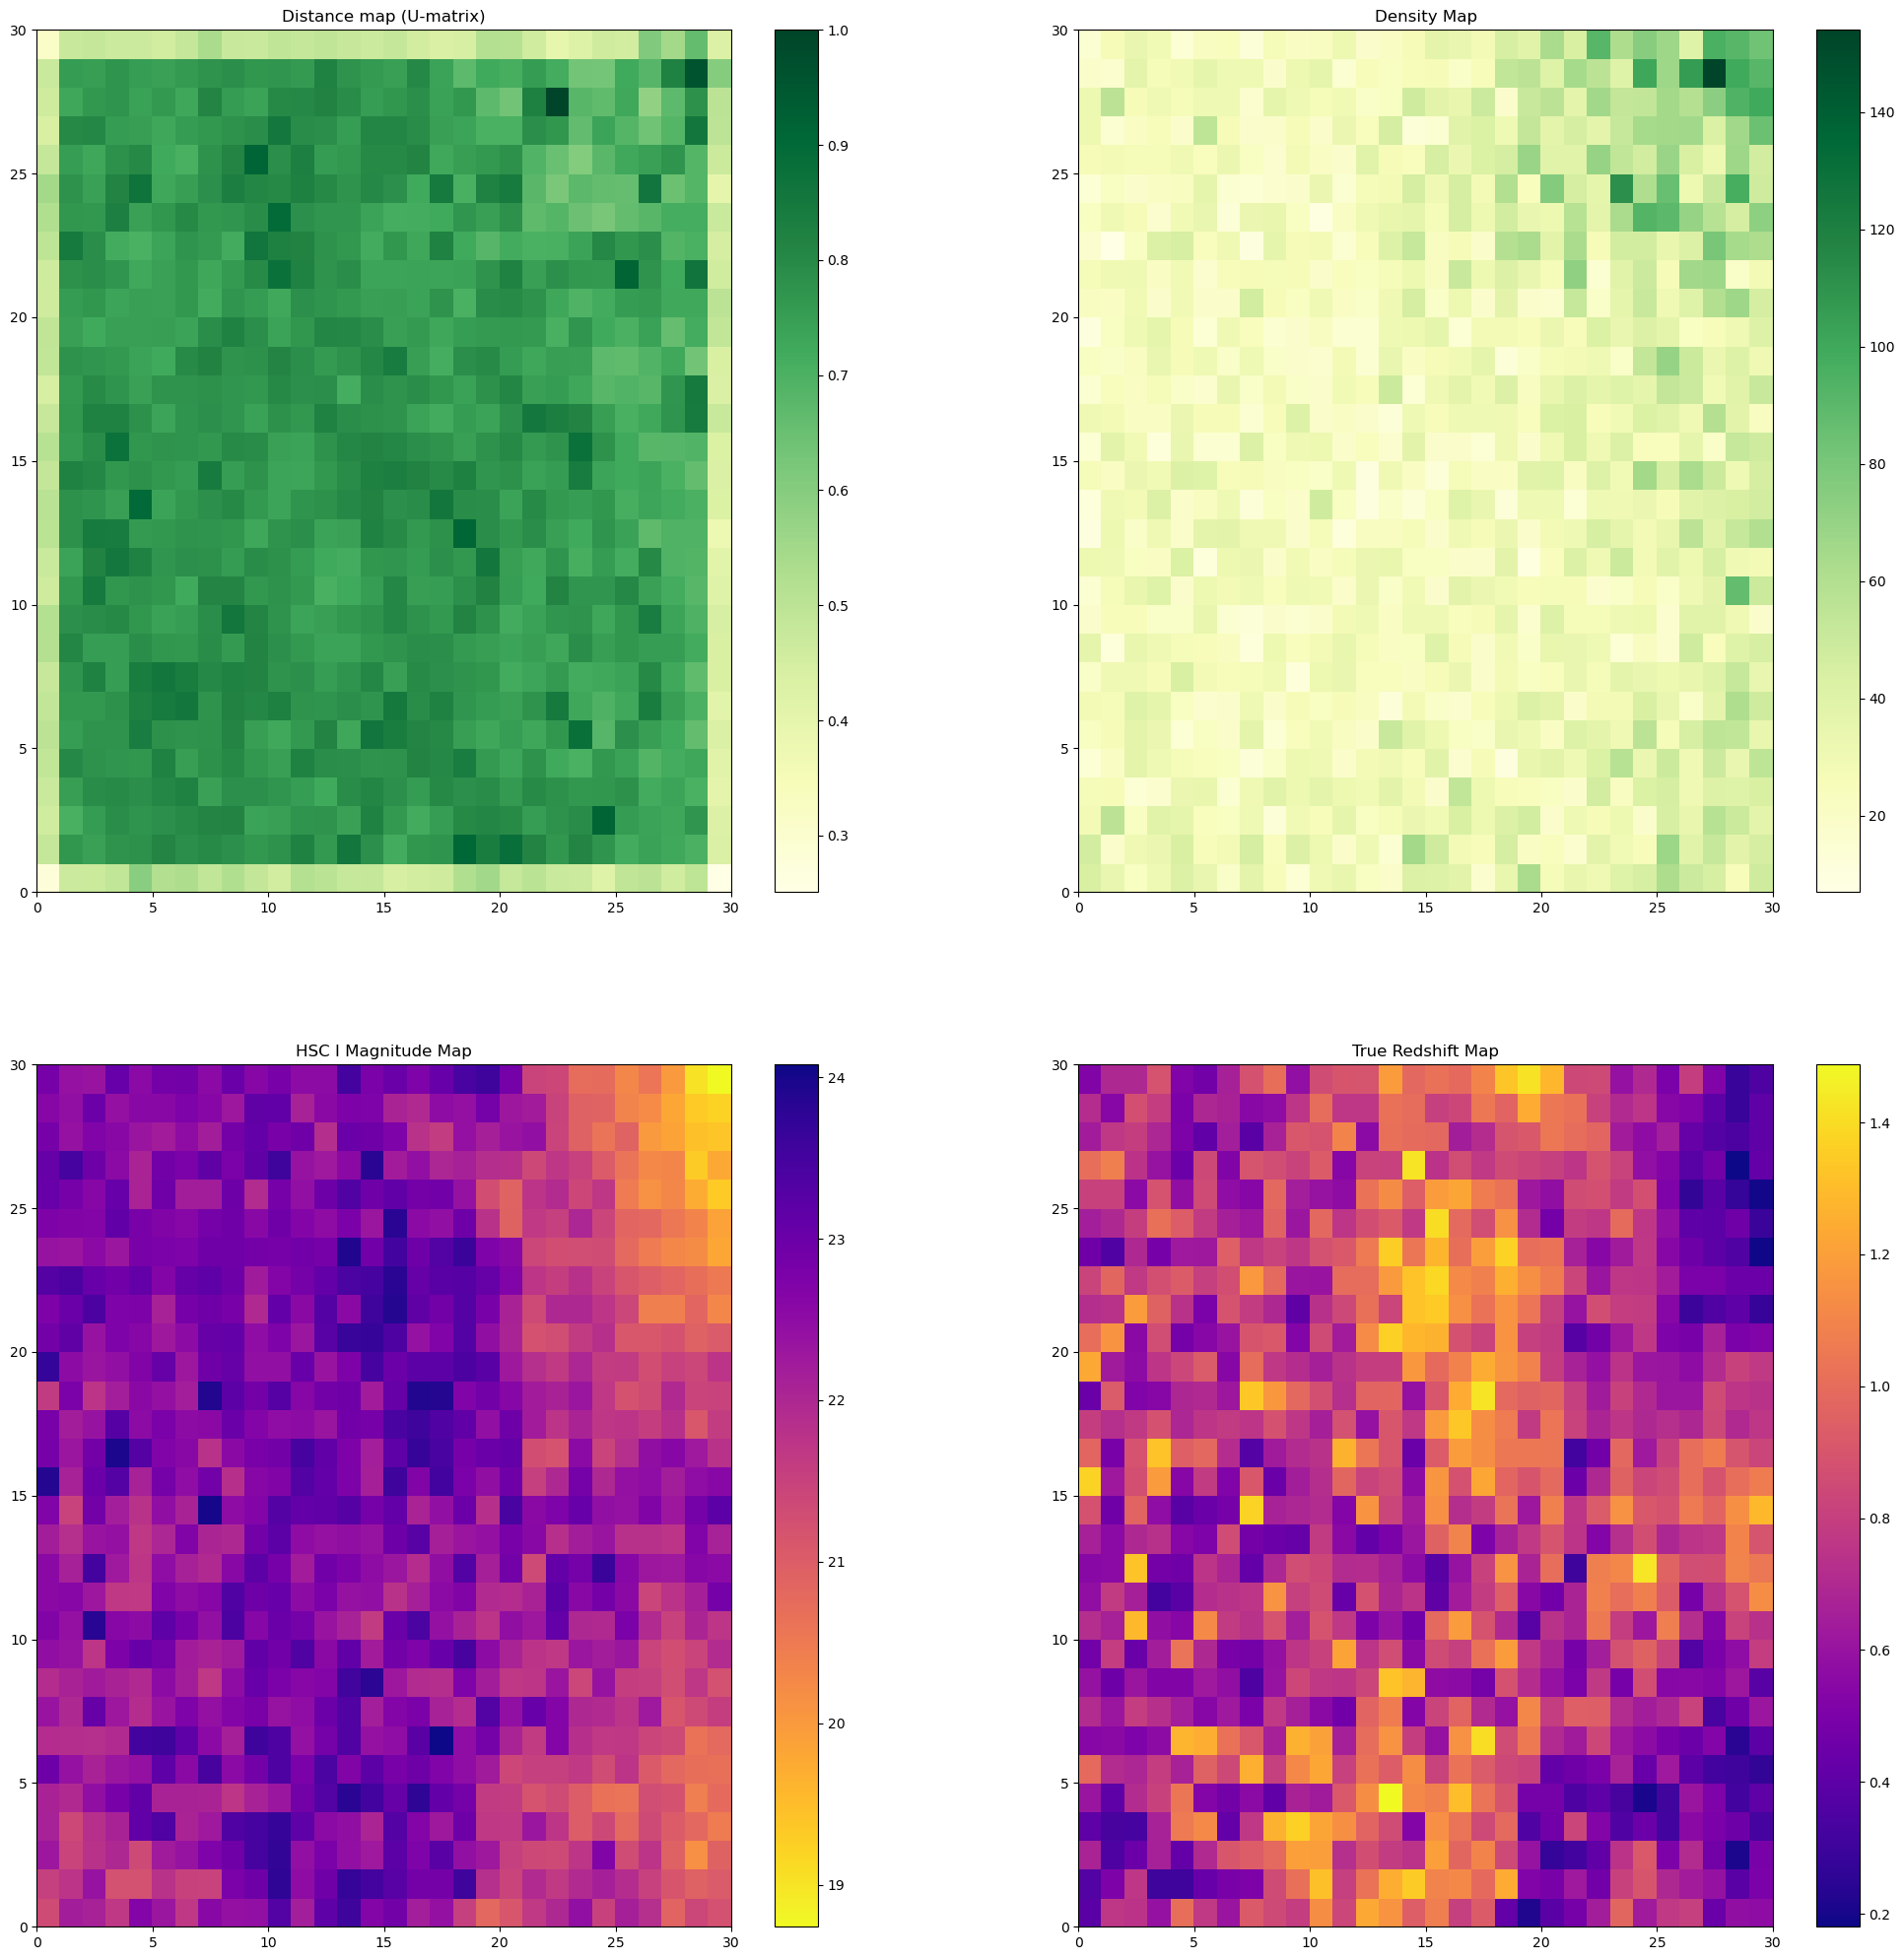

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 0.6]
29683.0
Topological error: 0.9370346663073139
Quantization error: 6.3019916288595414
Average redshift std: 0.3442878418102947


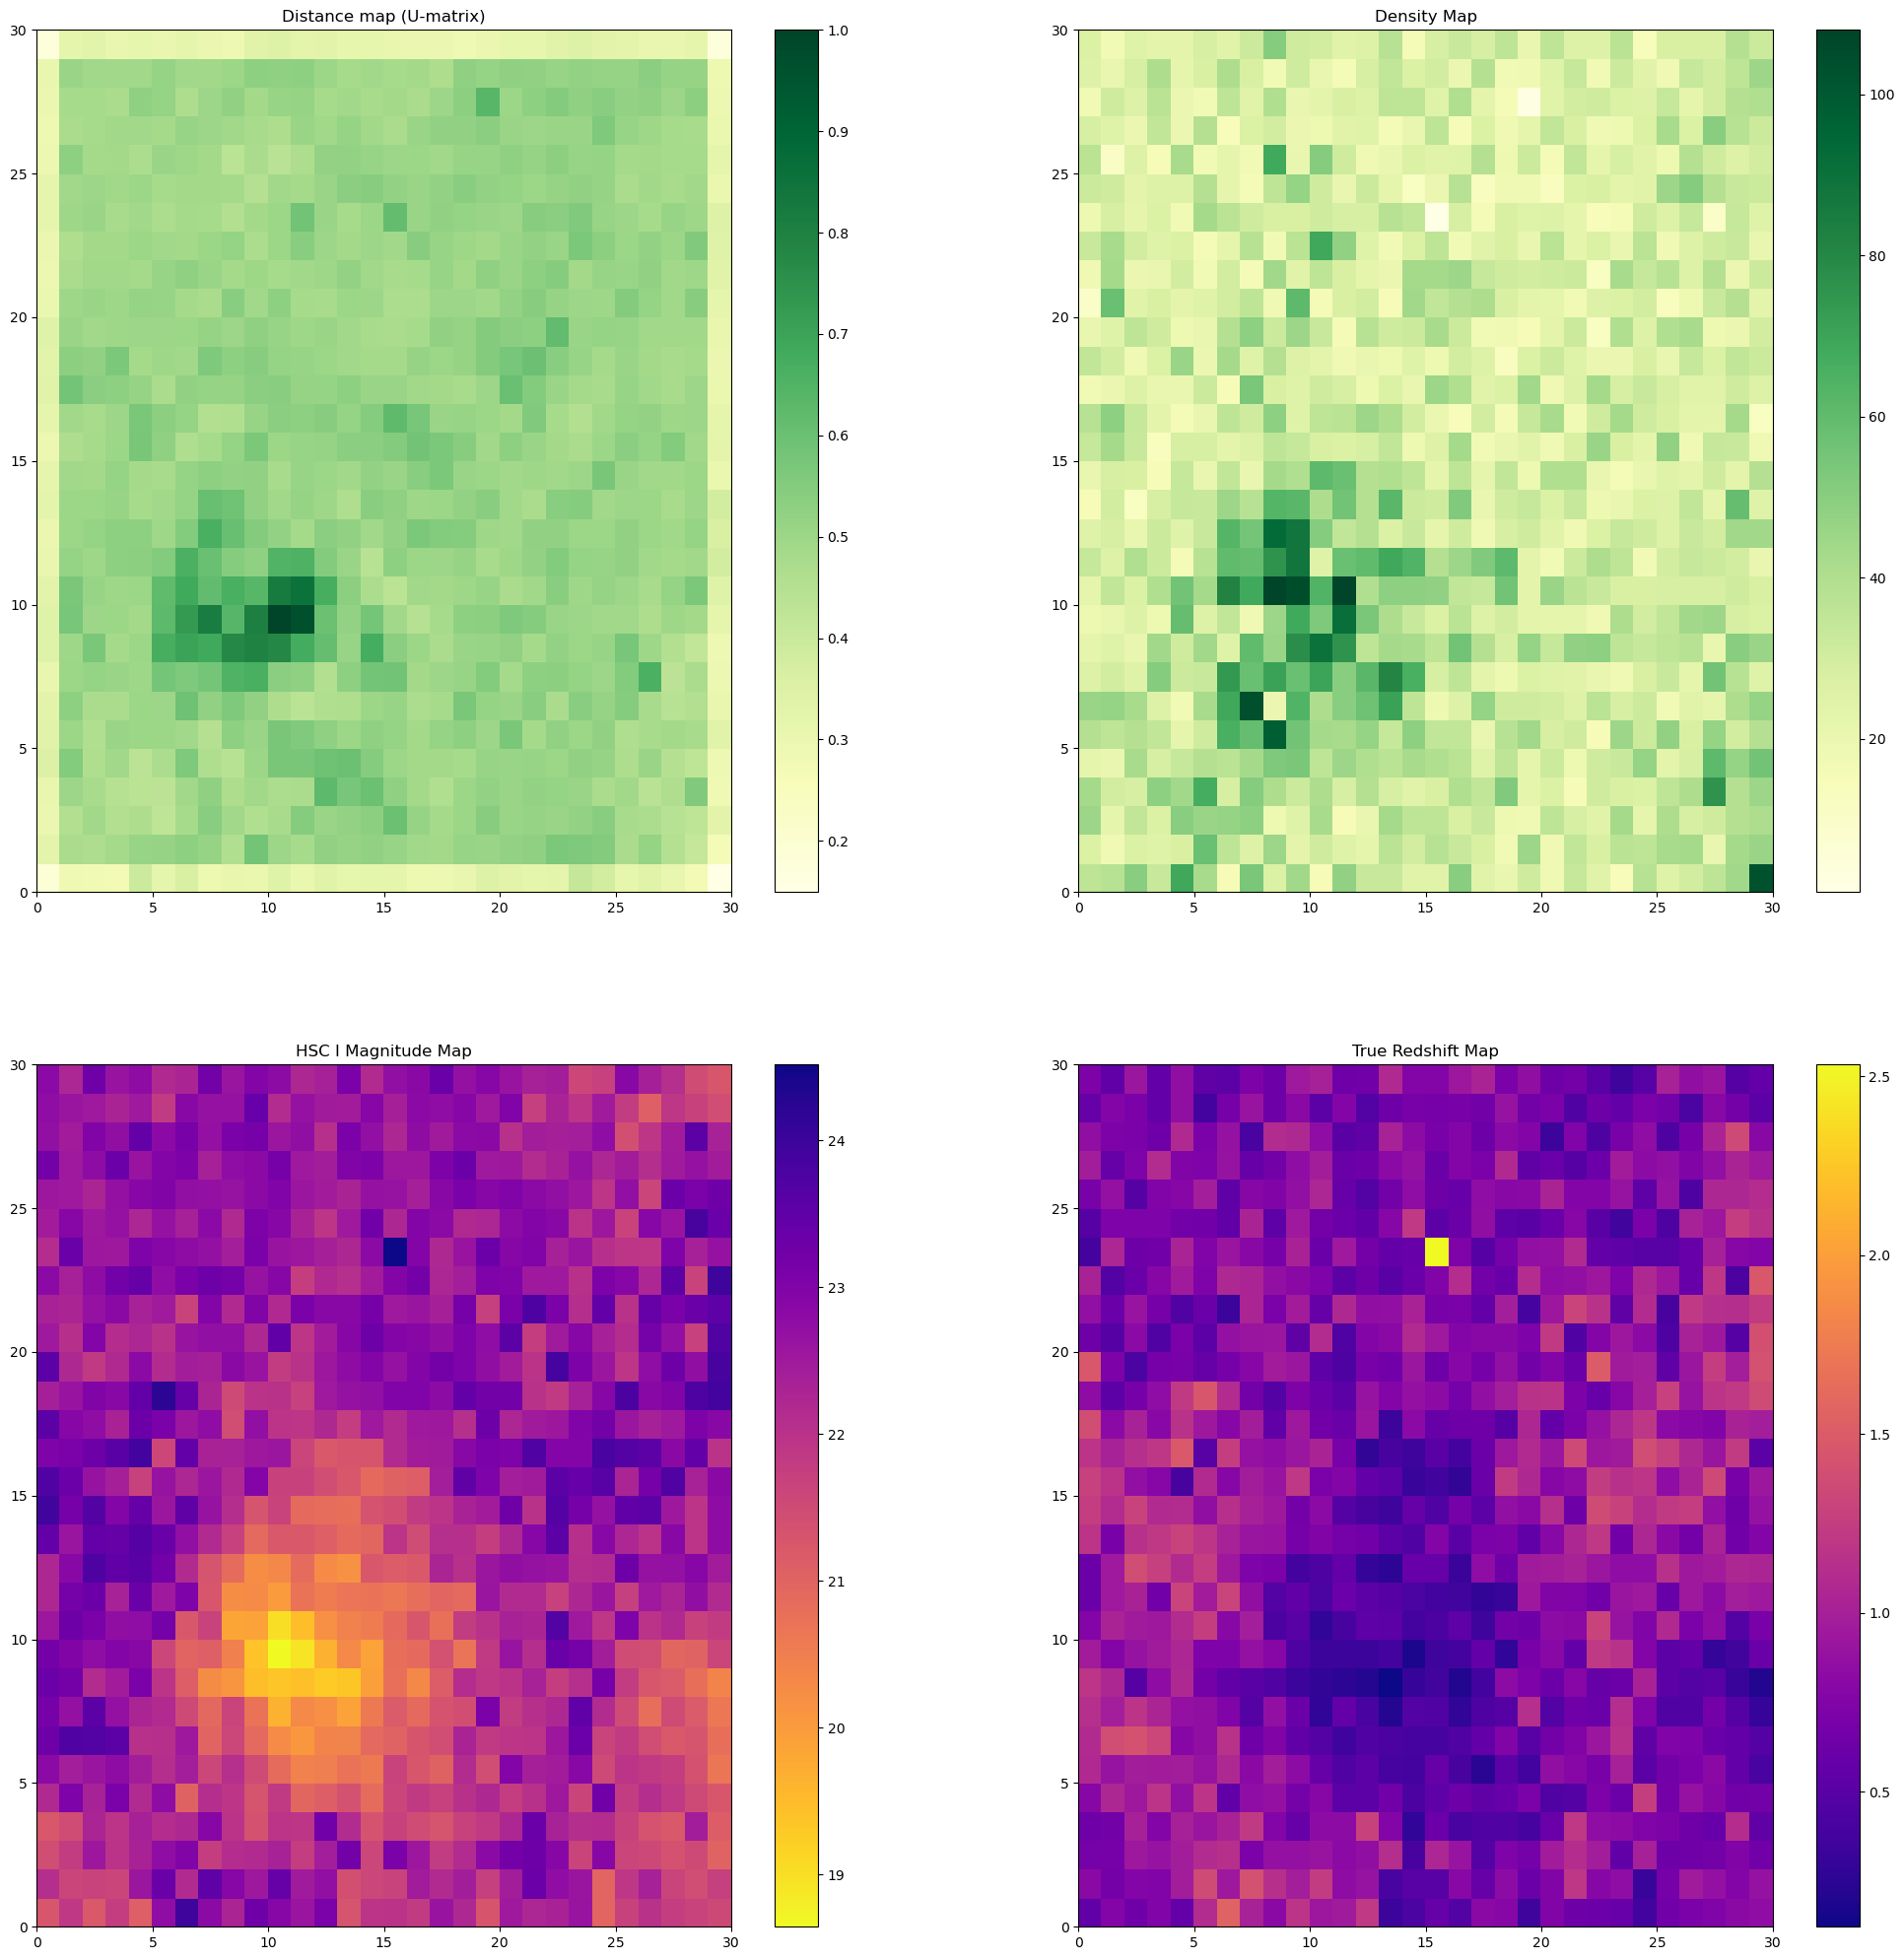

Data shape: (29683, 102)
Start making diagrams...
[30, 0.5, 0.6]
29683.0
Topological error: 0.948286898224573
Quantization error: 6.312727393286182
Average redshift std: 0.3412719226275124


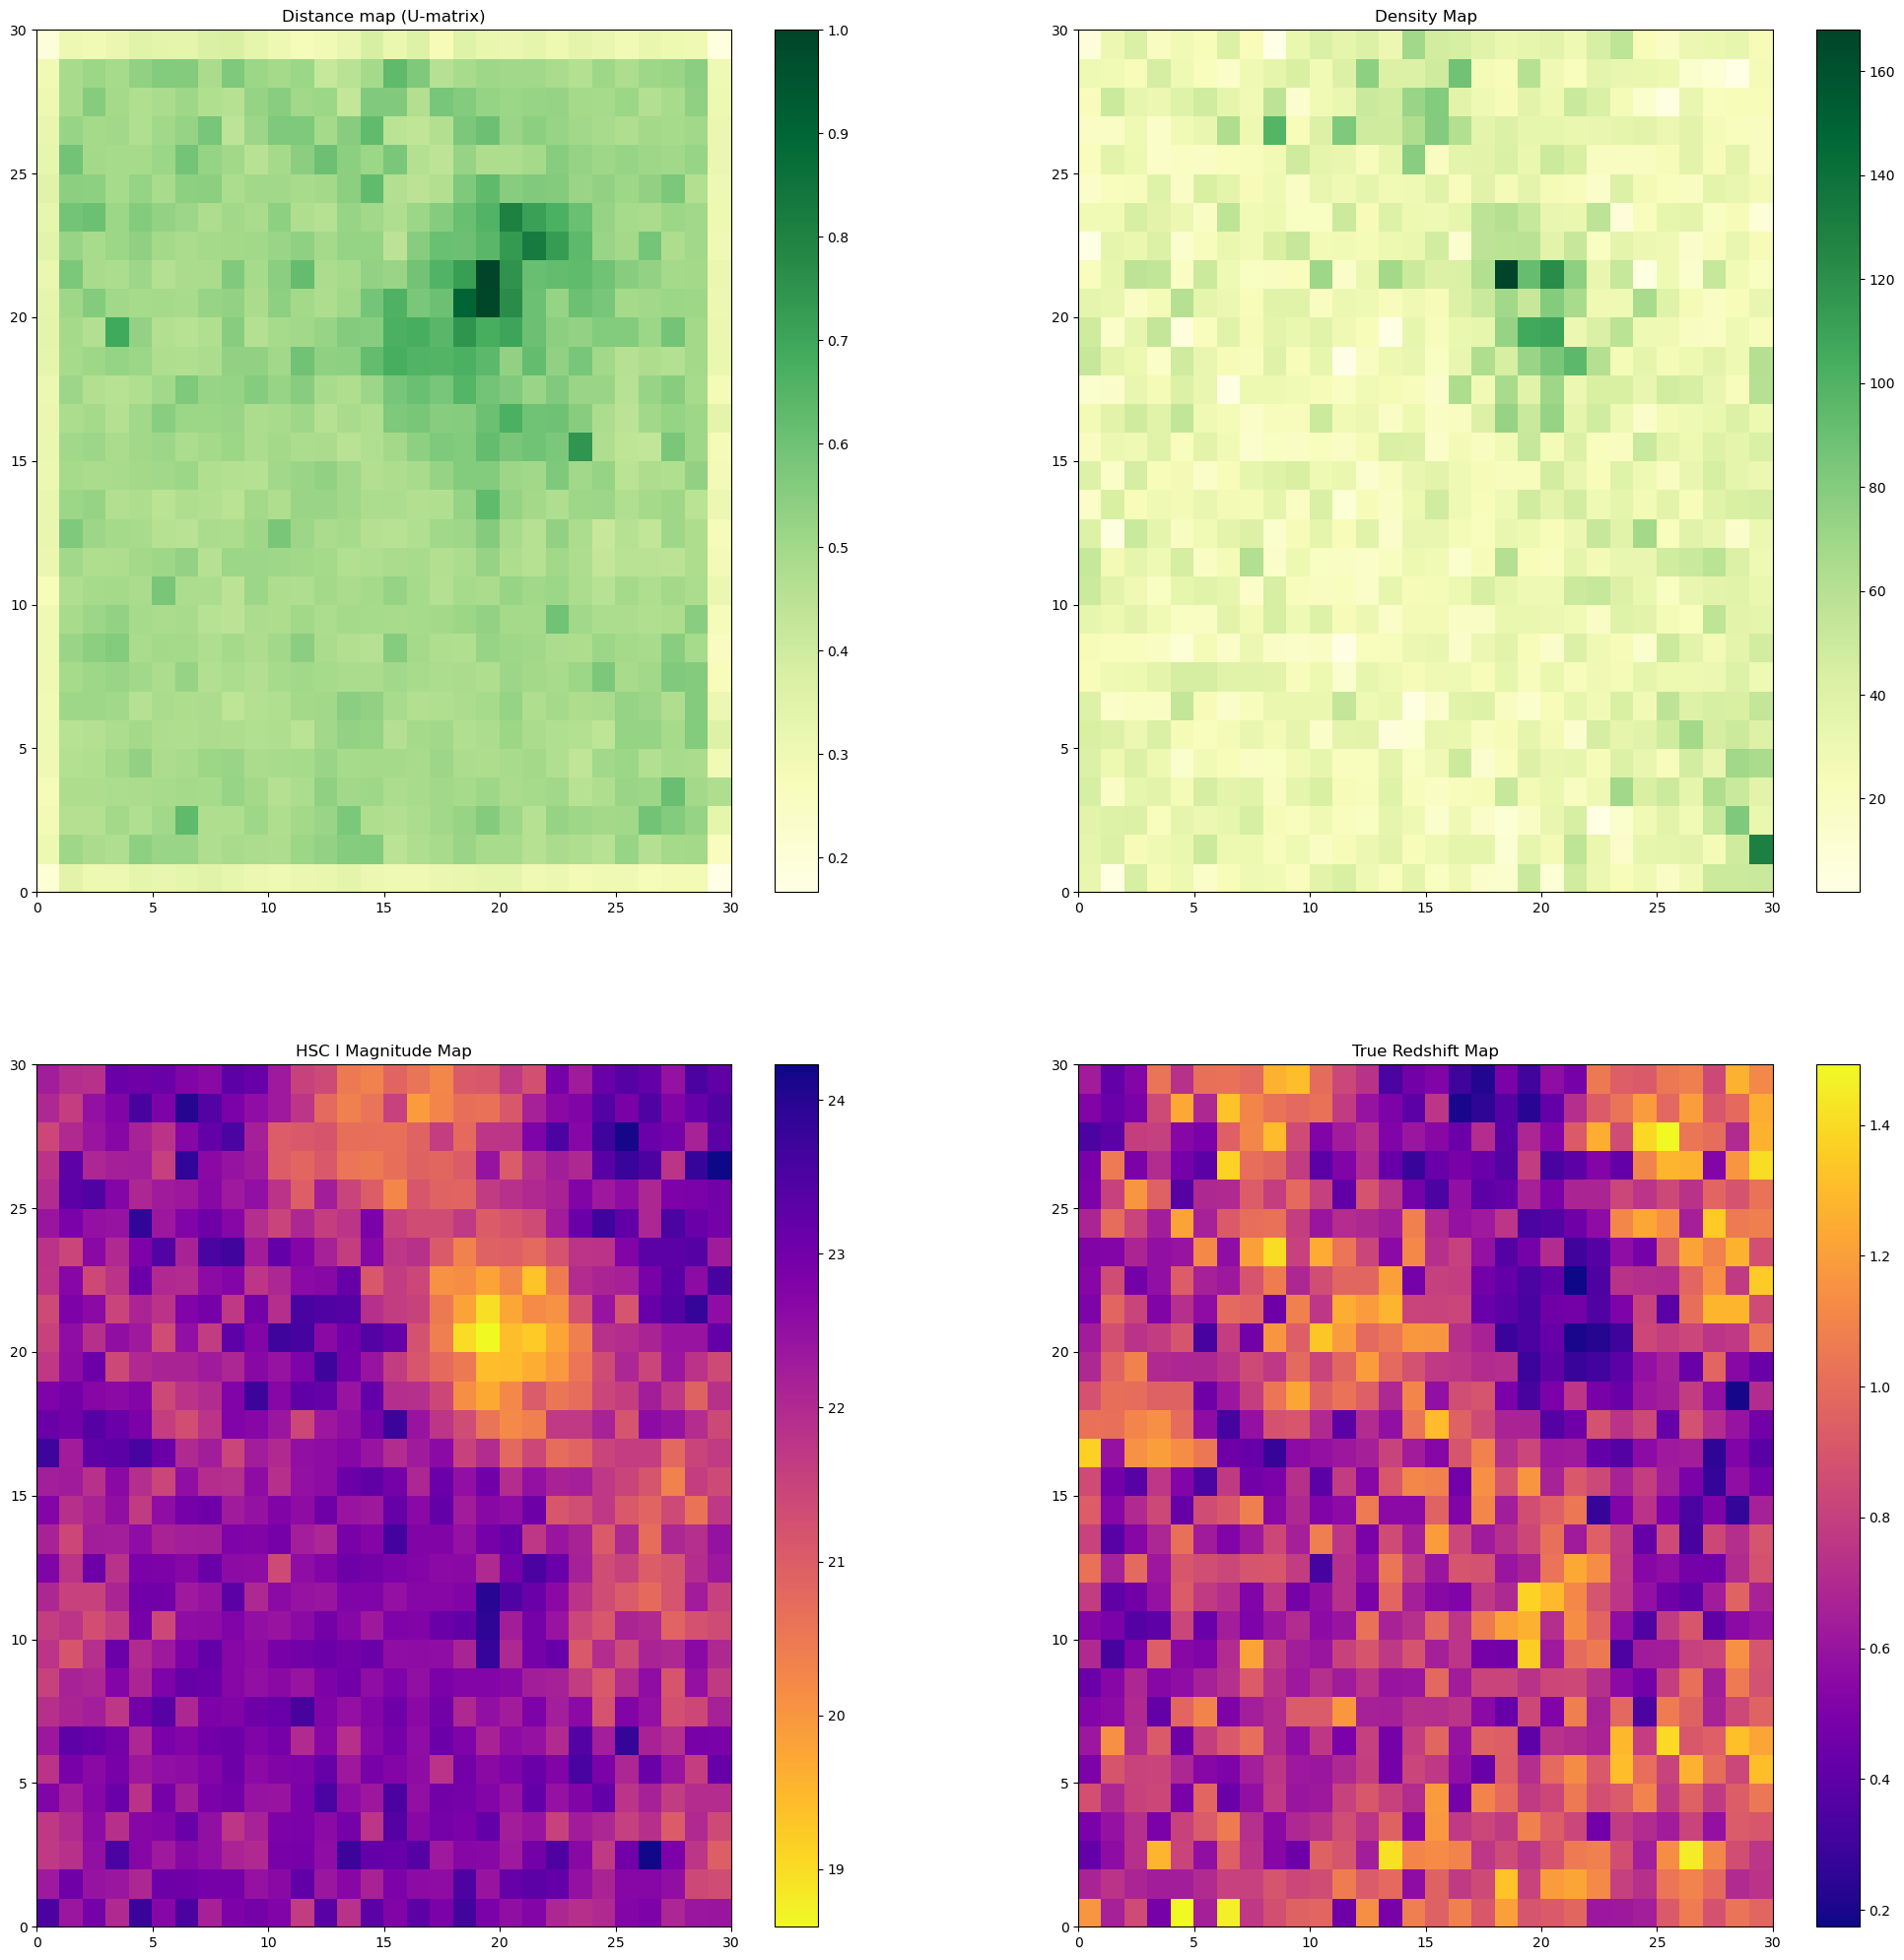

Data shape: (29683, 102)
Start making diagrams...
[30, 0.4, 0.6]
29683.0
Topological error: 0.9533402957922043
Quantization error: 6.335734097495994
Average redshift std: 0.3483267191124233


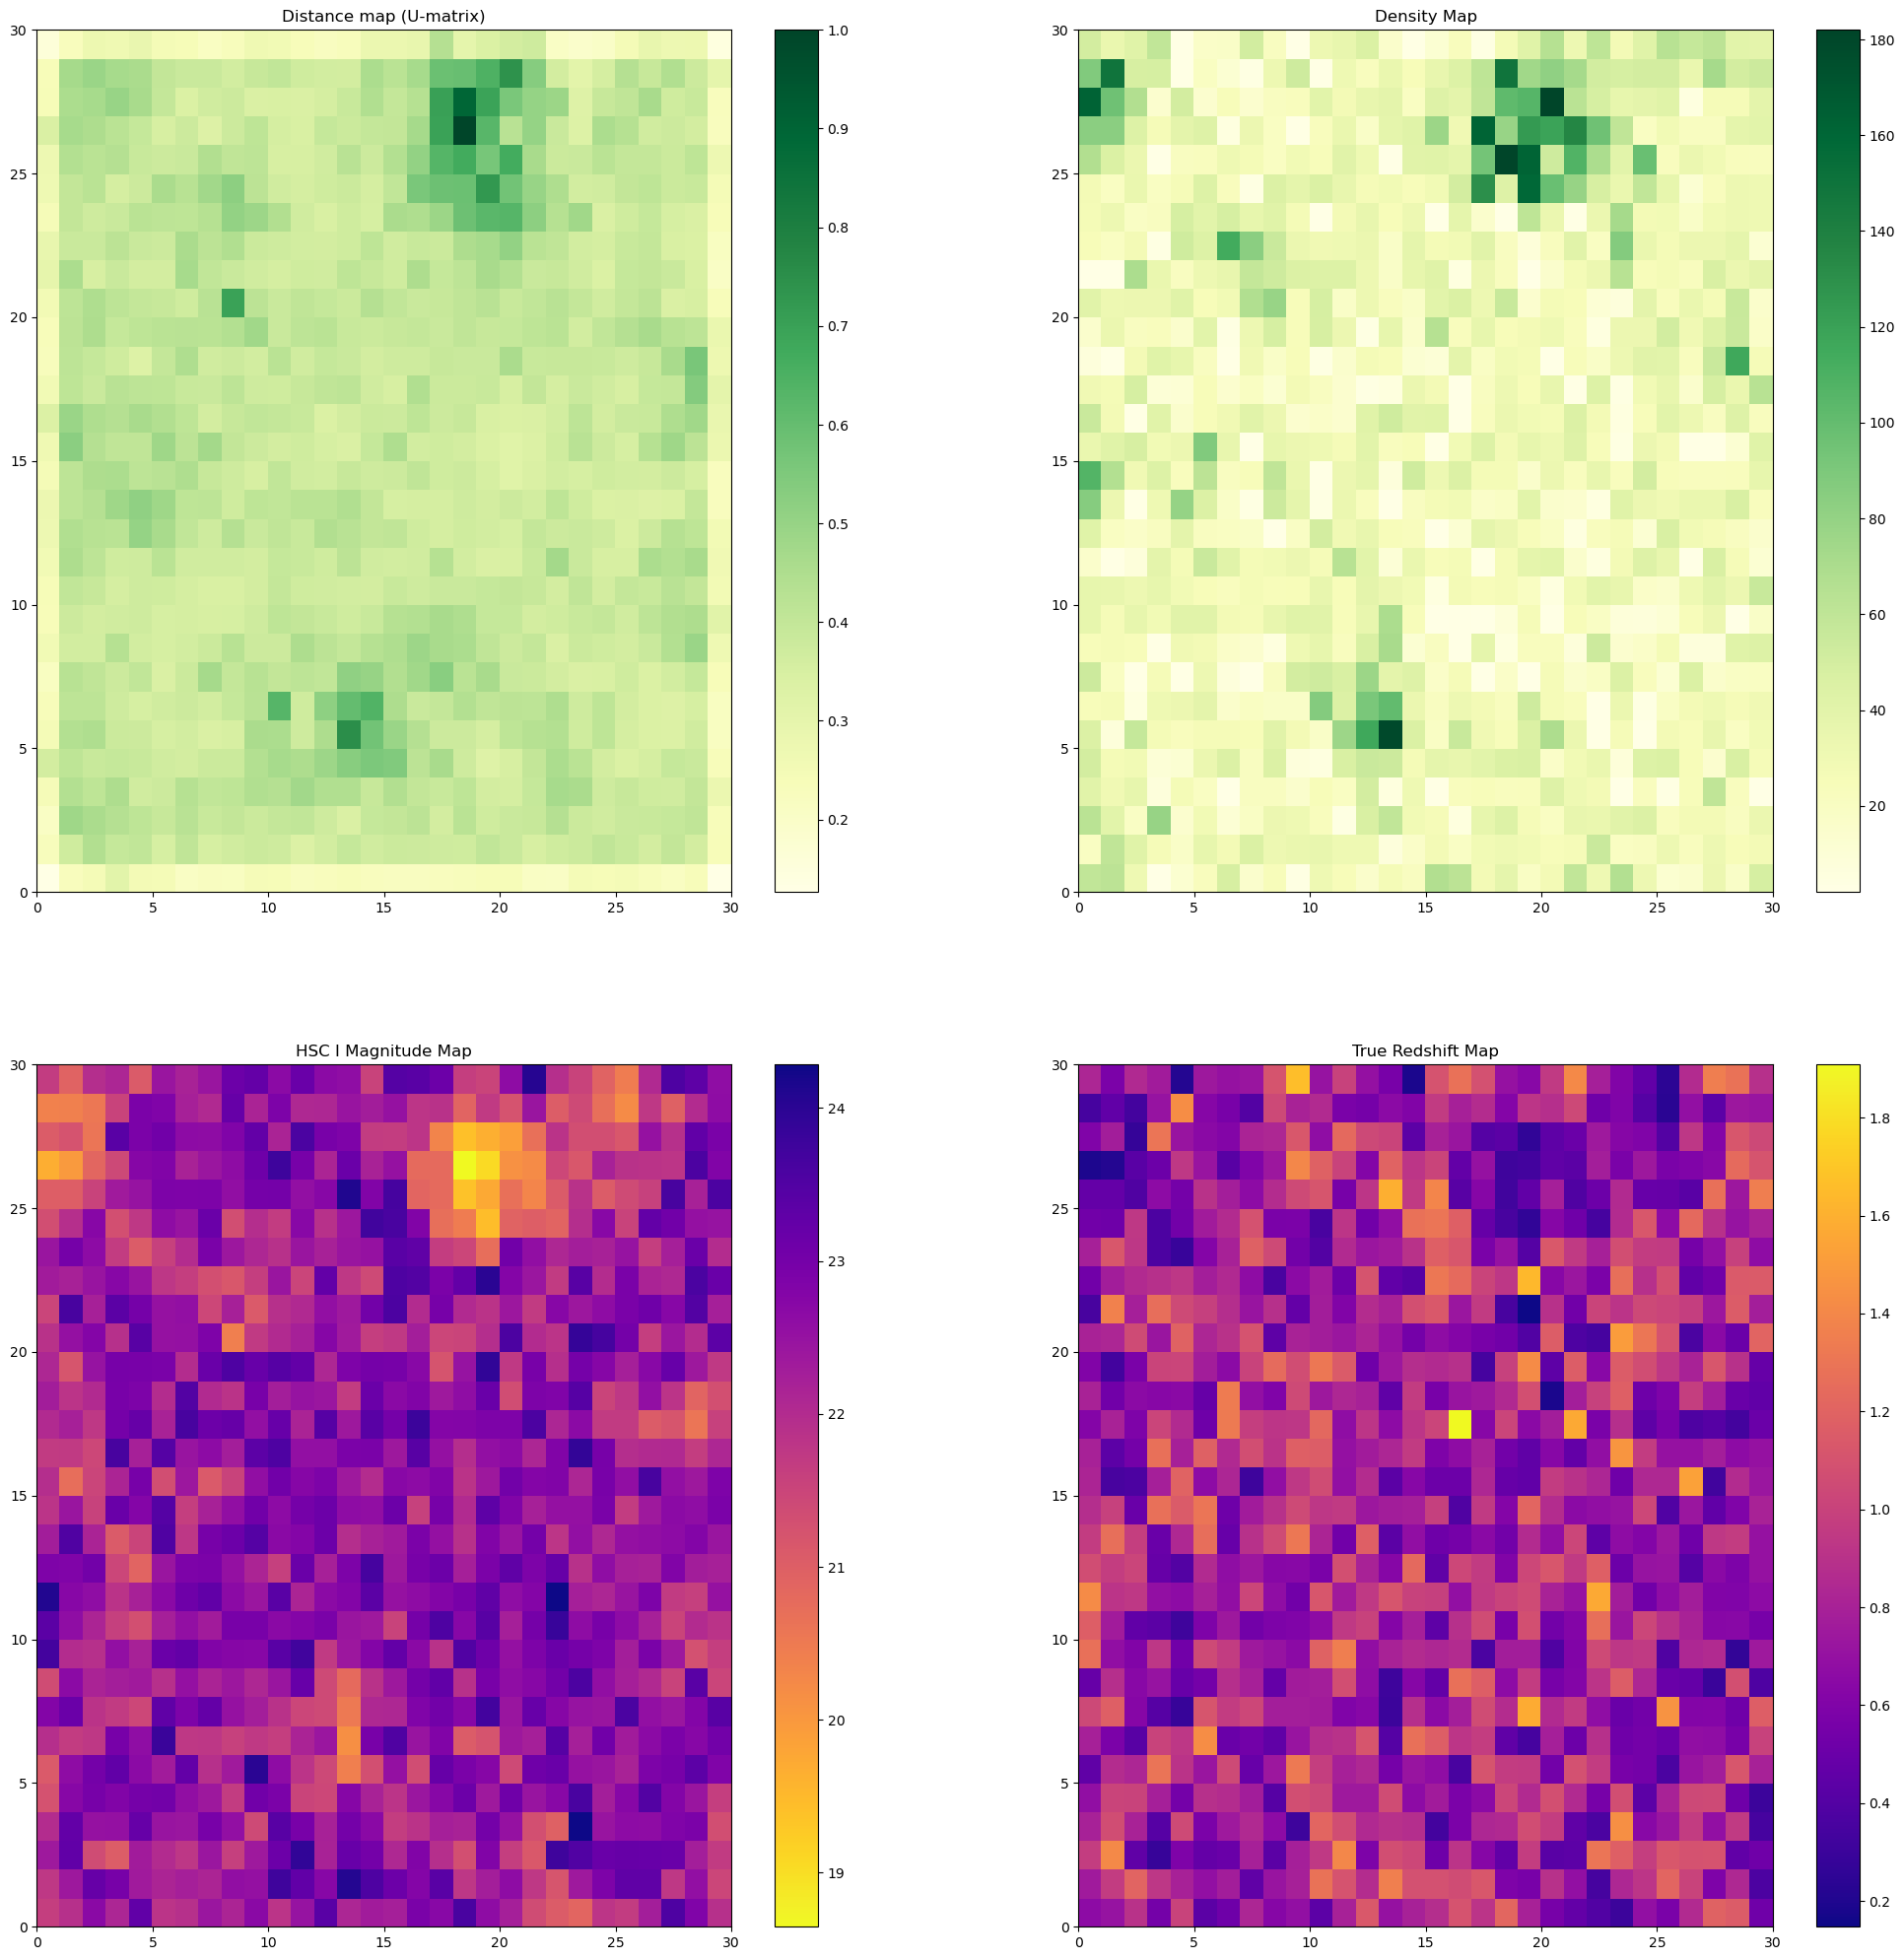

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.7]
29683.0
Topological error: 0.7279924535929657
Quantization error: 6.248769058311196
Average redshift std: 0.34500518473184116


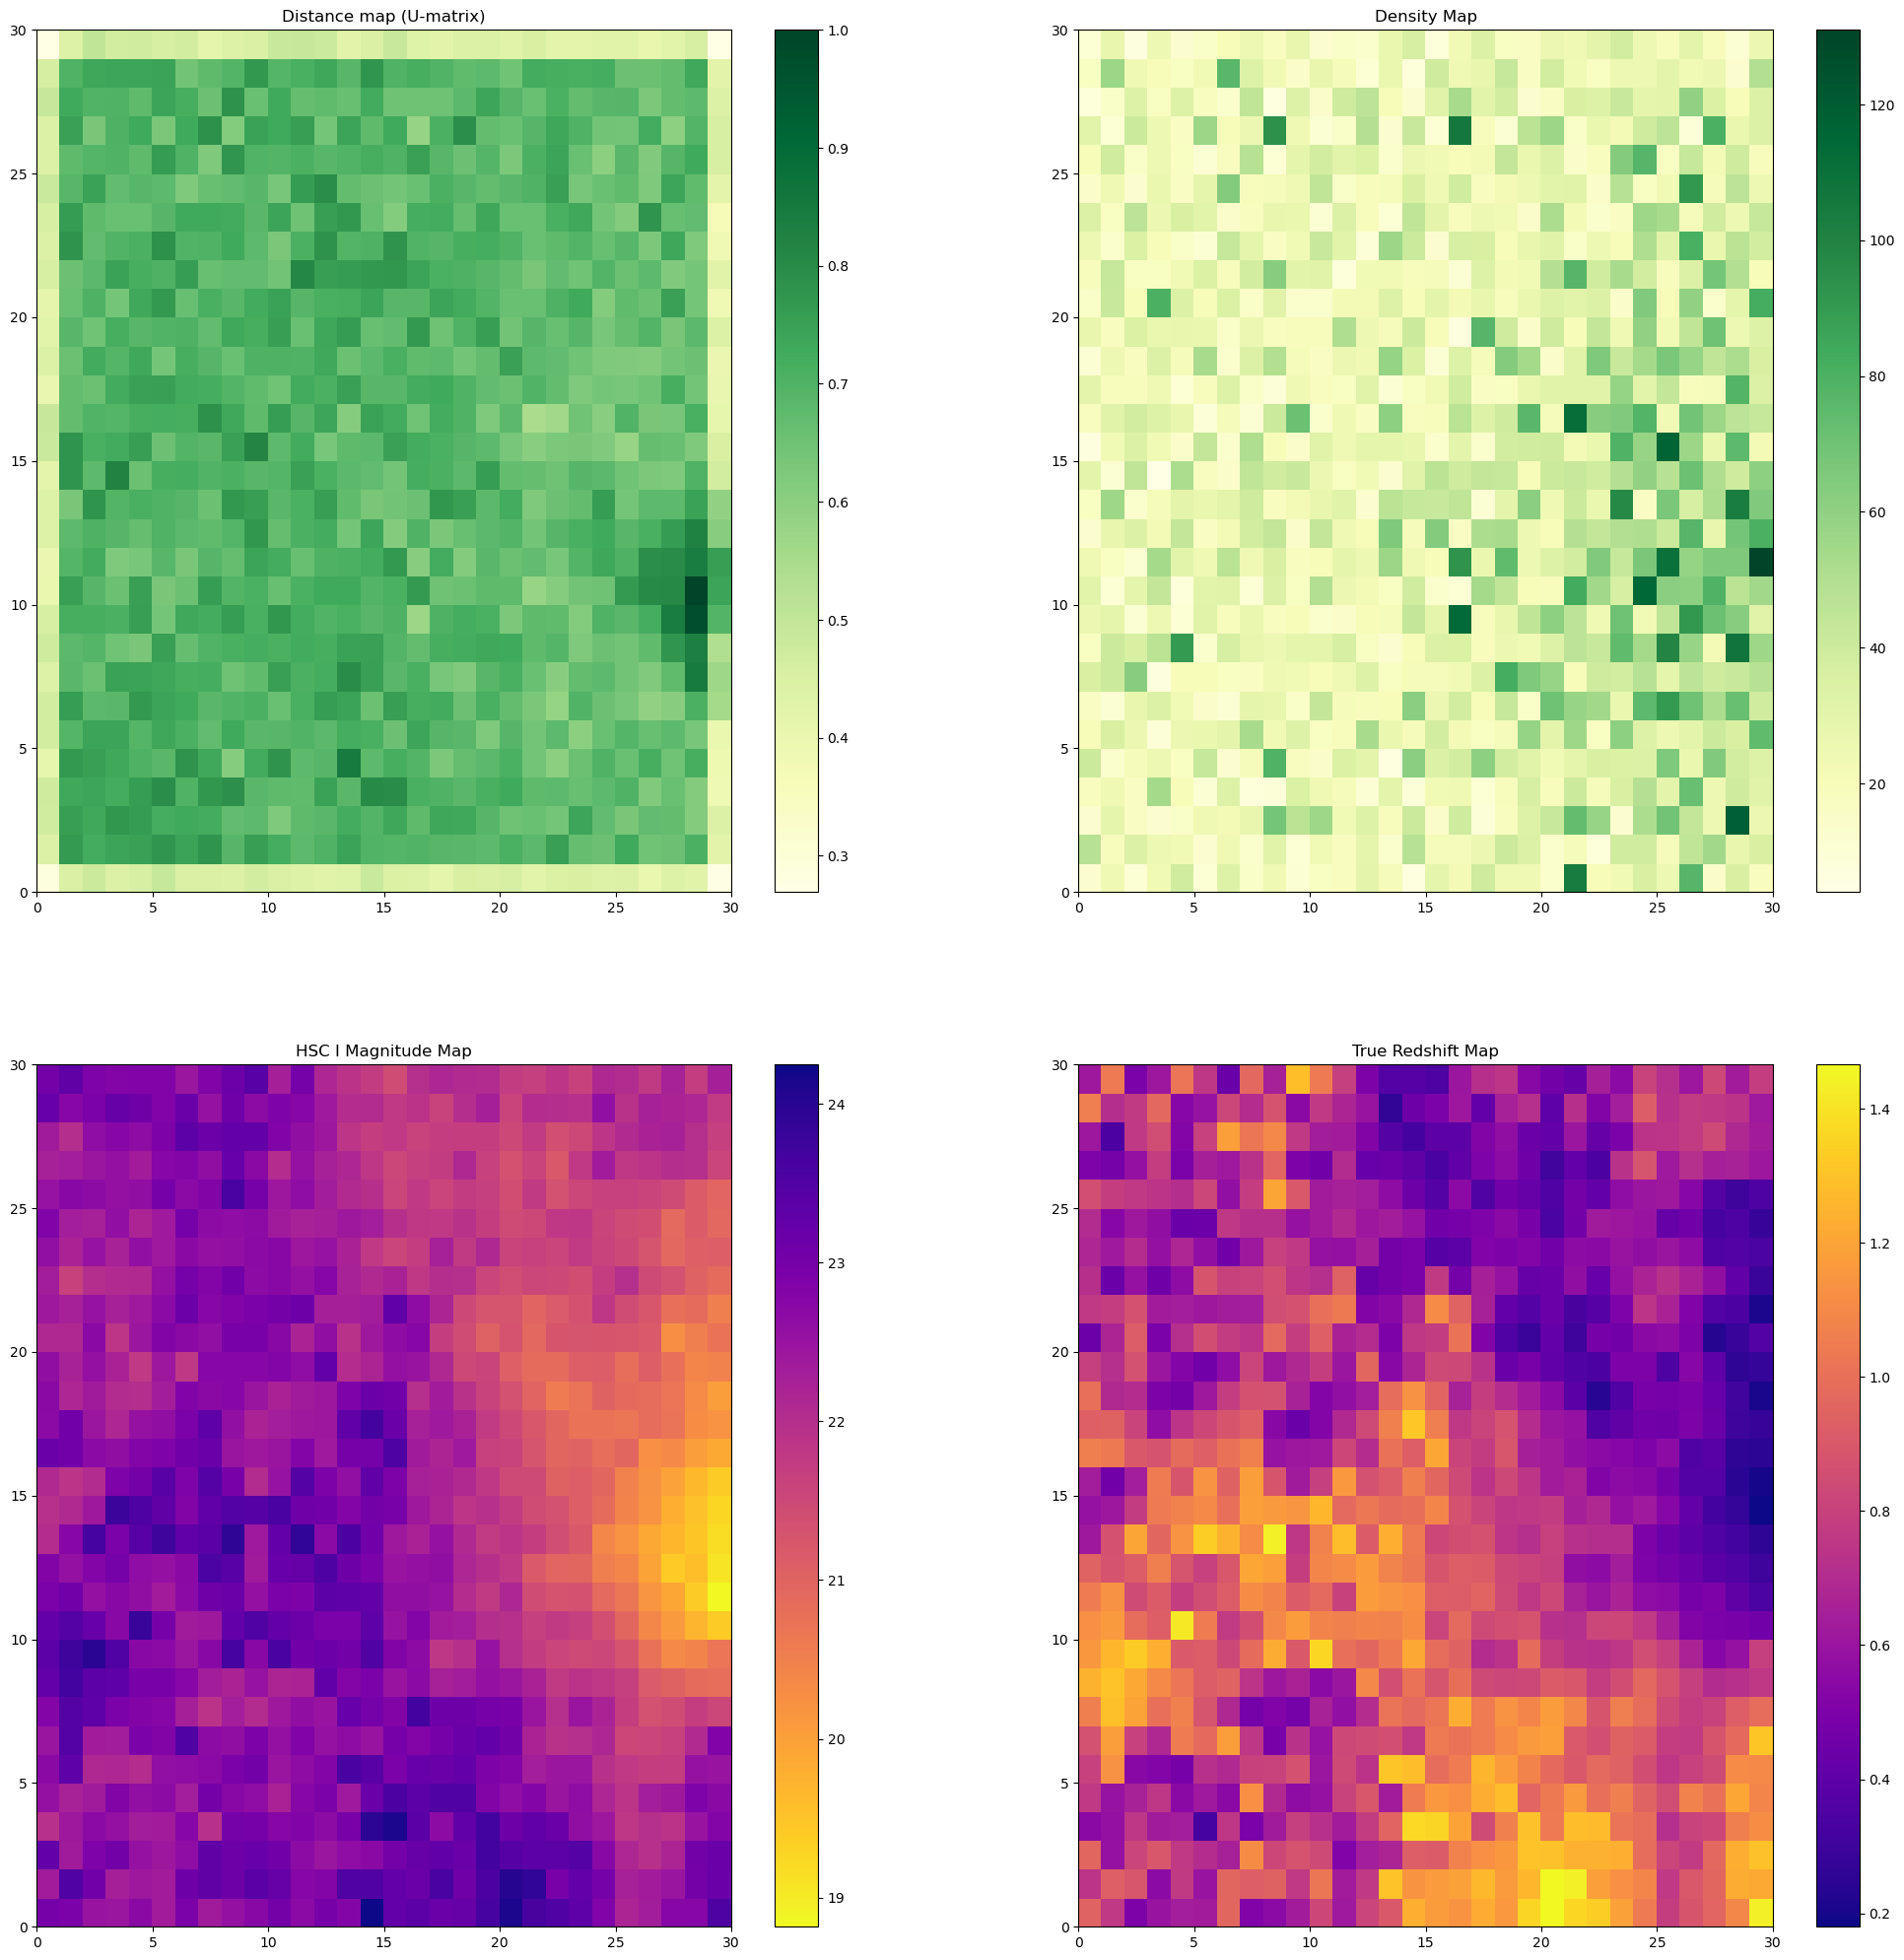

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.7]
29683.0
Topological error: 0.7977967186605127
Quantization error: 6.2685897168835245
Average redshift std: 0.34350644619088294


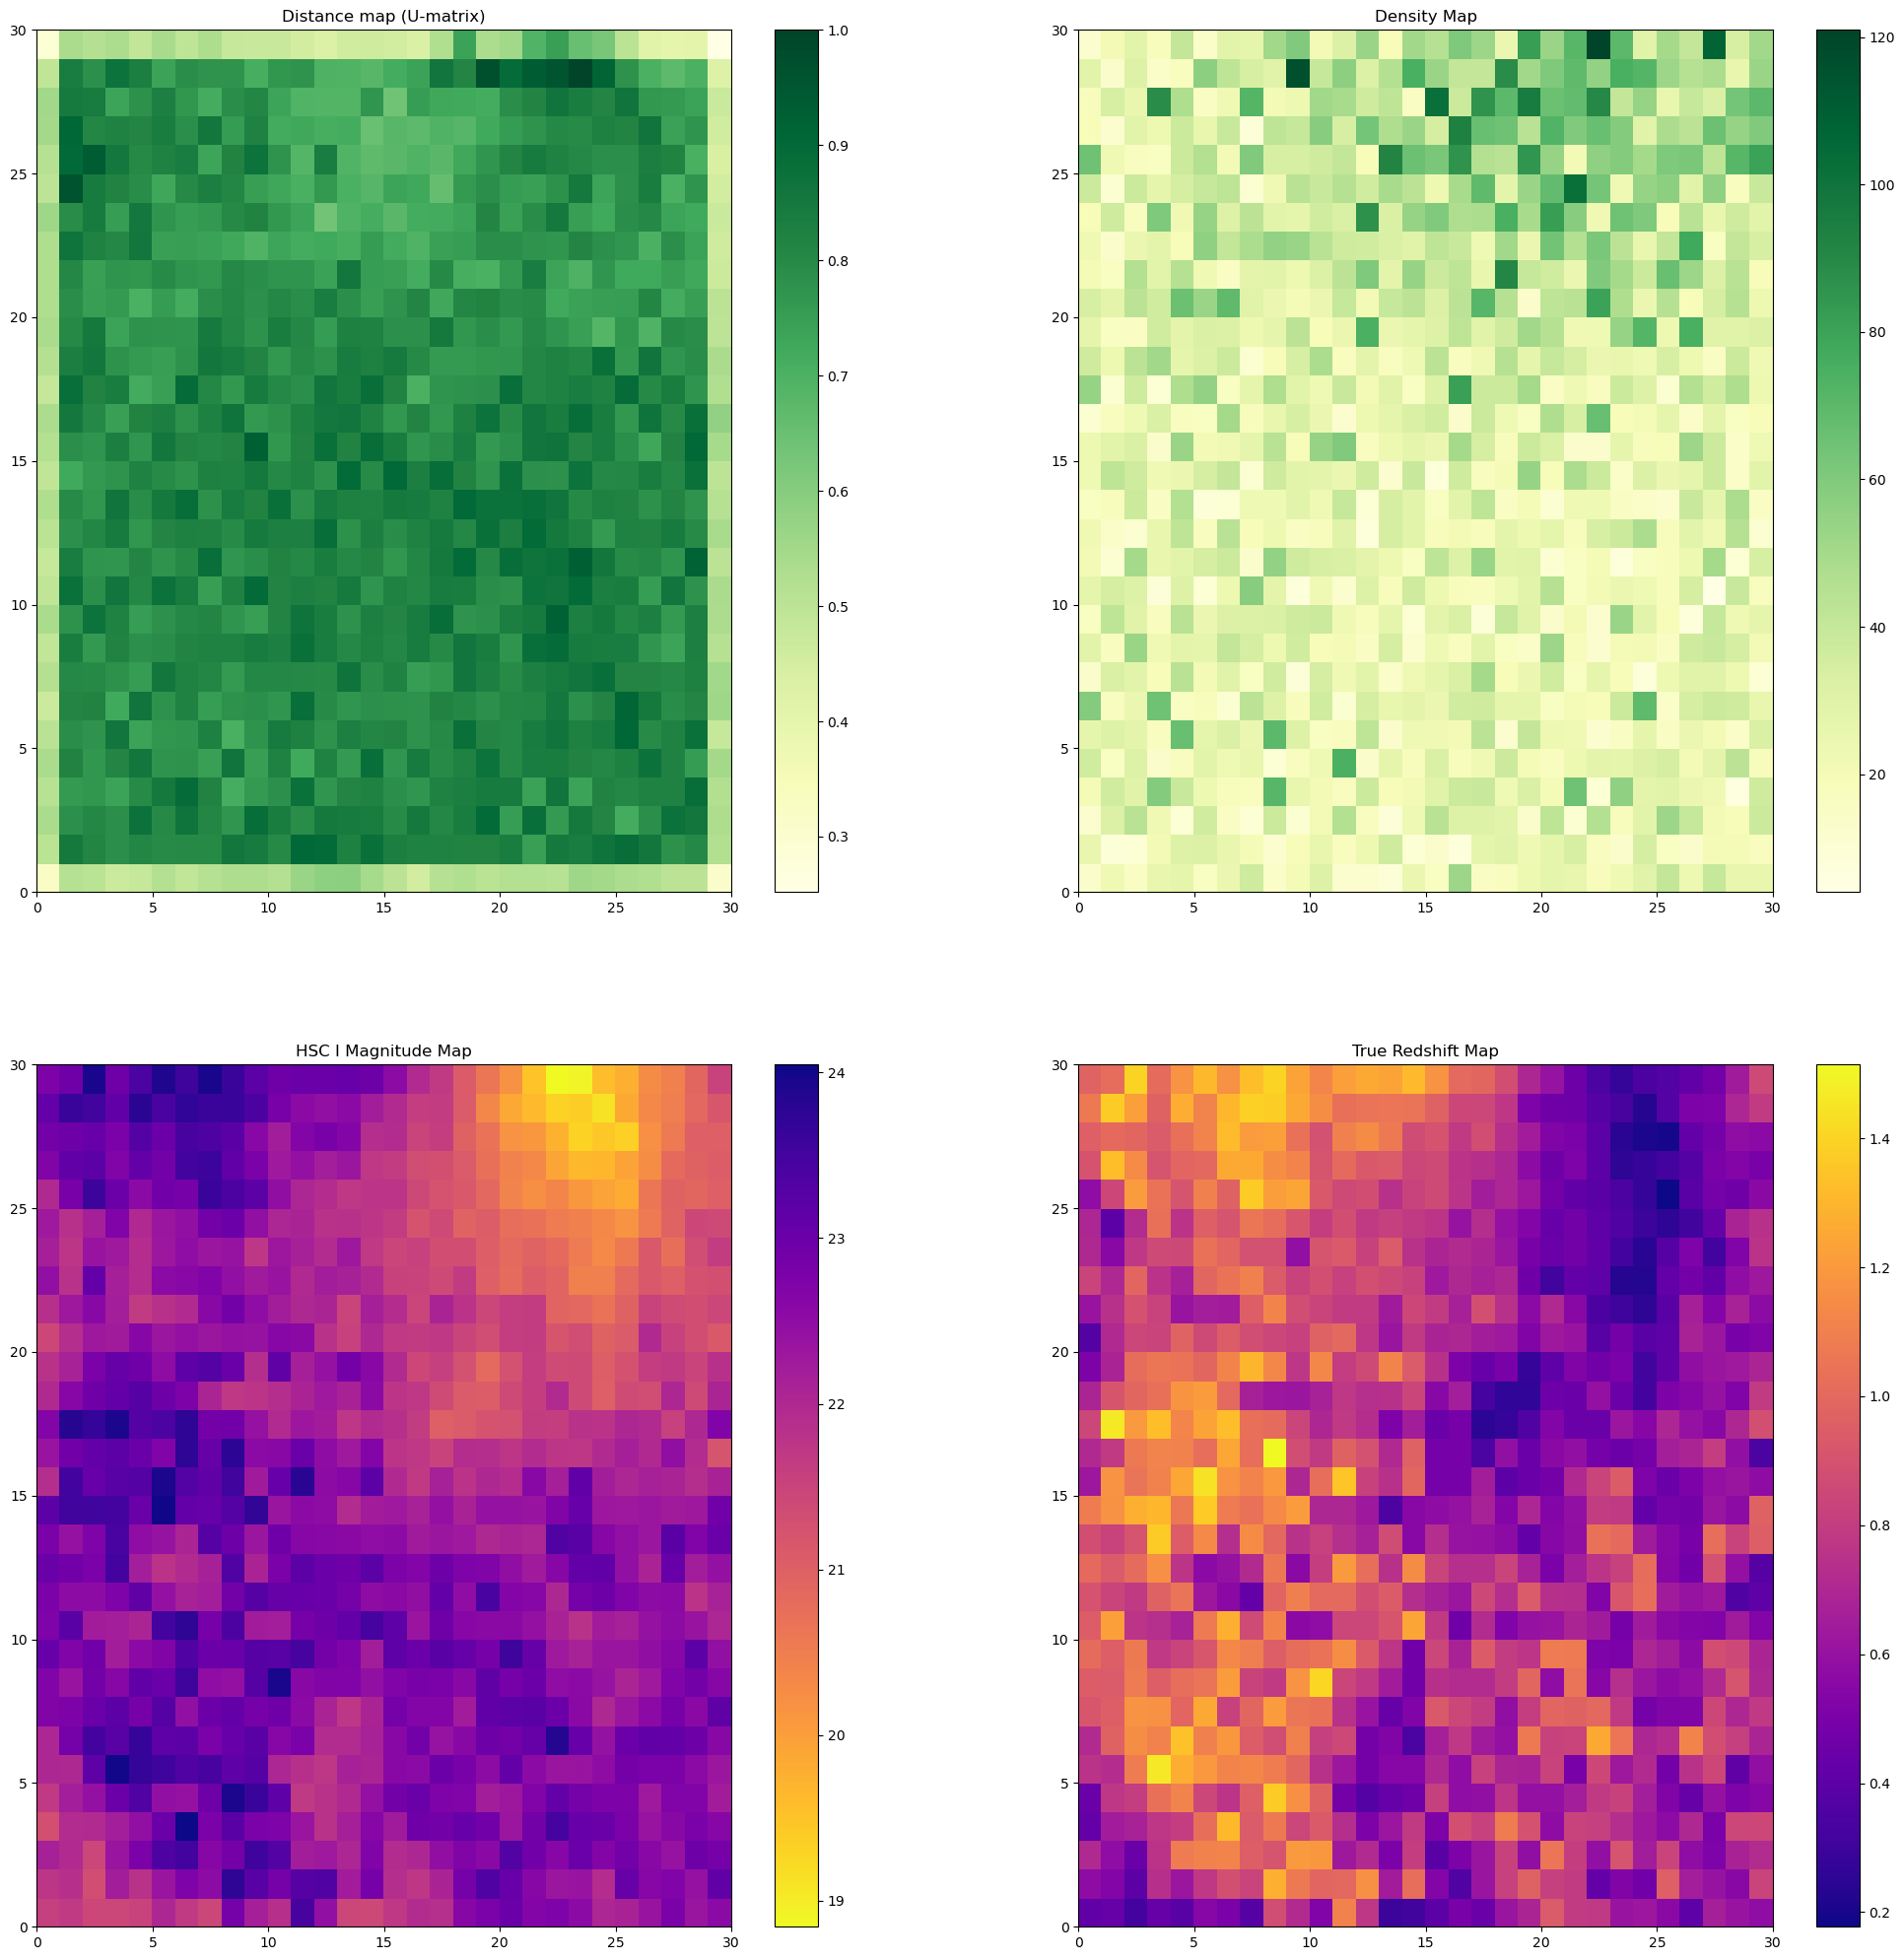

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.7]
29683.0
Topological error: 0.8590102078630866
Quantization error: 6.30210106335591
Average redshift std: 0.3500343483685982


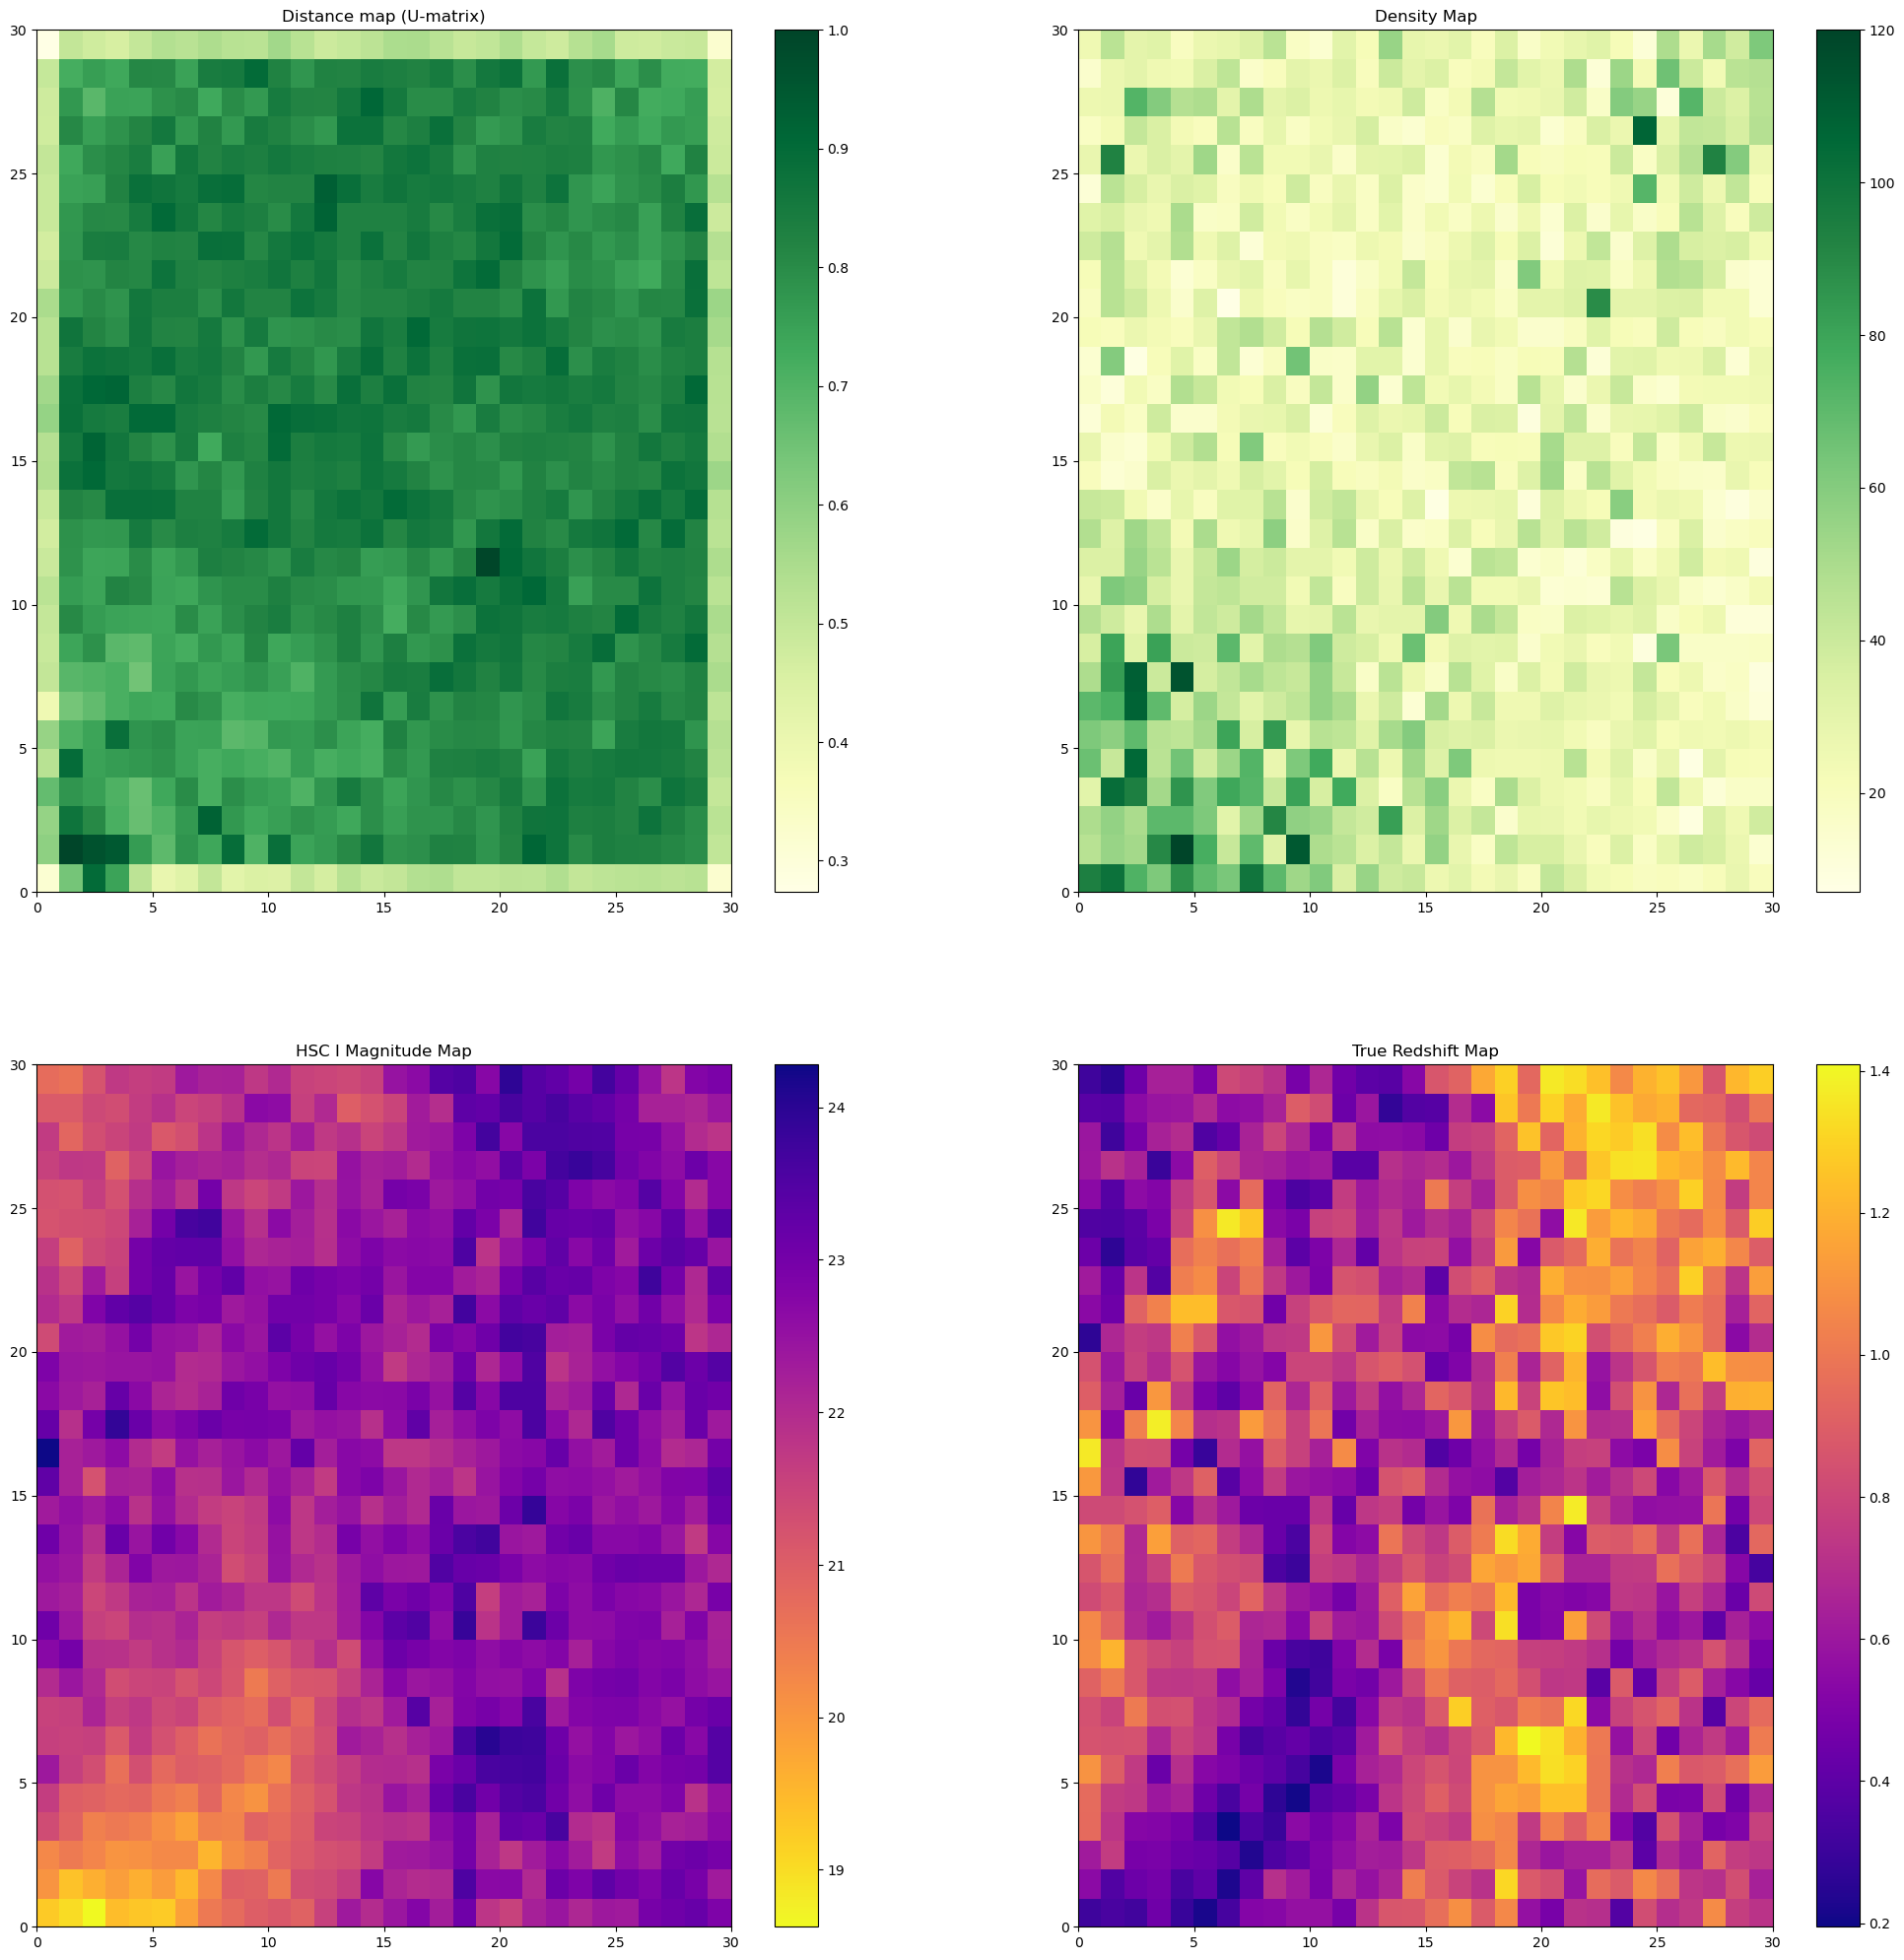

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.7]
29683.0
Topological error: 0.9246706869251761
Quantization error: 6.344076874146181
Average redshift std: 0.3511513293017548


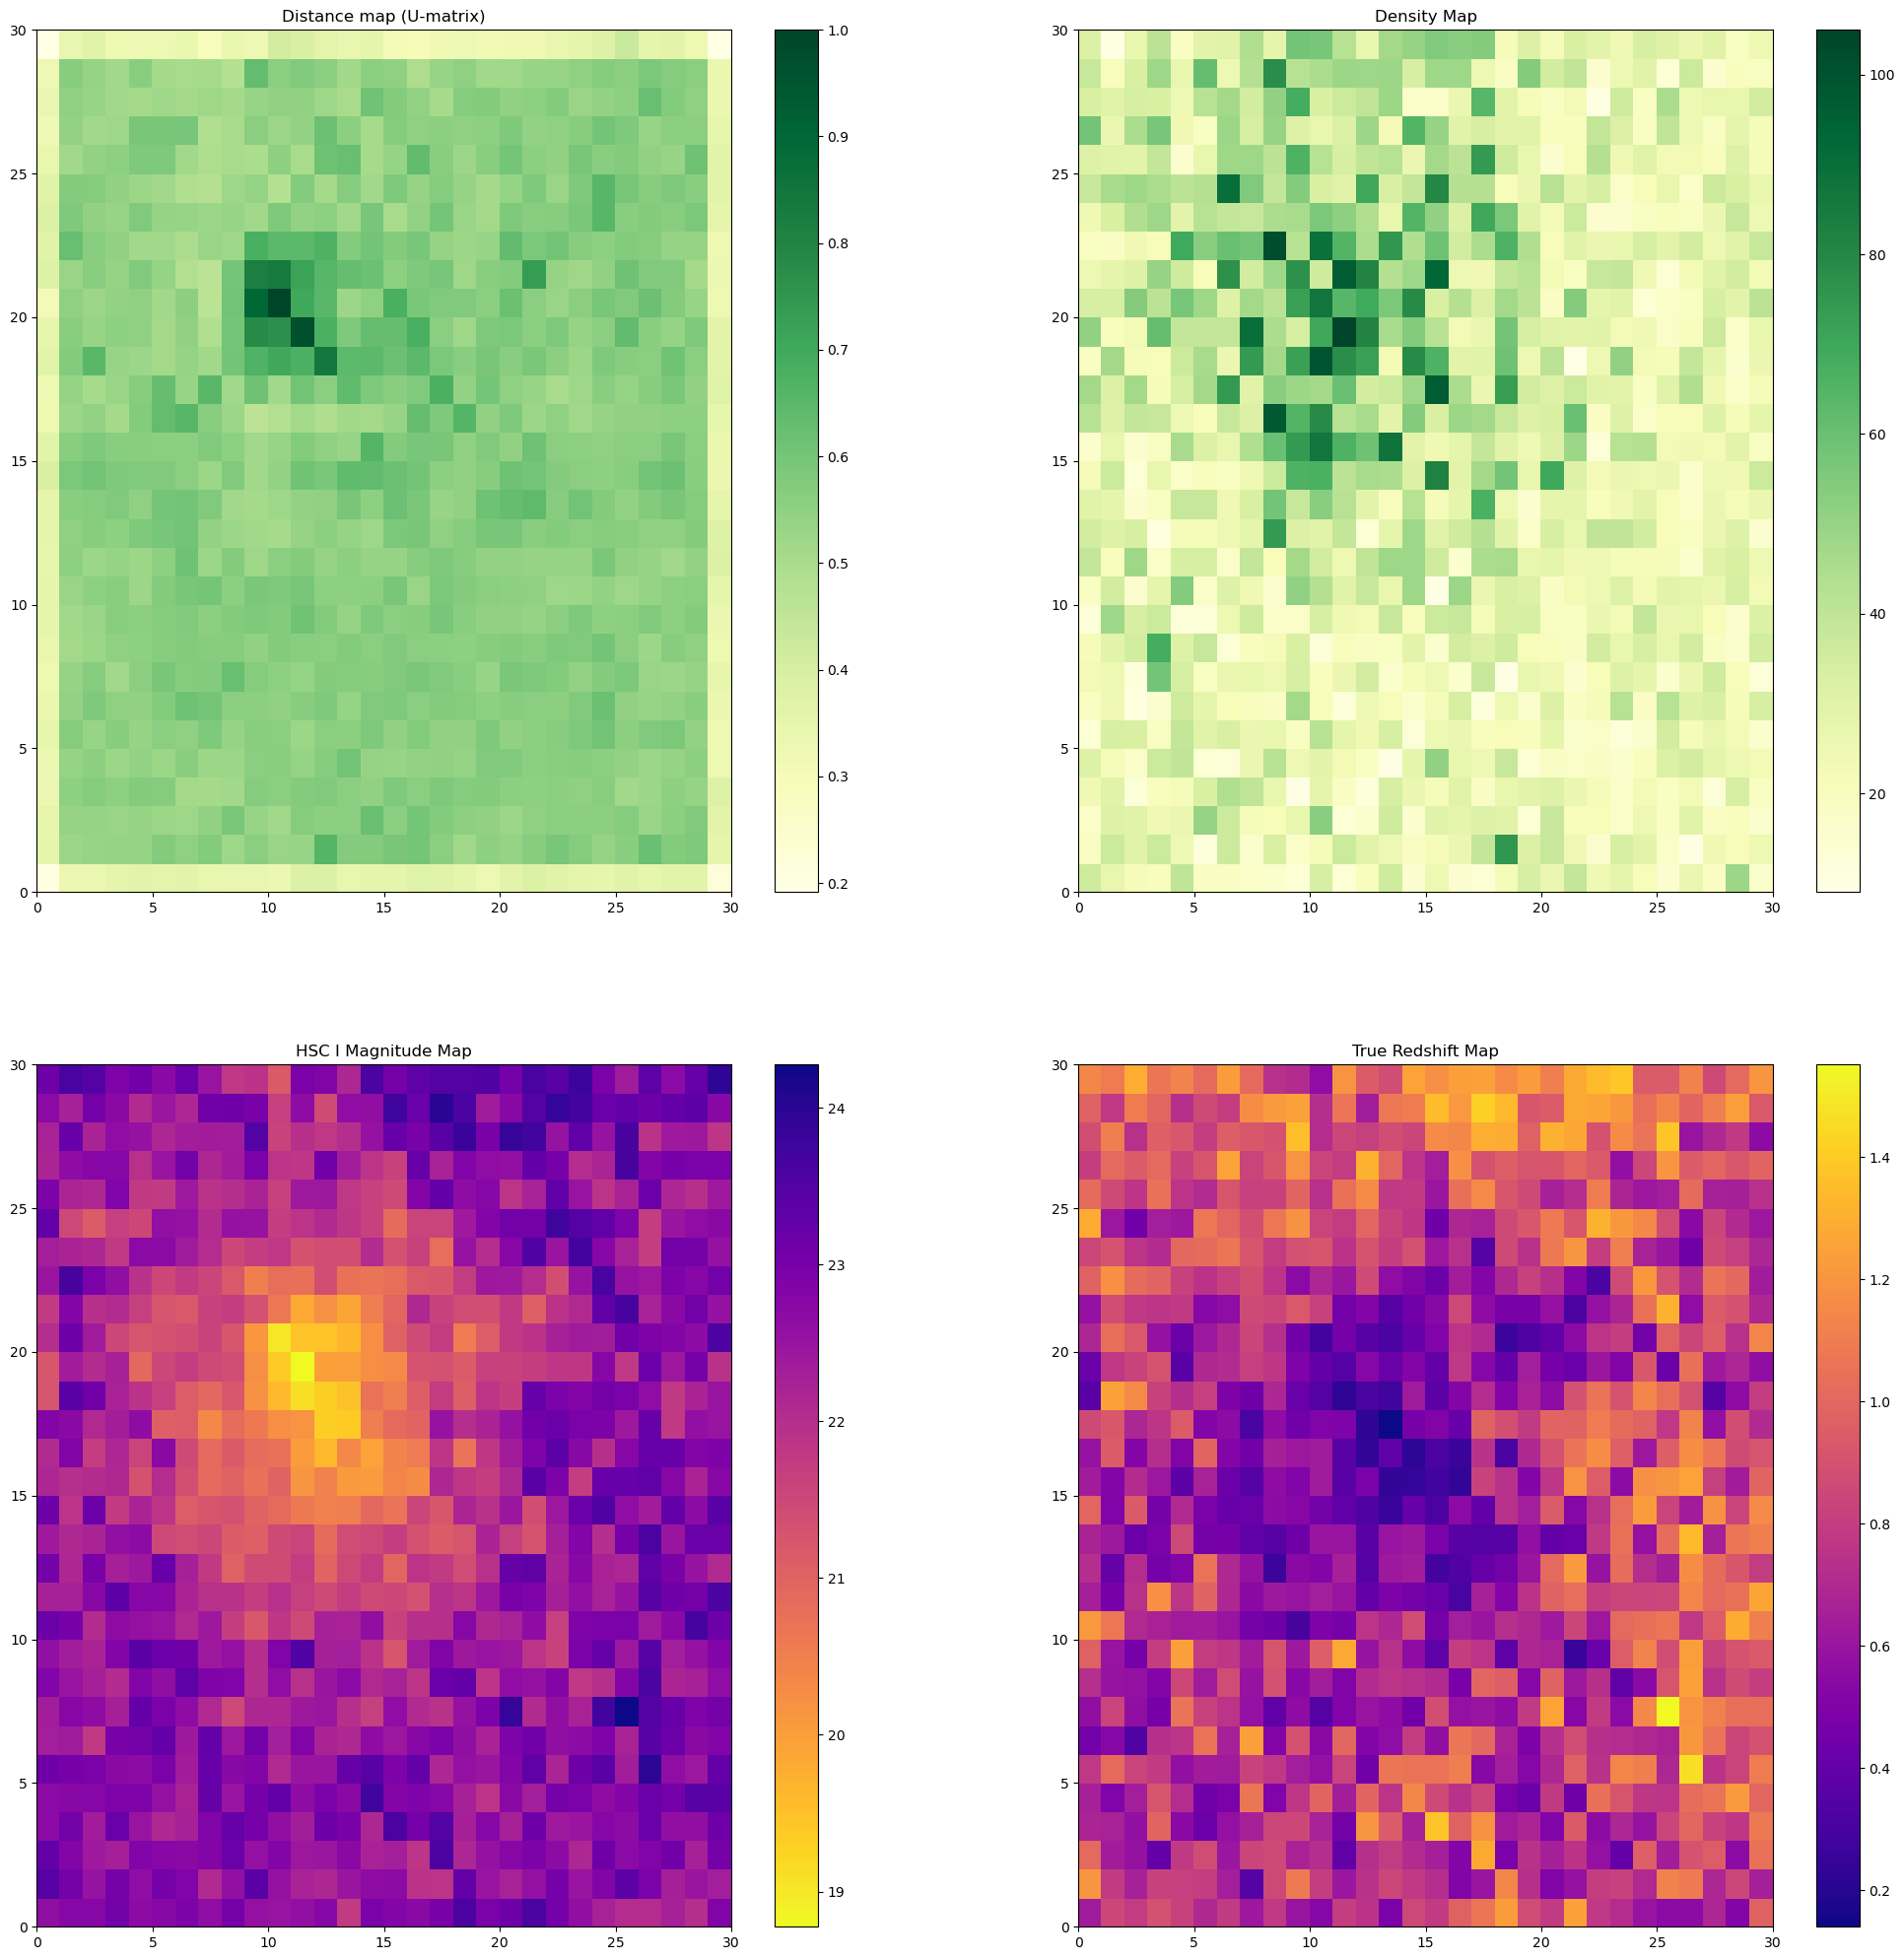

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 0.7]
29683.0
Topological error: 0.9378768992352525
Quantization error: 6.384116053826161
Average redshift std: 0.35635752664056275


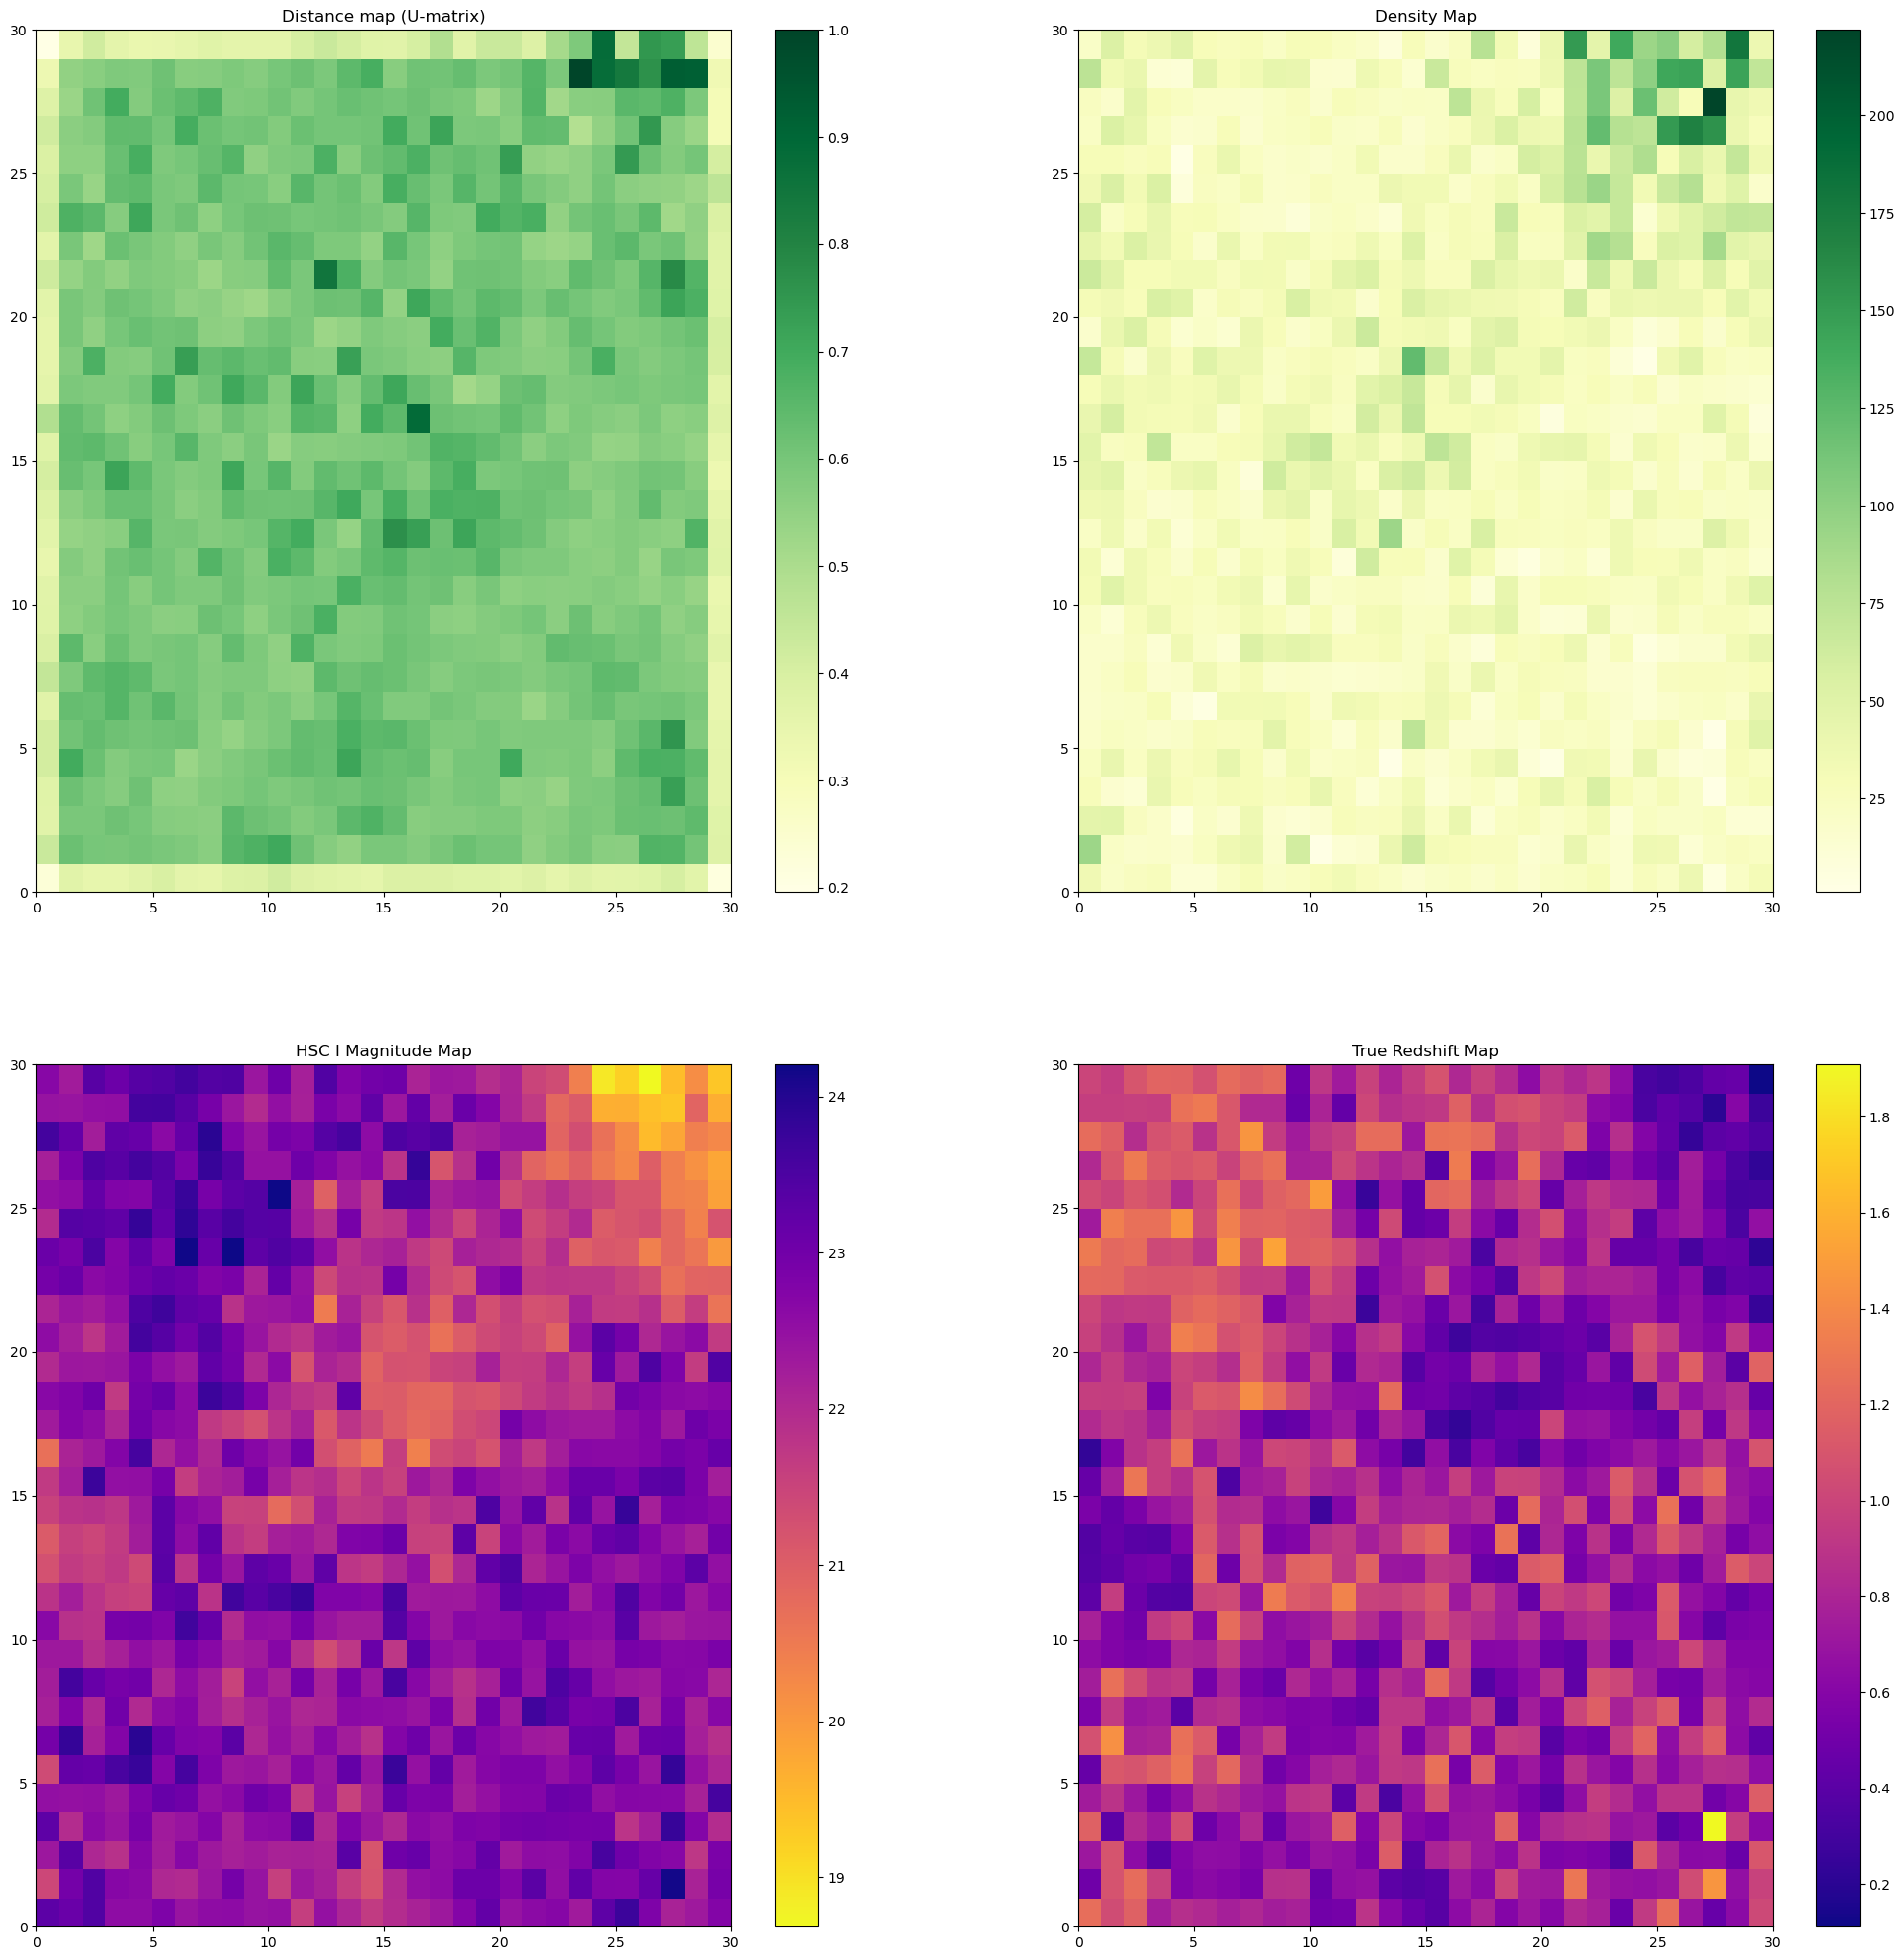

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.7]
29683.0
Topological error: 0.9475794225651046
Quantization error: 6.39089747510457
Average redshift std: 0.3494290087617213


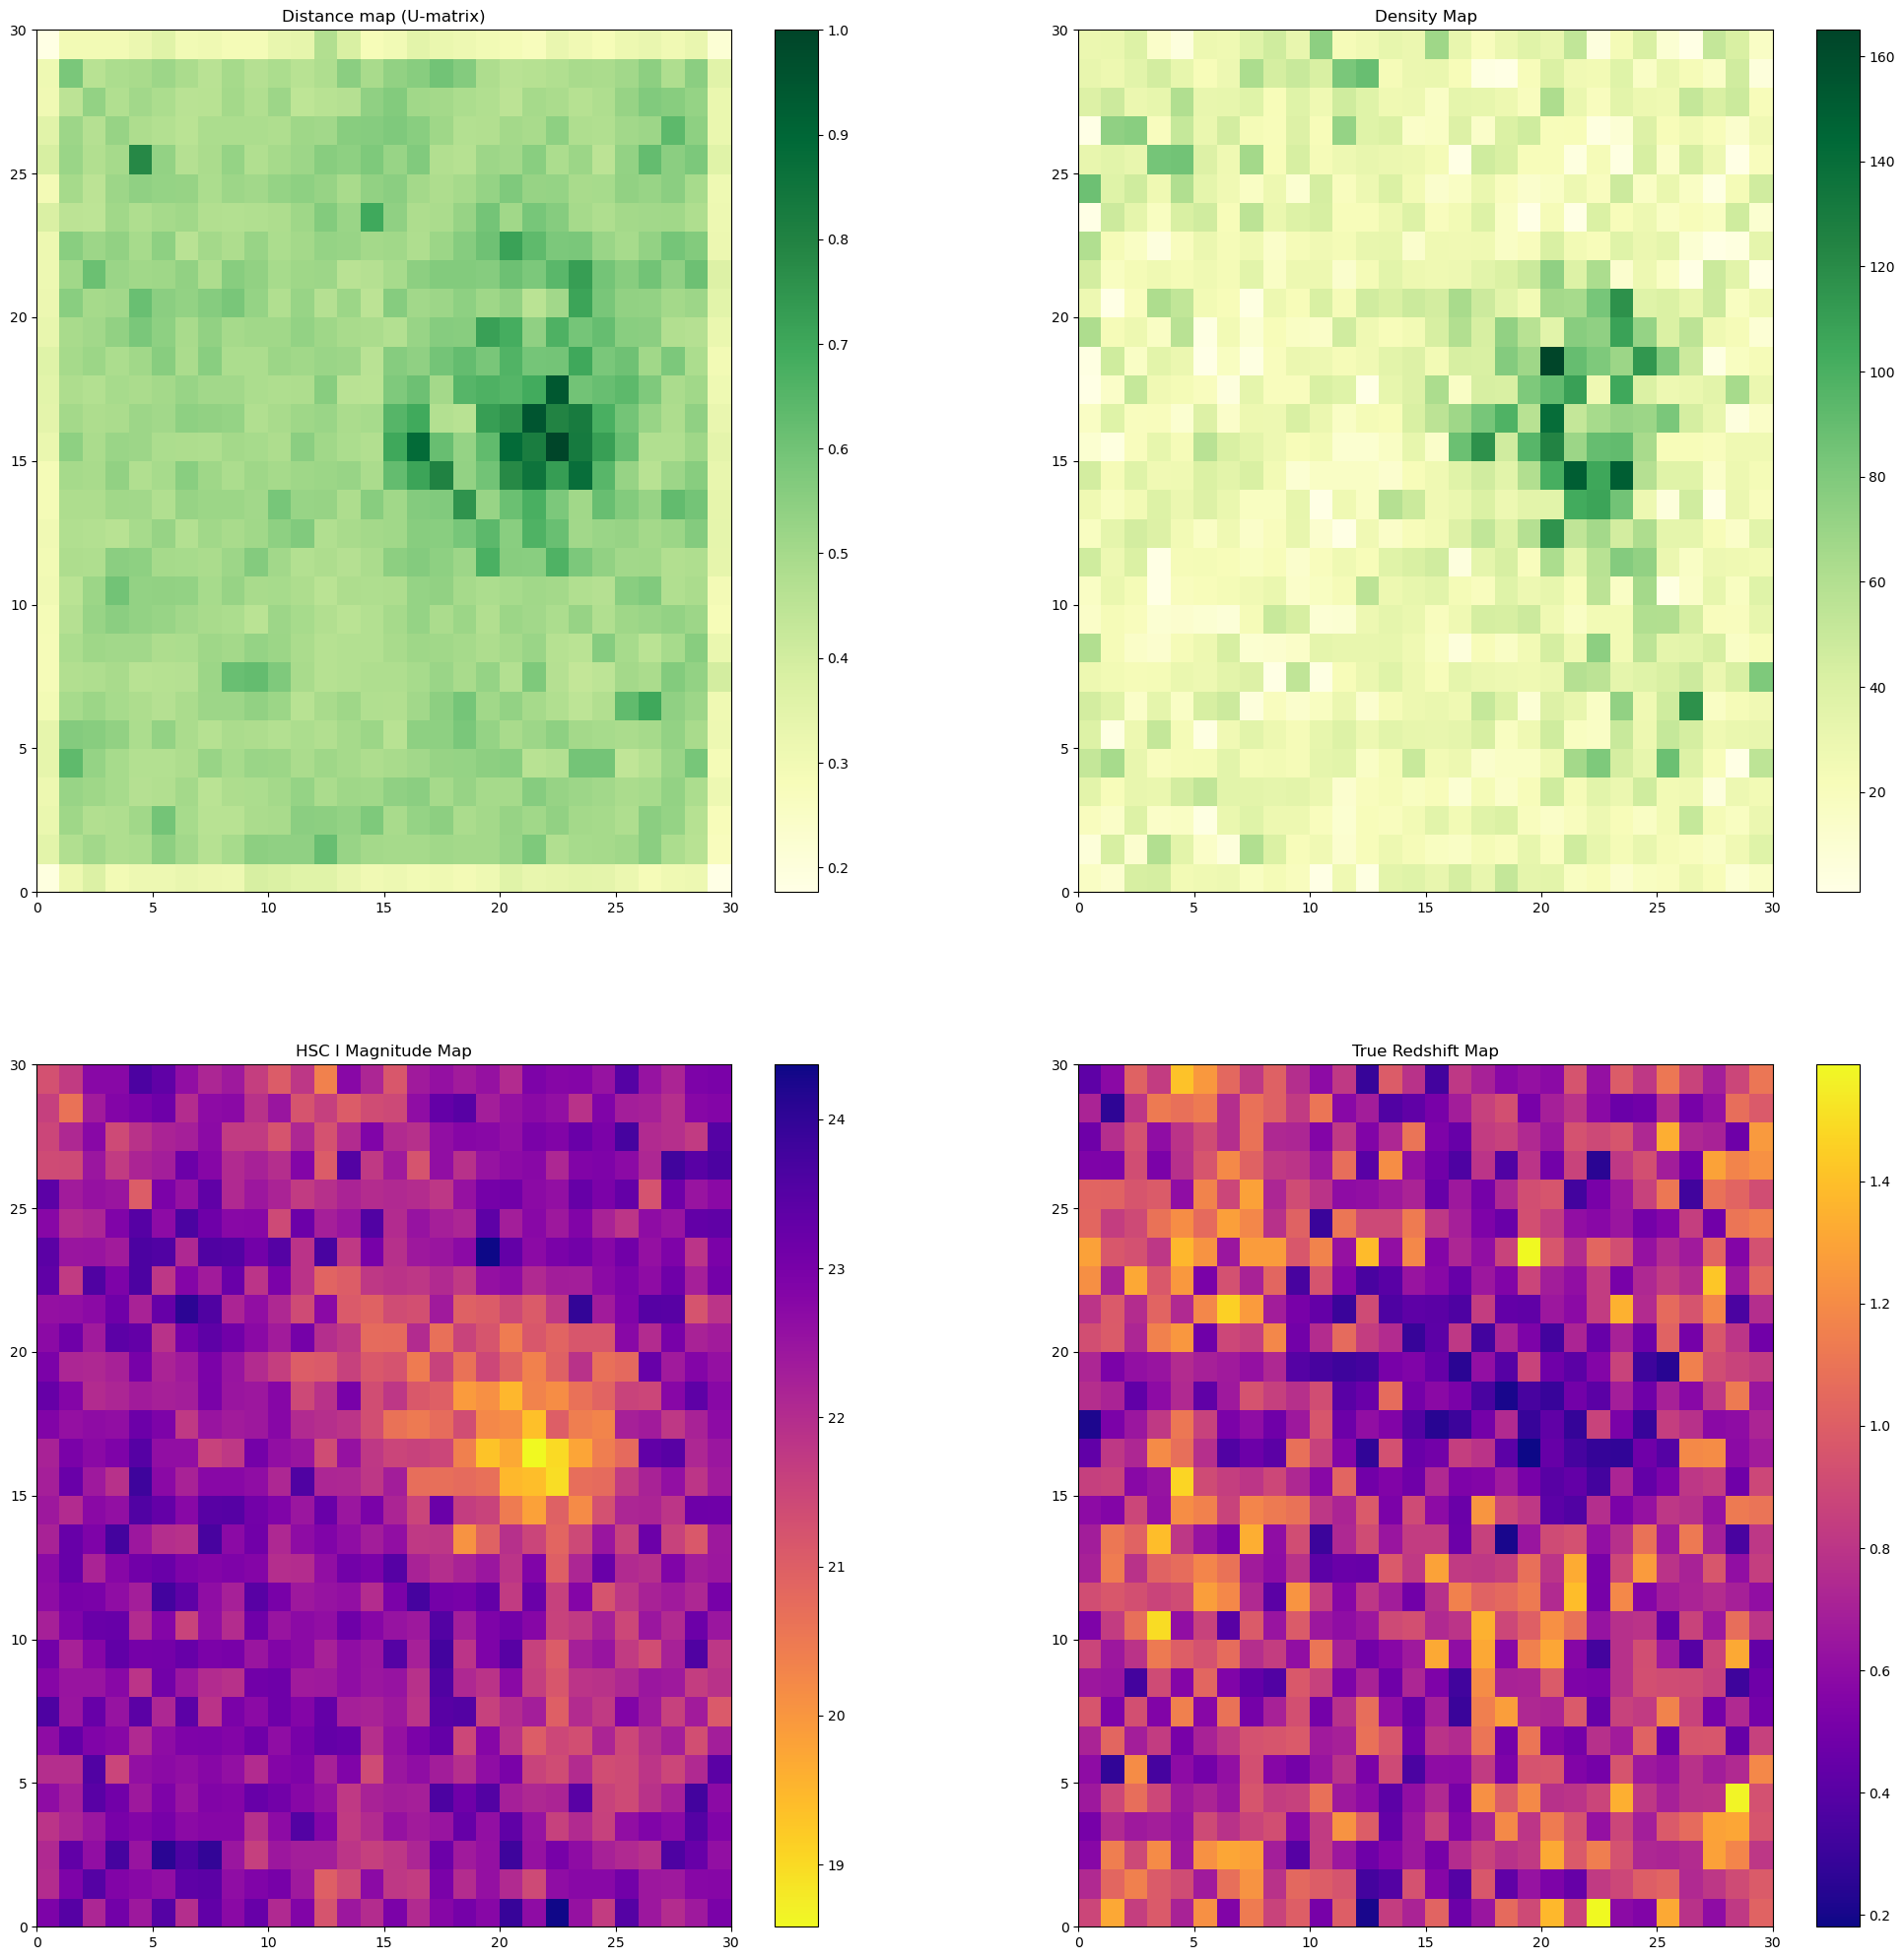

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.7]
29683.0
Topological error: 0.9552605868679042
Quantization error: 6.430743380042495
Average redshift std: 0.35546380652013404


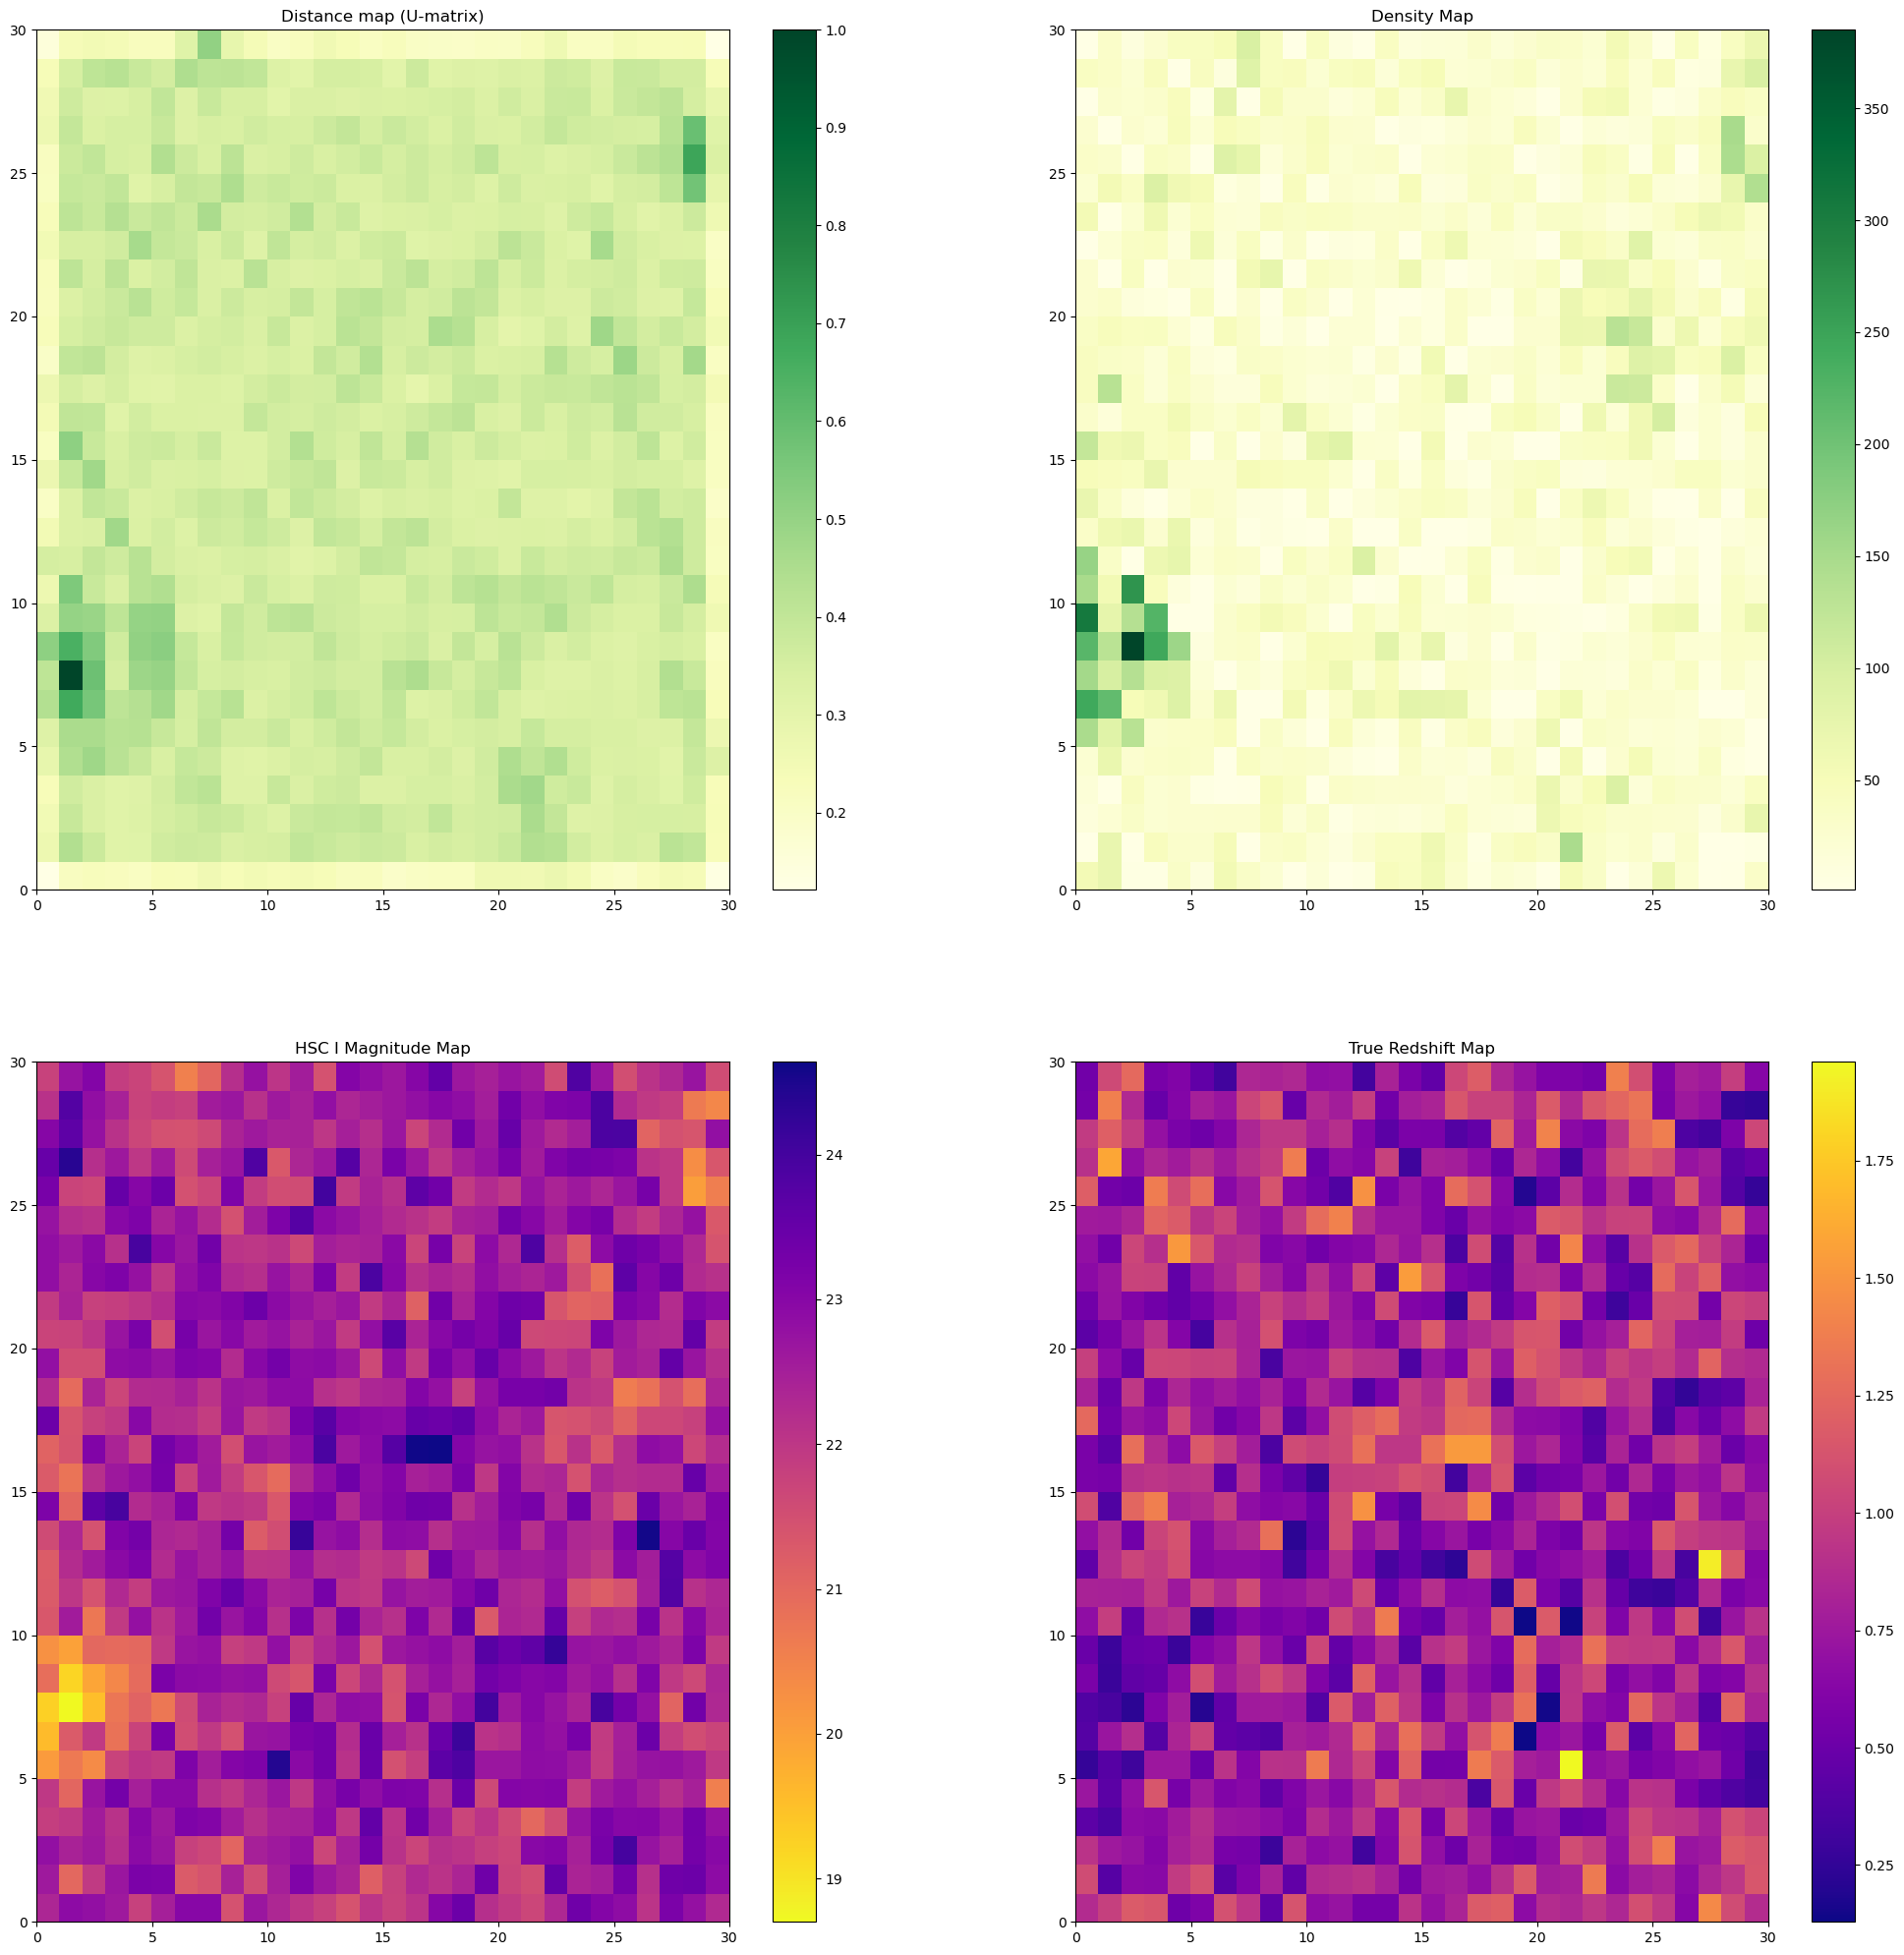

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.8]
29683.0
Topological error: 0.7097665330323755
Quantization error: 6.287208131922226
Average redshift std: 0.3596969617596782


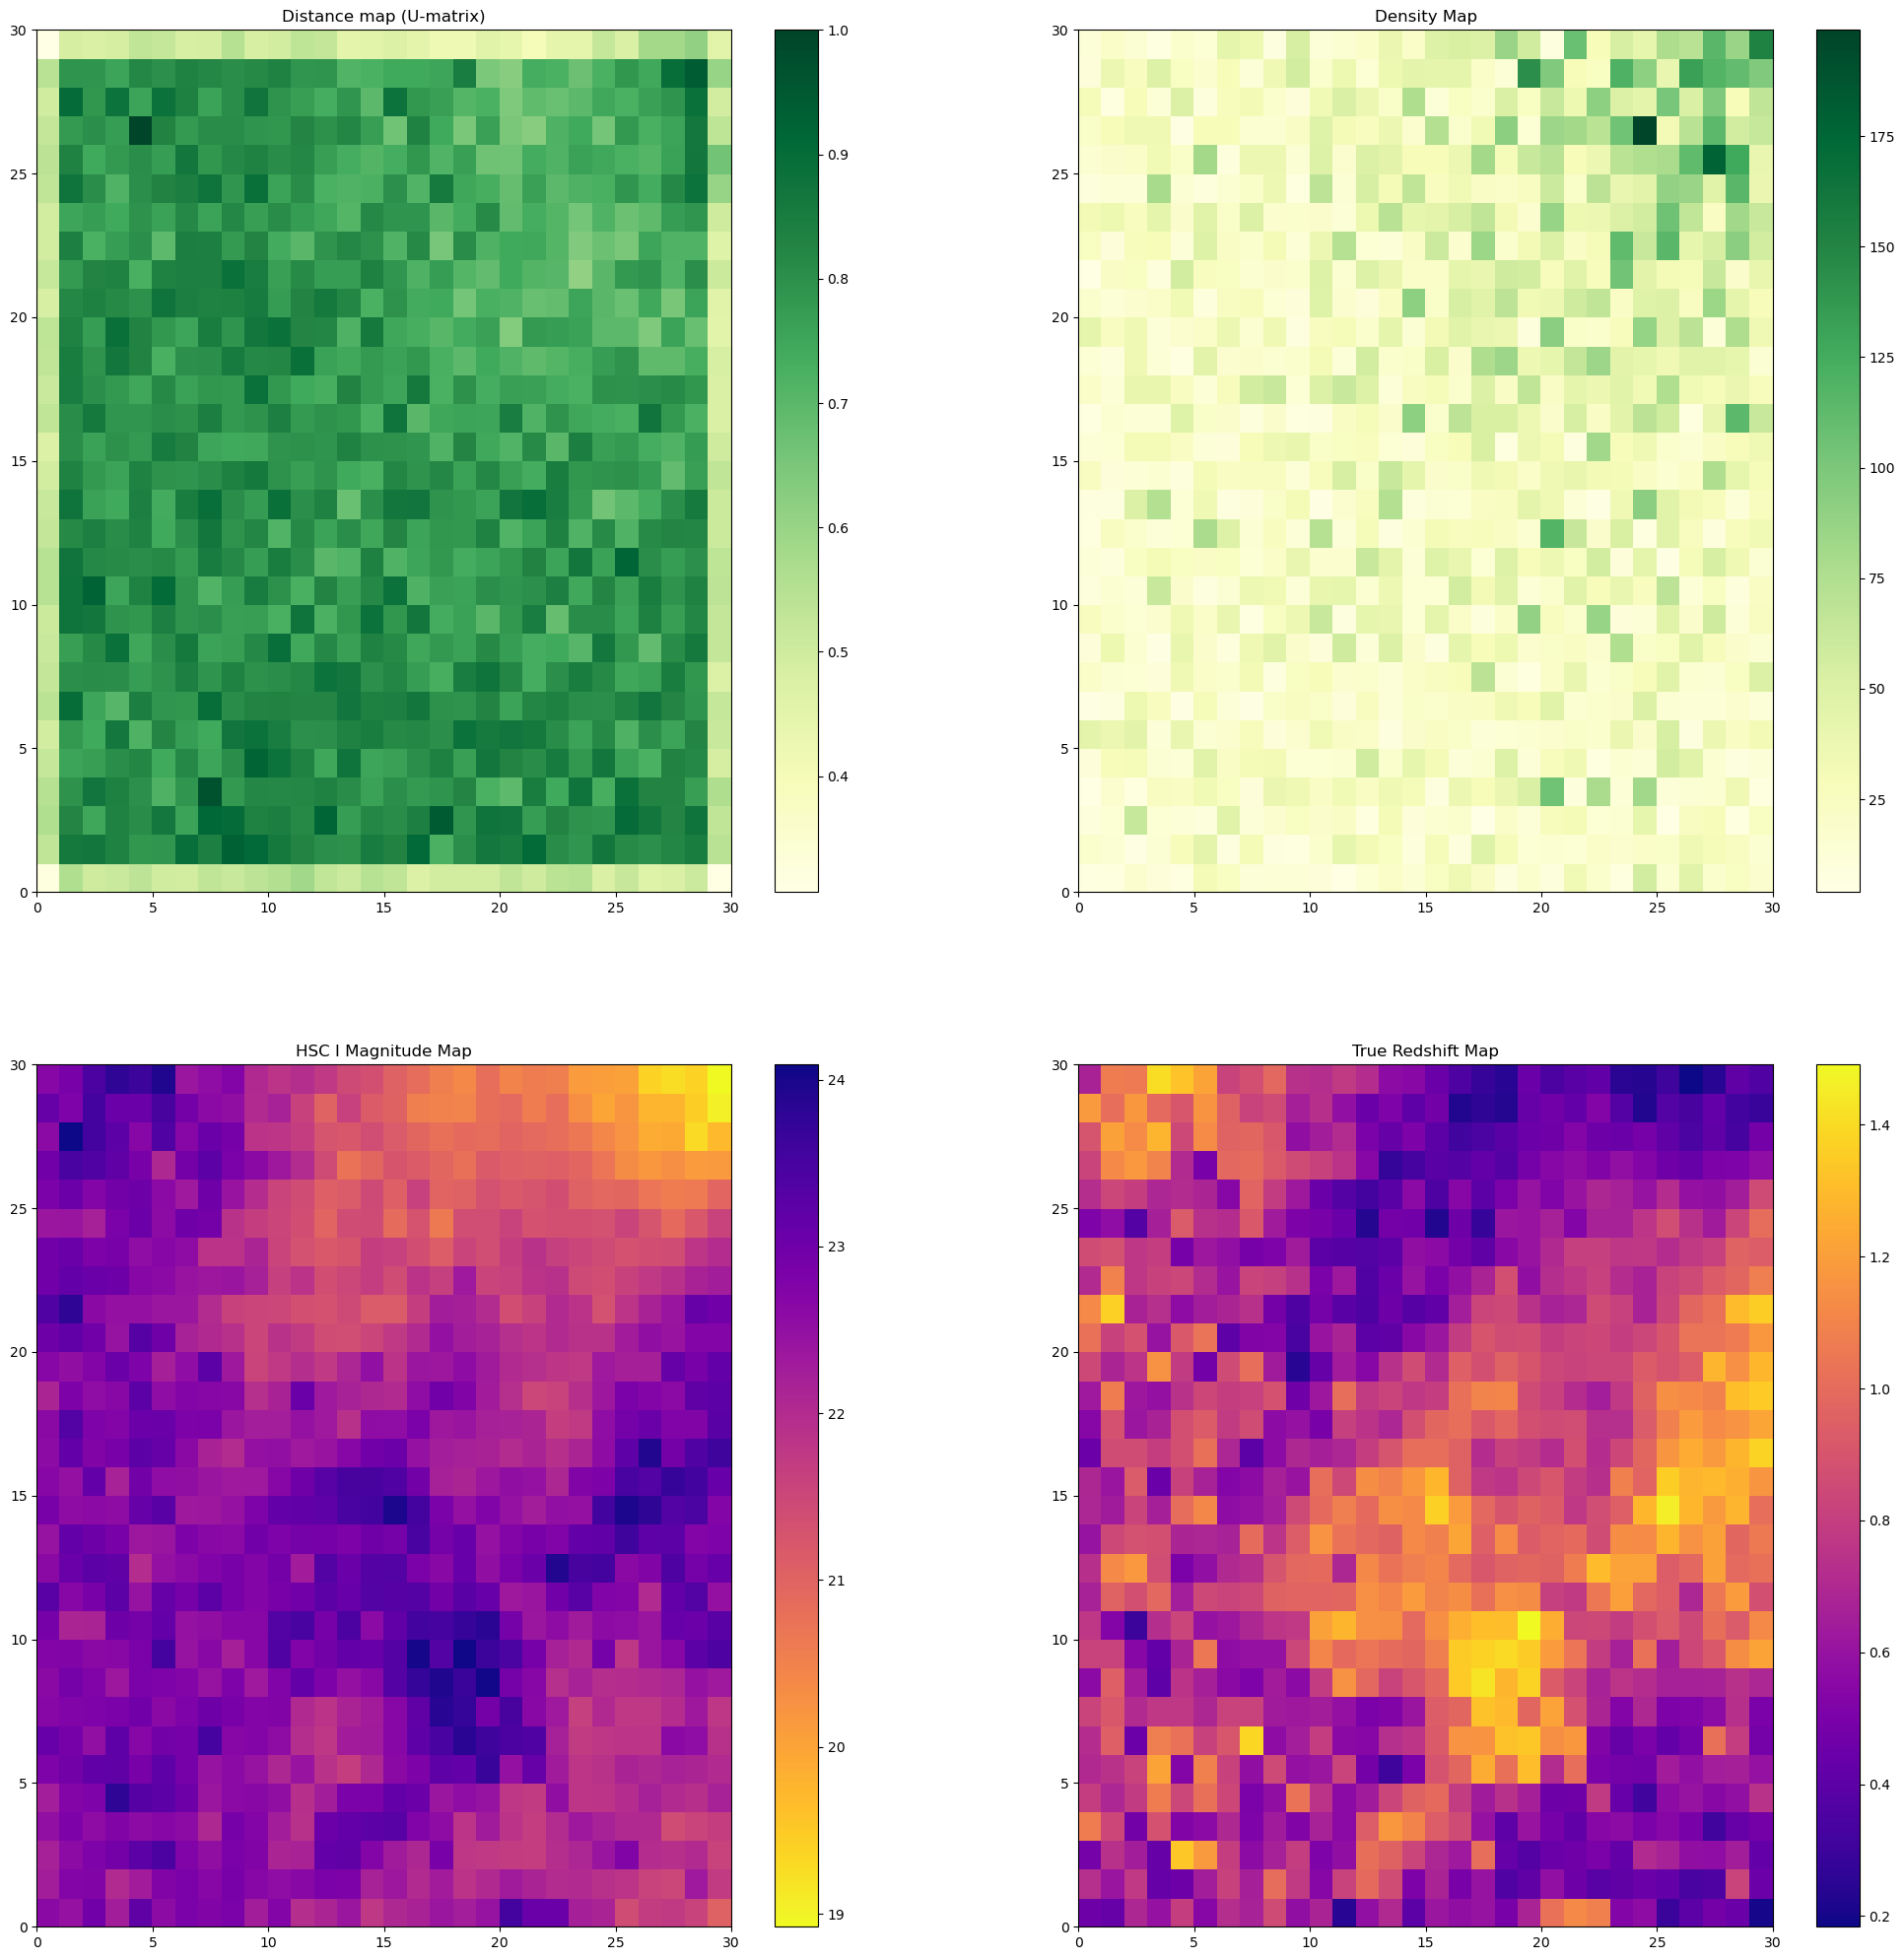

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.8]
29683.0
Topological error: 0.808442542869656
Quantization error: 6.312317712082978
Average redshift std: 0.35397057092777173


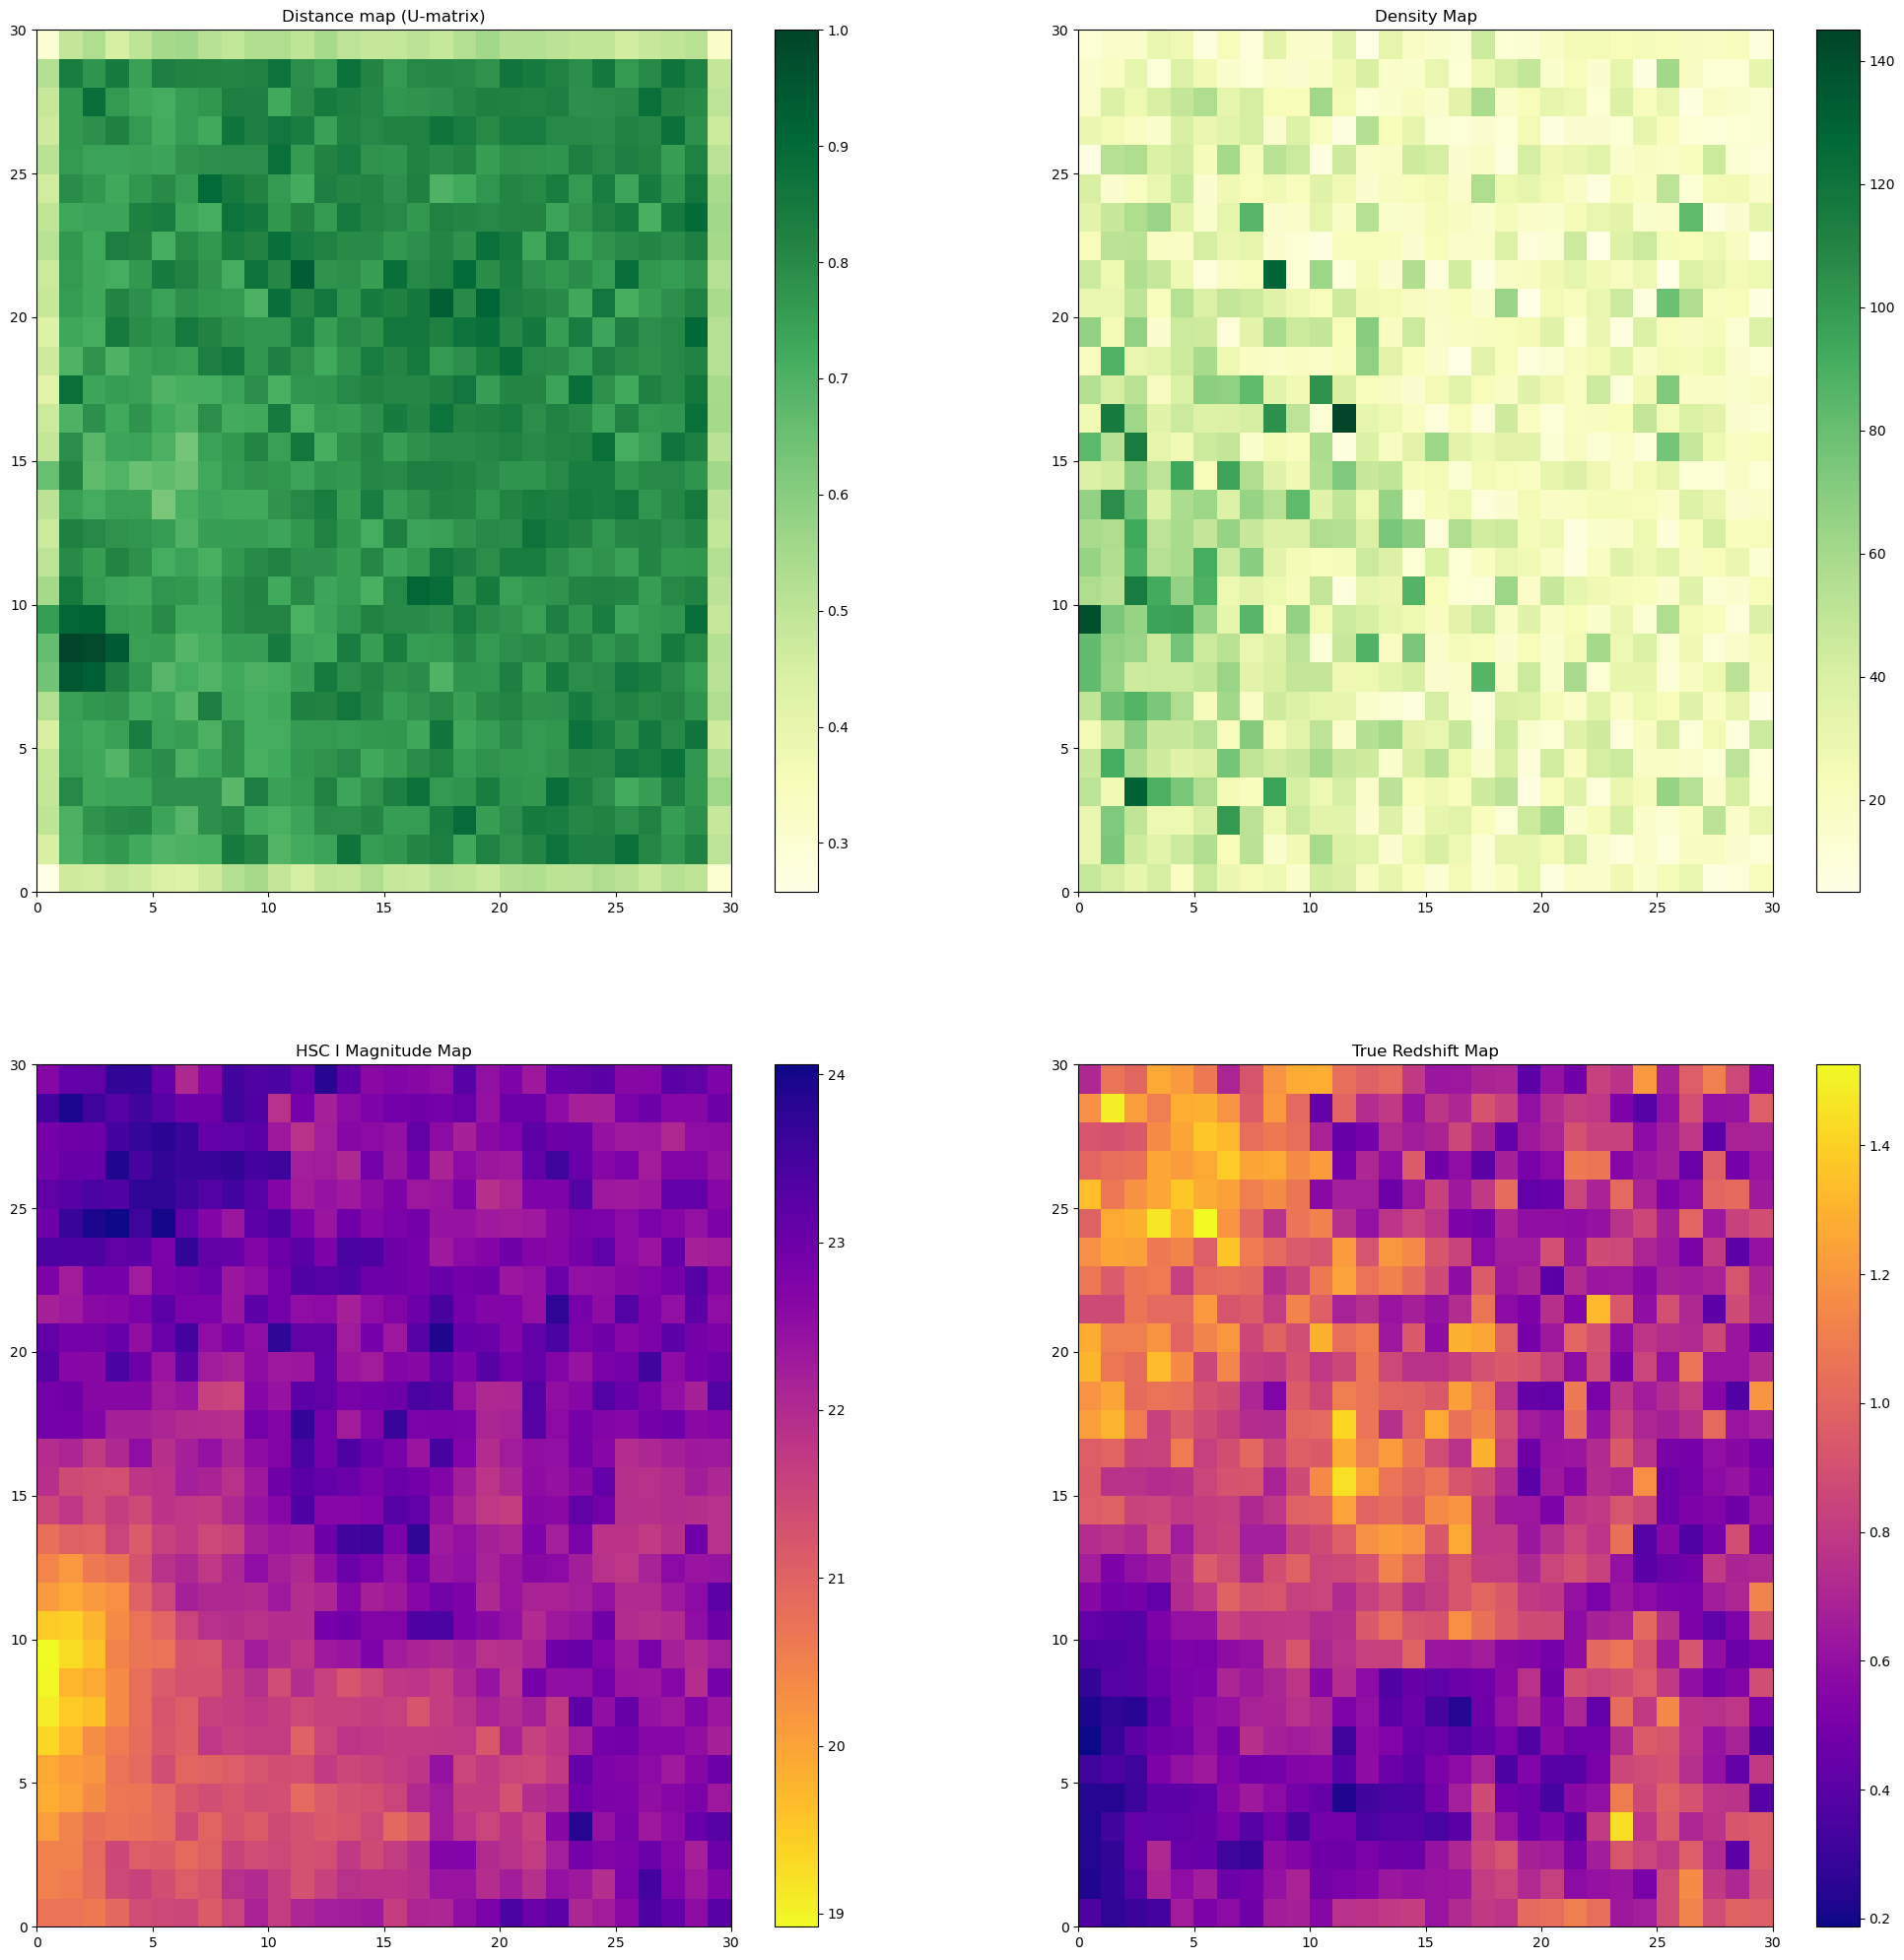

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.8]
29683.0
Topological error: 0.8691843816325843
Quantization error: 6.361972051814983
Average redshift std: 0.3606563230828214


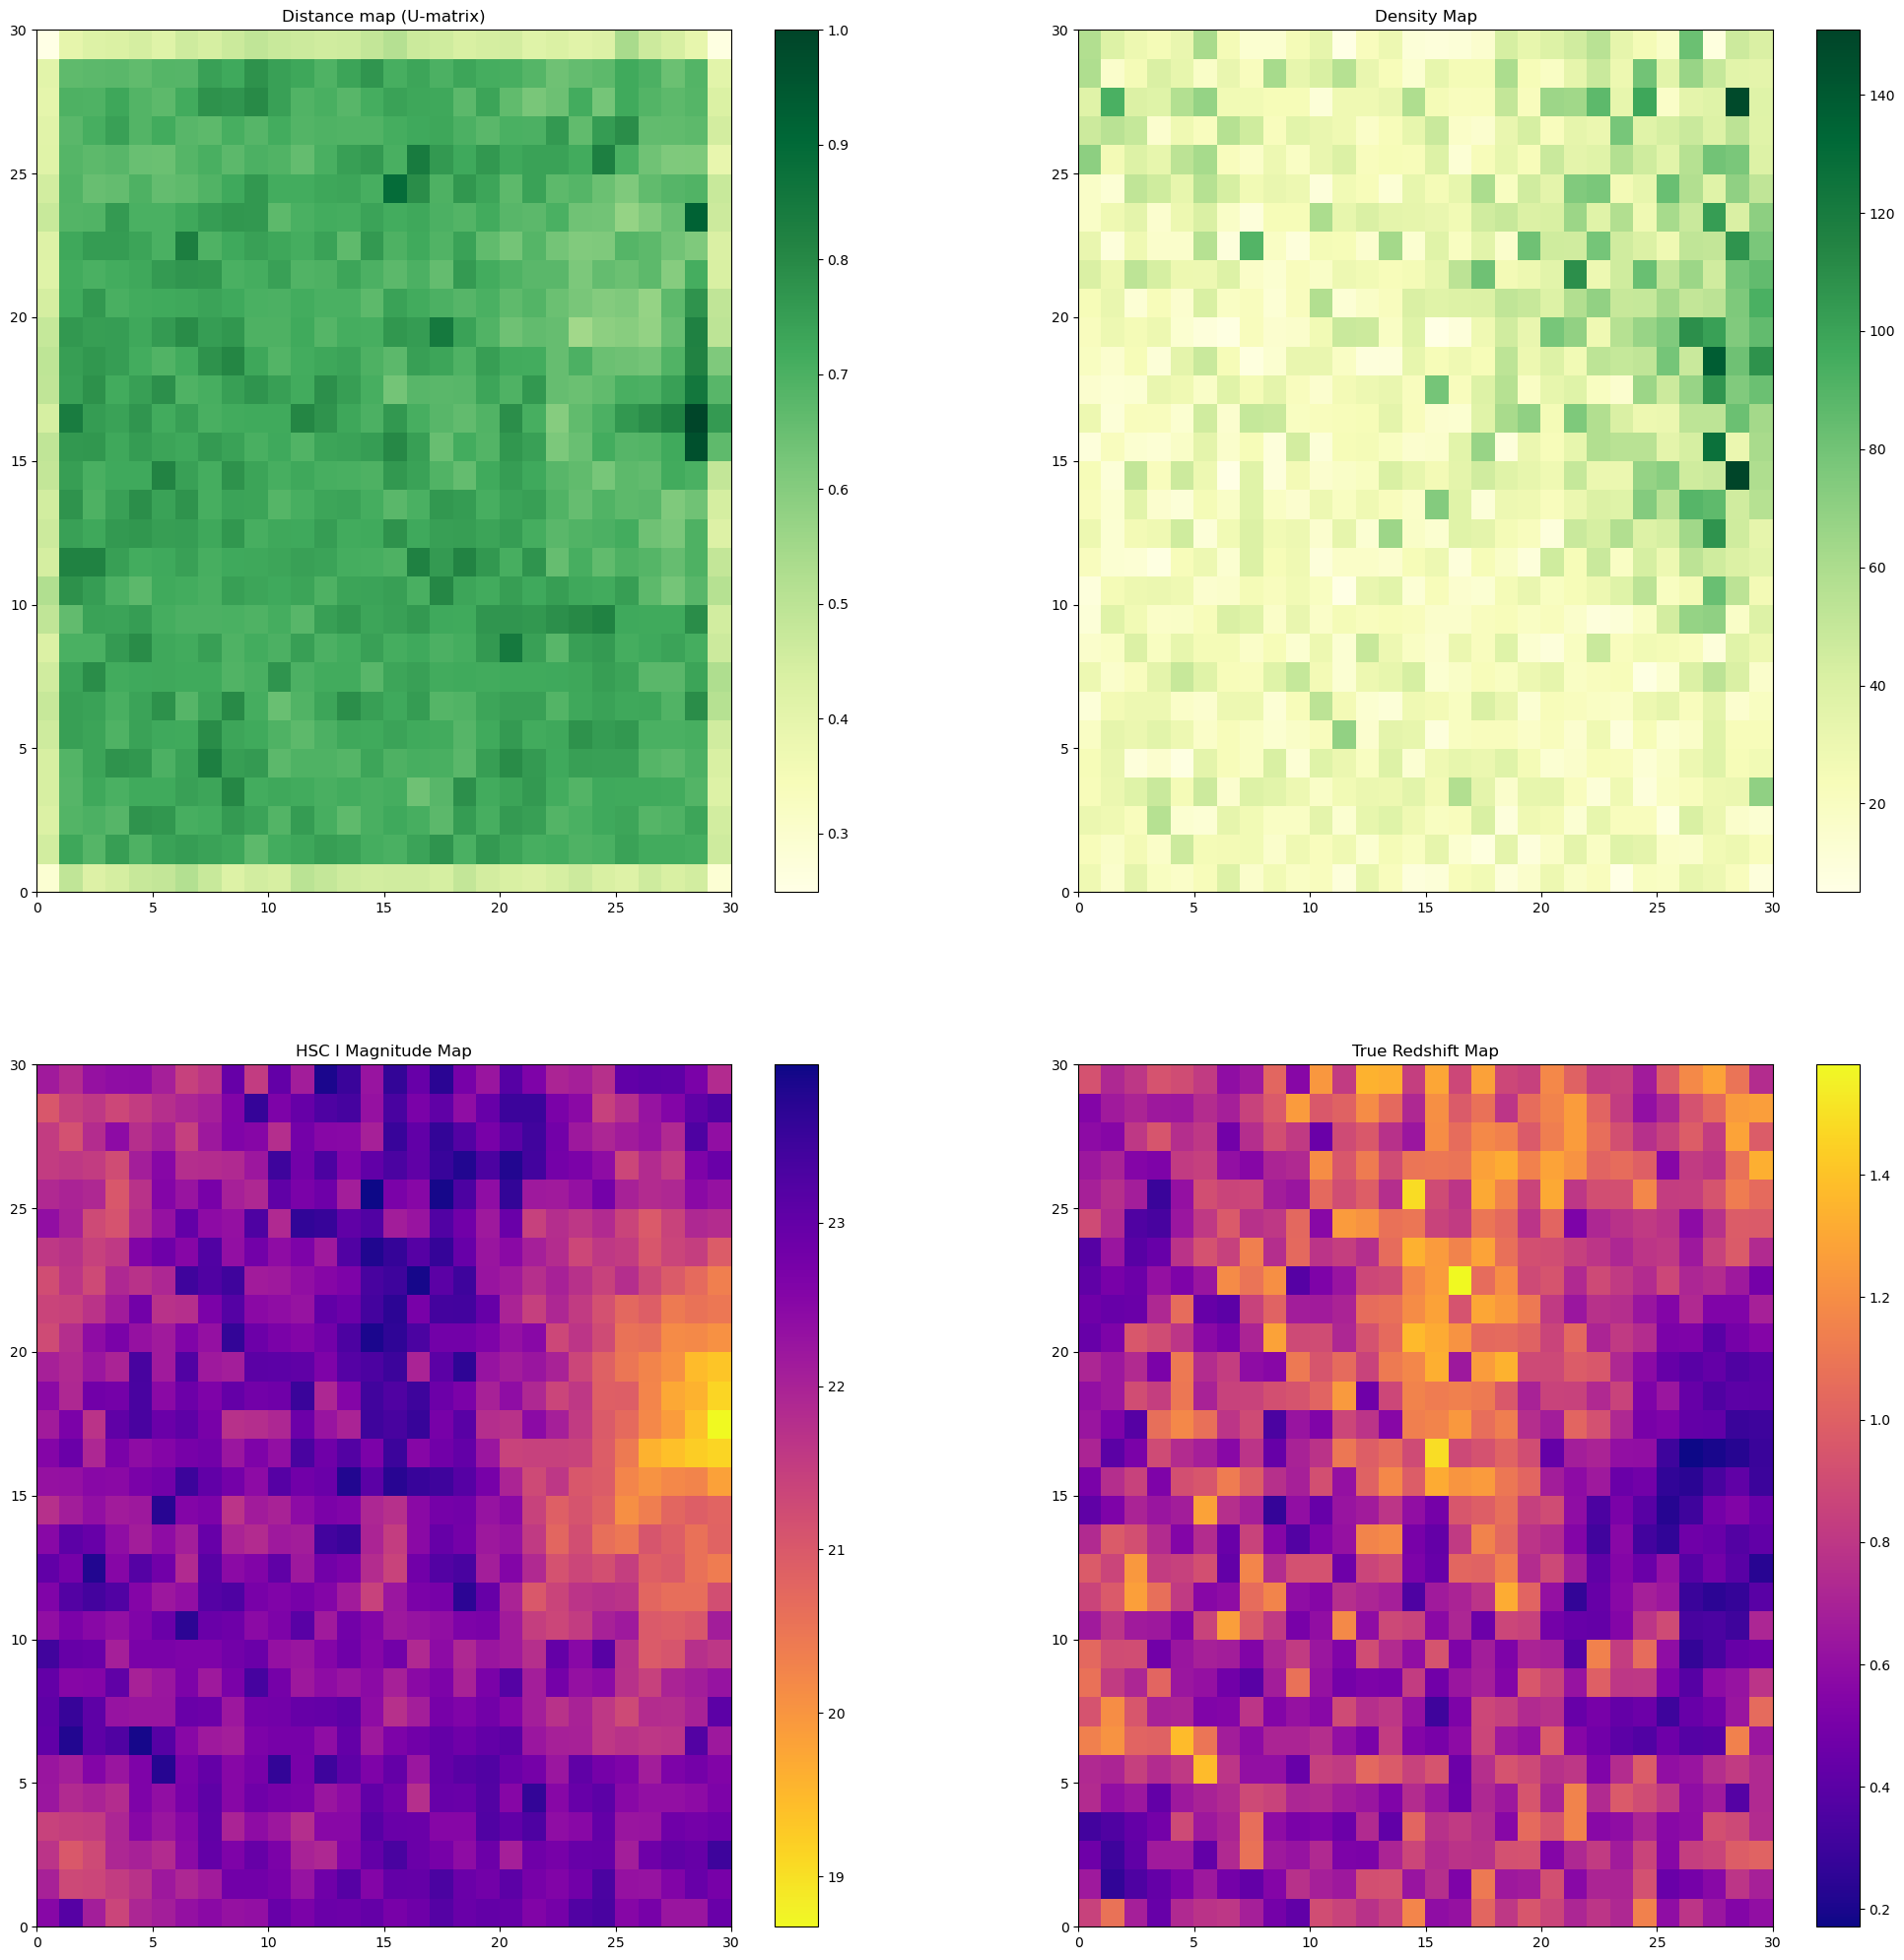

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.8]
29683.0
Topological error: 0.9052993295825894
Quantization error: 6.416463765131368
Average redshift std: 0.36927550473209975


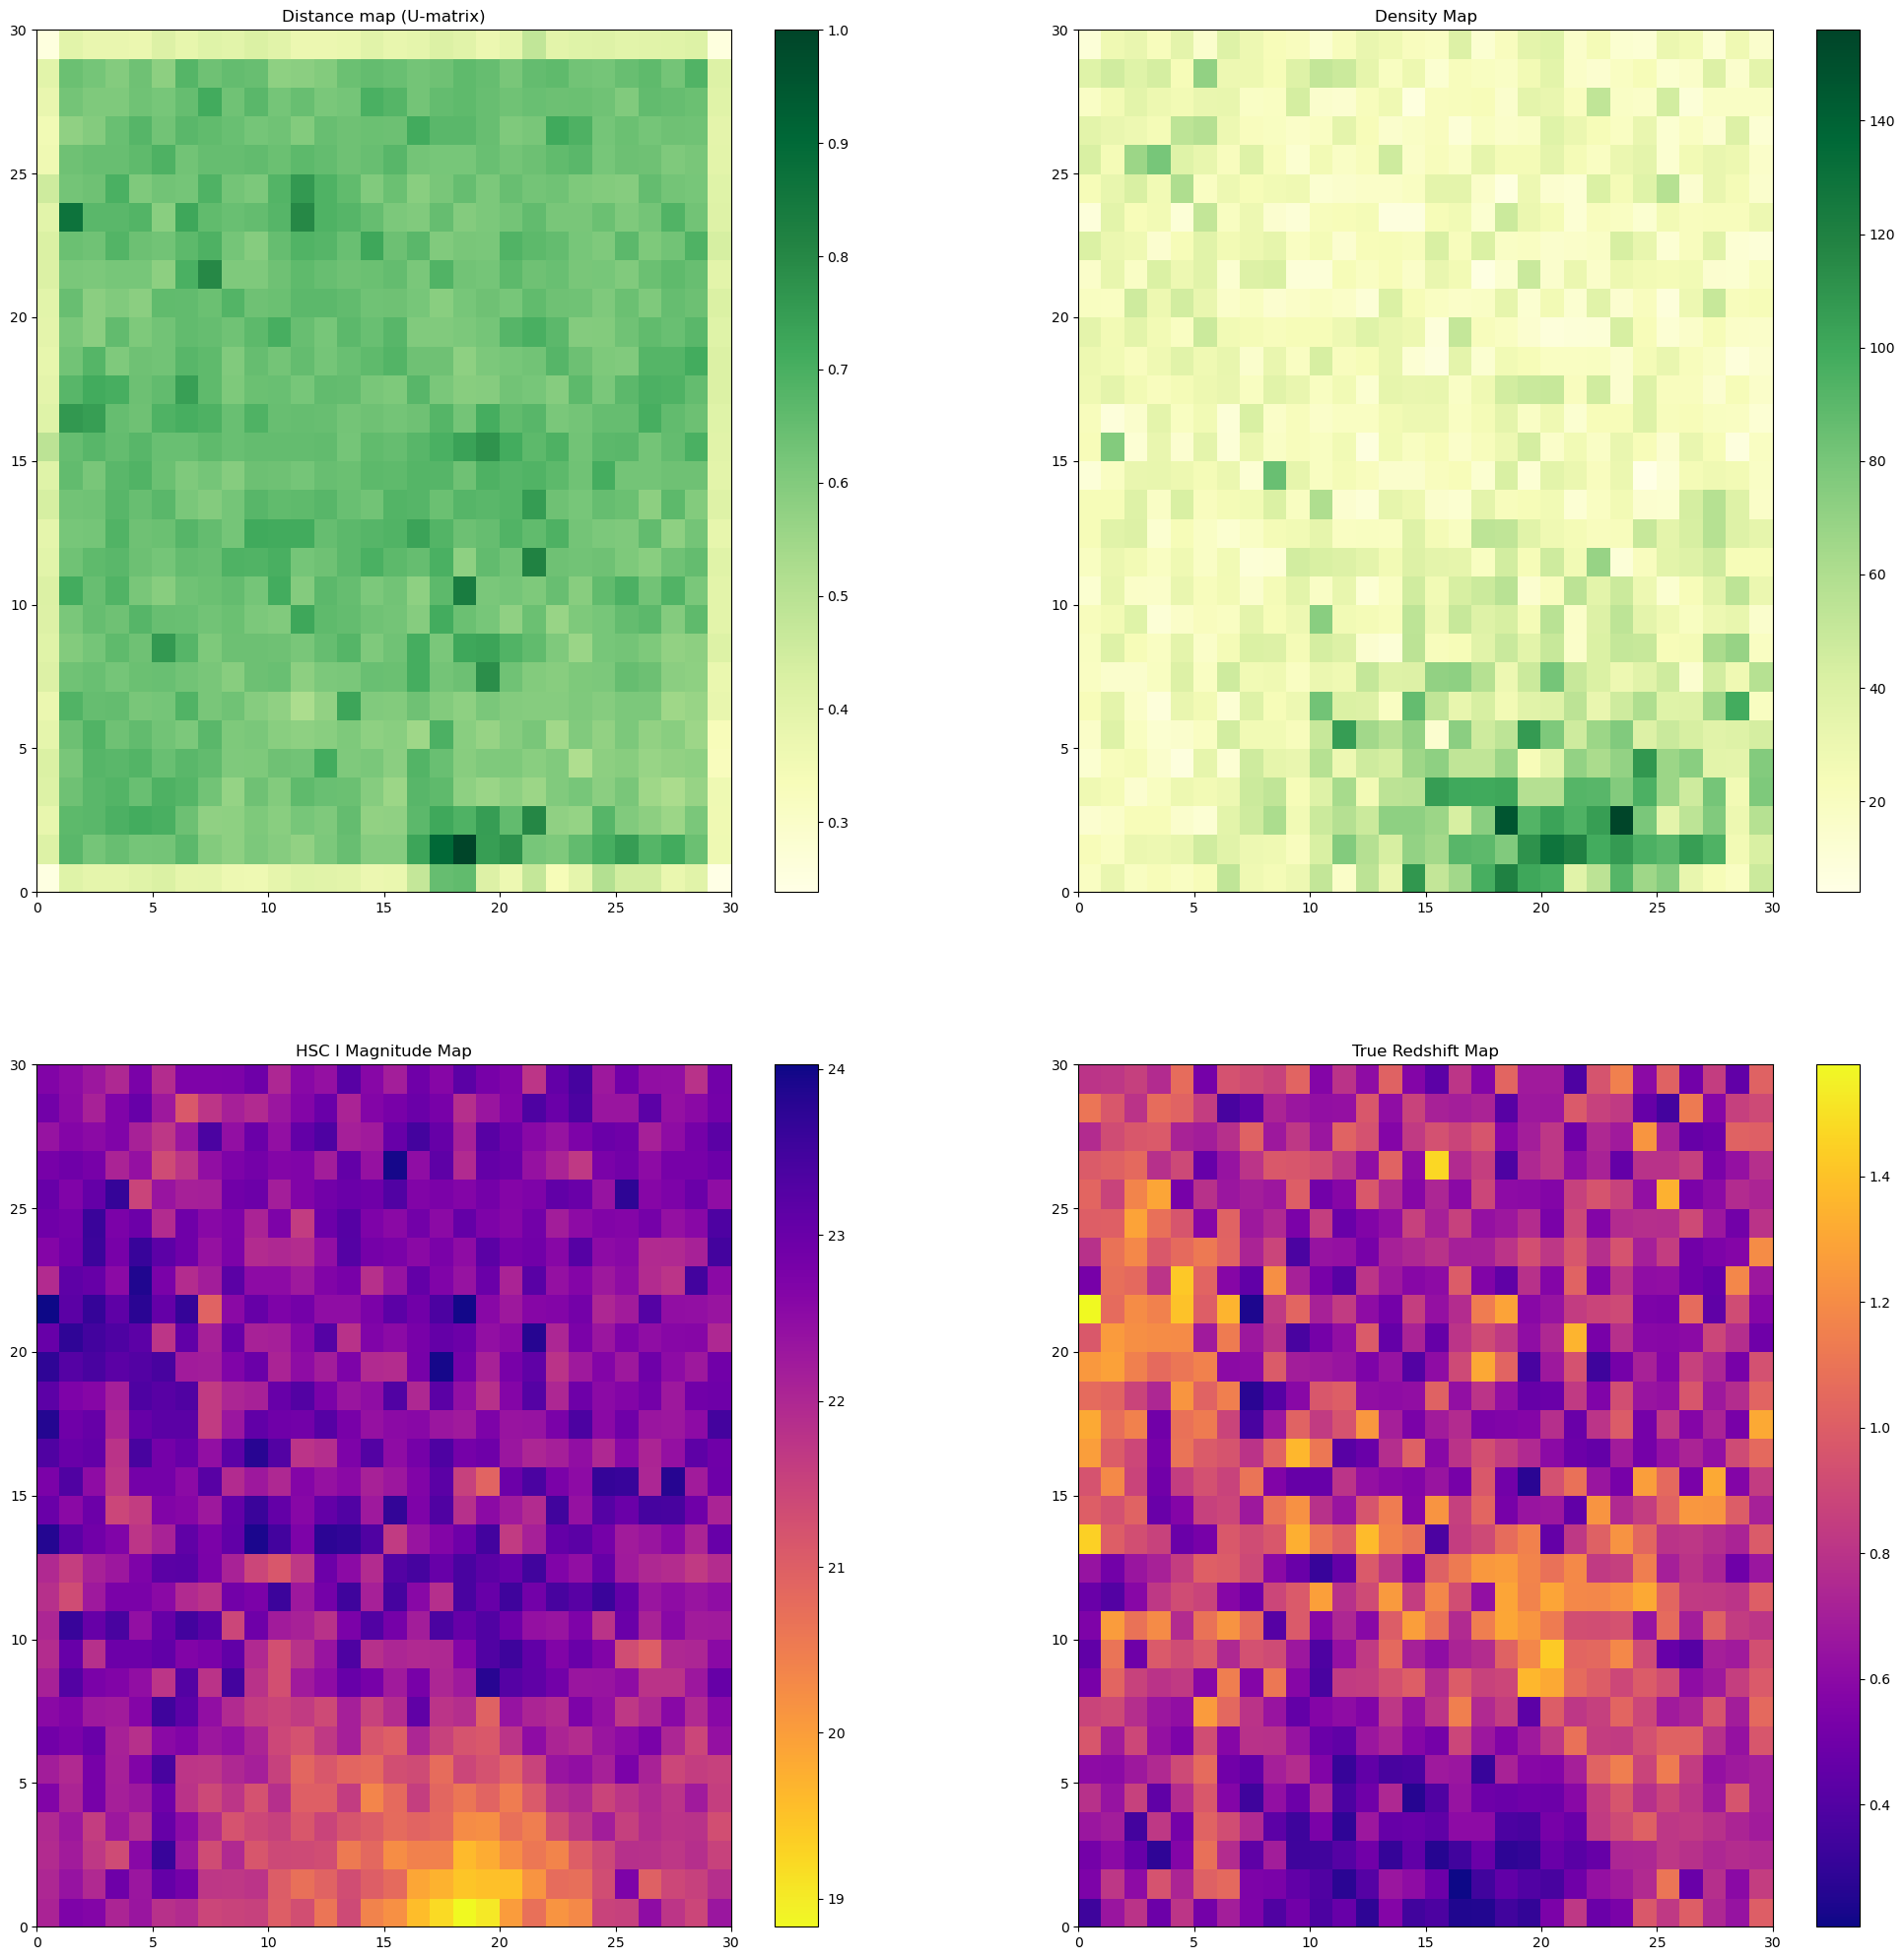

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 0.8]
29683.0
Topological error: 0.9382474817235454
Quantization error: 6.449696414958886
Average redshift std: 0.3611571240089728


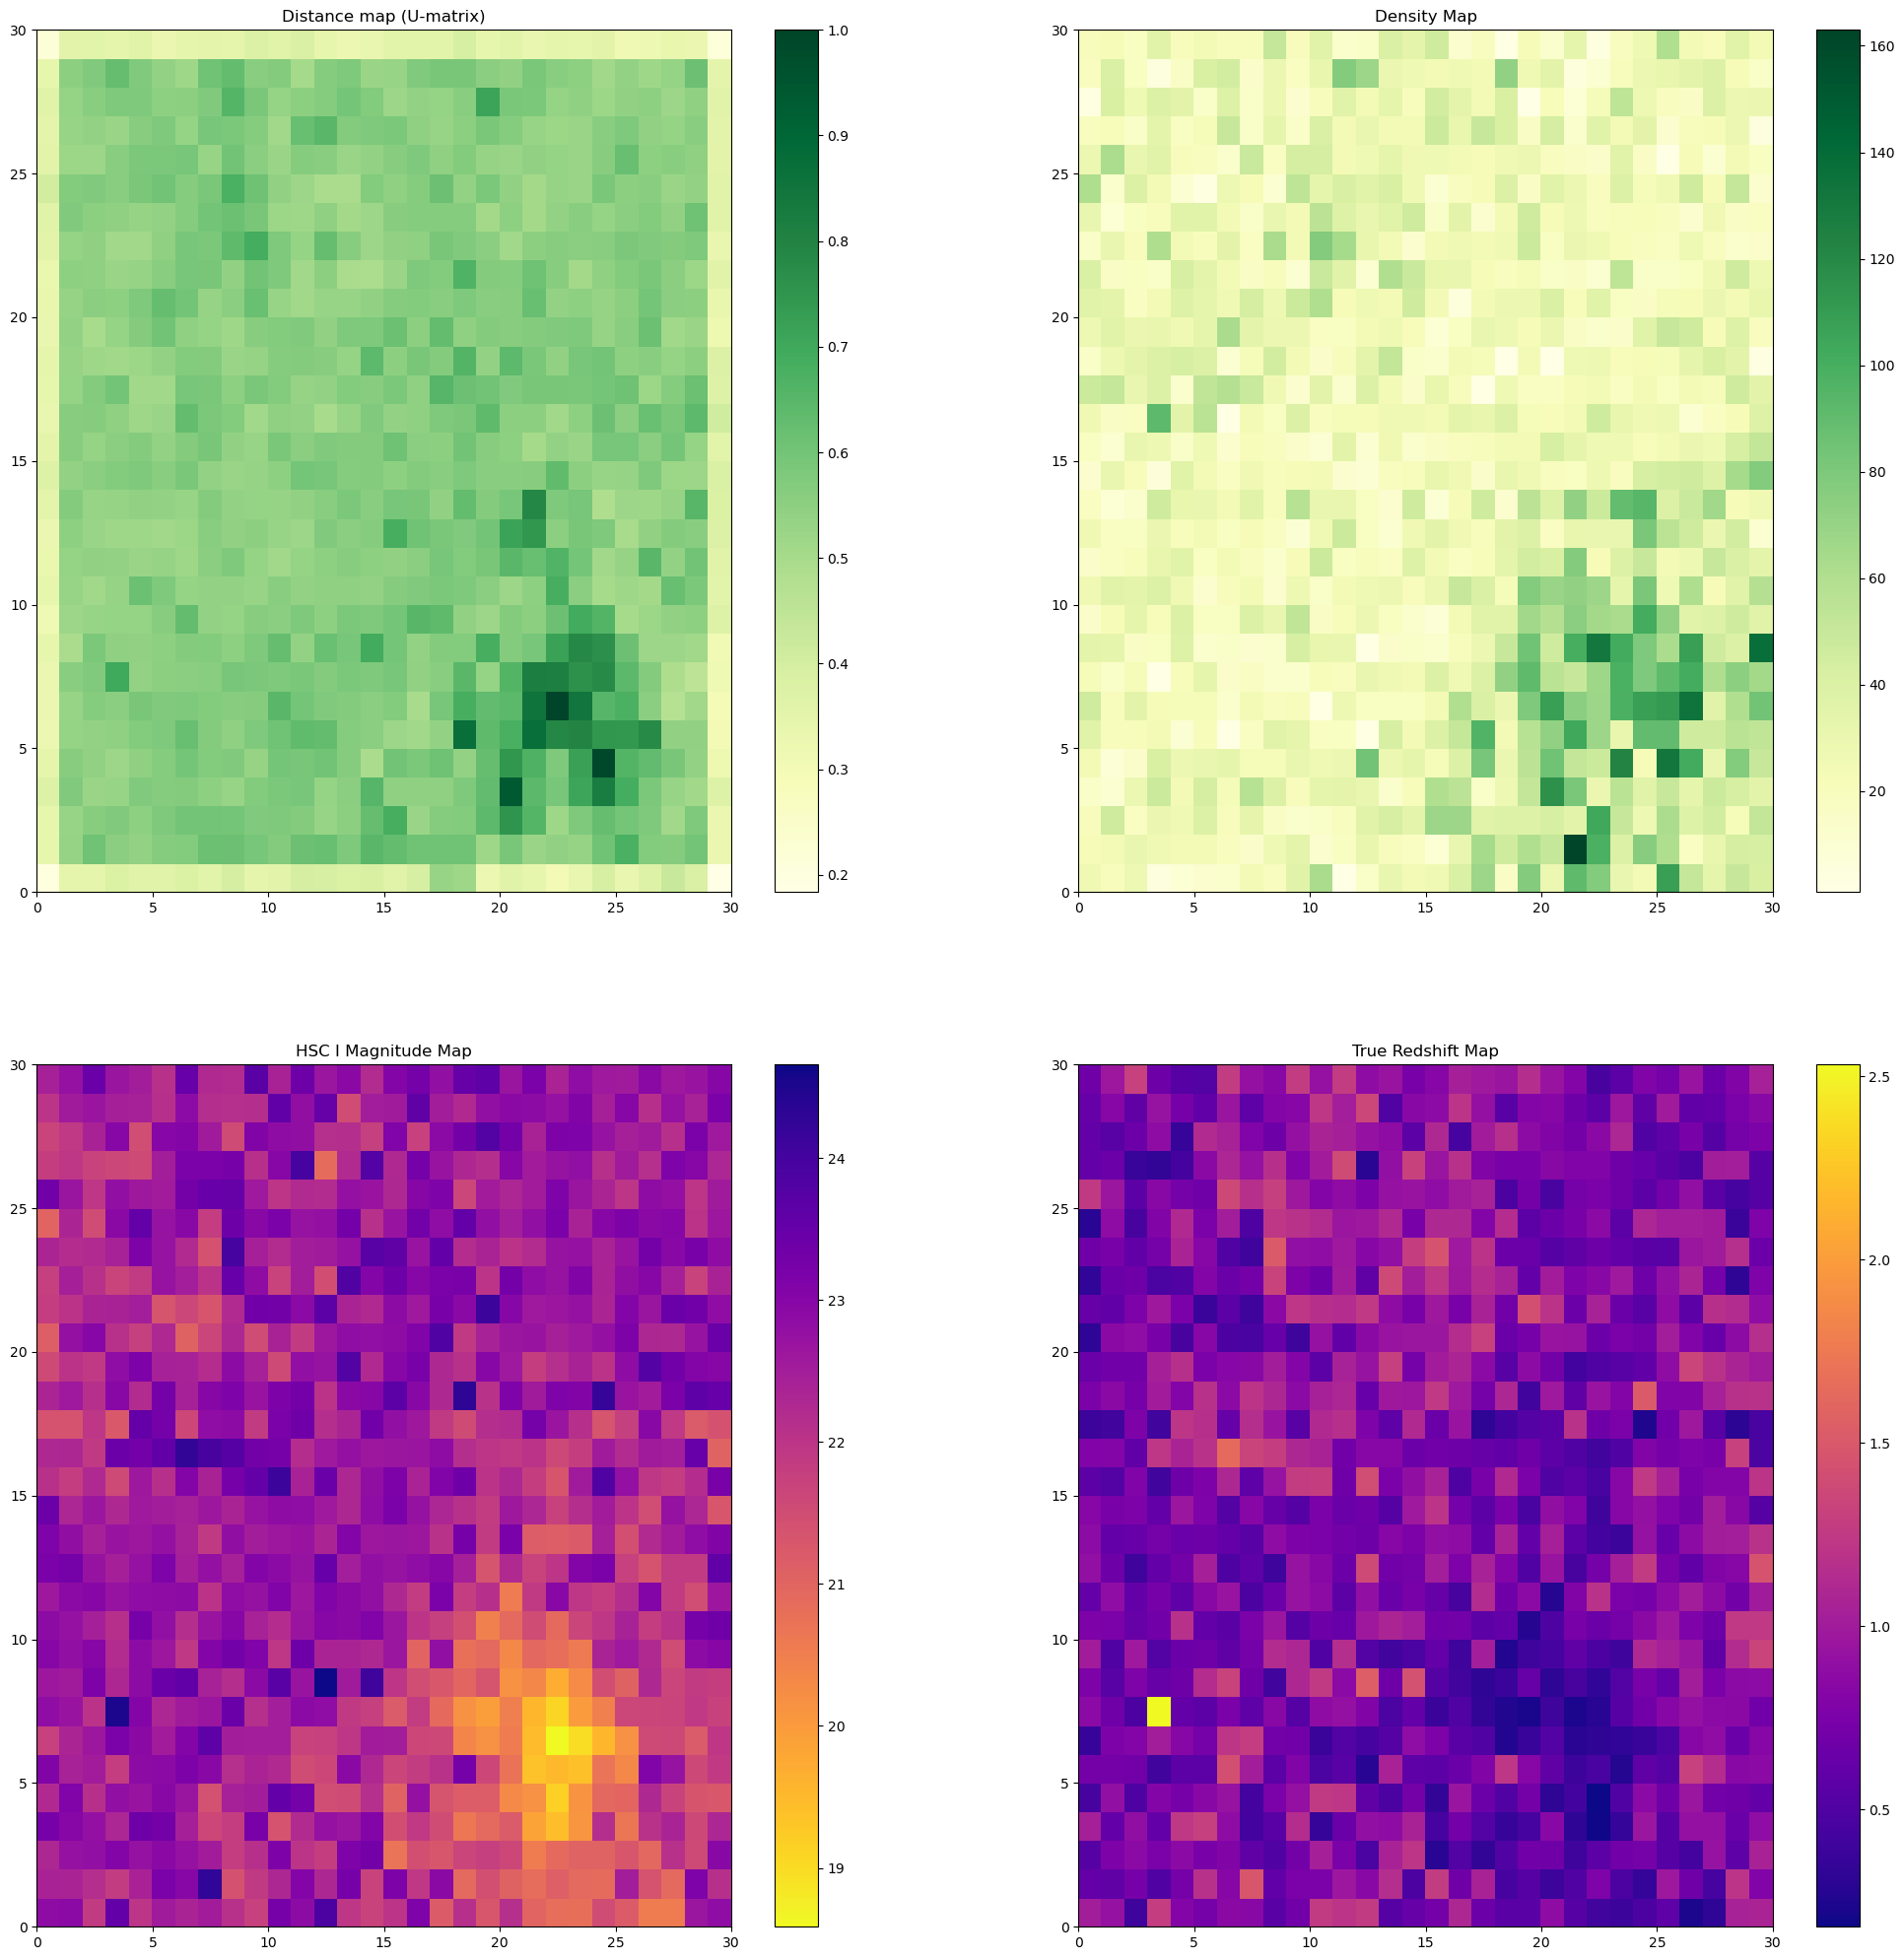

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.8]
29683.0
Topological error: 0.9415827241181821
Quantization error: 6.487750443777899
Average redshift std: 0.36600872108801696


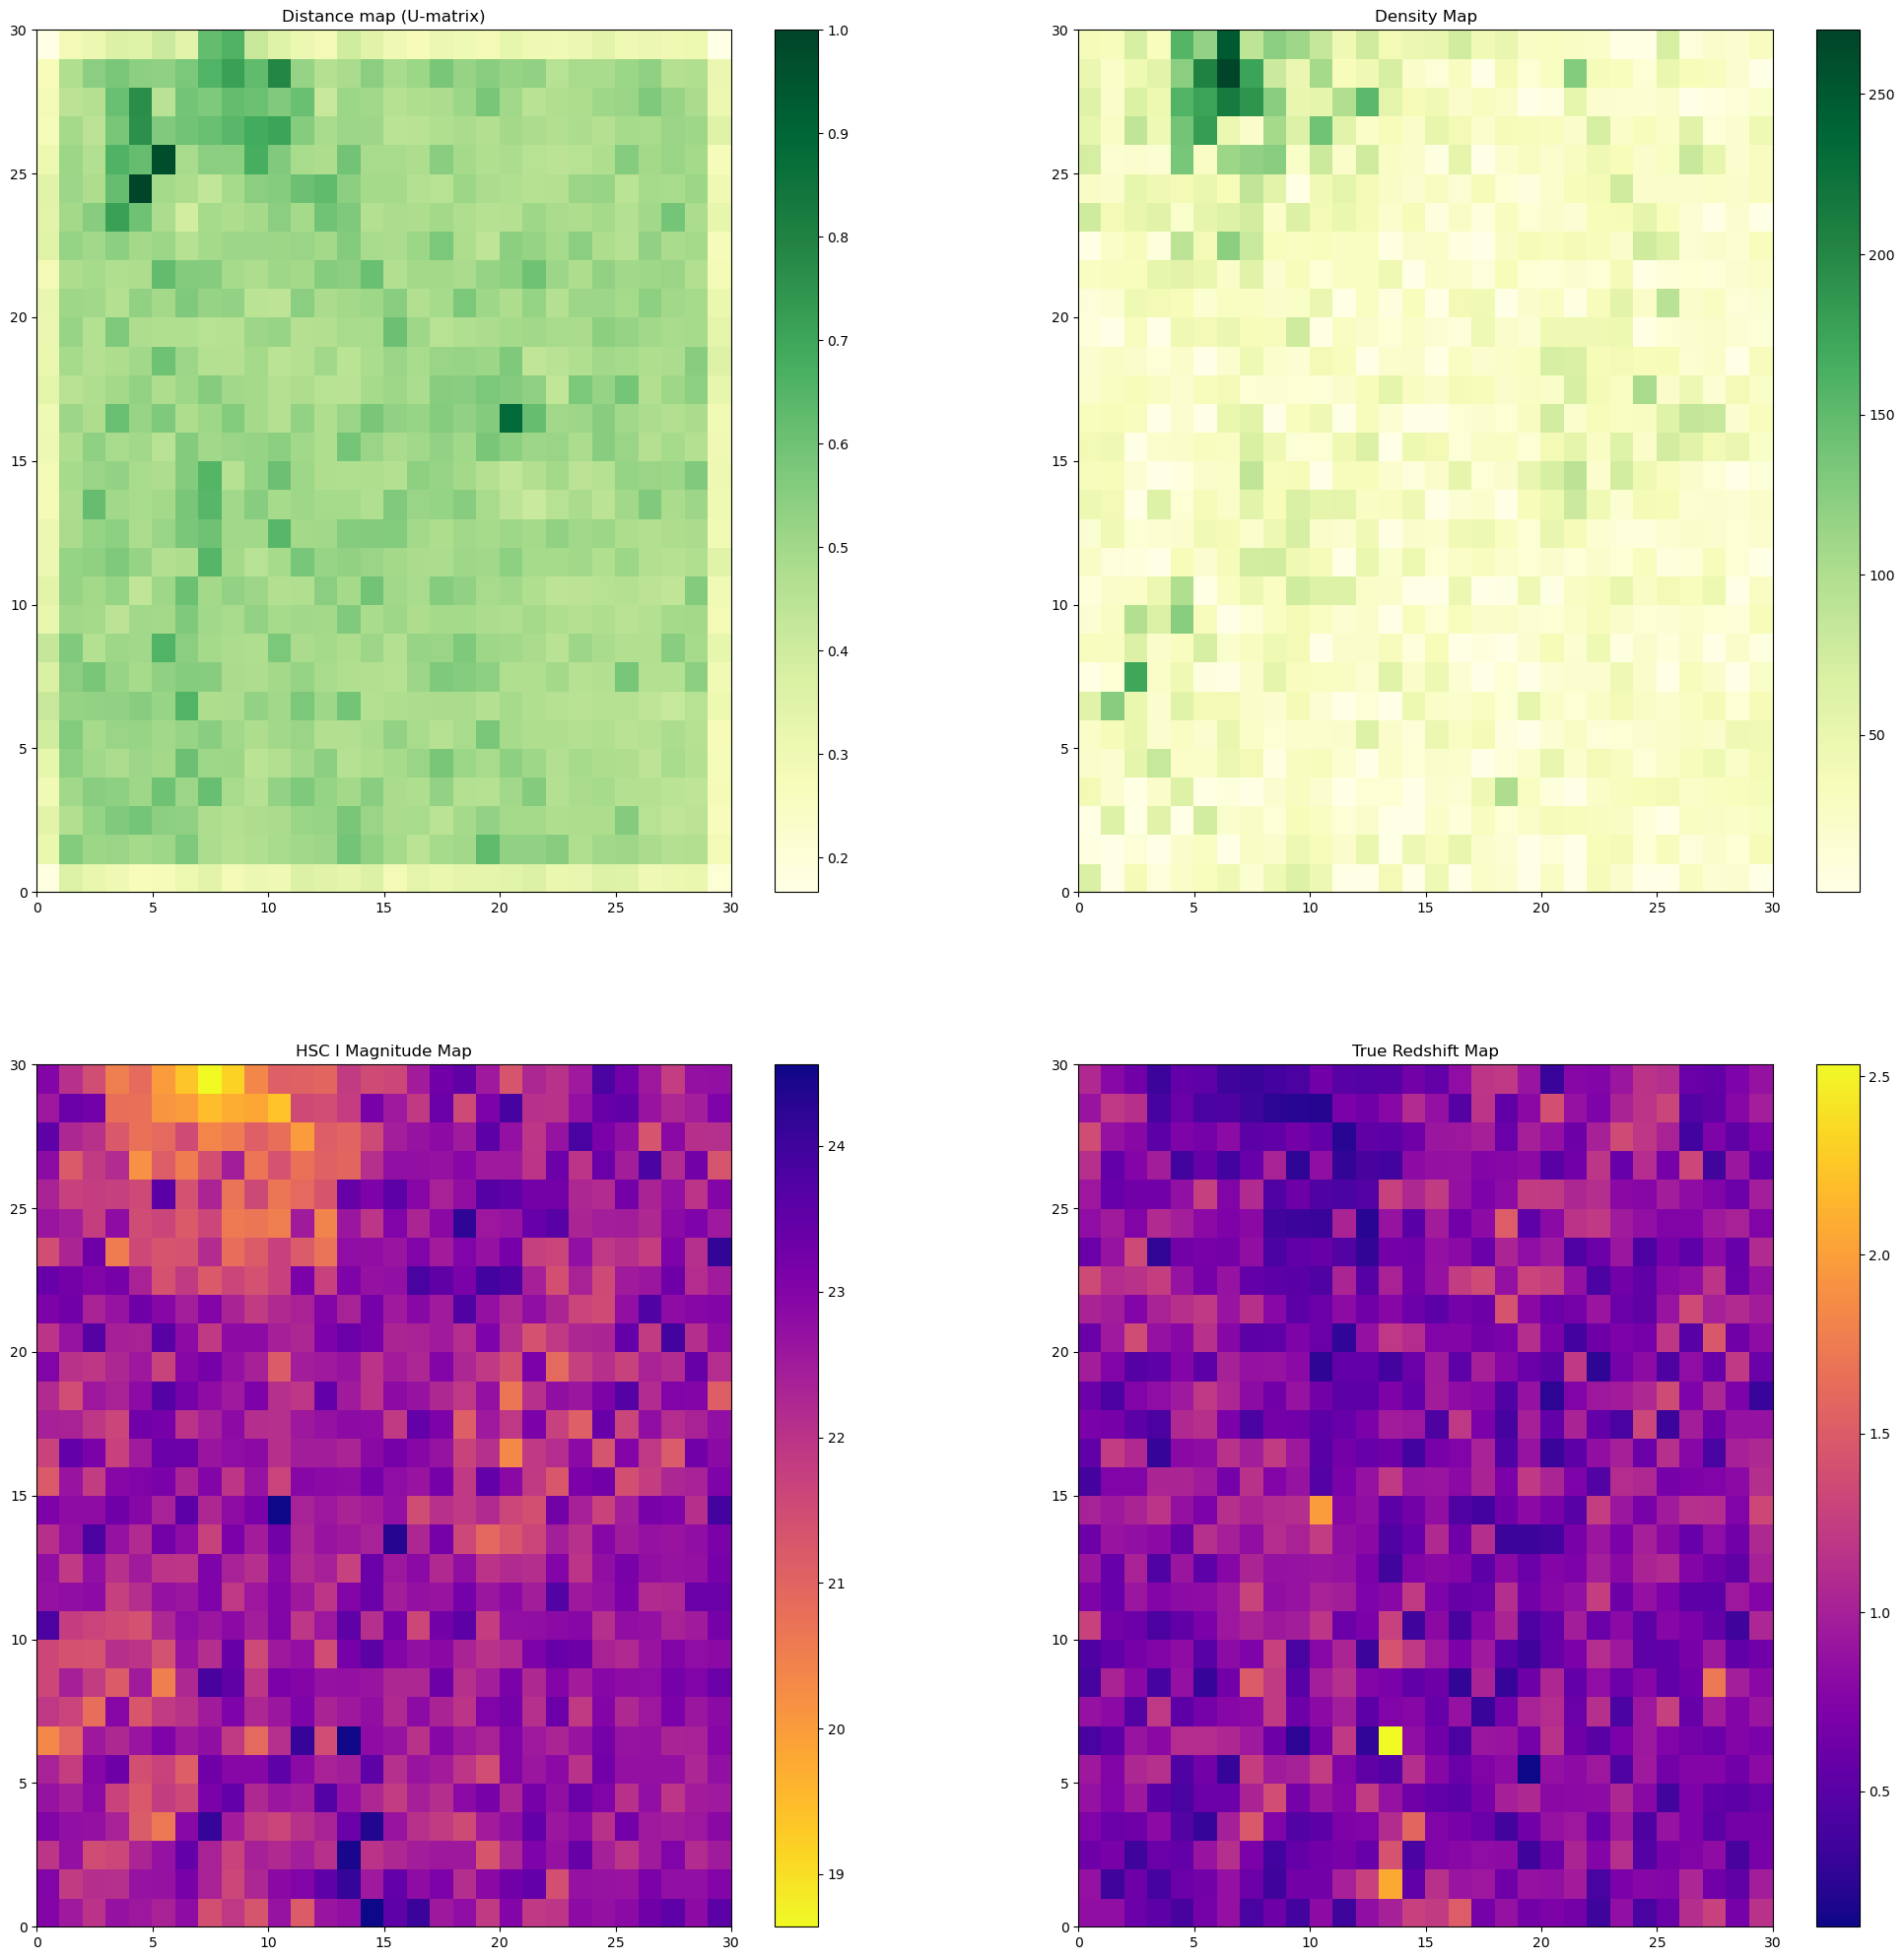

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.8]
29683.0
Topological error: 0.9570798099922515
Quantization error: 6.515429112432776
Average redshift std: 0.3634289490115539


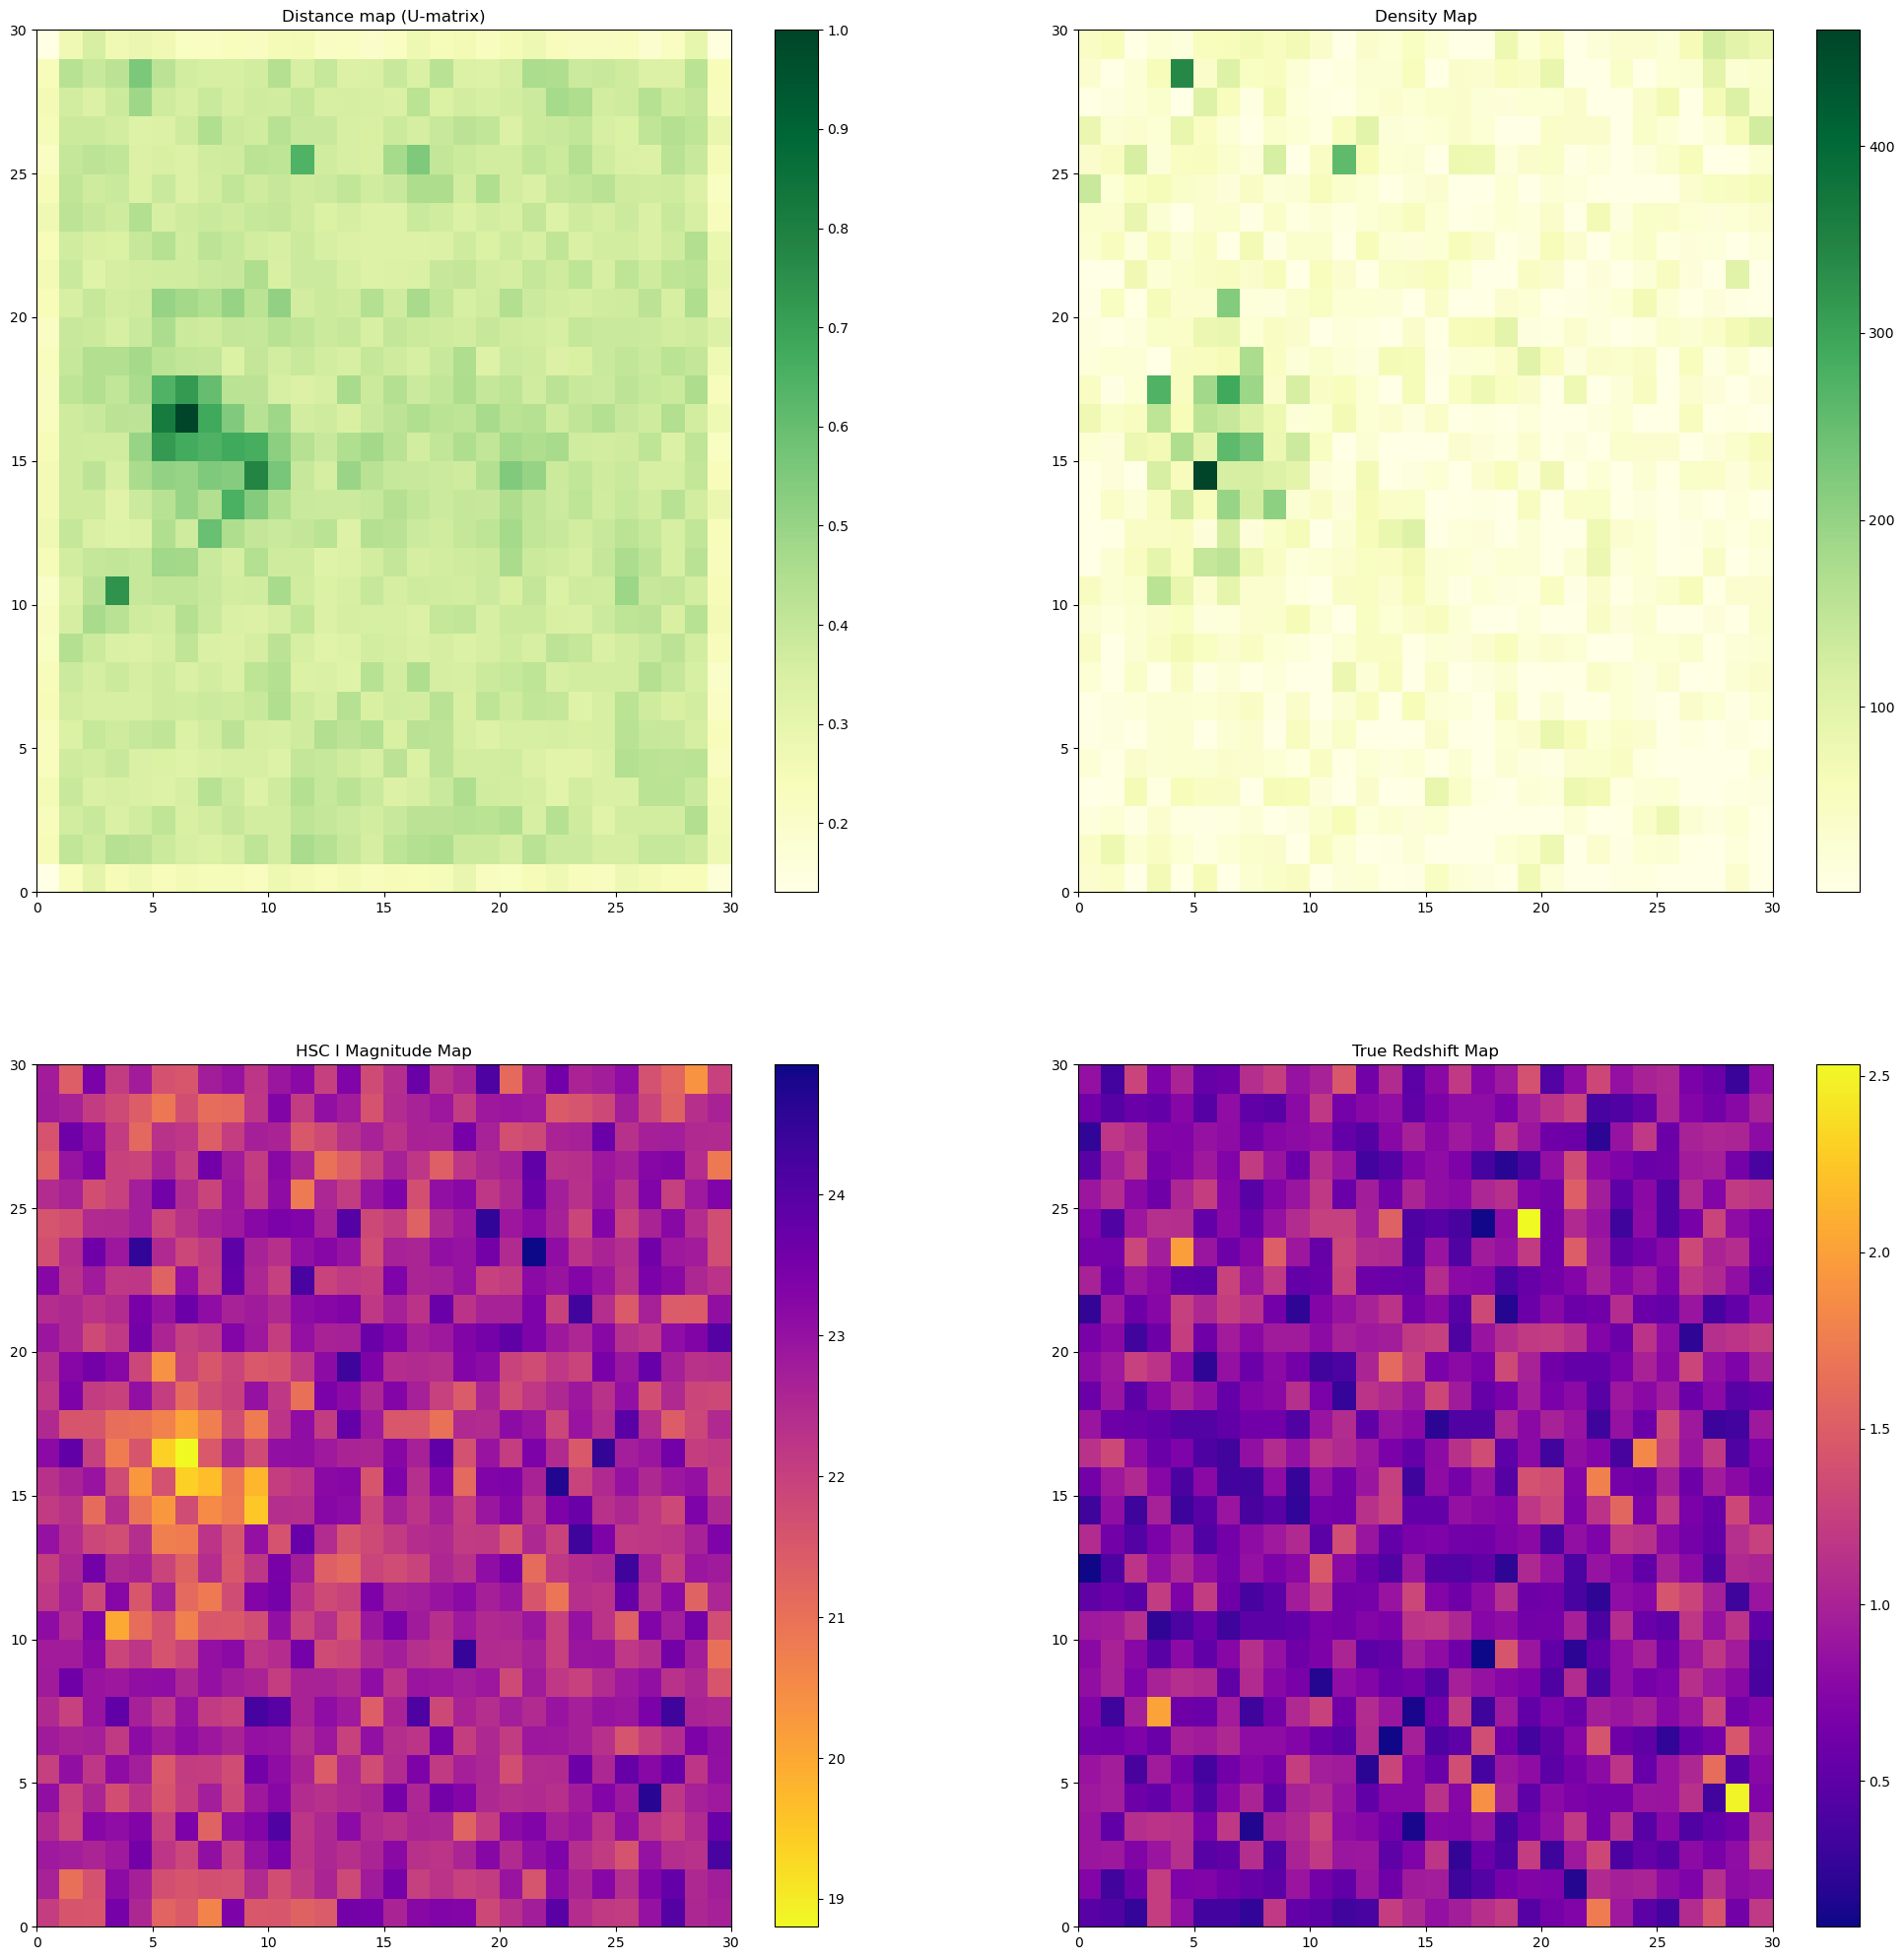

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 0.9]
29683.0
Topological error: 0.7273186672506148
Quantization error: 6.317952393936889
Average redshift std: 0.35405550277659725


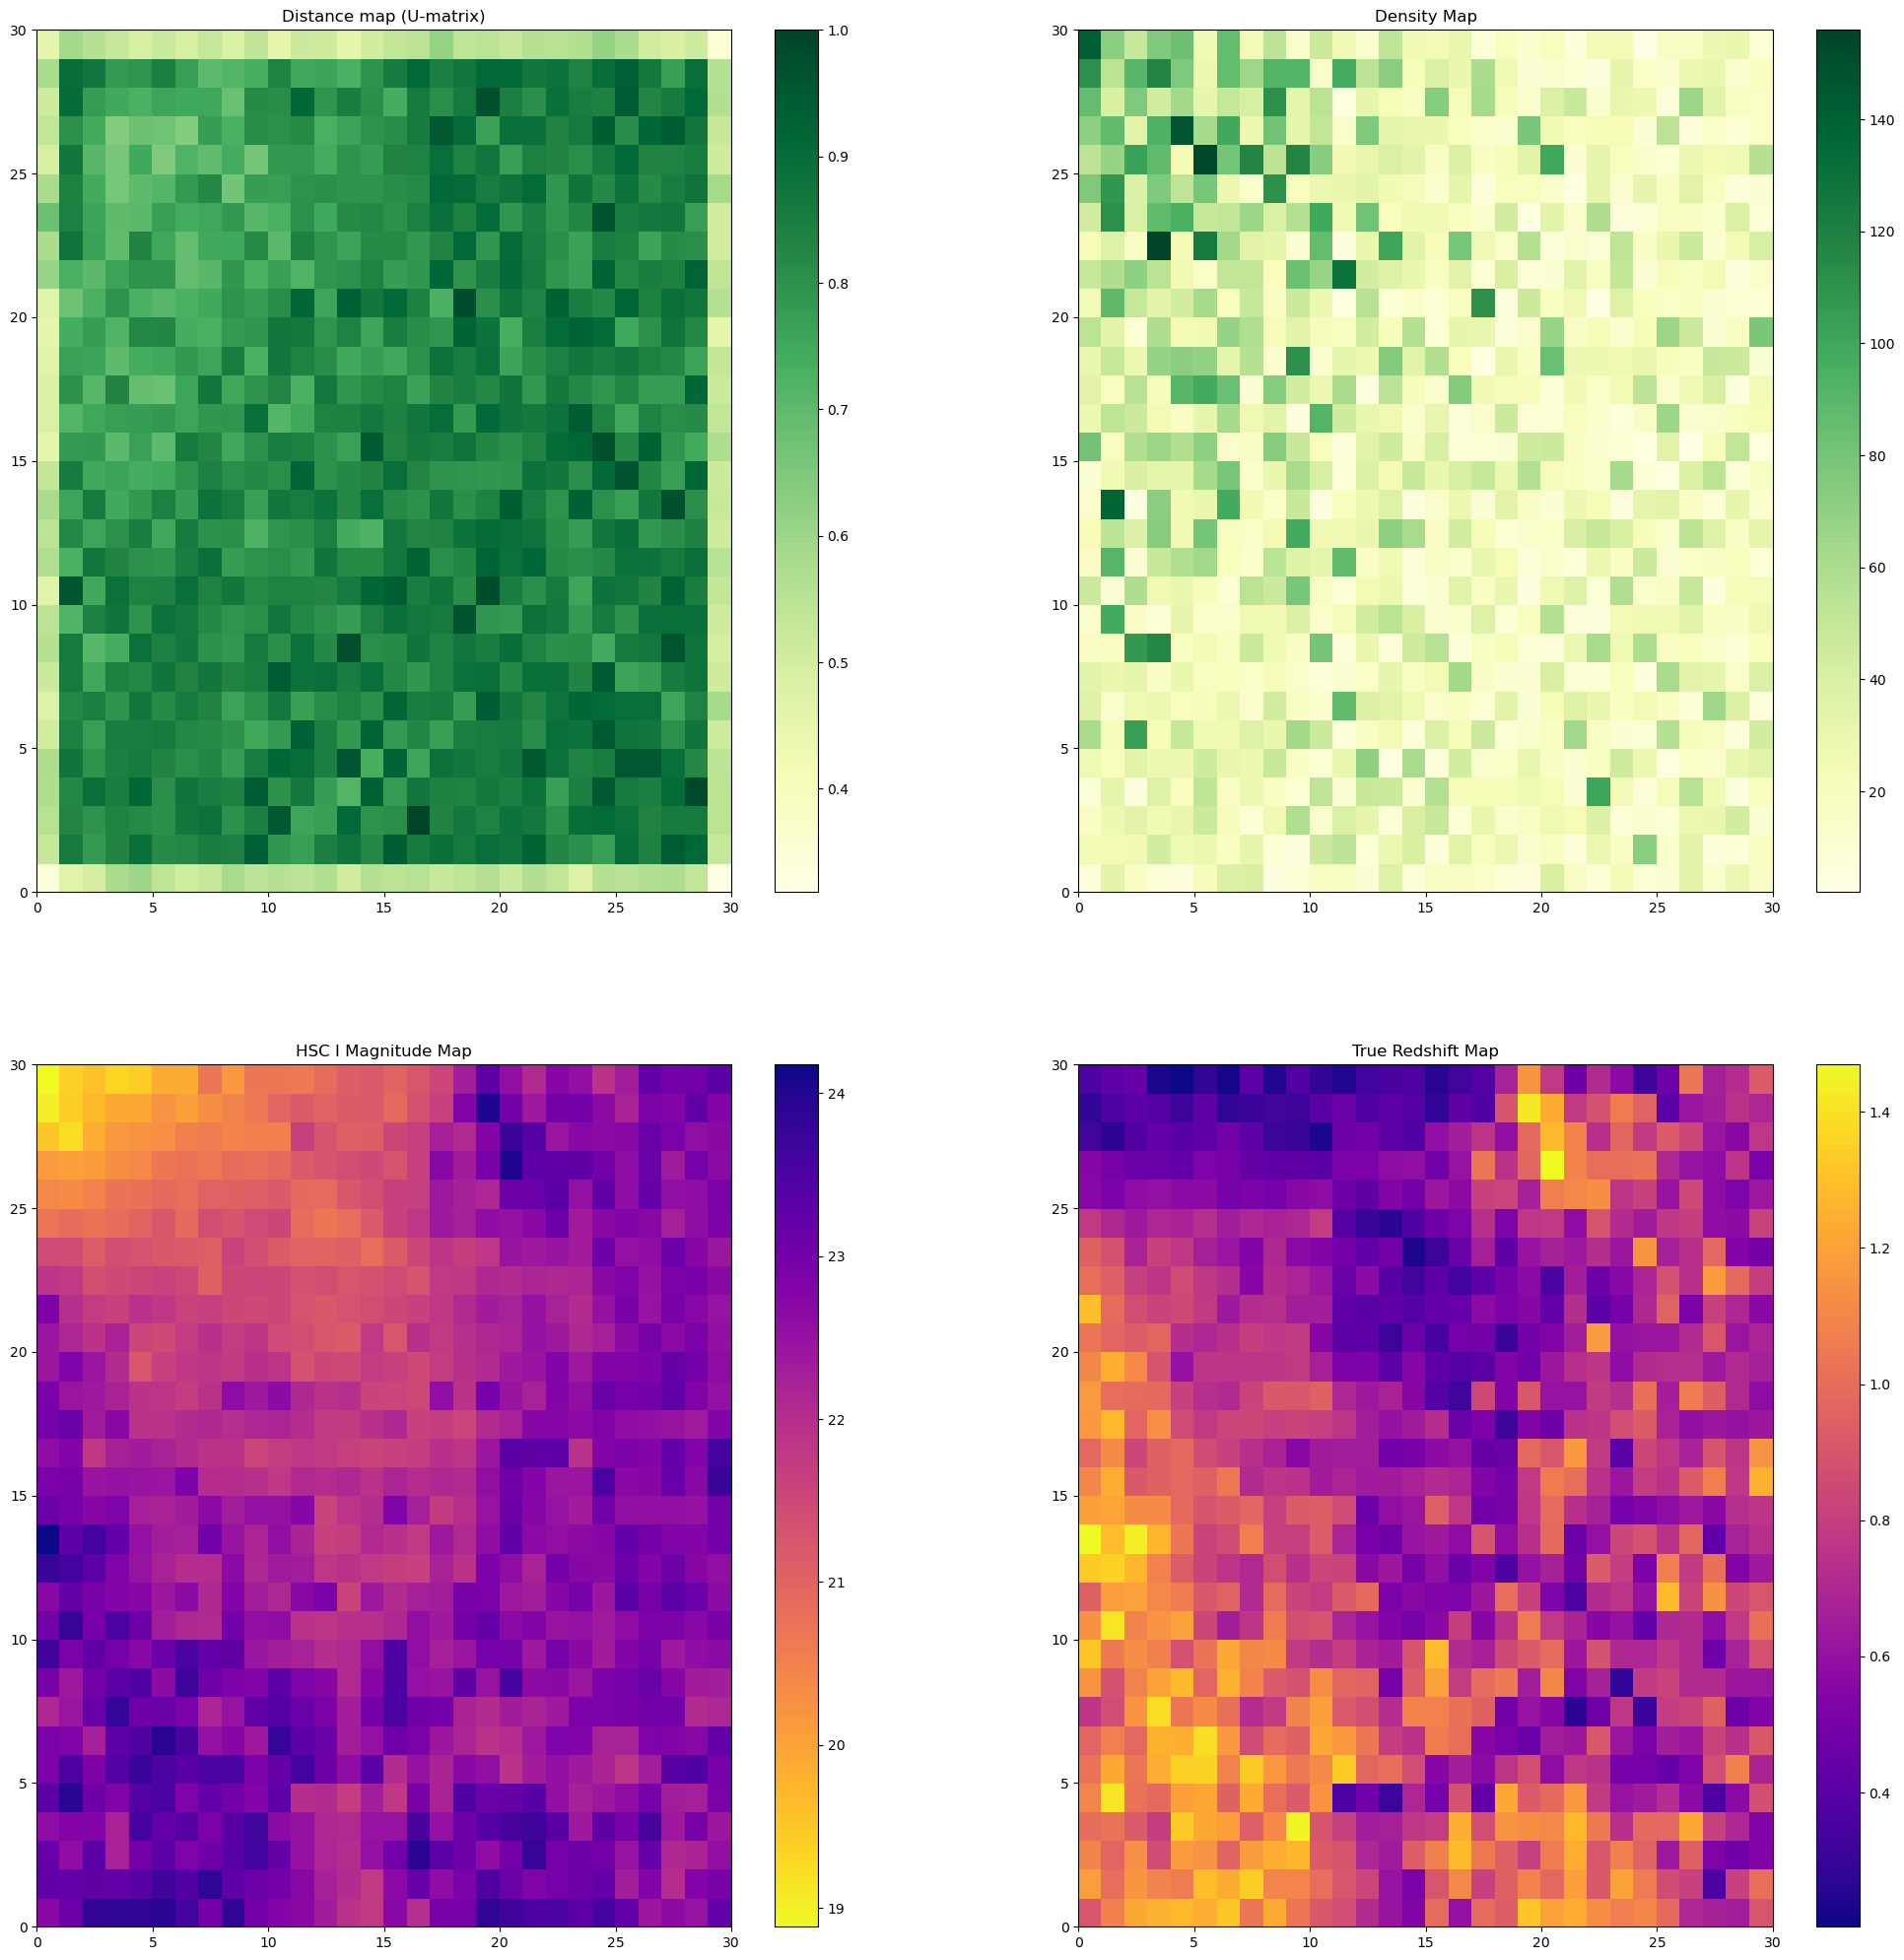

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 0.9]
29683.0
Topological error: 0.7991779806623319
Quantization error: 6.356483423509872
Average redshift std: 0.3575787252098826


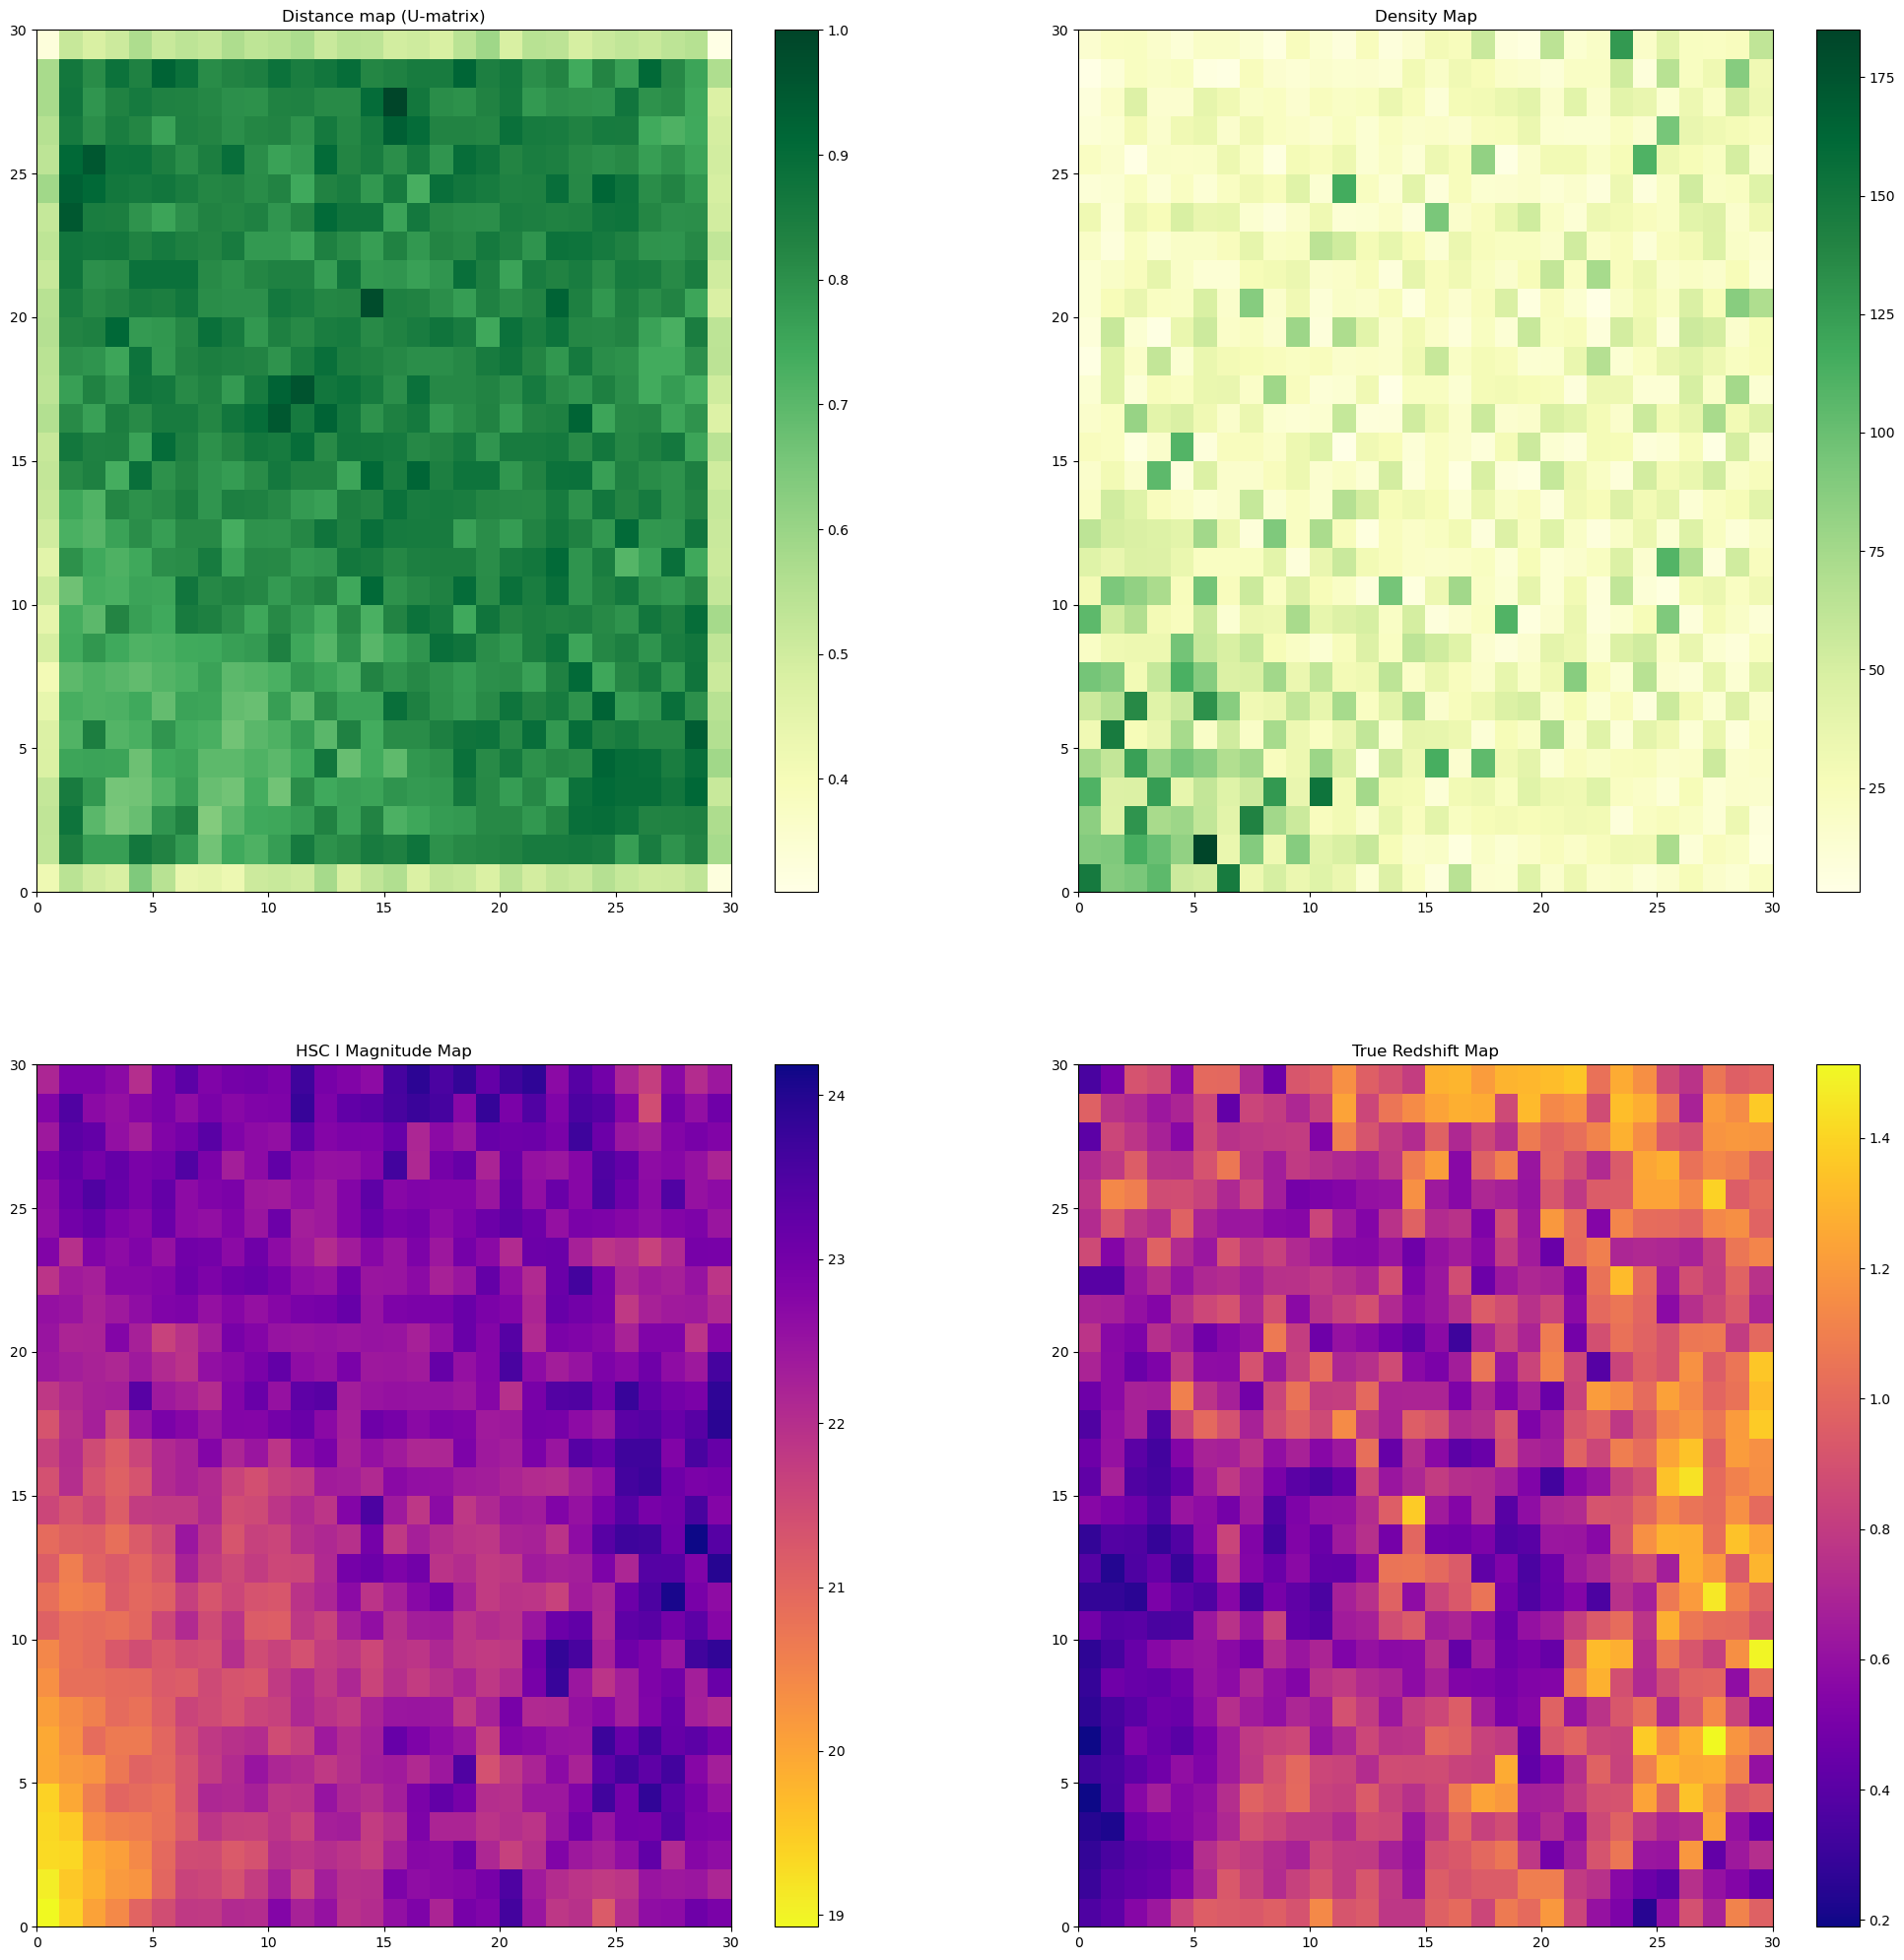

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 0.9]
29683.0
Topological error: 0.8727891385641613
Quantization error: 6.4138152343414525
Average redshift std: 0.3600950315252063


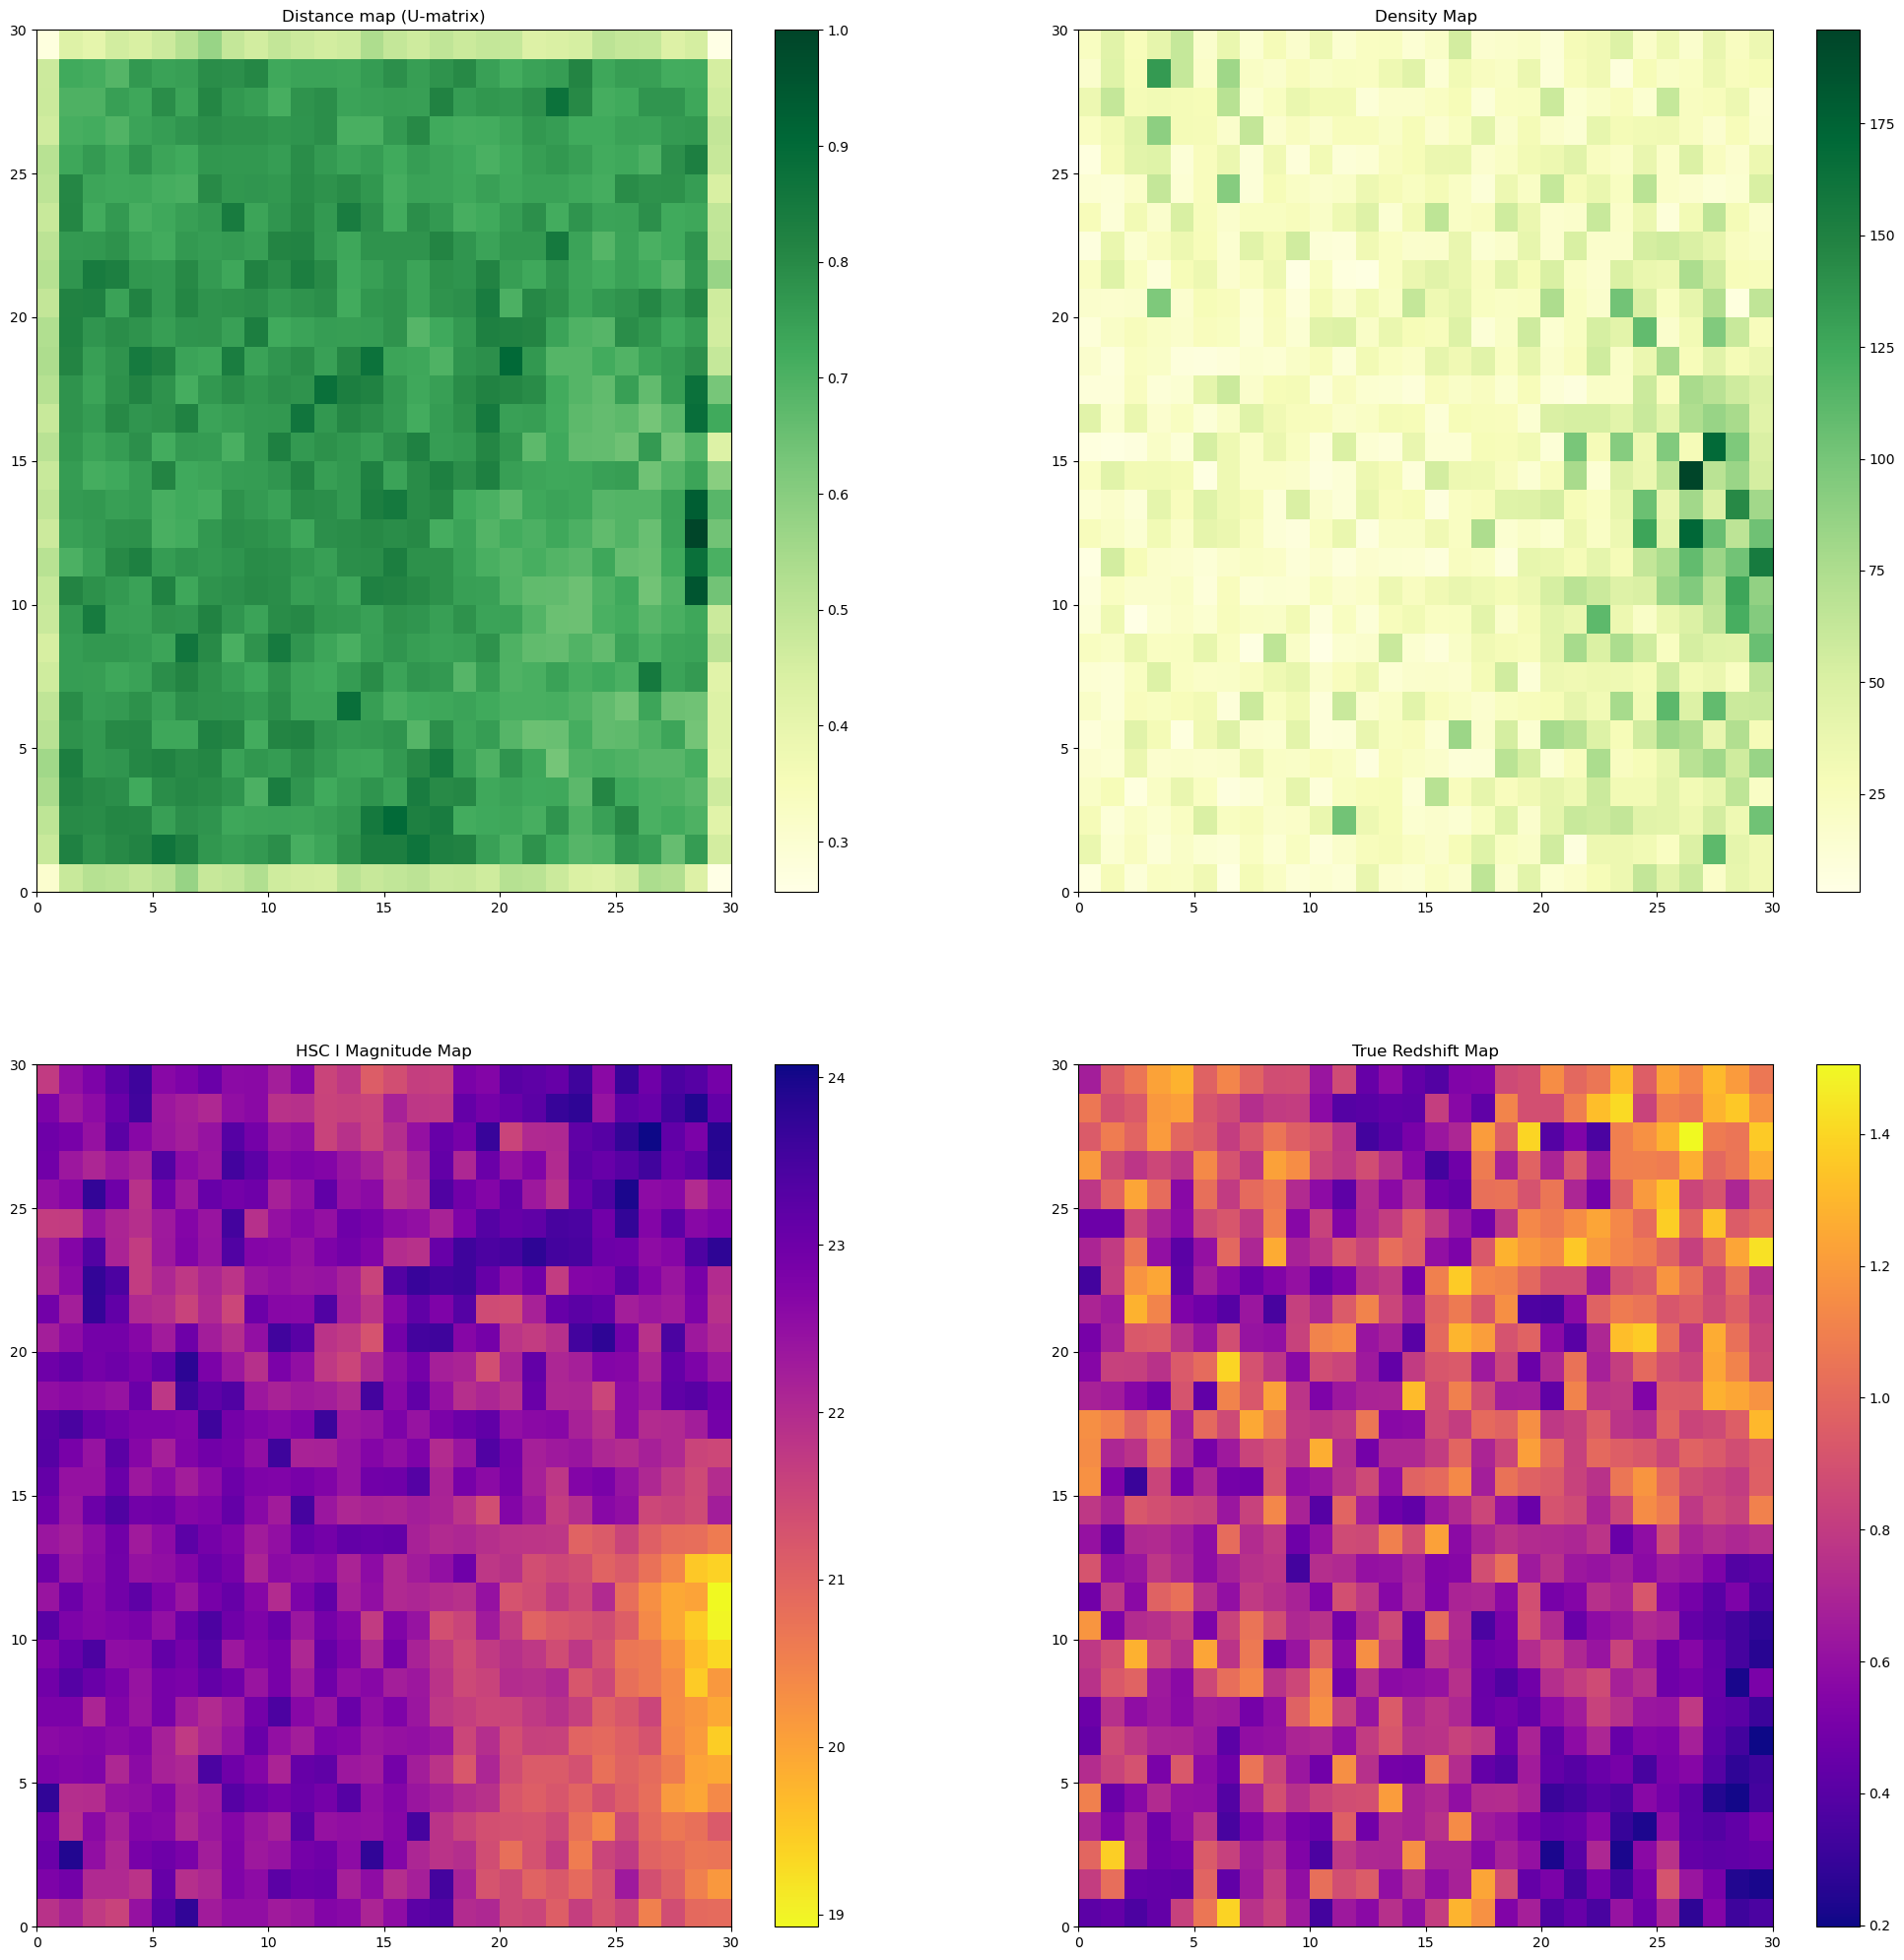

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 0.9]
29683.0
Topological error: 0.9259508809756426
Quantization error: 6.481479658268489
Average redshift std: 0.35873597752755687


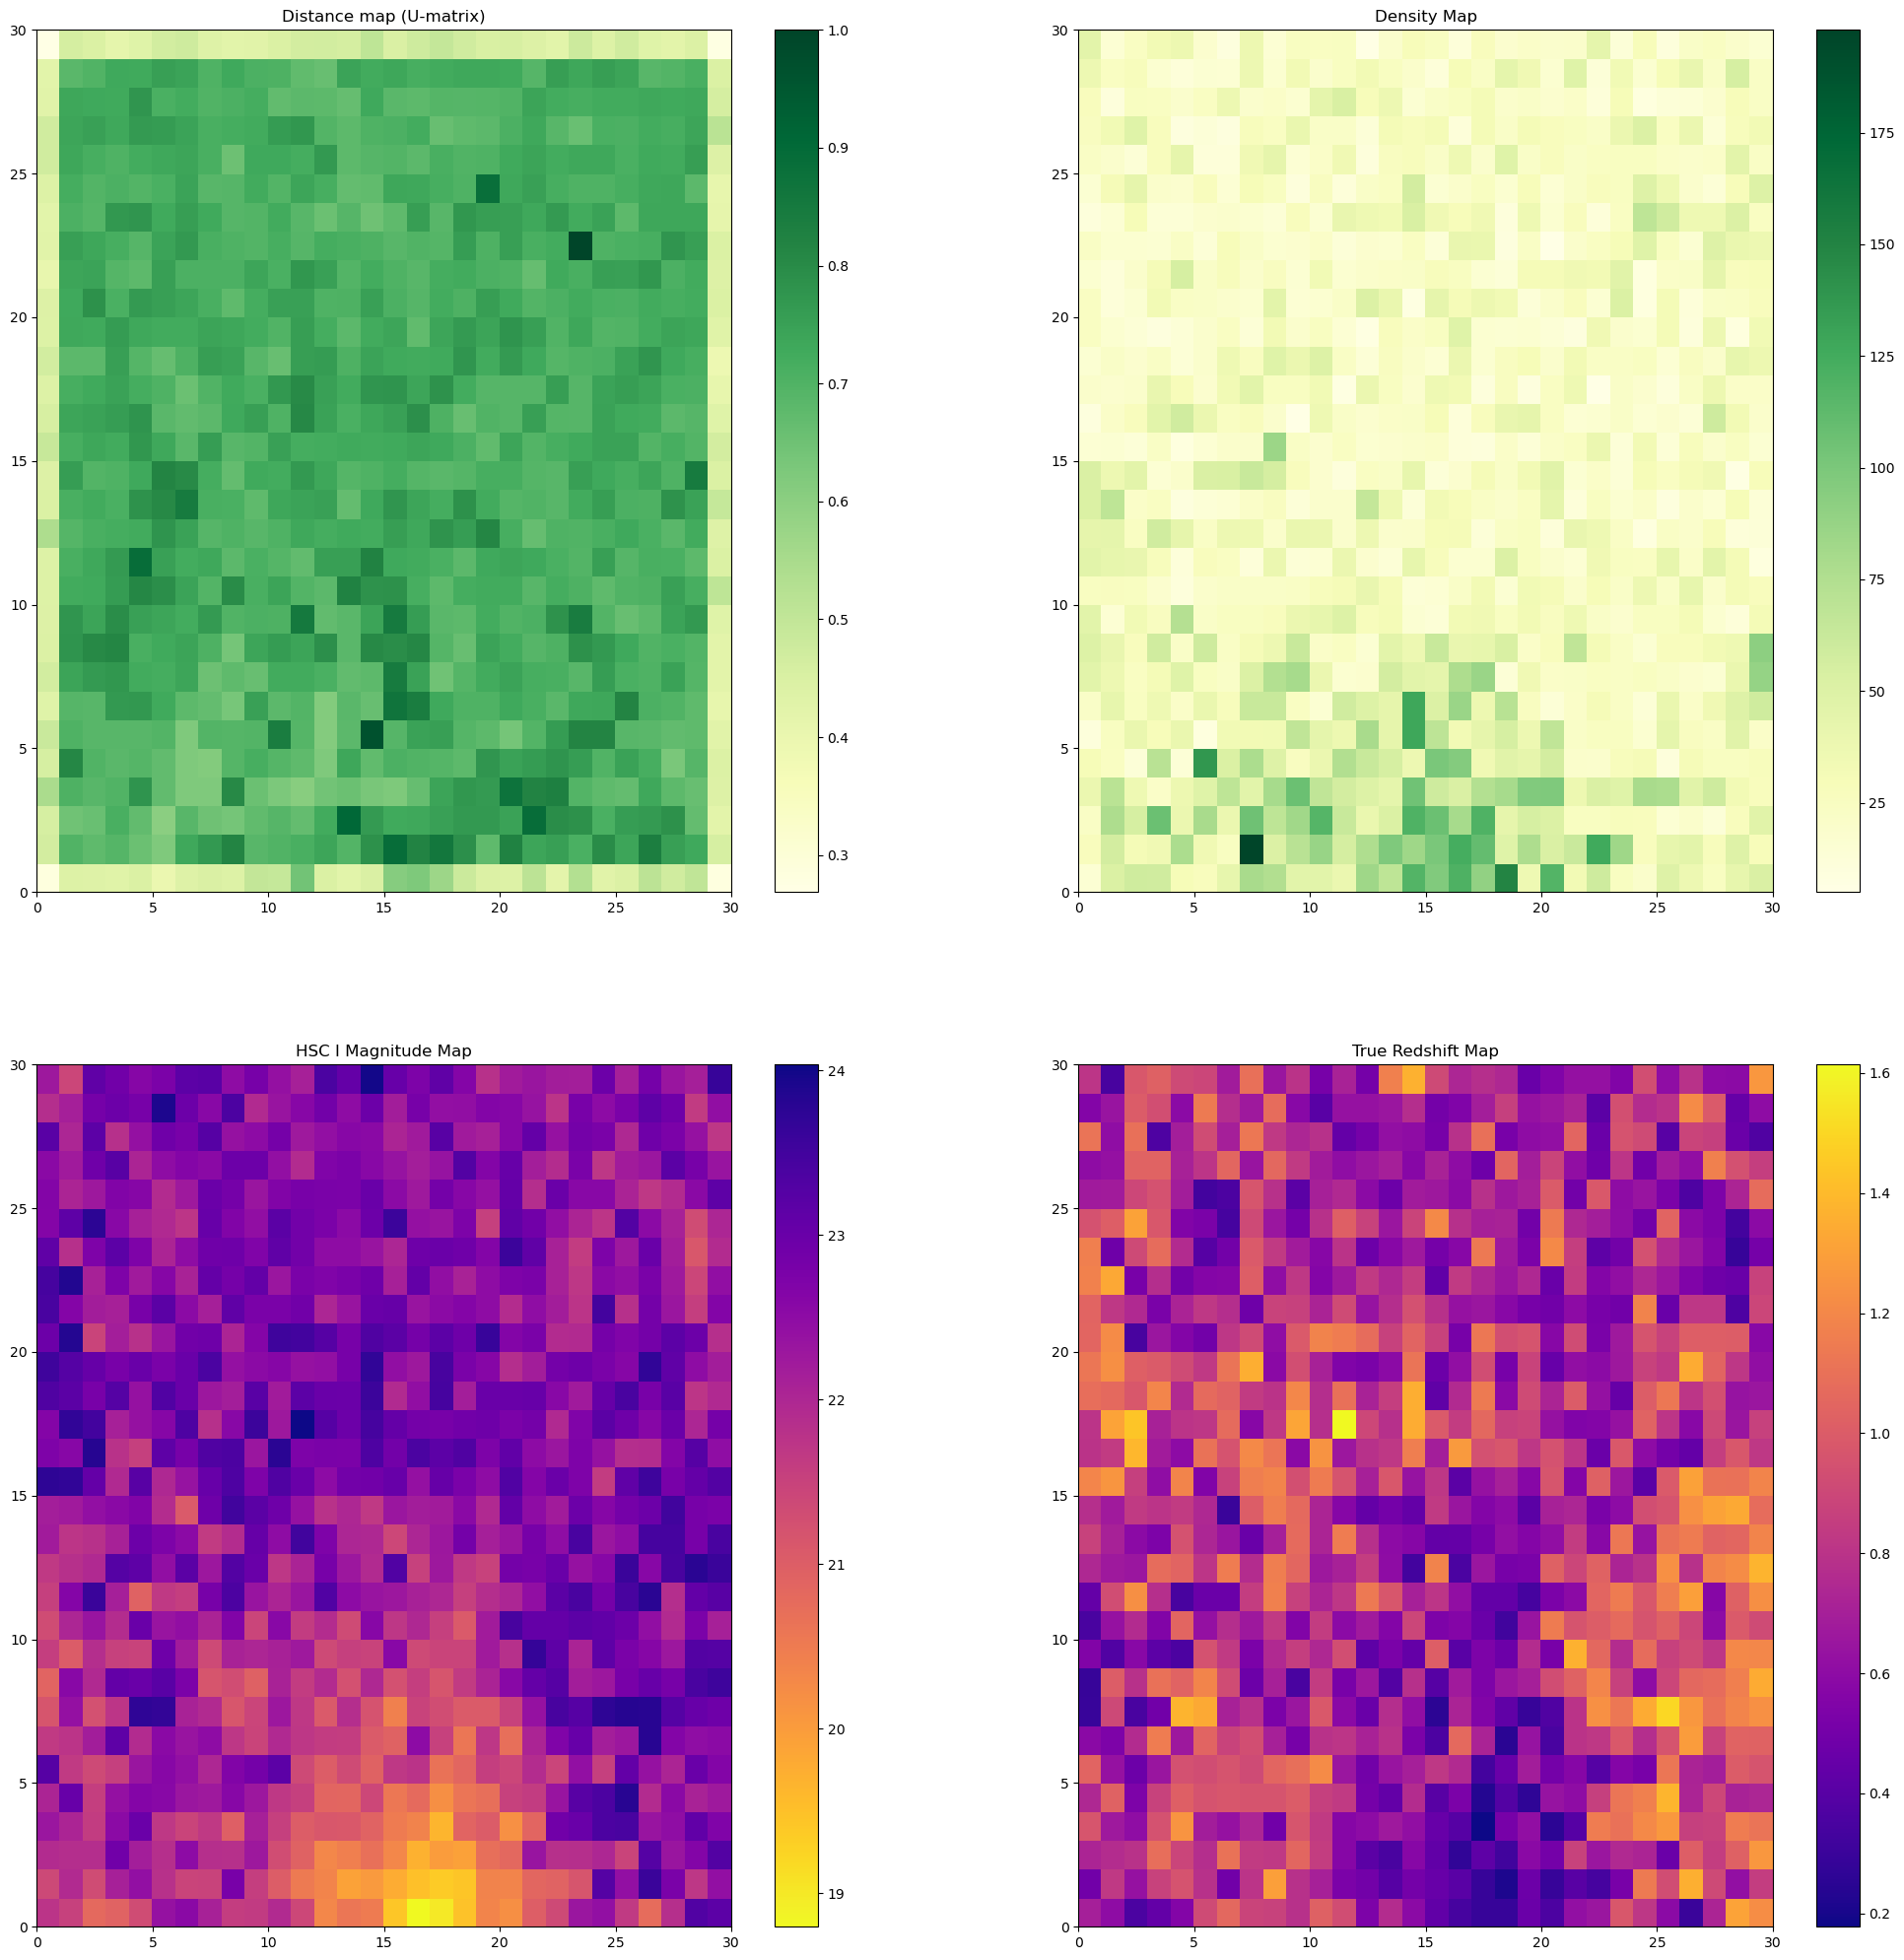

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 0.9]
29683.0
Topological error: 0.9419196172893576
Quantization error: 6.528040102441817
Average redshift std: 0.36592648773409553


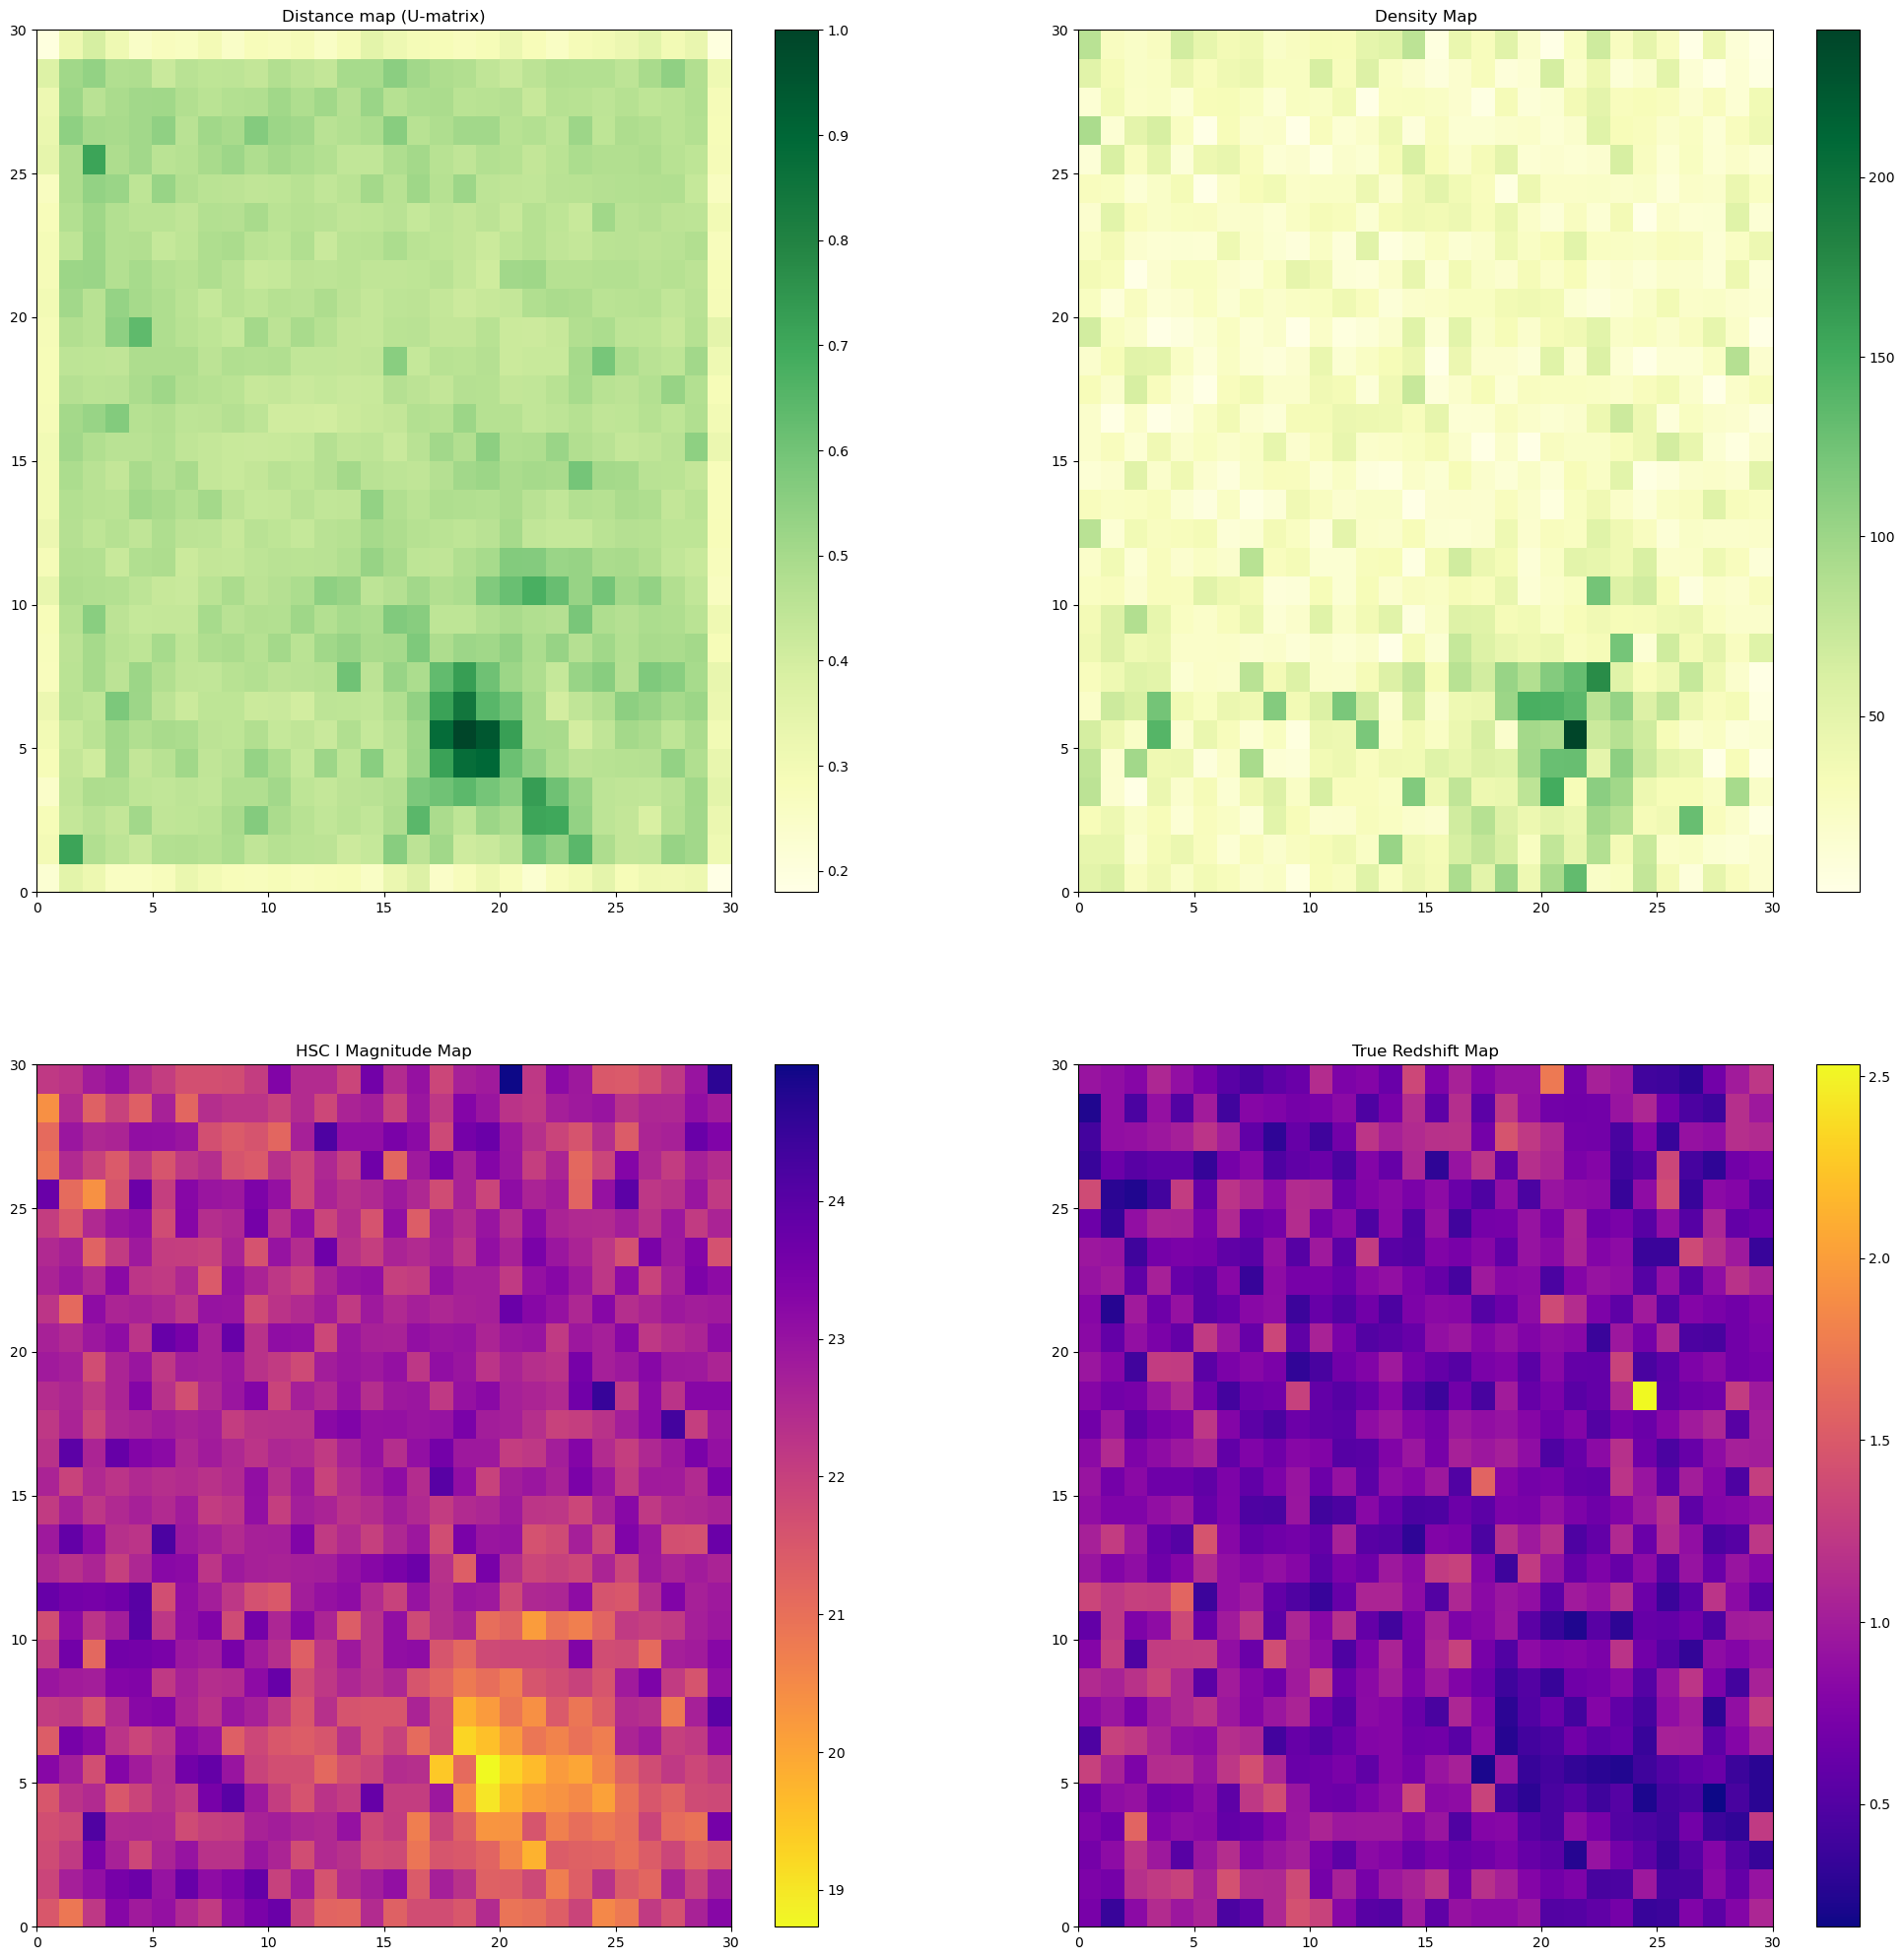

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 0.9]
29683.0
Topological error: 0.948724859347101
Quantization error: 6.569236854440989
Average redshift std: 0.36791567579903445


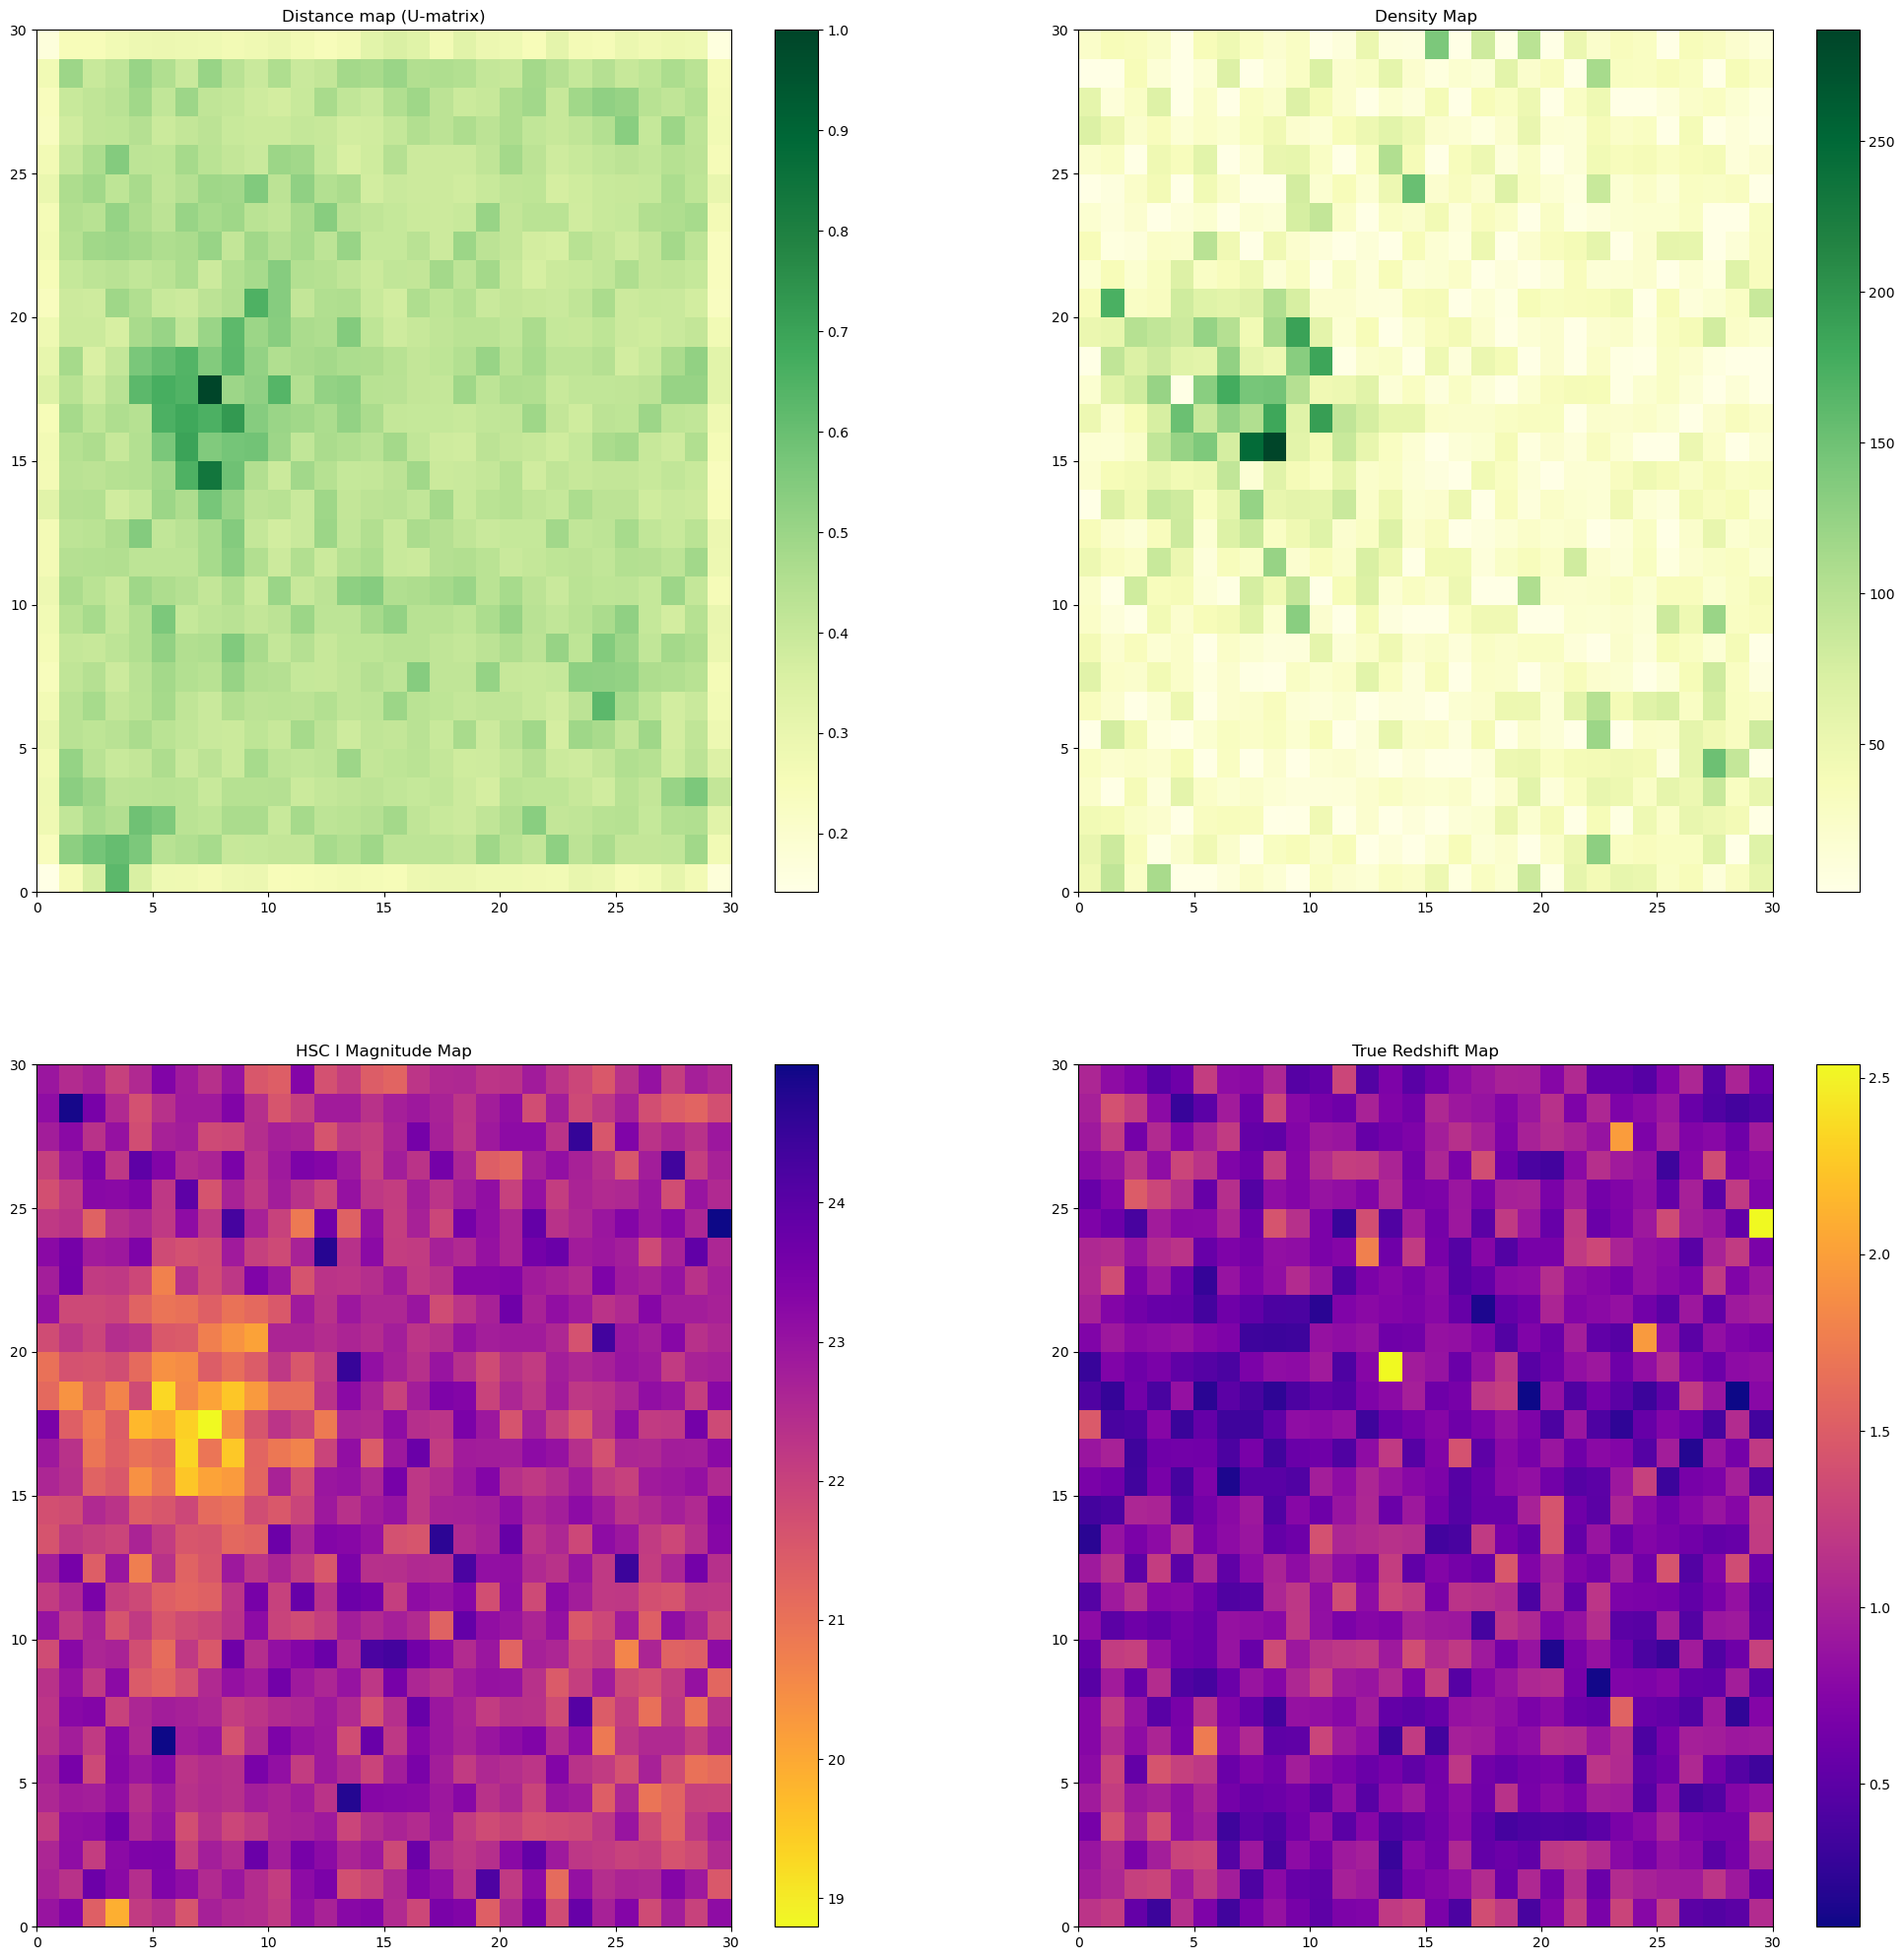

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 0.9]
29683.0
Topological error: 0.980797089243001
Quantization error: 6.607927441206776
Average redshift std: 0.3775858267304851


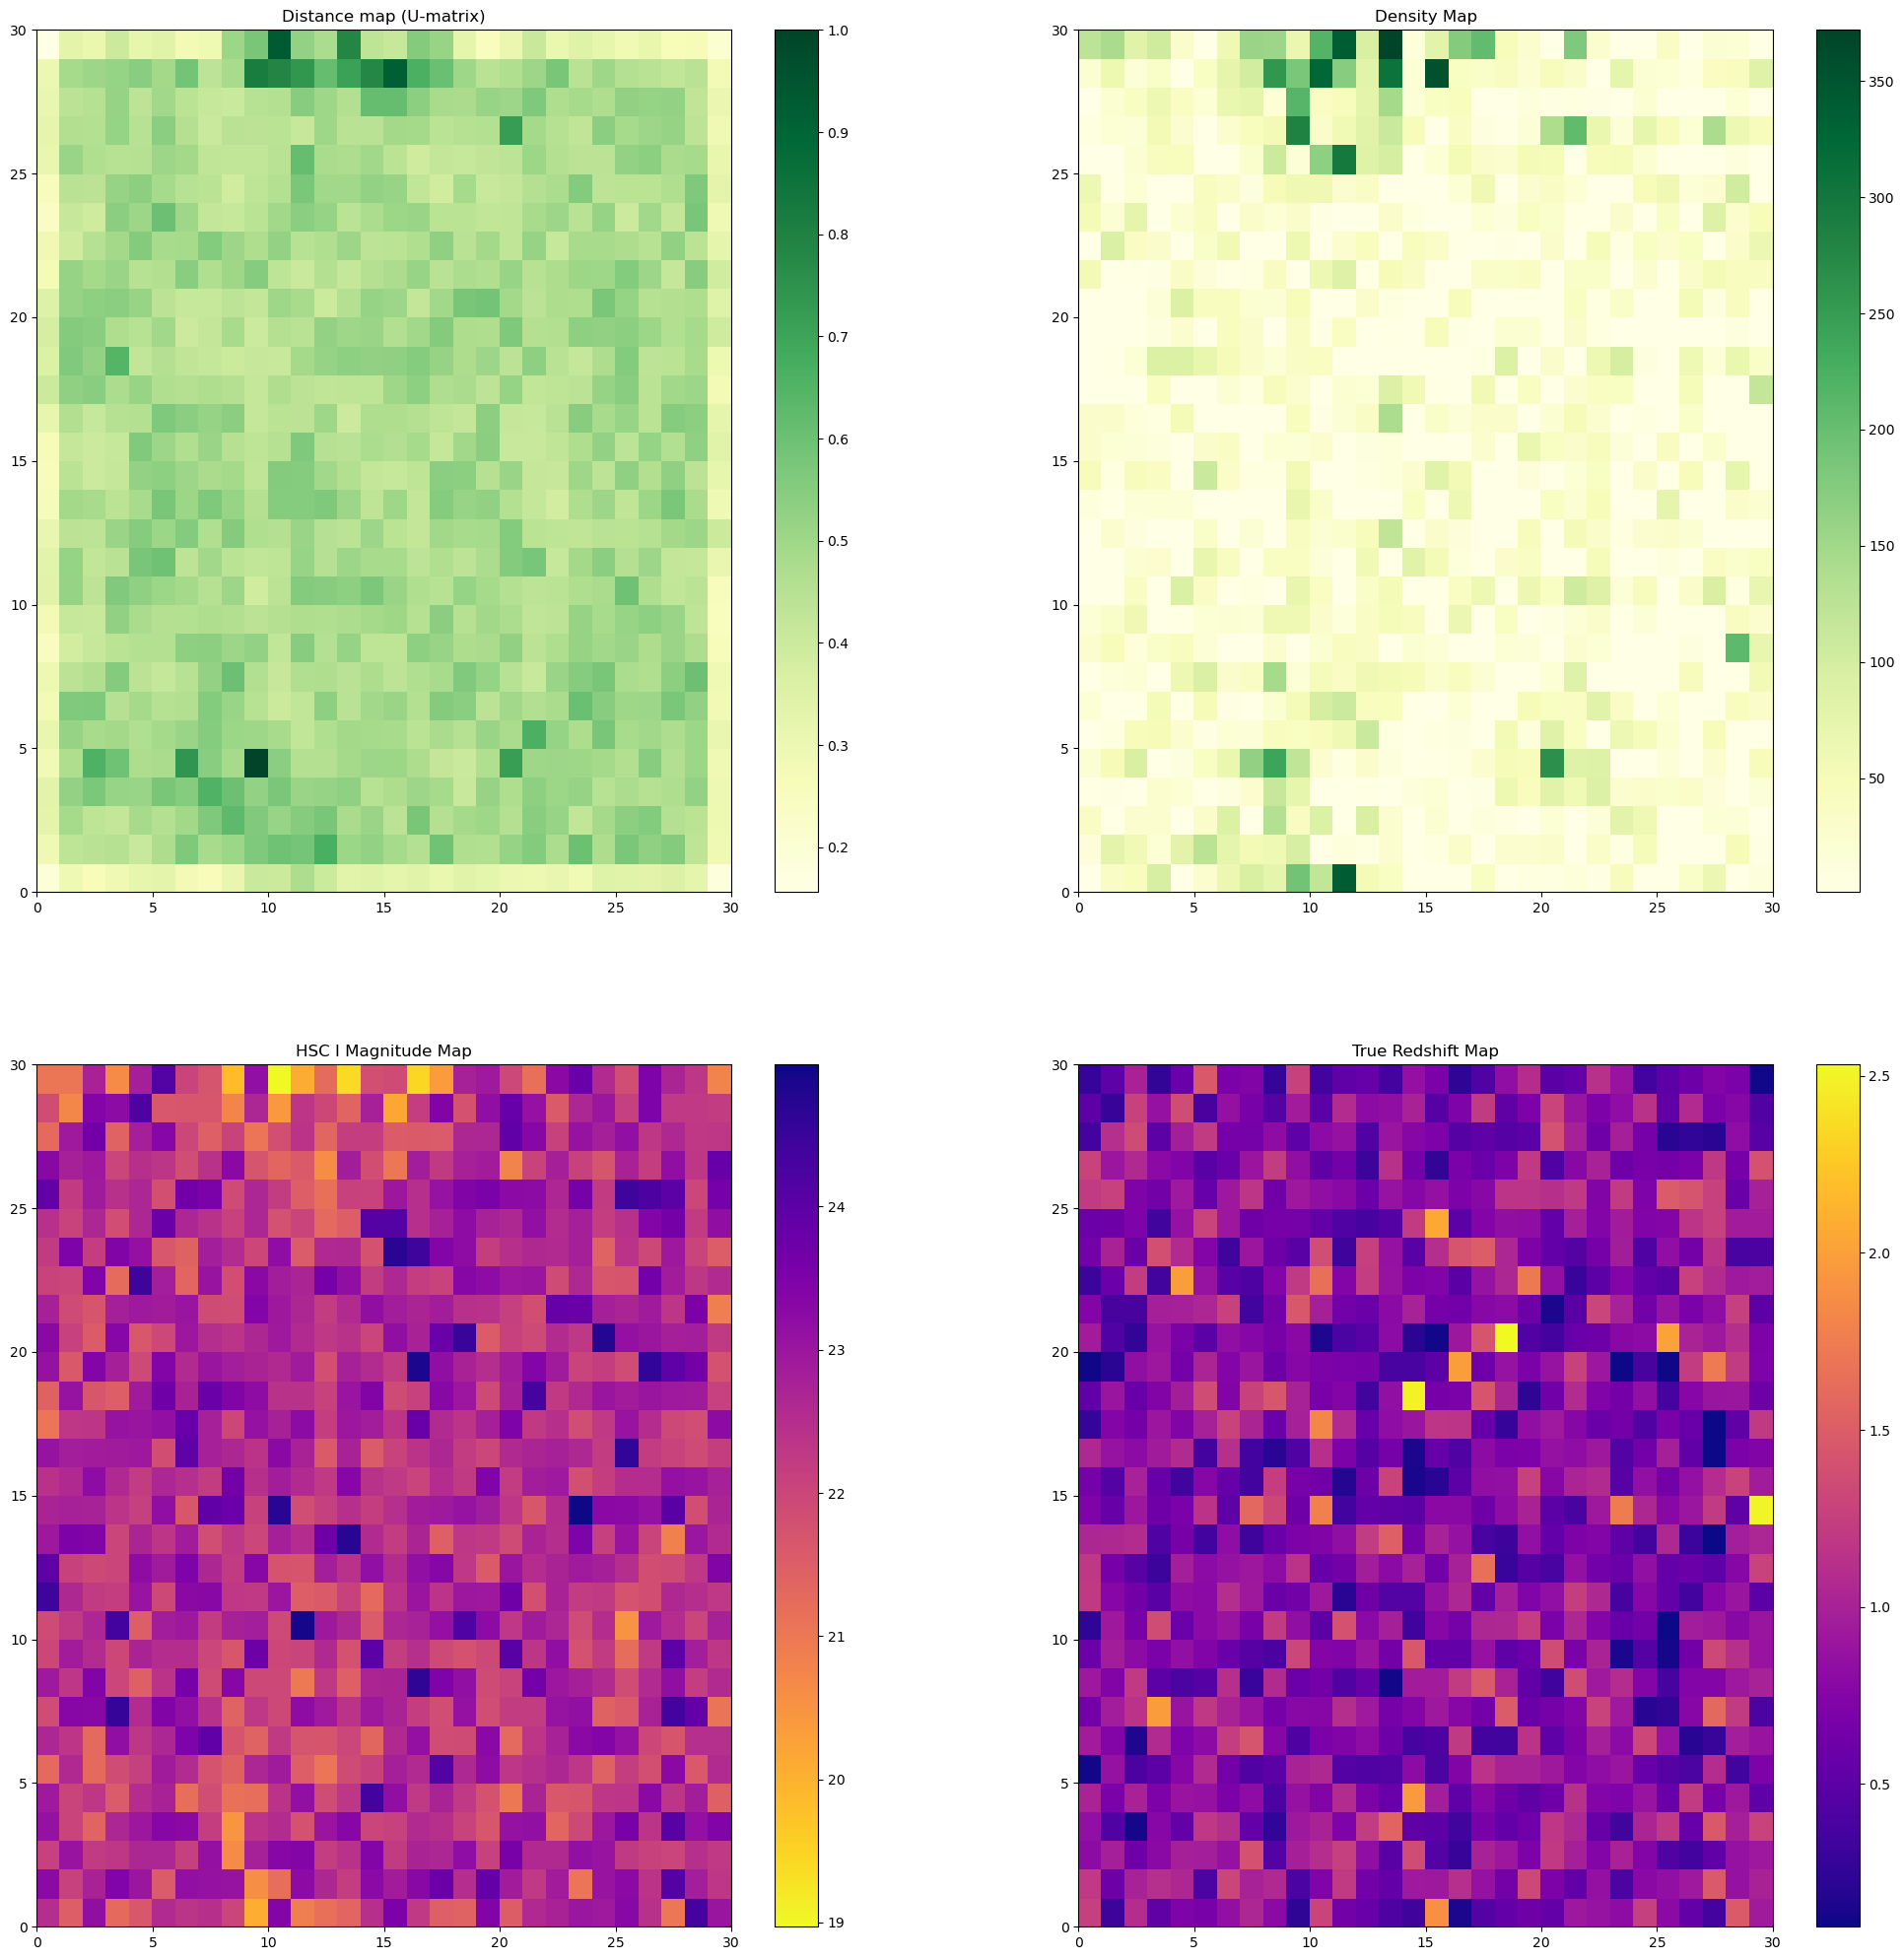

Data shape: (29683, 102)
Start making diagrams...
[30, 1, 1.0]
29683.0
Topological error: 0.7602668193915709
Quantization error: 6.347978707043433
Average redshift std: 0.35622524208783185


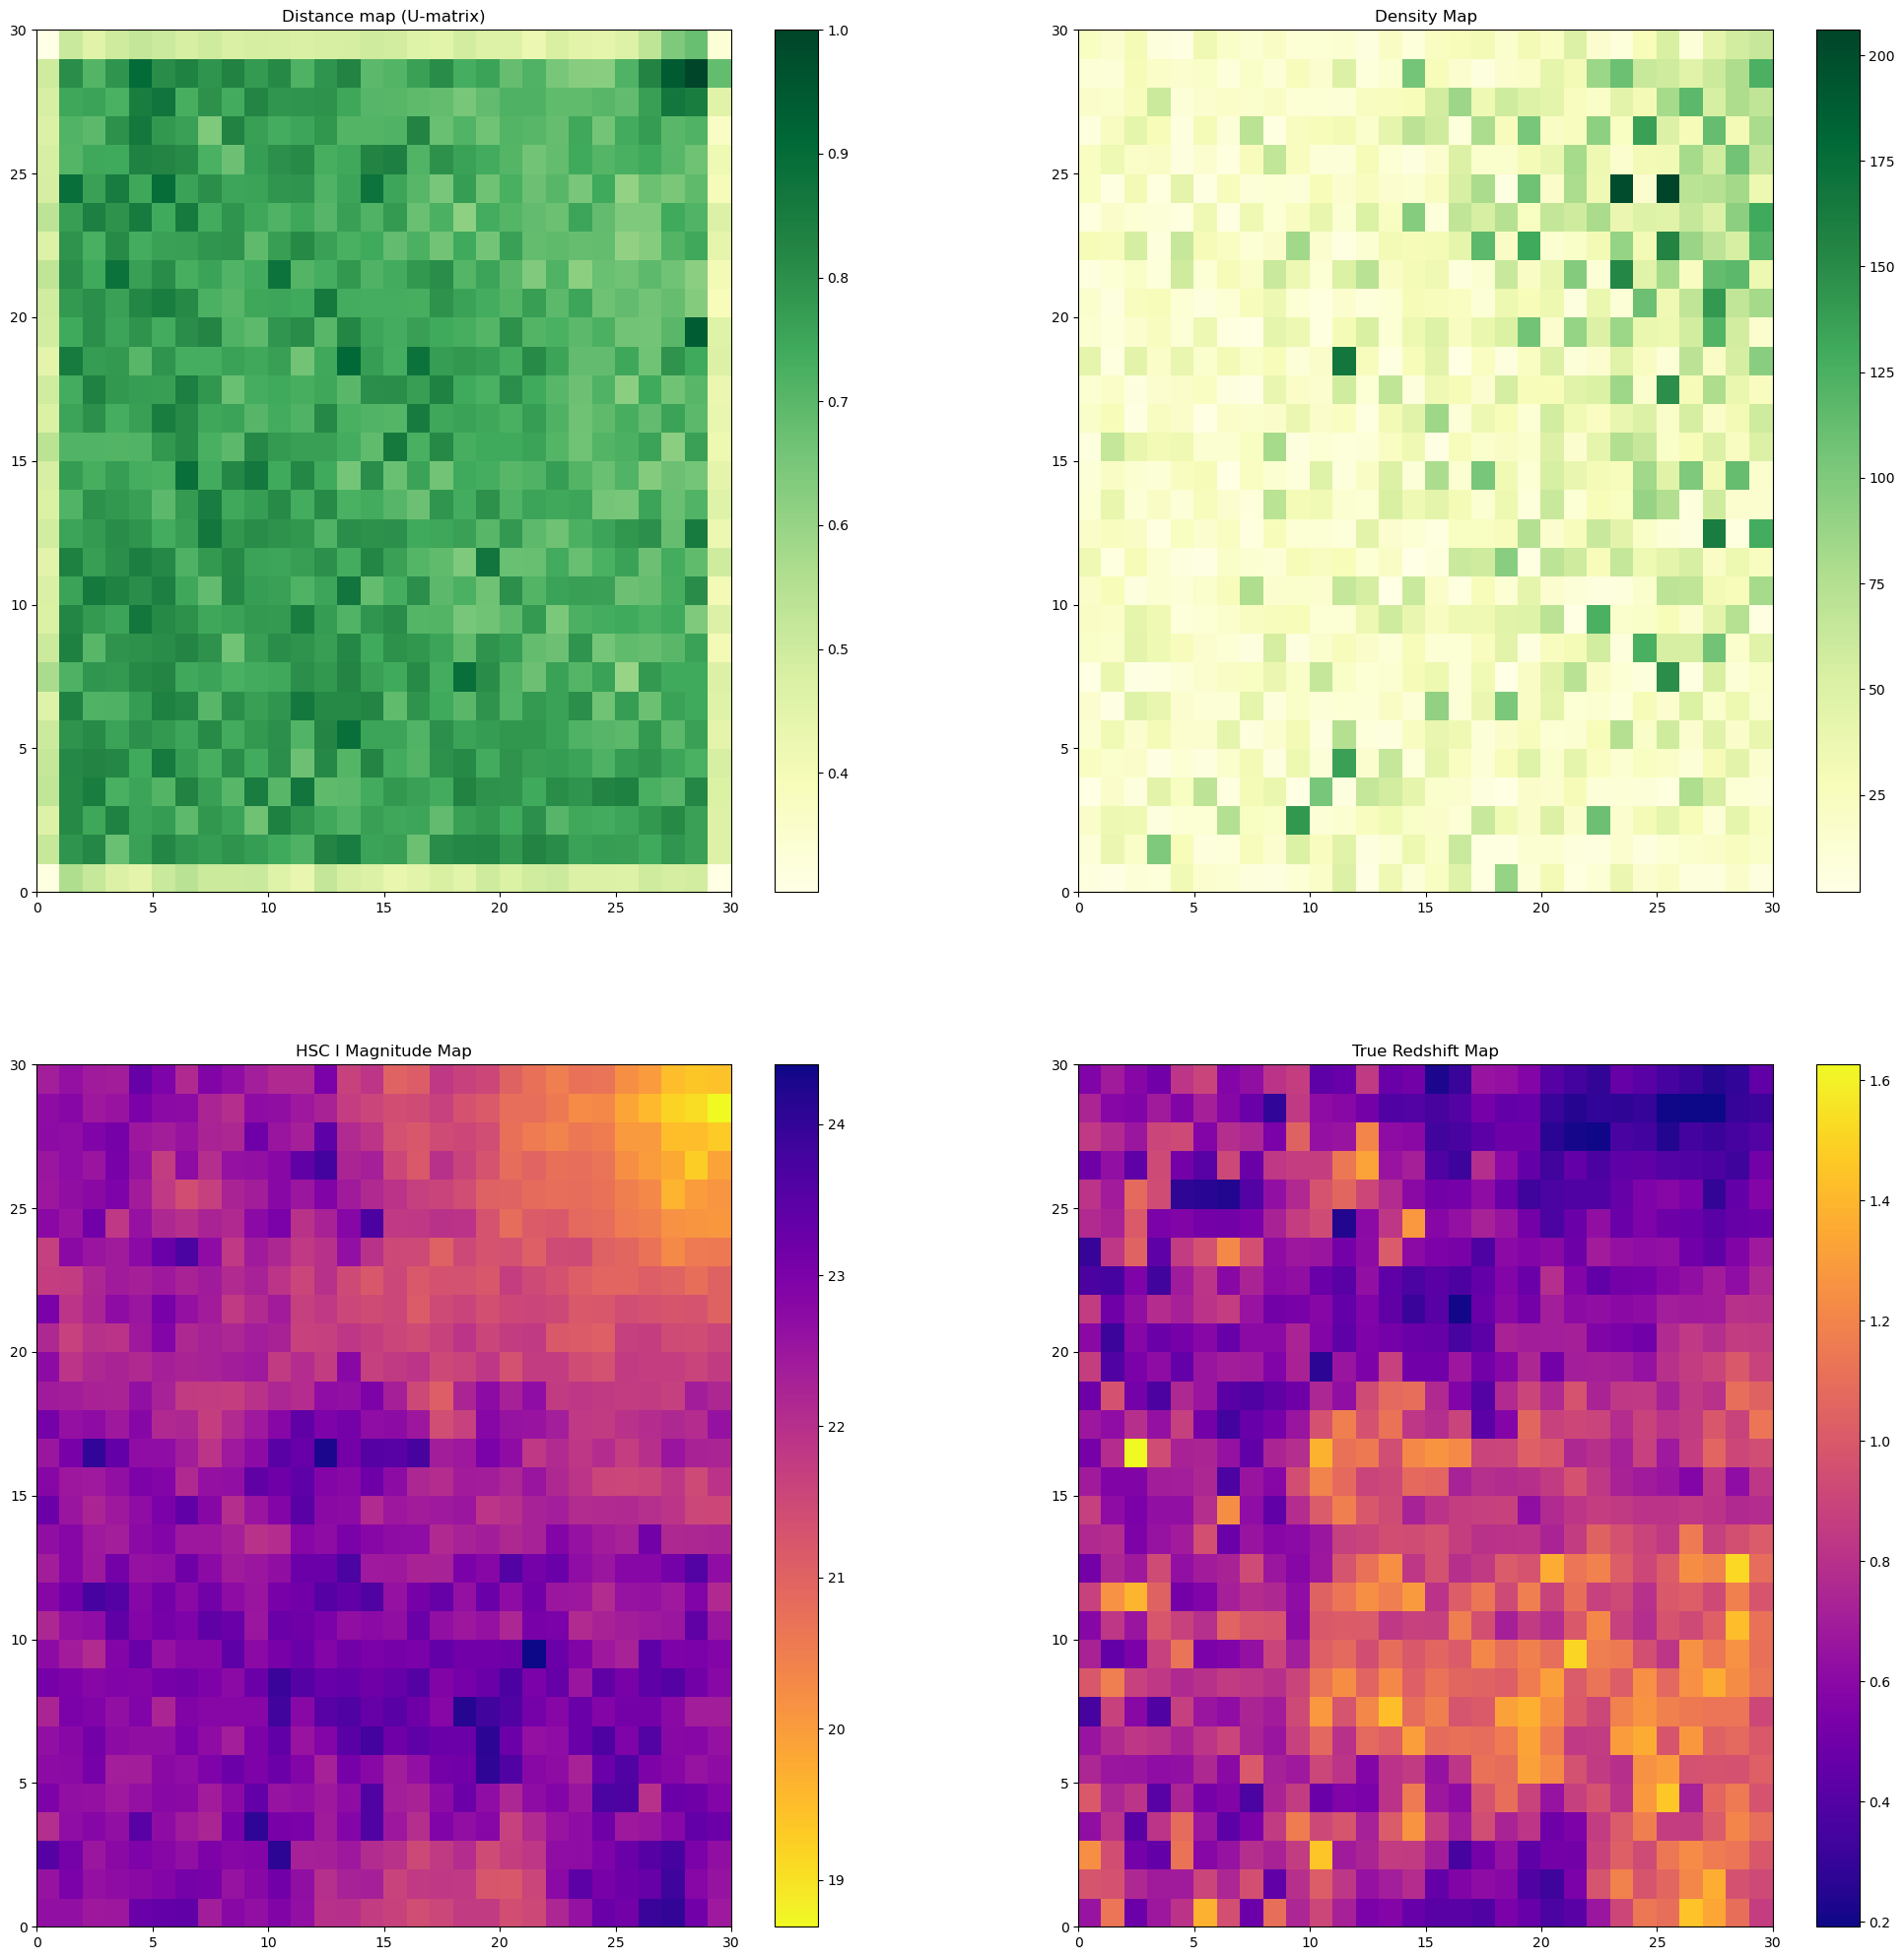

Data shape: (29683, 102)
Start making diagrams...
[30, 0.9, 1.0]
29683.0
Topological error: 0.8077013778930701
Quantization error: 6.406016750222802
Average redshift std: 0.369383152443101


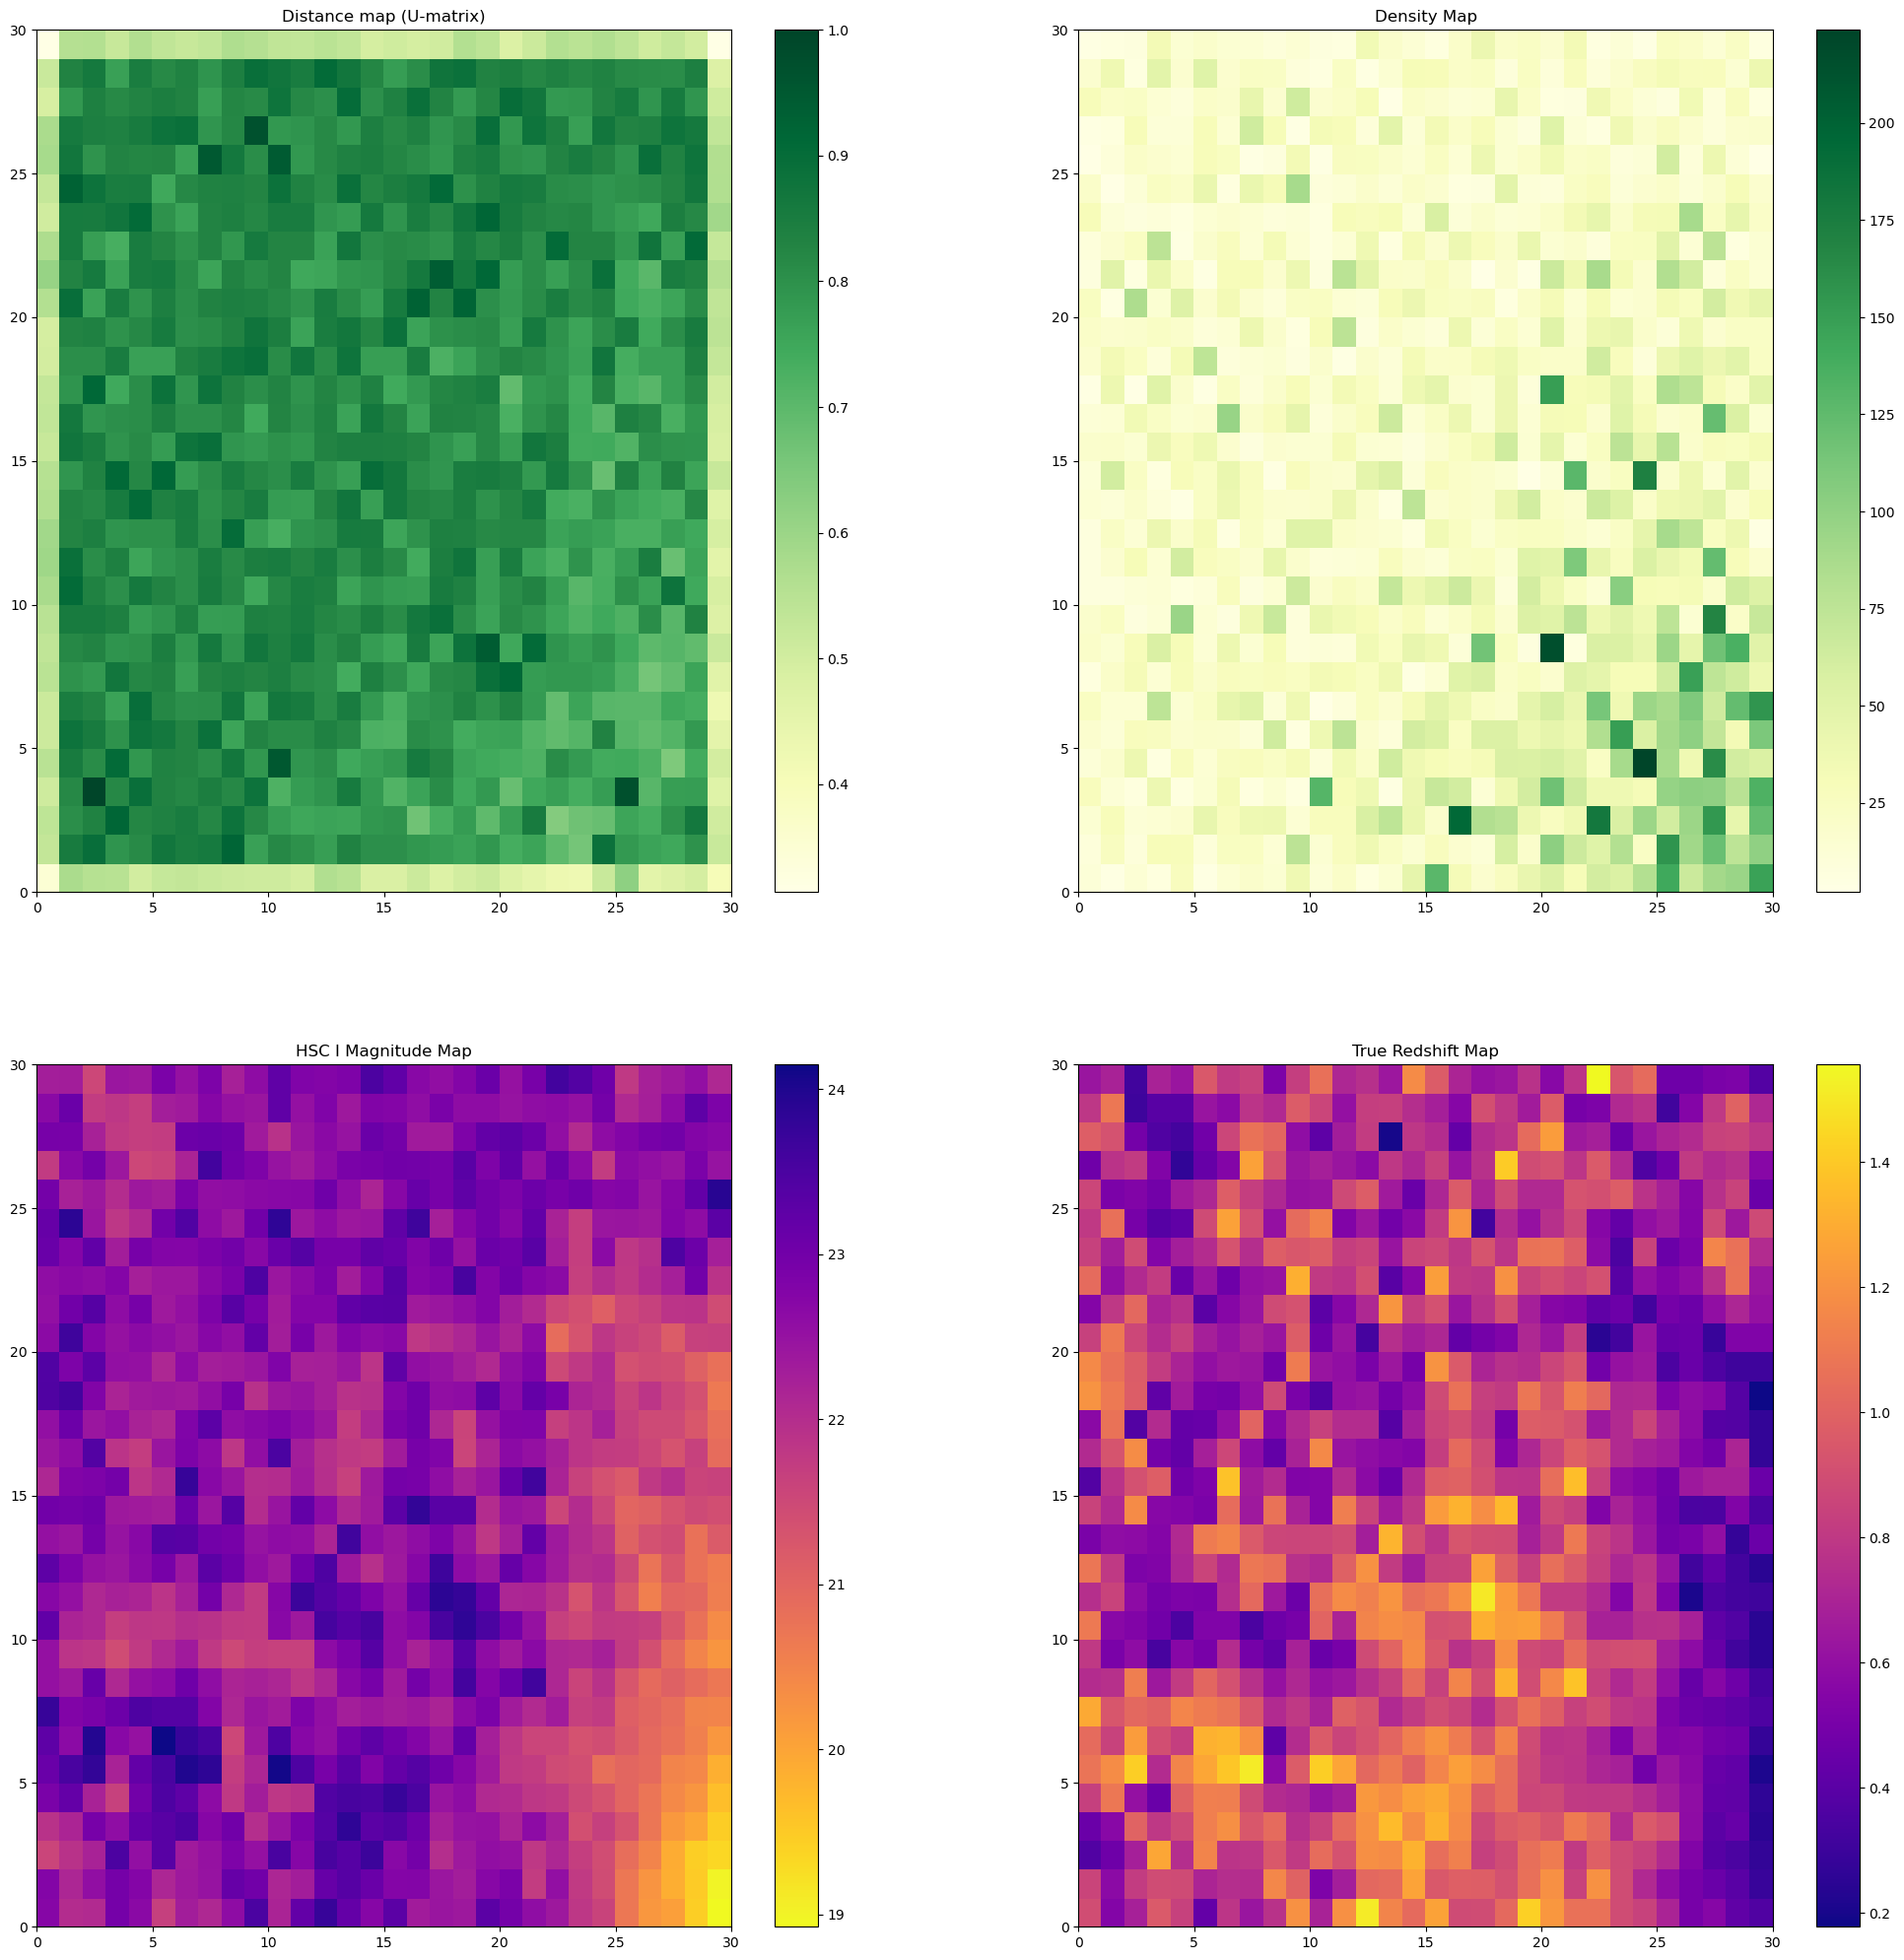

Data shape: (29683, 102)
Start making diagrams...
[30, 0.8, 1.0]
29683.0
Topological error: 0.895765252838325
Quantization error: 6.481311879983161
Average redshift std: 0.36834614370974333


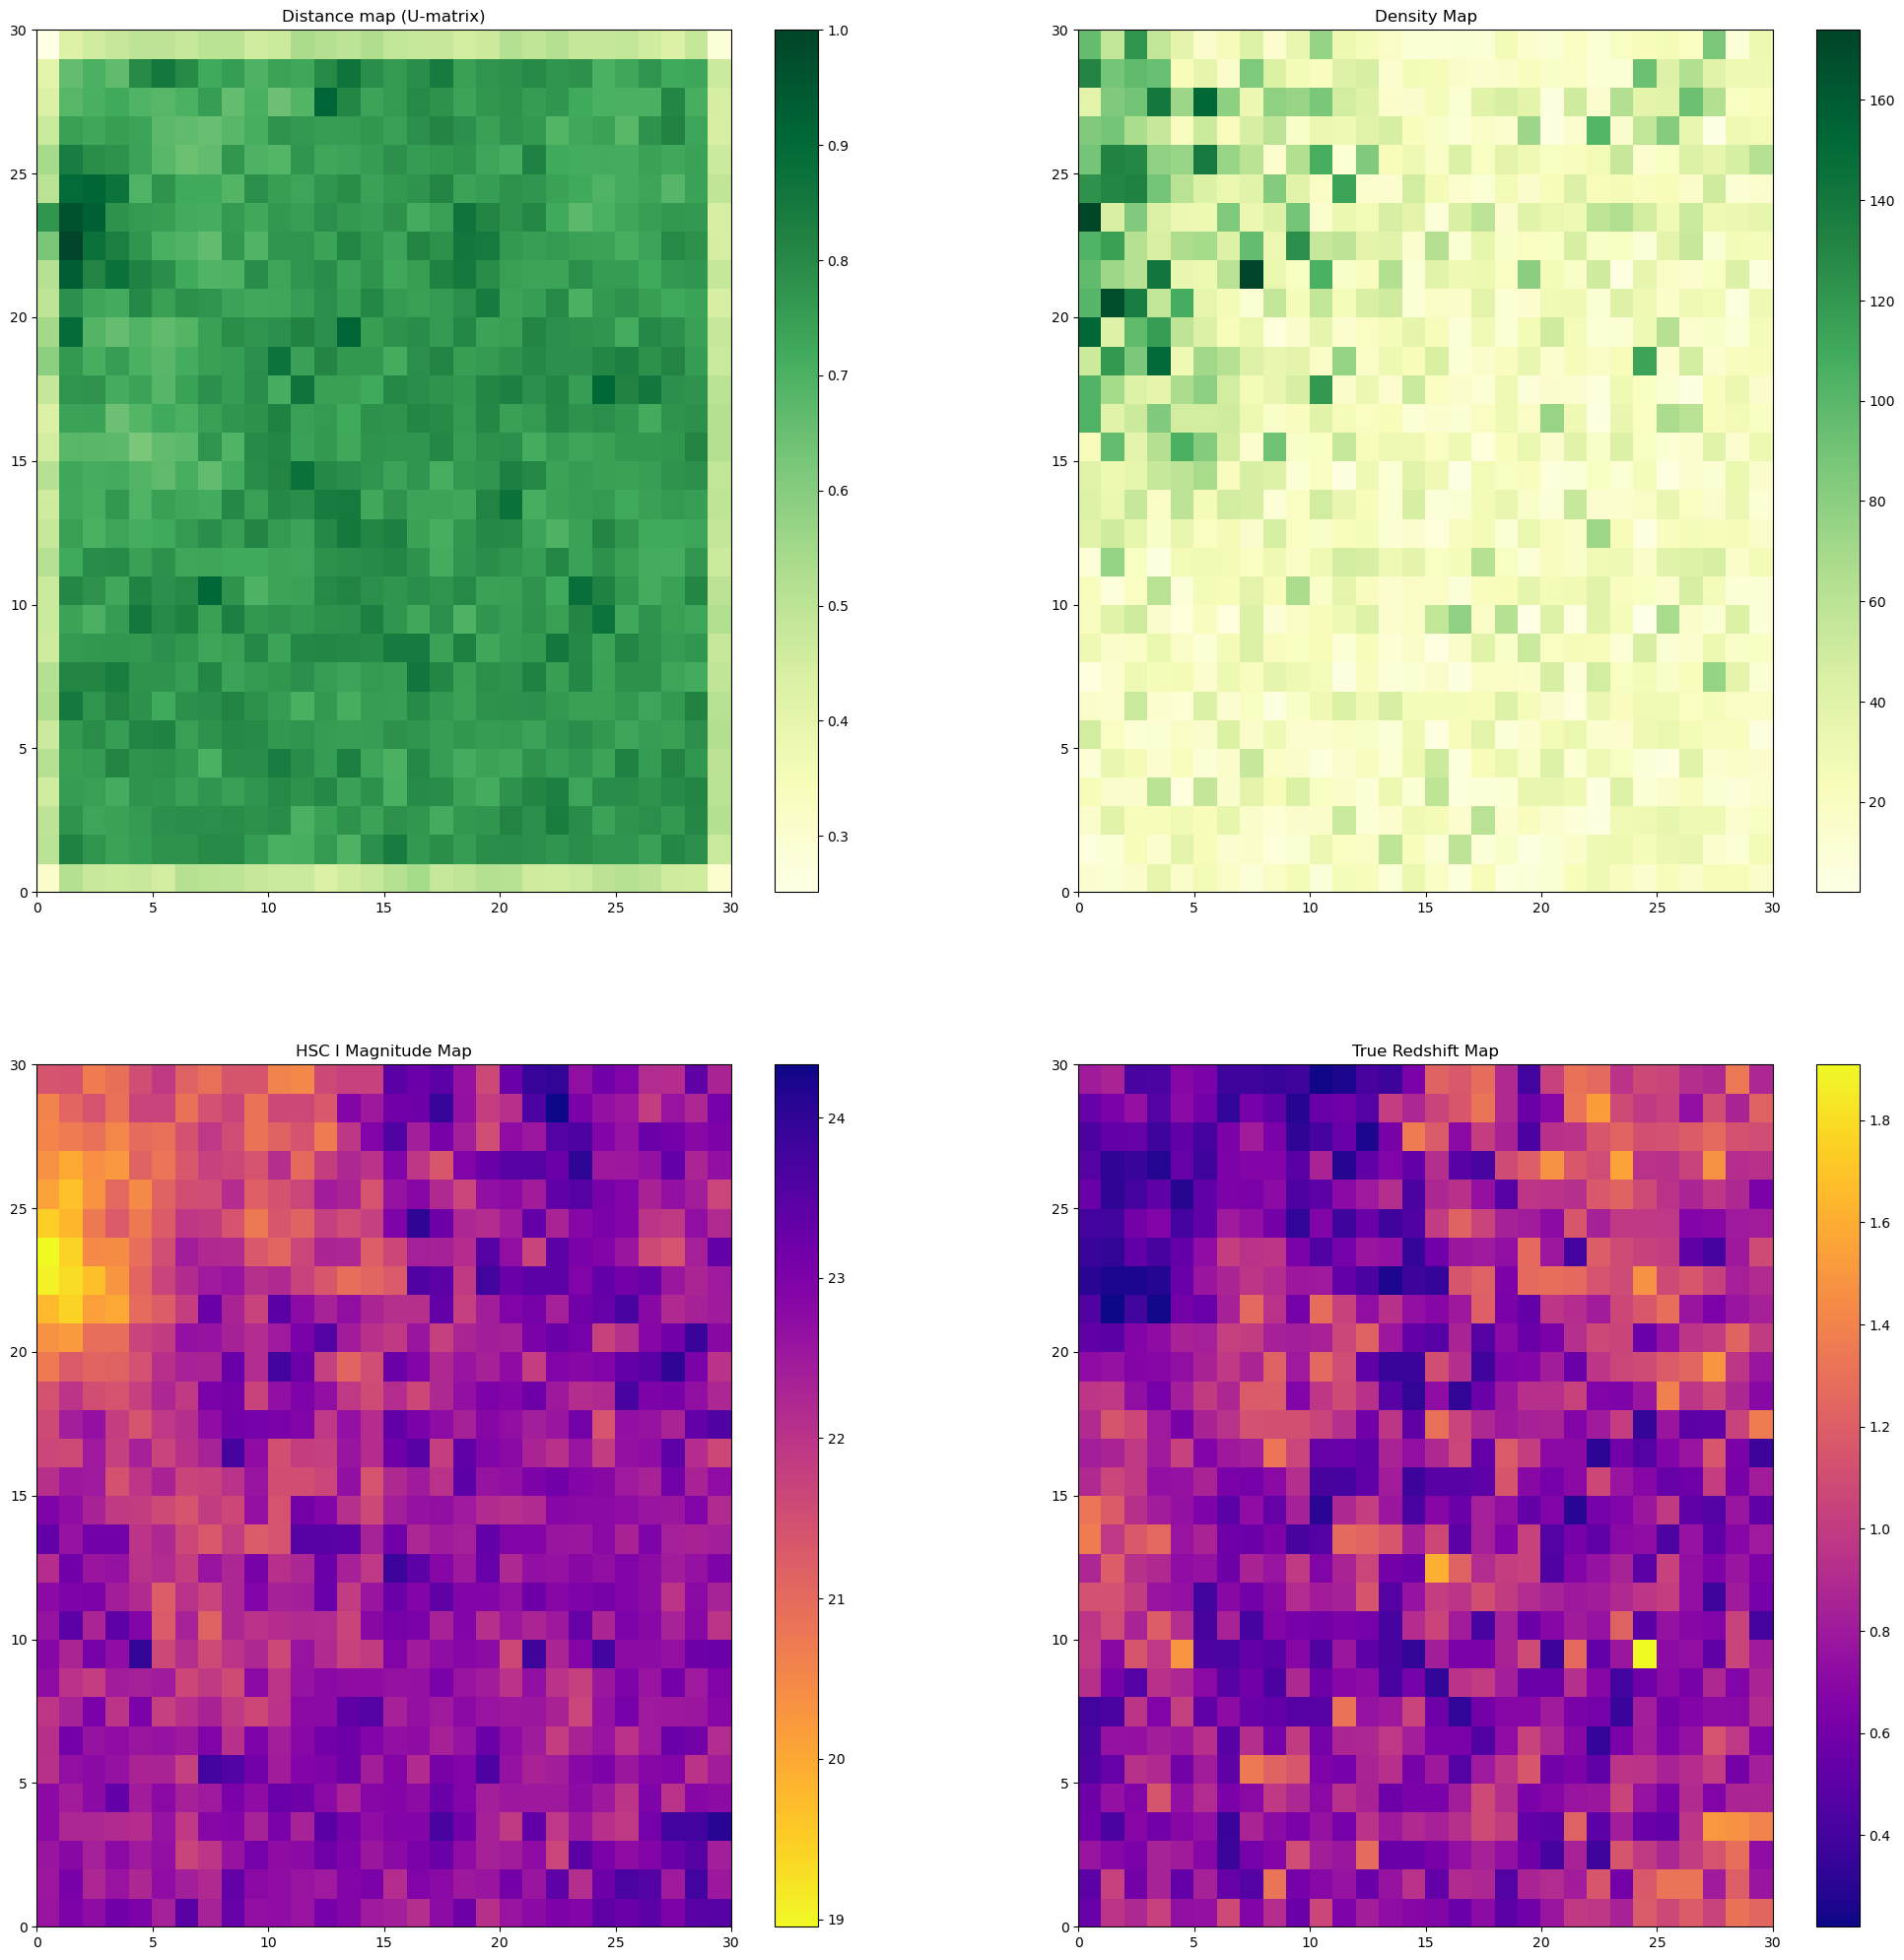

Data shape: (29683, 102)
Start making diagrams...
[30, 0.7, 1.0]
29683.0
Topological error: 0.9248054441936462
Quantization error: 6.566822658347666
Average redshift std: 0.37434397773878625


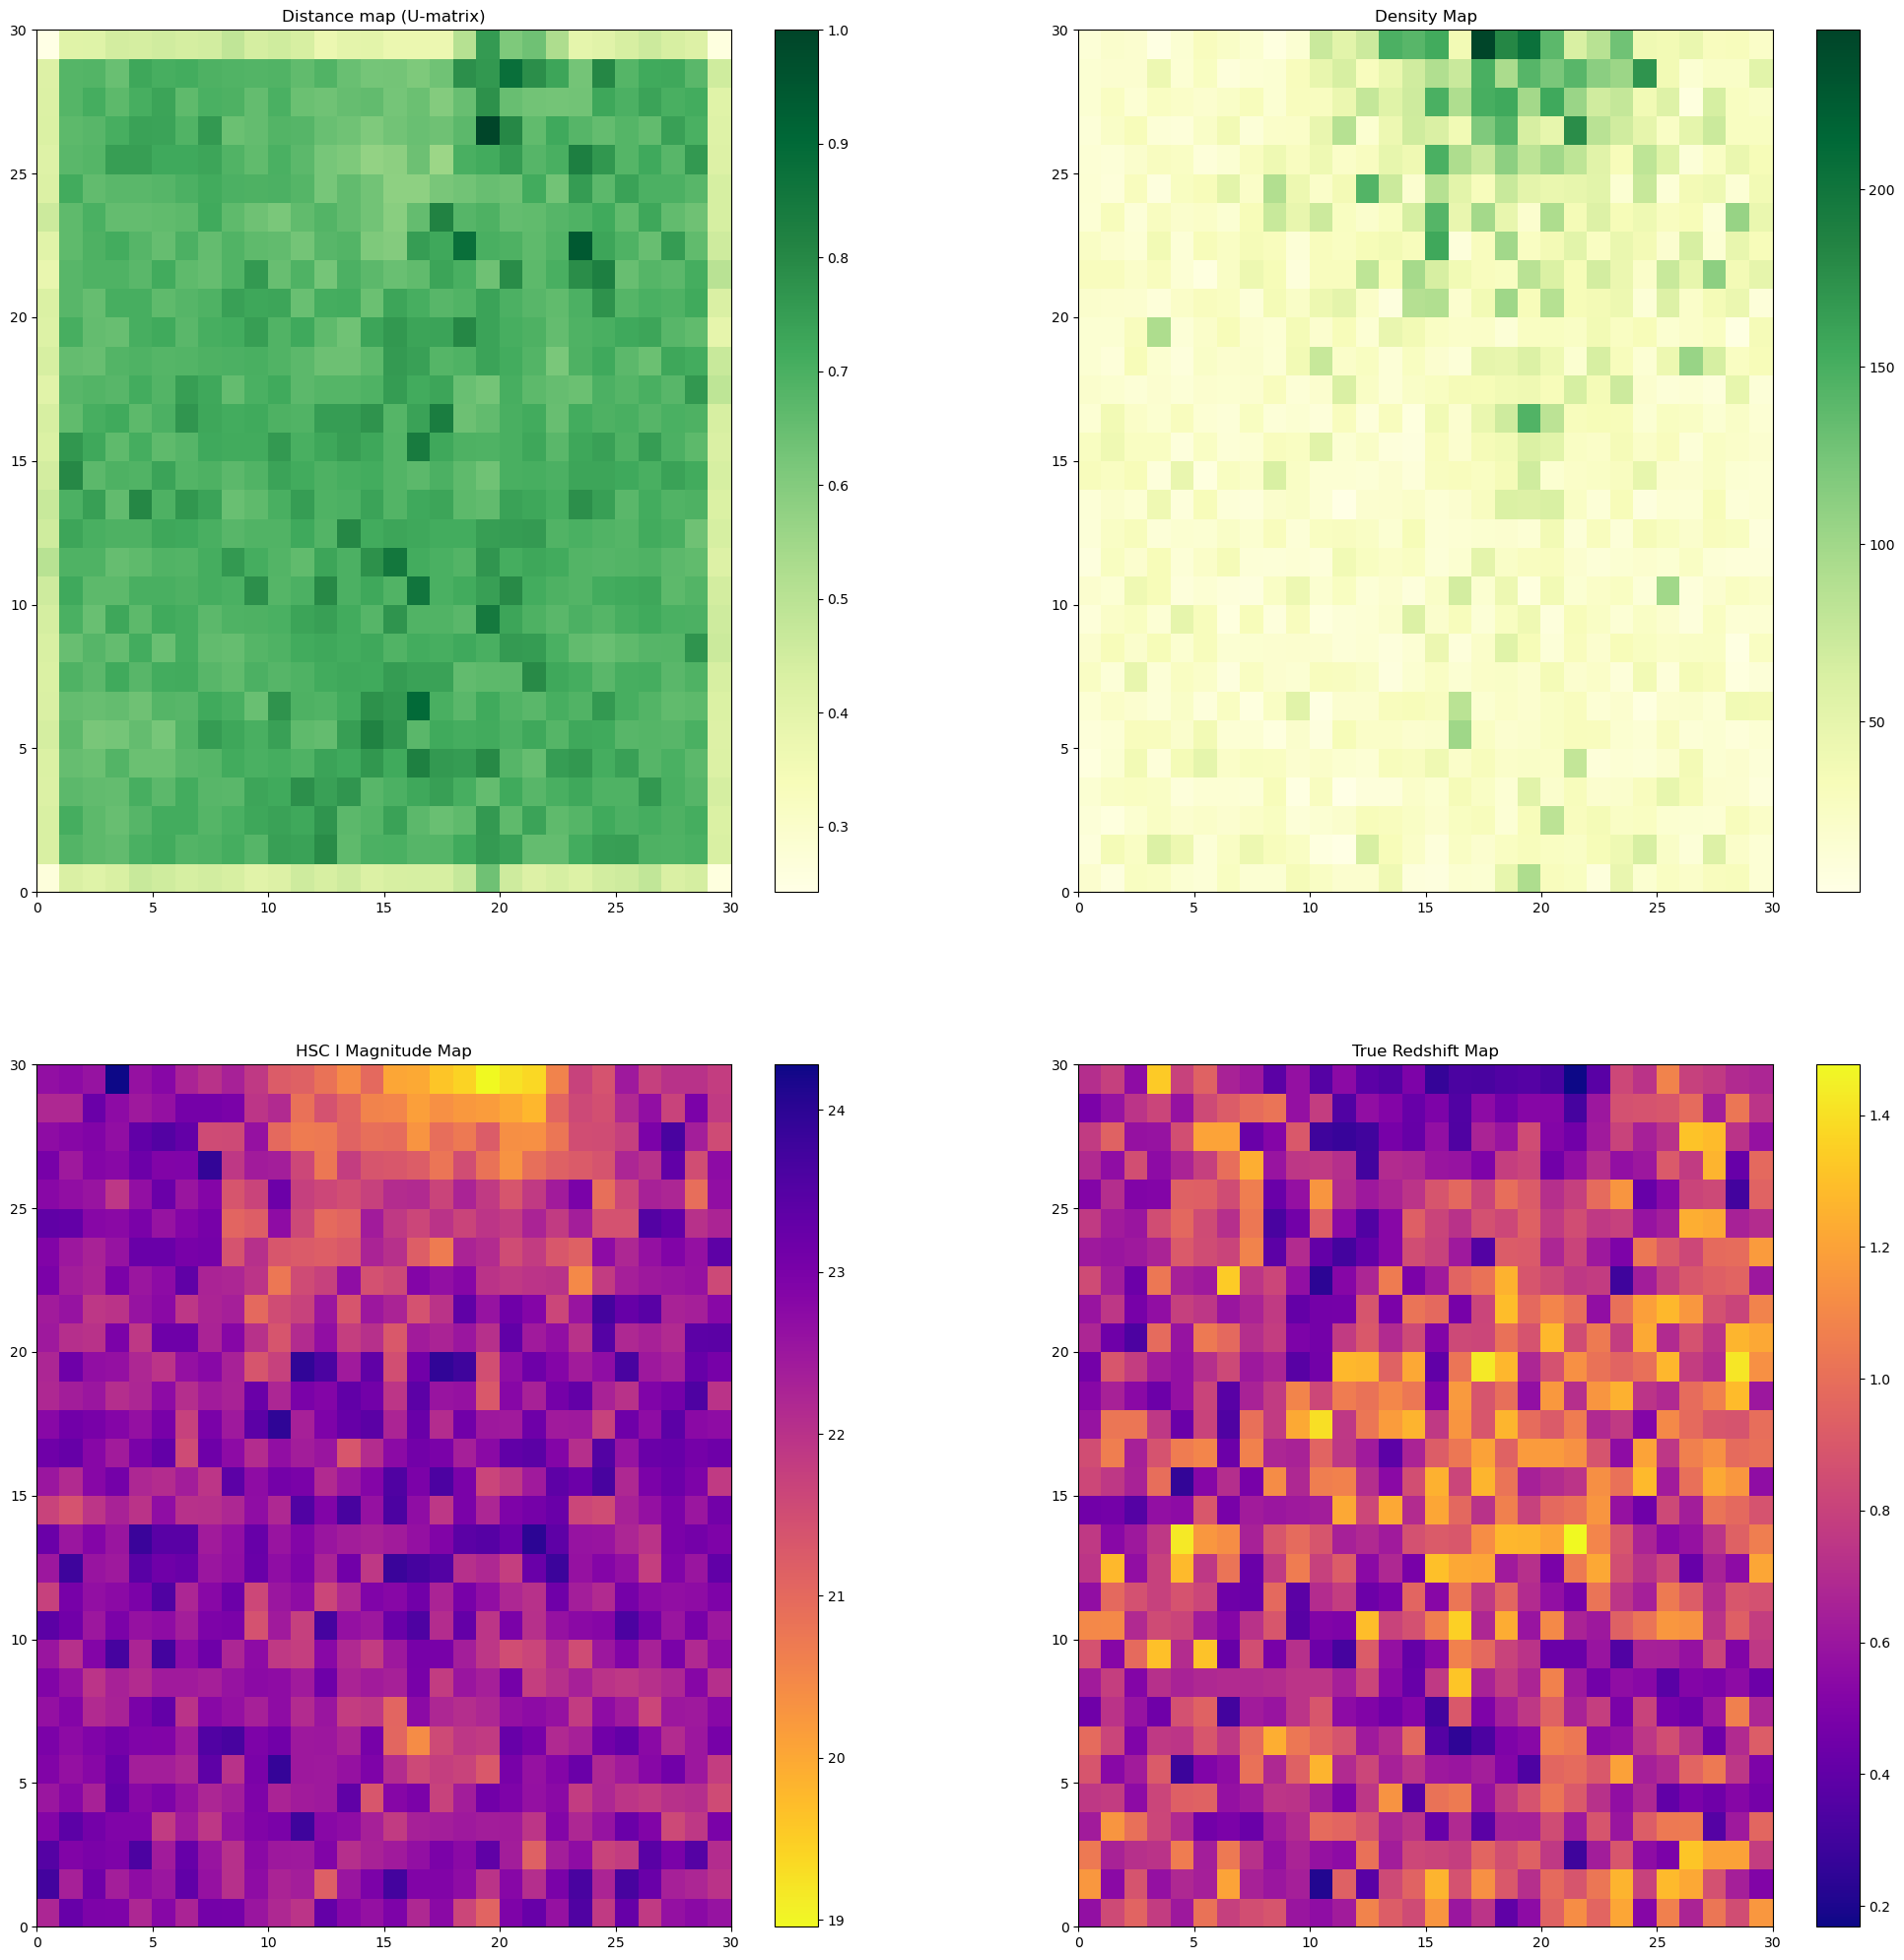

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.6, 1.0]
29683.0
Topological error: 0.9480510730047502
Quantization error: 6.607694542683567
Average redshift std: 0.3692345435799797


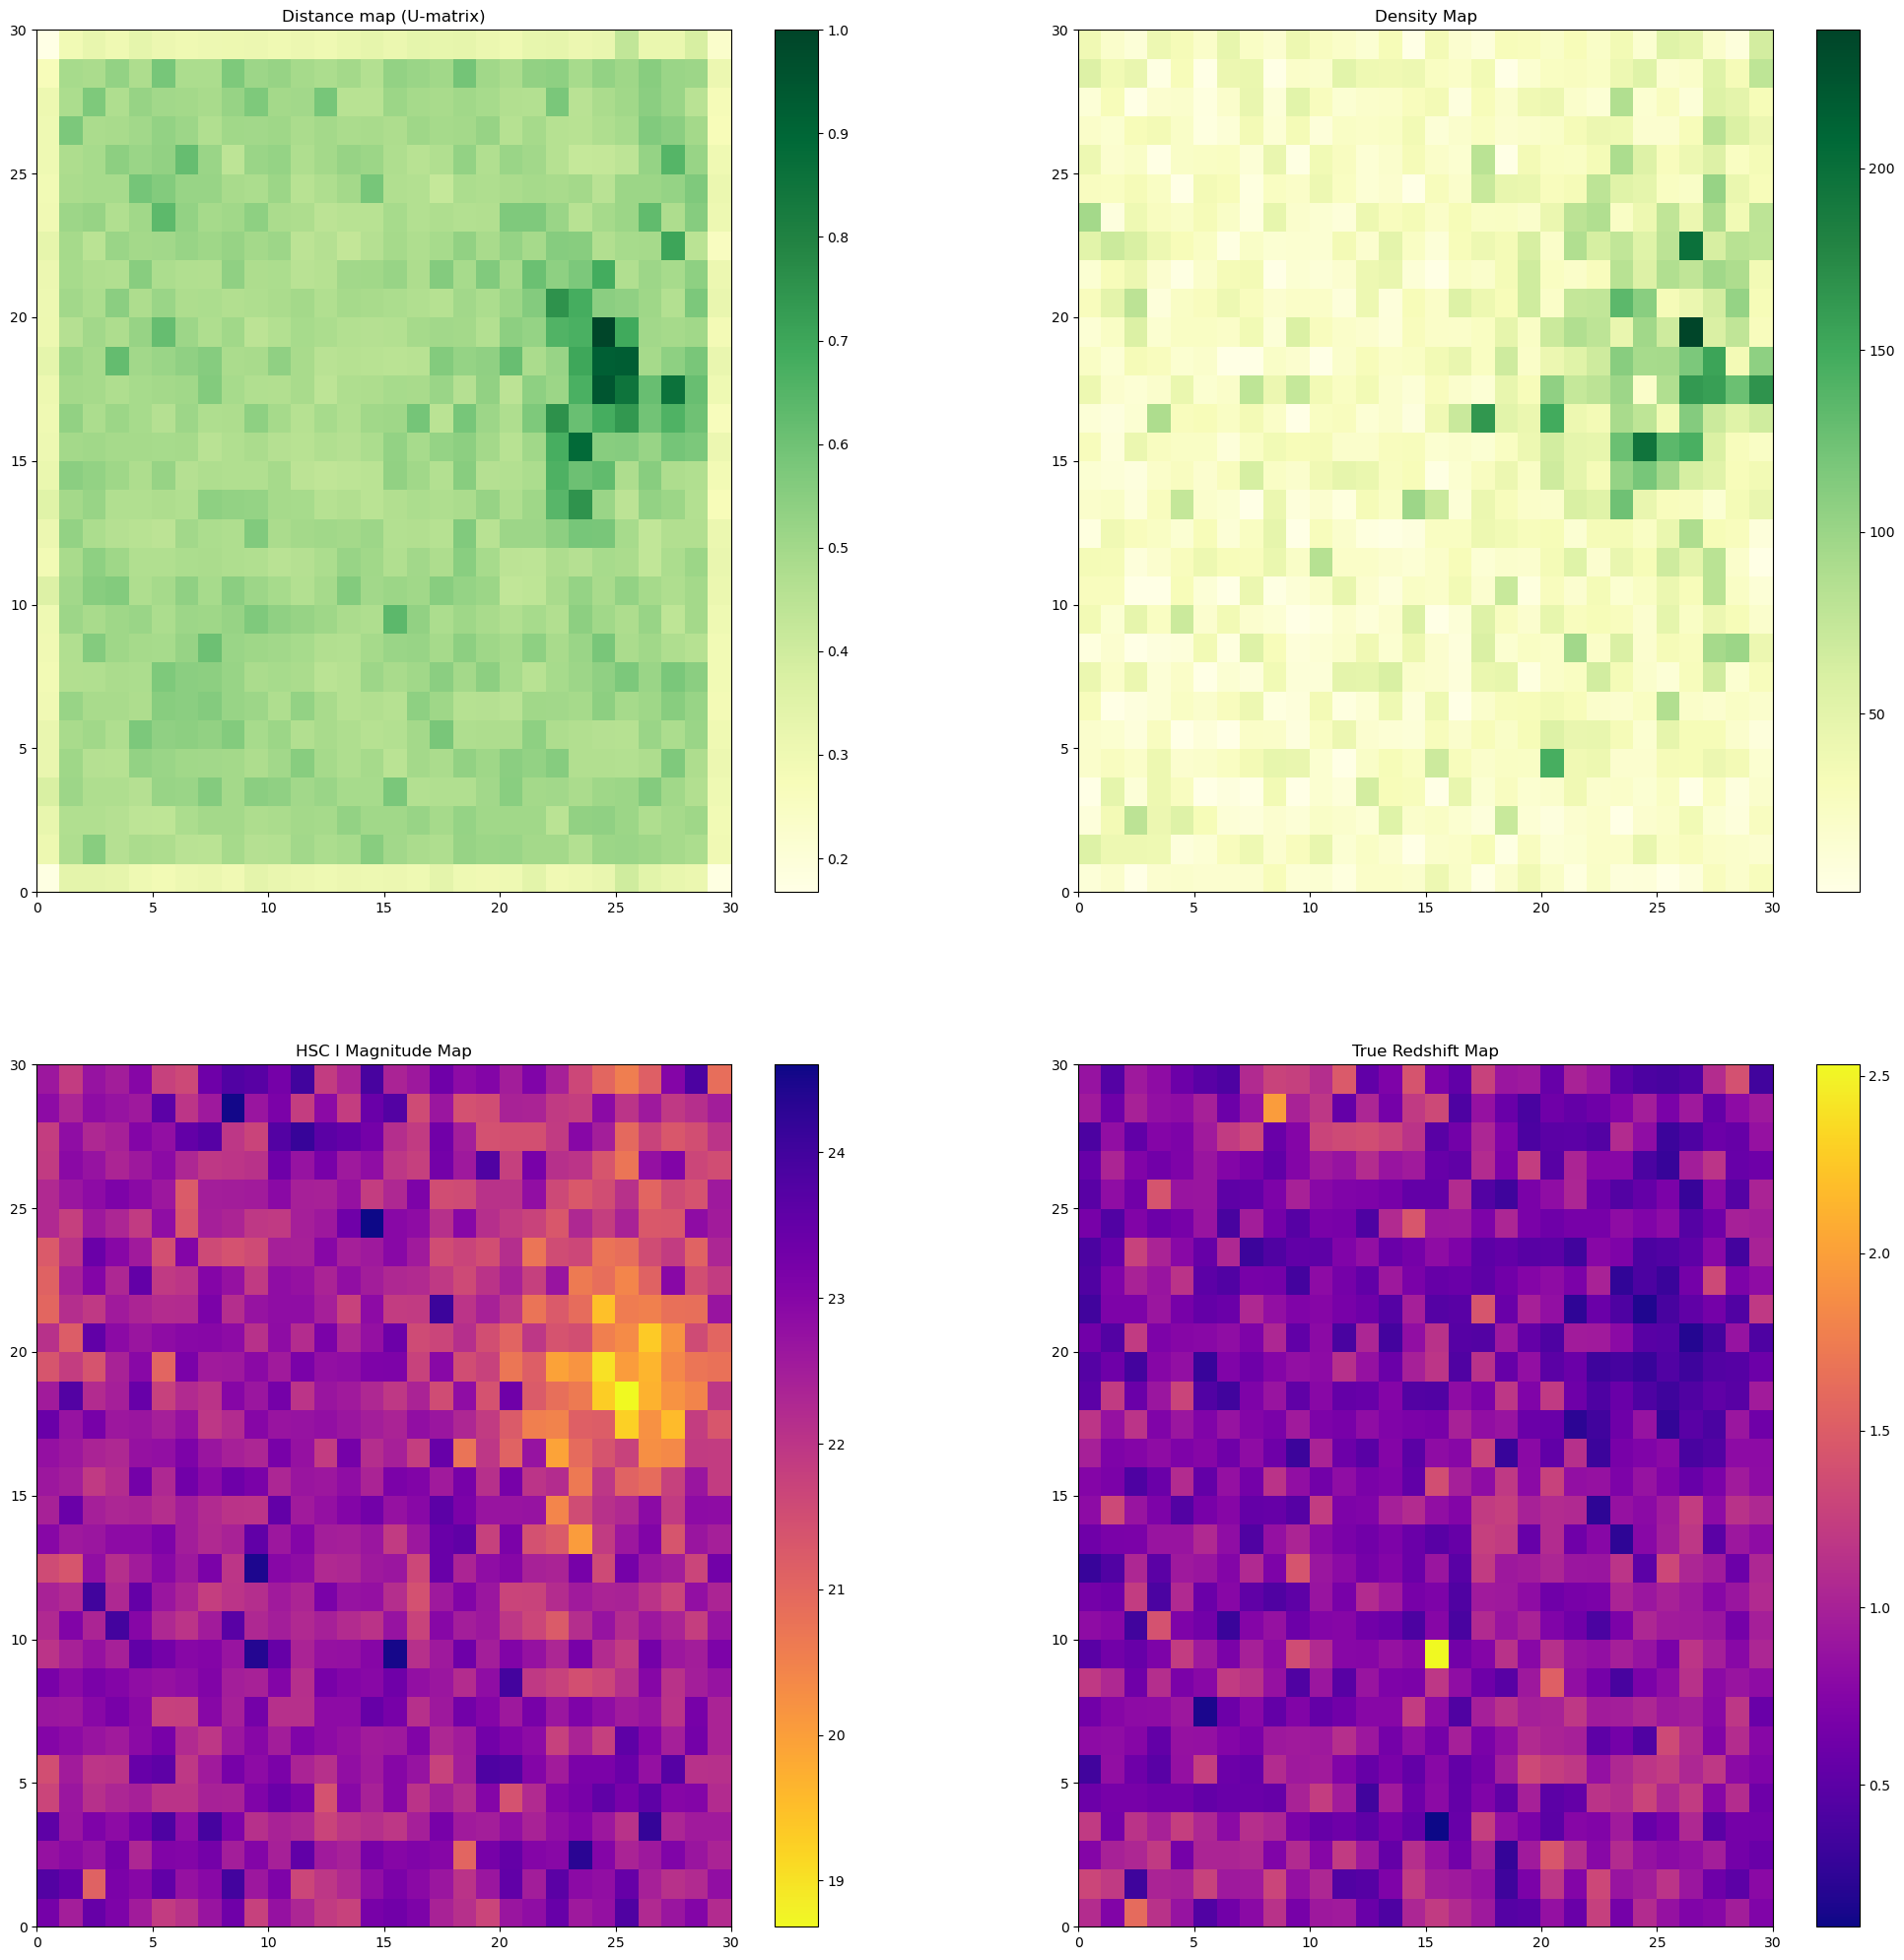

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.5, 1.0]
29683.0
Topological error: 0.9502745679345079
Quantization error: 6.6711737577890045
Average redshift std: 0.3755505137024654


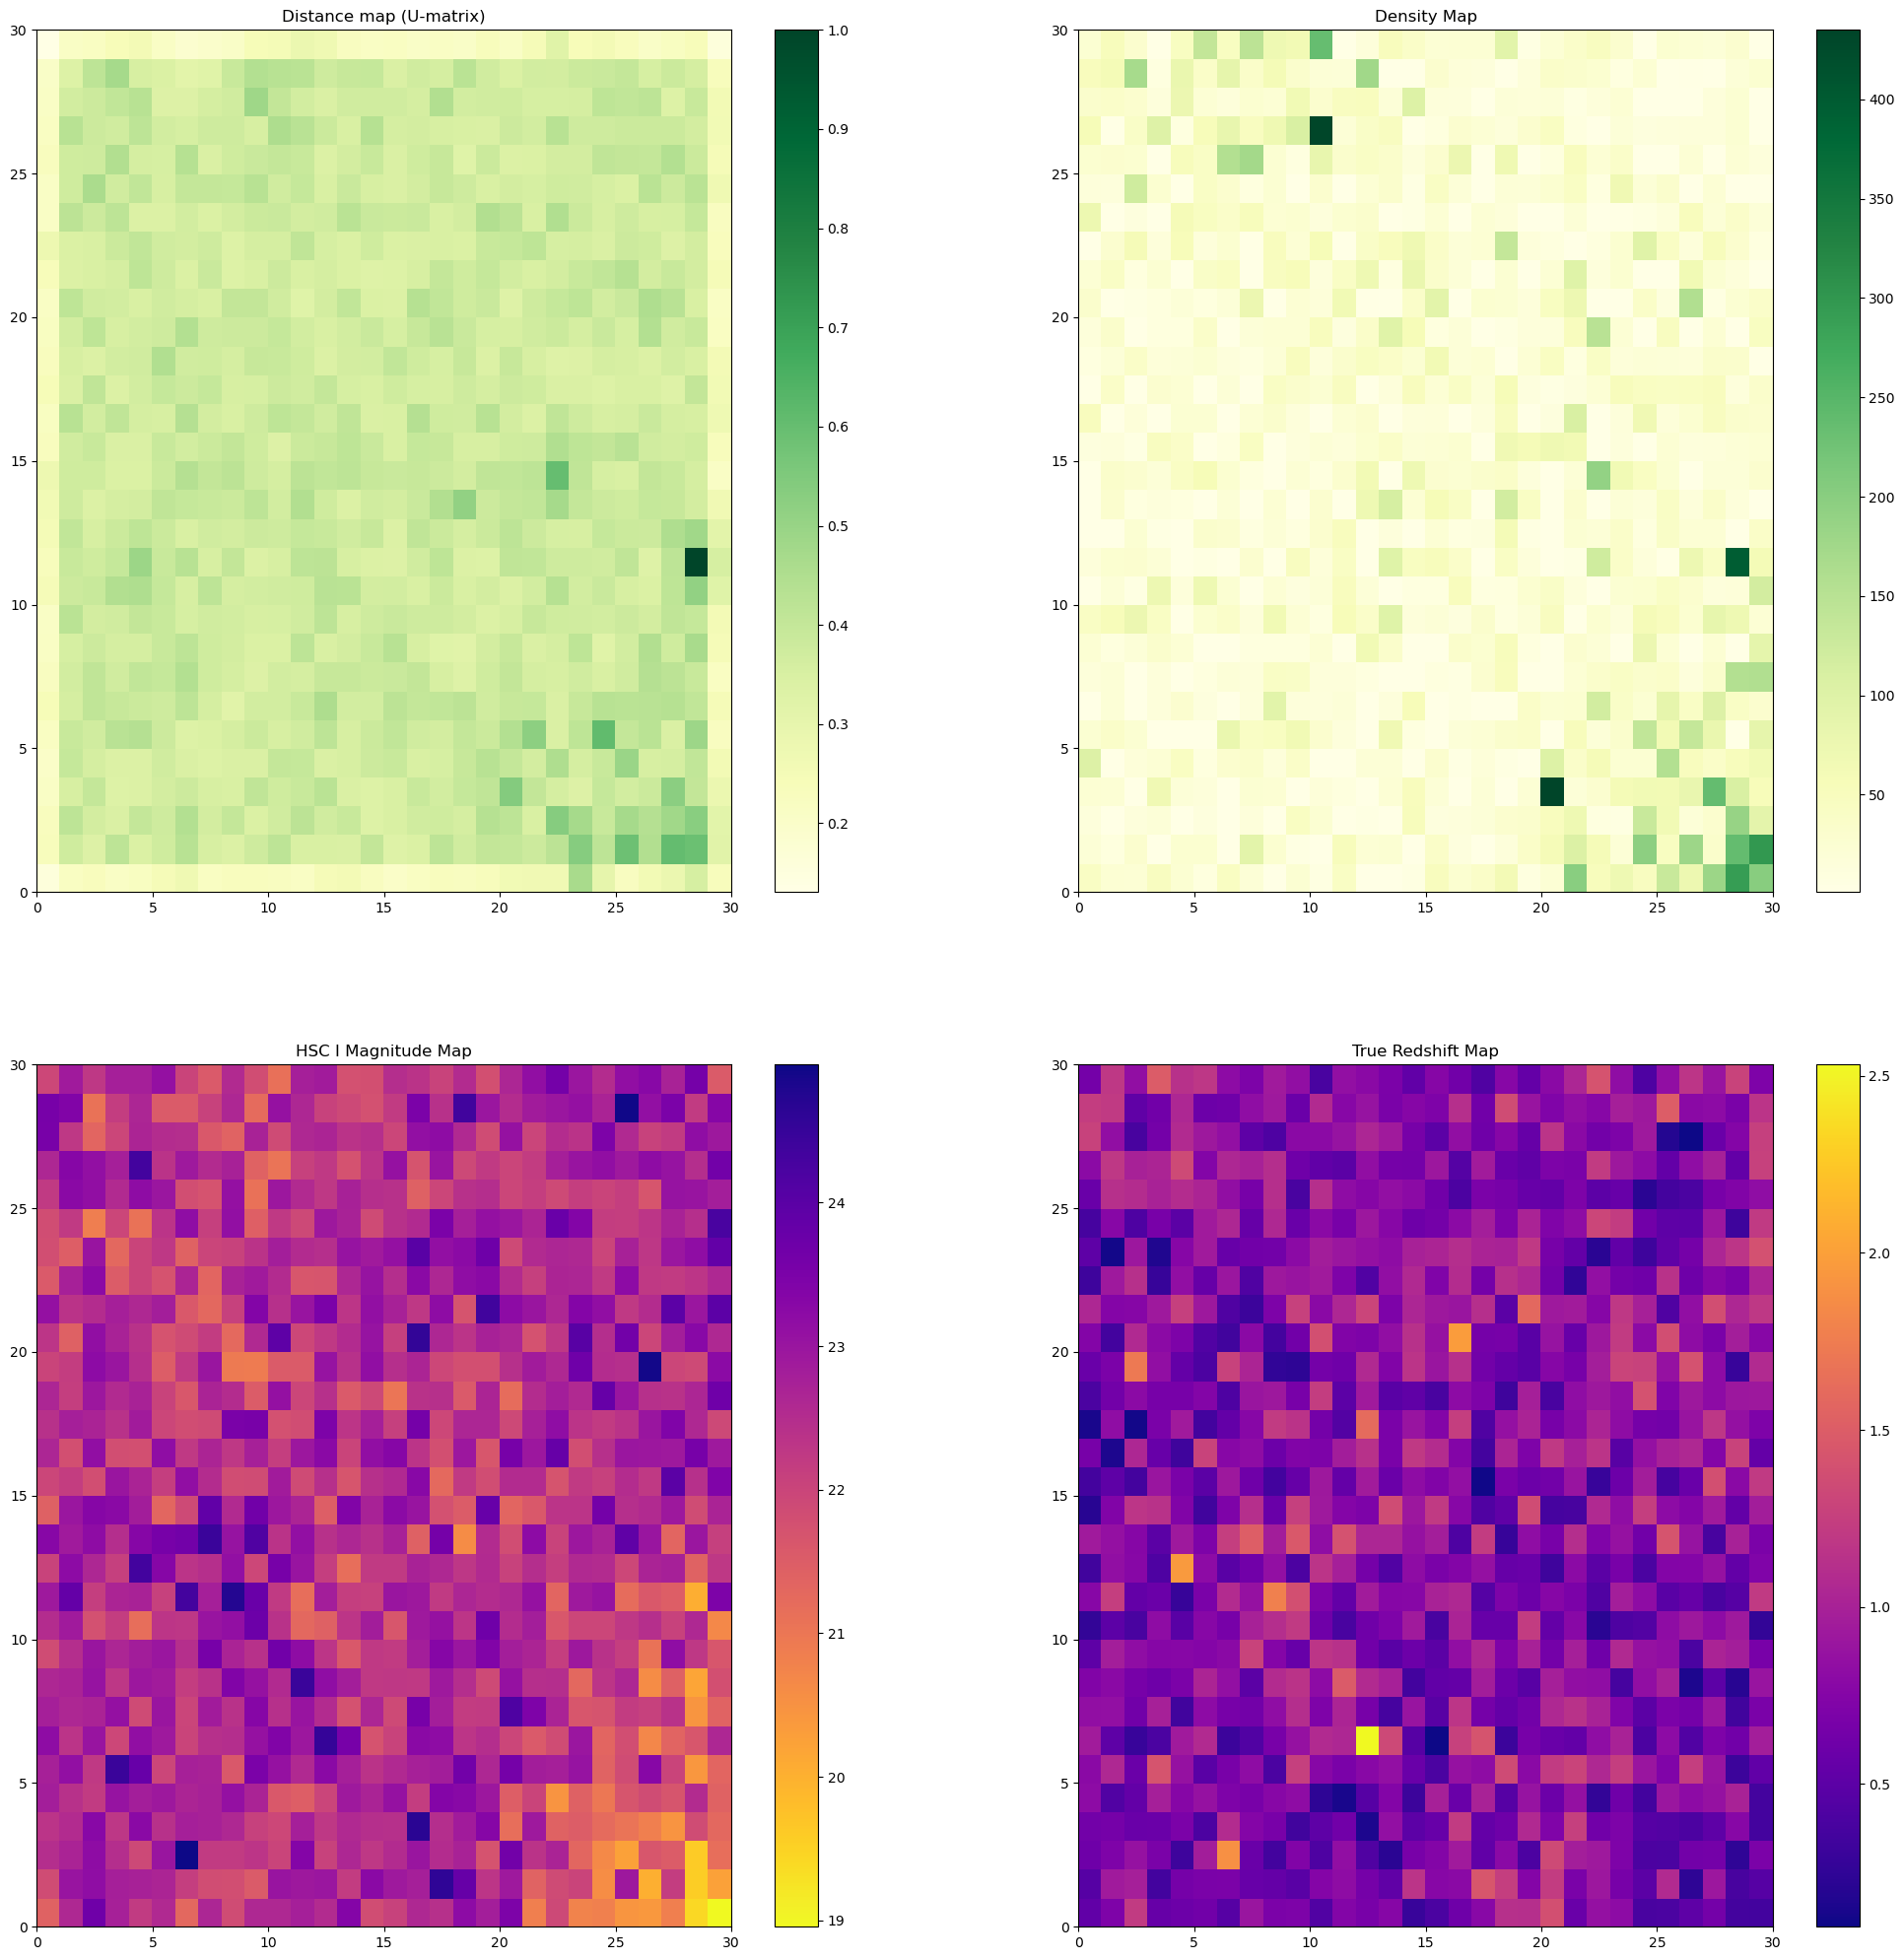

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[30, 0.4, 1.0]
29683.0
Topological error: 0.9800559242664151
Quantization error: 6.715642539559267
Average redshift std: 0.3809523440355918


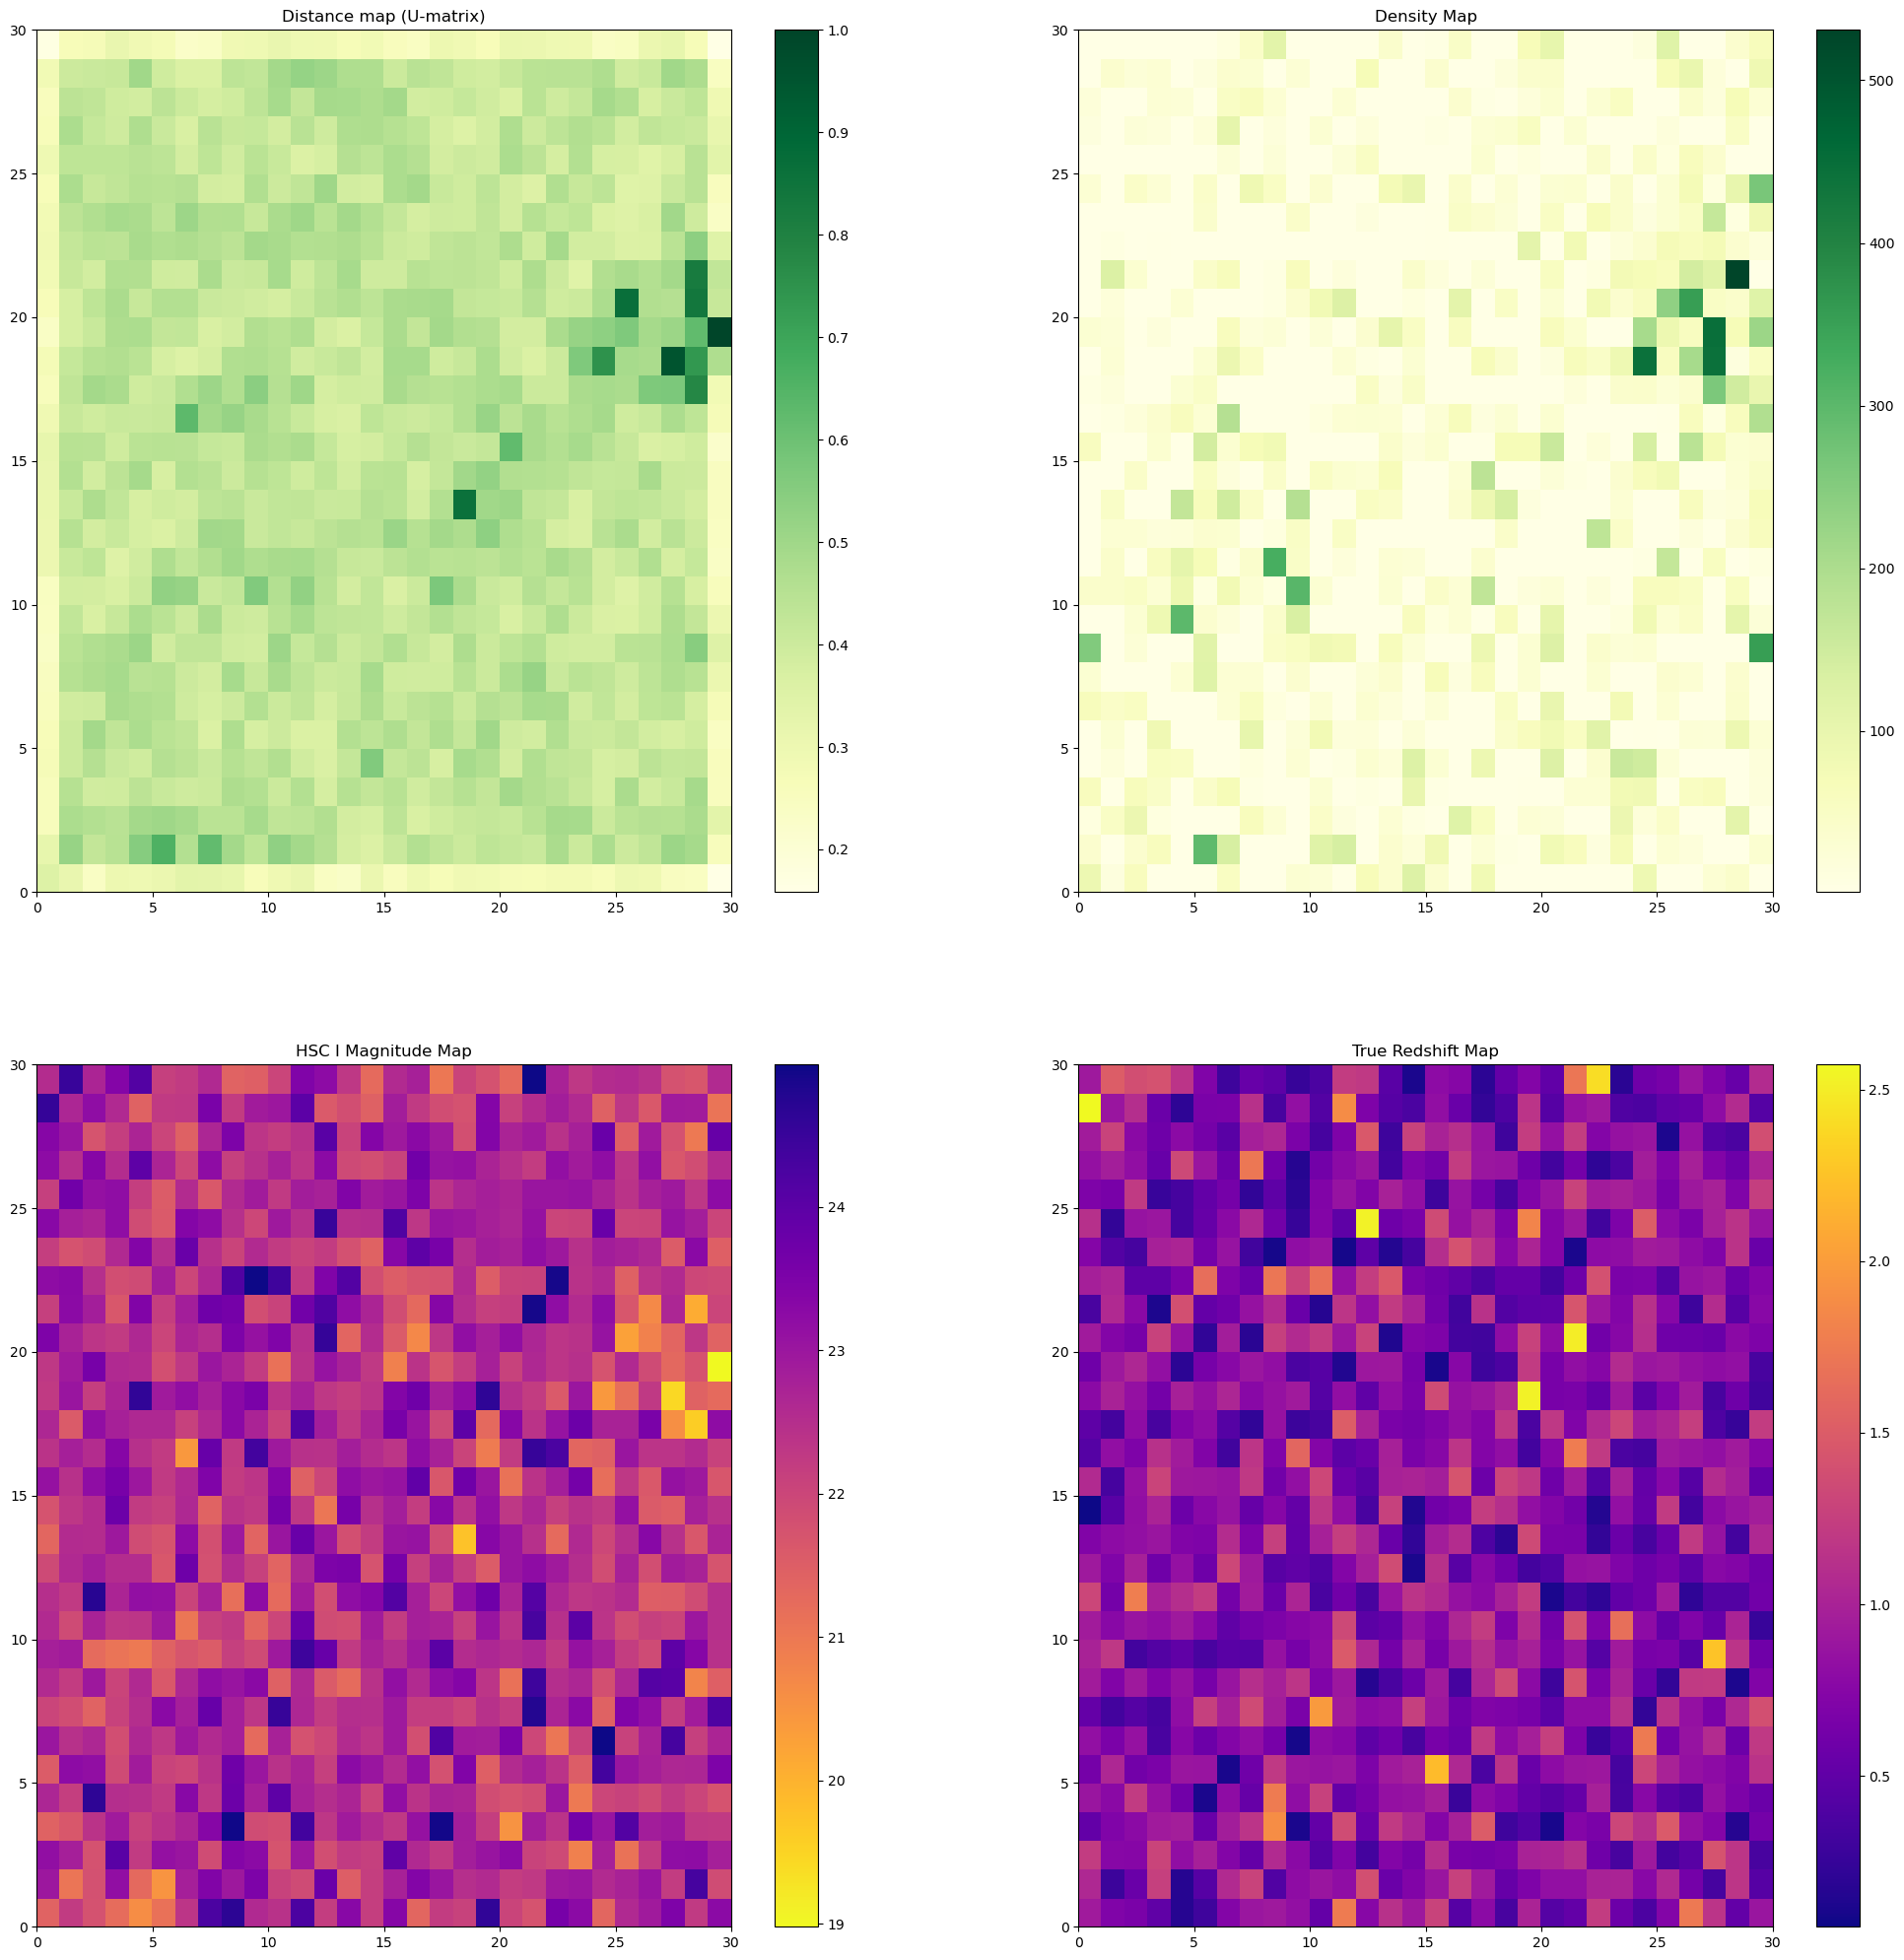

In [14]:
a = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
for i in range(1, 11):
    for j in a:
        som = basic_som(data = data, data_type = "noisy_lup_shallow", err = err, info_data = info, dim = 30, preproc = "default", iteration = 2, sigma = j, rate = i / 10, save = True, distance = "euclidean", save_record = True)

In [ ]:
som = basic_som(data = data, data_type = "noisy_lup_deep", err = err, info_data = info, dim = 50, preproc = "default", iteration = 2, sigma = 0.7, rate = 0.202, save = True, distance = "euclidean", save_record = True)